# R Notebook: CMIP5 Wet Spell Length Distributions, 2071-2100

Wet state, spell length for PRISM data.

Uses R to do some analysis

Add in the part to make a DataFrame with our best fit negative binomial parameters and then to output this to a spreadsheet

## Parameters and Library Loading

In [1]:
oldw <- getOption("warn")

In [2]:
options(warn = -1)

In [3]:
library(feather)
library(dplyr)
library(fitdistrplus)
library(vcd)
library(dgof)
library(xlsx)
library(r2excel)
library(moments)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: survival
Loading required package: npsurv
Loading required package: lsei
Loading required package: grid

Attaching package: 'dgof'

The following object is masked from 'package:stats':

    ks.test



**Note:** We only want to mask package:stats ks.test with that from package:dgof when working with discrete distributions.

In [4]:
setwd("\\\\augustine.space.swri.edu\\jdrive\\Groundwater\\R8937_Stochastic_CC_Recharge\\Data\\R\\Working\\CMIP5_2071_WetDays")

Now specify some parameters - just file names

In [5]:
feLODPath <- "WetDays_LOCA_2071-2100.feather"

In [6]:
feBCDPath <- "WetDays_BCCA_2071-2100.feather"

## Initial Load and Process of DataFrame

In [7]:
dfLOWet <- read_feather(feLODPath)
ddates <- as.Date( ISOdate( dfLOWet$Year, dfLOWet$Month, dfLOWet$Day ) )
dfLOWet["Date"] <- ddates

In [8]:
str(dfLOWet)

Classes 'tbl_df', 'tbl' and 'data.frame':	12222392 obs. of  62 variables:
 $ MGrid_Id   : chr  "M10_1" "M10_1" "M10_1" "M10_1" ...
 $ Grid_Id    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Mod_Id     : int  10 10 10 10 10 10 10 10 10 10 ...
 $ Year       : num  2071 2071 2071 2071 2071 ...
 $ Month      : num  1 1 1 1 1 2 2 2 2 3 ...
 $ Day        : num  3 7 14 21 30 4 15 24 27 4 ...
 $ Wet_Count  : num  2 1 2 2 1 2 5 1 2 1 ...
 $ Total_Depth: num  2.401 0.214 1.471 2.671 0.759 ...
 $ Day_1      : num  2.104 0.214 0.994 0.506 0.759 ...
 $ Day_2      : num  0.297 0 0.477 2.165 0 ...
 $ Day_3      : num  0 0 0 0 0 ...
 $ Day_4      : num  0 0 0 0 0 ...
 $ Day_5      : num  0 0 0 0 0 ...
 $ Day_6      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_7      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_8      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_9      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_10     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_11     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_12     : num  0 0 0 0 0 0 0 0 0 0 ...
 

In [9]:
head(dfLOWet)

MGrid_Id,Grid_Id,Mod_Id,Year,Month,Day,Wet_Count,Total_Depth,Day_1,Day_2,...,Day_45,Day_46,Day_47,Day_48,Day_49,Day_50,Day_51,Day_52,Day_53,Date
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
M10_1,1,10,2071,1,3,2,2.4008752,2.1038013,0.2970739,...,0,0,0,0,0,0,0,0,0,2071-01-03
M10_1,1,10,2071,1,7,1,0.2137994,0.2137994,0.0000000,...,0,0,0,0,0,0,0,0,0,2071-01-07
M10_1,1,10,2071,1,14,2,1.4710548,0.9940021,0.4770527,...,0,0,0,0,0,0,0,0,0,2071-01-14
M10_1,1,10,2071,1,21,2,2.6705218,0.5058208,2.1647010,...,0,0,0,0,0,0,0,0,0,2071-01-21
M10_1,1,10,2071,1,30,1,0.7593812,0.7593812,0.0000000,...,0,0,0,0,0,0,0,0,0,2071-01-30
M10_1,1,10,2071,2,4,2,29.8280845,5.5214705,24.3066139,...,0,0,0,0,0,0,0,0,0,2071-02-04


In [10]:
dfBCWet <- read_feather(feBCDPath)
ddates <- as.Date( ISOdate( dfBCWet$Year, dfBCWet$Month, dfBCWet$Day ) )
dfBCWet["Date"] <- ddates

In [11]:
str(dfBCWet)

Classes 'tbl_df', 'tbl' and 'data.frame':	8763208 obs. of  72 variables:
 $ MGrid_Id   : chr  "M100_169" "M100_169" "M100_169" "M100_169" ...
 $ Grid_Id    : int  169 169 169 169 169 169 169 169 169 169 ...
 $ Mod_Id     : int  100 100 100 100 100 100 100 100 100 100 ...
 $ Year       : num  2071 2071 2071 2071 2071 ...
 $ Month      : num  1 1 2 2 2 2 3 3 3 3 ...
 $ Day        : num  12 21 4 7 15 22 2 6 12 18 ...
 $ Wet_Count  : num  2 1 1 1 2 3 2 2 4 3 ...
 $ Total_Depth: num  1.16 1.654 0.321 0.22 4.519 ...
 $ Day_1      : num  0.252 1.654 0.321 0.22 2.247 ...
 $ Day_2      : num  0.908 0 0 0 2.271 ...
 $ Day_3      : num  0 0 0 0 0 ...
 $ Day_4      : num  0 0 0 0 0 ...
 $ Day_5      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_6      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_7      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_8      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_9      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_10     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_11     : num  0 0 0 0 0 0 0 0 0 0 ...
 $

In [12]:
head(dfBCWet)

MGrid_Id,Grid_Id,Mod_Id,Year,Month,Day,Wet_Count,Total_Depth,Day_1,Day_2,...,Day_55,Day_56,Day_57,Day_58,Day_59,Day_60,Day_61,Day_62,Day_63,Date
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
M100_169,169,100,2071,1,12,2,1.1596931,0.2519825,0.9077106,...,0,0,0,0,0,0,0,0,0,2071-01-12
M100_169,169,100,2071,1,21,1,1.6539979,1.6539979,0.0000000,...,0,0,0,0,0,0,0,0,0,2071-01-21
M100_169,169,100,2071,2,4,1,0.3206769,0.3206769,0.0000000,...,0,0,0,0,0,0,0,0,0,2071-02-04
M100_169,169,100,2071,2,7,1,0.2197432,0.2197432,0.0000000,...,0,0,0,0,0,0,0,0,0,2071-02-07
M100_169,169,100,2071,2,15,2,4.5187876,2.2473459,2.2714417,...,0,0,0,0,0,0,0,0,0,2071-02-15
M100_169,169,100,2071,2,22,3,2.5066030,1.8914123,0.3218923,...,0,0,0,0,0,0,0,0,0,2071-02-22


First filter for each month with all Grid_Id

In [13]:
dLOJan <- dfLOWet %>% filter( Month == 1 )
dLOFeb <- dfLOWet %>% filter( Month == 2 )
dLOMar <- dfLOWet %>% filter( Month == 3 )
dLOApr <- dfLOWet %>% filter( Month == 4 )
dLOMay <- dfLOWet %>% filter( Month == 5 )
dLOJun <- dfLOWet %>% filter( Month == 6 )
dLOJul <- dfLOWet %>% filter( Month == 7 )
dLOAug <- dfLOWet %>% filter( Month == 8 )
dLOSep <- dfLOWet %>% filter( Month == 9 )
dLOOct <- dfLOWet %>% filter( Month == 10 )
dLONov <- dfLOWet %>% filter( Month == 11 )
dLODec <- dfLOWet %>% filter( Month == 12 )

In [14]:
dBCJan <- dfBCWet %>% filter( Month == 1 )
dBCFeb <- dfBCWet %>% filter( Month == 2 )
dBCMar <- dfBCWet %>% filter( Month == 3 )
dBCApr <- dfBCWet %>% filter( Month == 4 )
dBCMay <- dfBCWet %>% filter( Month == 5 )
dBCJun <- dfBCWet %>% filter( Month == 6 )
dBCJul <- dfBCWet %>% filter( Month == 7 )
dBCAug <- dfBCWet %>% filter( Month == 8 )
dBCSep <- dfBCWet %>% filter( Month == 9 )
dBCOct <- dfBCWet %>% filter( Month == 10 )
dBCNov <- dfBCWet %>% filter( Month == 11 )
dBCDec <- dfBCWet %>% filter( Month == 12 )

Set-up a dataframe to store the basic summary statistics. Eventually will write this to Excel.

In [15]:
MonLOSumStatDF <- data.frame( month=rep(NA,12), mean=rep(NA,12), median=rep(NA,12), 
                            max=rep(NA,12), min=rep(NA,12), stdev=rep(NA,12), var=rep(NA,12),
                            skew=rep(NA,12), kurt=rep(NA,12), perc0=rep(NA,12), perc10=rep(NA,12), 
                            perc20=rep(NA,12), perc30=rep(NA,12), perc40=rep(NA,12), 
                            perc50=rep(NA,12), perc60=rep(NA,12), perc70=rep(NA,12), 
                            perc80=rep(NA,12), perc90=rep(NA,12), perc100=rep(NA,12), 
                            stringsAsFactors=FALSE )

In [16]:
pvec <- seq(0,1,0.1)

In [17]:
NumDeciles = length( pvec )
cat("Number of deciles: ", NumDeciles)

Number of deciles:  11

Now look at summary stats for the Wet day counts for each month

In [18]:
summary( dLOJan$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.786   2.000  18.000 

In [19]:
oQuants = quantile( dLOJan$Wet_Count, pvec )

In [20]:
MonLOSumStatDF[1, ] <-list( 1, mean(dLOJan$Wet_Count), median(dLOJan$Wet_Count), 
                          max(dLOJan$Wet_Count), min(dLOJan$Wet_Count), sd(dLOJan$Wet_Count),
                          var(dLOJan$Wet_Count), skewness(dLOJan$Wet_Count), 
                          kurtosis(dLOJan$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [21]:
summary( dLOFeb$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    1.92    2.00   15.00 

In [22]:
oQuants = quantile( dLOFeb$Wet_Count, pvec )

In [23]:
MonLOSumStatDF[2, ] <-list( 2, mean(dLOFeb$Wet_Count), median(dLOFeb$Wet_Count), 
                          max(dLOFeb$Wet_Count), min(dLOFeb$Wet_Count), sd(dLOFeb$Wet_Count),
                          var(dLOFeb$Wet_Count), skewness(dLOFeb$Wet_Count), 
                          kurtosis(dLOFeb$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [24]:
summary( dLOMar$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.864   2.000  20.000 

In [25]:
oQuants = quantile( dLOMar$Wet_Count, pvec )

In [26]:
MonLOSumStatDF[3, ] <-list( 3, mean(dLOMar$Wet_Count), median(dLOMar$Wet_Count), 
                          max(dLOMar$Wet_Count), min(dLOMar$Wet_Count), sd(dLOMar$Wet_Count),
                          var(dLOMar$Wet_Count), skewness(dLOMar$Wet_Count), 
                          kurtosis(dLOMar$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [27]:
summary( dLOApr$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.254   3.000  21.000 

In [28]:
oQuants = quantile( dLOApr$Wet_Count, pvec )

In [29]:
MonLOSumStatDF[4, ] <-list( 4, mean(dLOApr$Wet_Count), median(dLOApr$Wet_Count), 
                          max(dLOApr$Wet_Count), min(dLOApr$Wet_Count), sd(dLOApr$Wet_Count),
                          var(dLOApr$Wet_Count), skewness(dLOApr$Wet_Count), 
                          kurtosis(dLOApr$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [30]:
summary( dLOMay$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.615   3.000  44.000 

In [31]:
oQuants = quantile( dLOMay$Wet_Count, pvec )

In [32]:
MonLOSumStatDF[5, ] <-list( 5, mean(dLOMay$Wet_Count), median(dLOMay$Wet_Count), 
                          max(dLOMay$Wet_Count), min(dLOMay$Wet_Count), sd(dLOMay$Wet_Count),
                          var(dLOMay$Wet_Count), skewness(dLOMay$Wet_Count), 
                          kurtosis(dLOMay$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [33]:
summary( dLOJun$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.937   4.000  37.000 

In [34]:
oQuants = quantile( dLOJun$Wet_Count, pvec )

In [35]:
MonLOSumStatDF[6, ] <-list( 6, mean(dLOJun$Wet_Count), median(dLOJun$Wet_Count), 
                          max(dLOJun$Wet_Count), min(dLOJun$Wet_Count), sd(dLOJun$Wet_Count),
                          var(dLOJun$Wet_Count), skewness(dLOJun$Wet_Count), 
                          kurtosis(dLOJun$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [36]:
summary( dLOJul$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.618   3.000  53.000 

In [37]:
oQuants = quantile( dLOJul$Wet_Count, pvec )

In [38]:
MonLOSumStatDF[7, ] <-list( 7, mean(dLOJul$Wet_Count), median(dLOJul$Wet_Count), 
                          max(dLOJul$Wet_Count), min(dLOJul$Wet_Count), sd(dLOJul$Wet_Count),
                          var(dLOJul$Wet_Count), skewness(dLOJul$Wet_Count), 
                          kurtosis(dLOJul$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [39]:
summary( dLOAug$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.601   3.000  35.000 

In [40]:
oQuants = quantile( dLOAug$Wet_Count, pvec )

In [41]:
MonLOSumStatDF[8, ] <-list( 8, mean(dLOAug$Wet_Count), median(dLOAug$Wet_Count), 
                          max(dLOAug$Wet_Count), min(dLOAug$Wet_Count), sd(dLOAug$Wet_Count),
                          var(dLOAug$Wet_Count), skewness(dLOAug$Wet_Count), 
                          kurtosis(dLOAug$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [42]:
summary( dLOSep$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.988   4.000  30.000 

In [43]:
oQuants = quantile( dLOSep$Wet_Count, pvec )

In [44]:
MonLOSumStatDF[9, ] <-list( 9, mean(dLOSep$Wet_Count), median(dLOSep$Wet_Count), 
                          max(dLOSep$Wet_Count), min(dLOSep$Wet_Count), sd(dLOSep$Wet_Count),
                          var(dLOSep$Wet_Count), skewness(dLOSep$Wet_Count), 
                          kurtosis(dLOSep$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [45]:
summary( dLOOct$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    2.47    3.00   28.00 

In [46]:
oQuants = quantile( dLOOct$Wet_Count, pvec )

In [47]:
MonLOSumStatDF[10, ] <-list( 10, mean(dLOOct$Wet_Count), median(dLOOct$Wet_Count), 
                          max(dLOOct$Wet_Count), min(dLOOct$Wet_Count), sd(dLOOct$Wet_Count),
                          var(dLOOct$Wet_Count), skewness(dLOOct$Wet_Count), 
                          kurtosis(dLOOct$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [48]:
summary( dLONov$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.098   3.000  19.000 

In [49]:
oQuants = quantile( dLONov$Wet_Count, pvec )

In [50]:
MonLOSumStatDF[11, ] <-list( 11, mean(dLONov$Wet_Count), median(dLONov$Wet_Count), 
                          max(dLONov$Wet_Count), min(dLONov$Wet_Count), sd(dLONov$Wet_Count),
                          var(dLONov$Wet_Count), skewness(dLONov$Wet_Count), 
                          kurtosis(dLONov$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [51]:
summary( dLODec$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.836   2.000  13.000 

In [52]:
oQuants = quantile( dLODec$Wet_Count, pvec )

In [53]:
MonLOSumStatDF[12, ] <-list( 12, mean(dLODec$Wet_Count), median(dLODec$Wet_Count), 
                          max(dLODec$Wet_Count), min(dLODec$Wet_Count), sd(dLODec$Wet_Count),
                          var(dLODec$Wet_Count), skewness(dLODec$Wet_Count), 
                          kurtosis(dLODec$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [54]:
print( MonLOSumStatDF, quote=FALSE, row.names=FALSE )

 month     mean median max min    stdev      var     skew      kurt perc0
     1 1.786410      1  18   1 1.100000 1.210000 2.091170  9.508449     1
     2 1.919848      2  15   1 1.219727 1.487733 1.988569  9.000345     1
     3 1.863620      1  20   1 1.195373 1.428917 2.311815 12.928557     1
     4 2.253524      2  21   1 1.717651 2.950325 2.475000 12.495114     1
     5 2.614592      2  44   1 2.170956 4.713049 2.565827 14.435972     1
     6 2.937227      2  37   1 2.628801 6.910592 2.590294 13.176679     1
     7 2.617547      2  53   1 2.413161 5.823348 3.007446 18.055329     1
     8 2.601494      2  35   1 2.415581 5.835033 2.923853 16.300737     1
     9 2.987932      2  30   1 2.612331 6.824272 2.348171 11.020956     1
    10 2.469721      2  28   1 1.879726 3.533370 2.160446 10.278364     1
    11 2.097931      2  19   1 1.463664 2.142311 2.140544  9.927946     1
    12 1.835759      1  13   1 1.187822 1.410922 2.117326  9.491681     1
 perc10 perc20 perc30 perc40 perc50 pe

BCCA

In [55]:
MonBCSumStatDF <- data.frame( month=rep(NA,12), mean=rep(NA,12), median=rep(NA,12), 
                            max=rep(NA,12), min=rep(NA,12), stdev=rep(NA,12), var=rep(NA,12),
                            skew=rep(NA,12), kurt=rep(NA,12), perc0=rep(NA,12), perc10=rep(NA,12), 
                            perc20=rep(NA,12), perc30=rep(NA,12), perc40=rep(NA,12), 
                            perc50=rep(NA,12), perc60=rep(NA,12), perc70=rep(NA,12), 
                            perc80=rep(NA,12), perc90=rep(NA,12), perc100=rep(NA,12), 
                            stringsAsFactors=FALSE )

Now look at summary stats for the Wet day counts for each month

In [56]:
summary( dBCJan$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.889   2.000  22.000 

In [57]:
oQuants = quantile( dBCJan$Wet_Count, pvec )

In [58]:
MonBCSumStatDF[1, ] <-list( 1, mean(dBCJan$Wet_Count), median(dBCJan$Wet_Count), 
                          max(dBCJan$Wet_Count), min(dBCJan$Wet_Count), sd(dBCJan$Wet_Count),
                          var(dBCJan$Wet_Count), skewness(dBCJan$Wet_Count), 
                          kurtosis(dBCJan$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [59]:
summary( dBCFeb$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.956   2.000  20.000 

In [60]:
oQuants = quantile( dBCFeb$Wet_Count, pvec )

In [61]:
MonBCSumStatDF[2, ] <-list( 2, mean(dBCFeb$Wet_Count), median(dBCFeb$Wet_Count), 
                          max(dBCFeb$Wet_Count), min(dBCFeb$Wet_Count), sd(dBCFeb$Wet_Count),
                          var(dBCFeb$Wet_Count), skewness(dBCFeb$Wet_Count), 
                          kurtosis(dBCFeb$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [62]:
summary( dBCMar$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.949   2.000  24.000 

In [63]:
oQuants = quantile( dBCMar$Wet_Count, pvec )

In [64]:
MonBCSumStatDF[3, ] <-list( 3, mean(dBCMar$Wet_Count), median(dBCMar$Wet_Count), 
                          max(dBCMar$Wet_Count), min(dBCMar$Wet_Count), sd(dBCMar$Wet_Count),
                          var(dBCMar$Wet_Count), skewness(dBCMar$Wet_Count), 
                          kurtosis(dBCMar$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [65]:
summary( dBCApr$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.326   3.000  40.000 

In [66]:
oQuants = quantile( dBCApr$Wet_Count, pvec )

In [67]:
MonBCSumStatDF[4, ] <-list( 4, mean(dBCApr$Wet_Count), median(dBCApr$Wet_Count), 
                          max(dBCApr$Wet_Count), min(dBCApr$Wet_Count), sd(dBCApr$Wet_Count),
                          var(dBCApr$Wet_Count), skewness(dBCApr$Wet_Count), 
                          kurtosis(dBCApr$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [68]:
summary( dBCMay$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    2.99    4.00   63.00 

In [69]:
oQuants = quantile( dBCMay$Wet_Count, pvec )

In [70]:
MonBCSumStatDF[5, ] <-list( 5, mean(dBCMay$Wet_Count), median(dBCMay$Wet_Count), 
                          max(dBCMay$Wet_Count), min(dBCMay$Wet_Count), sd(dBCMay$Wet_Count),
                          var(dBCMay$Wet_Count), skewness(dBCMay$Wet_Count), 
                          kurtosis(dBCMay$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [71]:
summary( dBCJun$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.772   3.000  45.000 

In [72]:
oQuants = quantile( dBCJun$Wet_Count, pvec )

In [73]:
MonBCSumStatDF[6, ] <-list( 6, mean(dBCJun$Wet_Count), median(dBCJun$Wet_Count), 
                          max(dBCJun$Wet_Count), min(dBCJun$Wet_Count), sd(dBCJun$Wet_Count),
                          var(dBCJun$Wet_Count), skewness(dBCJun$Wet_Count), 
                          kurtosis(dBCJun$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [74]:
summary( dBCJul$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.678   3.000  53.000 

In [75]:
oQuants = quantile( dBCJul$Wet_Count, pvec )

In [76]:
MonBCSumStatDF[7, ] <-list( 7, mean(dBCJul$Wet_Count), median(dBCJul$Wet_Count), 
                          max(dBCJul$Wet_Count), min(dBCJul$Wet_Count), sd(dBCJul$Wet_Count),
                          var(dBCJul$Wet_Count), skewness(dBCJul$Wet_Count), 
                          kurtosis(dBCJul$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [77]:
summary( dBCAug$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.913   4.000  56.000 

In [78]:
oQuants = quantile( dBCAug$Wet_Count, pvec )

In [79]:
MonBCSumStatDF[8, ] <-list( 8, mean(dBCAug$Wet_Count), median(dBCAug$Wet_Count), 
                          max(dBCAug$Wet_Count), min(dBCAug$Wet_Count), sd(dBCAug$Wet_Count),
                          var(dBCAug$Wet_Count), skewness(dBCAug$Wet_Count), 
                          kurtosis(dBCAug$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [80]:
summary( dBCSep$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.137   4.000  45.000 

In [81]:
oQuants = quantile( dBCSep$Wet_Count, pvec )

In [82]:
MonBCSumStatDF[9, ] <-list( 9, mean(dBCSep$Wet_Count), median(dBCSep$Wet_Count), 
                          max(dBCSep$Wet_Count), min(dBCSep$Wet_Count), sd(dBCSep$Wet_Count),
                          var(dBCSep$Wet_Count), skewness(dBCSep$Wet_Count), 
                          kurtosis(dBCSep$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [83]:
summary( dBCOct$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.406   3.000  28.000 

In [84]:
oQuants = quantile( dBCOct$Wet_Count, pvec )

In [85]:
MonBCSumStatDF[10, ] <-list( 10, mean(dBCOct$Wet_Count), median(dBCOct$Wet_Count), 
                          max(dBCOct$Wet_Count), min(dBCOct$Wet_Count), sd(dBCOct$Wet_Count),
                          var(dBCOct$Wet_Count), skewness(dBCOct$Wet_Count), 
                          kurtosis(dBCOct$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [86]:
summary( dBCNov$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.999   2.000  19.000 

In [87]:
oQuants = quantile( dBCNov$Wet_Count, pvec )

In [88]:
MonBCSumStatDF[11, ] <-list( 11, mean(dBCNov$Wet_Count), median(dBCNov$Wet_Count), 
                          max(dBCNov$Wet_Count), min(dBCNov$Wet_Count), sd(dBCNov$Wet_Count),
                          var(dBCNov$Wet_Count), skewness(dBCNov$Wet_Count), 
                          kurtosis(dBCNov$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [89]:
summary( dBCDec$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.894   2.000  19.000 

In [90]:
oQuants = quantile( dBCDec$Wet_Count, pvec )

In [91]:
MonBCSumStatDF[12, ] <-list( 12, mean(dBCDec$Wet_Count), median(dBCDec$Wet_Count), 
                          max(dBCDec$Wet_Count), min(dBCDec$Wet_Count), sd(dBCDec$Wet_Count),
                          var(dBCDec$Wet_Count), skewness(dBCDec$Wet_Count), 
                          kurtosis(dBCDec$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [92]:
print( MonBCSumStatDF, quote=FALSE, row.names=FALSE )

 month     mean median max min    stdev      var     skew     kurt perc0 perc10
     1 1.888902      1  22   1 1.283457 1.647263 2.371774 12.93699     1      1
     2 1.955868      1  20   1 1.348334 1.818004 2.172548 10.27996     1      1
     3 1.948666      1  24   1 1.404992 1.974001 2.625093 15.59666     1      1
     4 2.326018      2  40   1 2.072677 4.295991 3.201565 21.04197     1      1
     5 2.990414      2  63   1 2.909922 8.467647 2.797490 16.16879     1      1
     6 2.771674      2  45   1 2.784834 7.755298 2.948663 16.51485     1      1
     7 2.677950      2  53   1 2.735824 7.484732 3.117397 18.47055     1      1
     8 2.912639      2  56   1 3.074263 9.451094 3.137778 17.90956     1      1
     9 3.136706      2  45   1 3.020875 9.125683 2.494210 12.18883     1      1
    10 2.406169      2  28   1 1.999068 3.996273 2.319797 10.70714     1      1
    11 1.999492      1  19   1 1.439491 2.072134 2.275503 10.67046     1      1
    12 1.893905      1  19   1 1.312881 

## Month Distribution Fits

Start out by making distributions using all of the grid cells

There are 4 steps in fitting distributions (Ricci, 2005):

1. Model/function choice: hypothesize families of distributions;
2. Estimate parameters;
3. Evaluate quality of fit;
4. Goodness of fit statistical tests.

We will use the negative binomial distribution, **nbinom**, for the wet and Wet day spell length distributions so #1 is taken care of and we can start with #2.

### Basic Plotting and Analysis

Basic plotting and analysis is to look at discrete histograms, empirial CDFs, and Q-Q plots with theoretical negative binomial distributions for each month. This is to ensure that everything looks exceptable.

Use another value tracking DataFrame here to keep track of sample distribution and theoretical, fitted distribution properties.

In [93]:
LOMonDistDF <- data.frame( month=rep(NA,12), smu=rep(NA,12), ssize=rep(NA,12),
                           sprob=rep(NA,12), tmu=rep(NA,12), tsize=rep(NA,12),
                           pvalue=rep(NA,12), stringsAsFactors=FALSE )

In [94]:
BCMonDistDF <- data.frame( month=rep(NA,12), smu=rep(NA,12), ssize=rep(NA,12),
                           sprob=rep(NA,12), tmu=rep(NA,12), tsize=rep(NA,12),
                           pvalue=rep(NA,12), stringsAsFactors=FALSE )

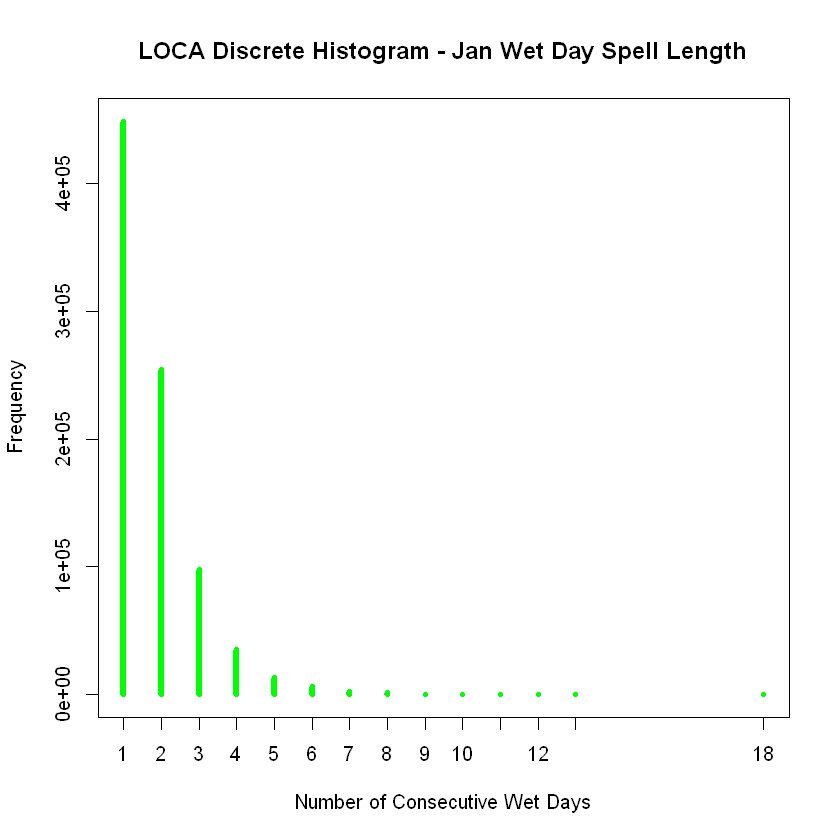

In [95]:
# our case is discrete so use this command
plot( table( dLOJan$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jan Wet Day Spell Length", 
      col="green" )

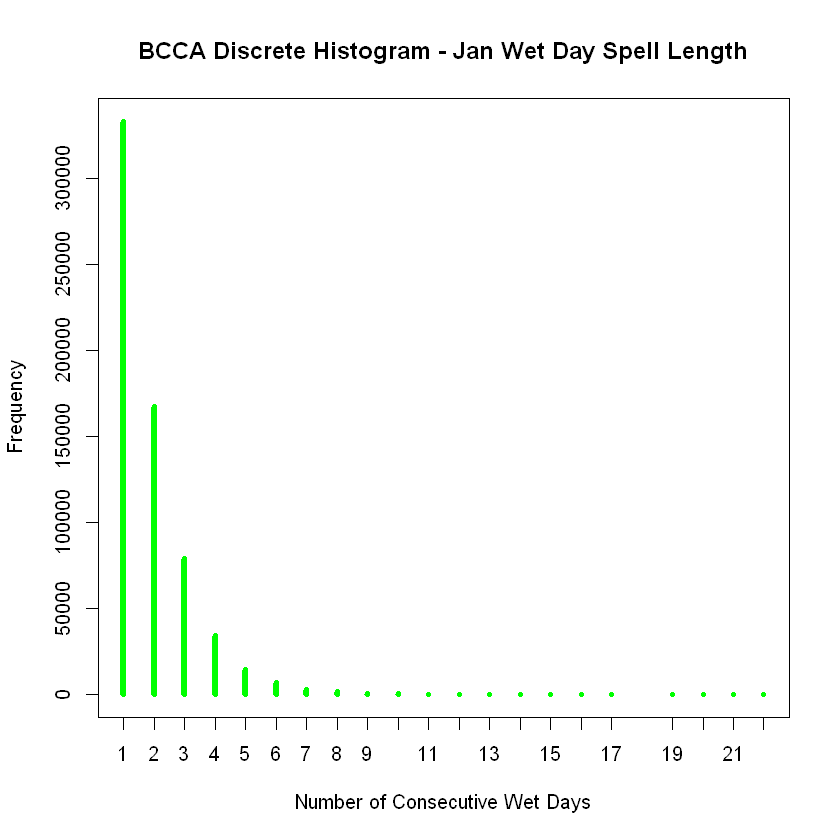

In [96]:
plot( table( dBCJan$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jan Wet Day Spell Length", 
      col="green" )

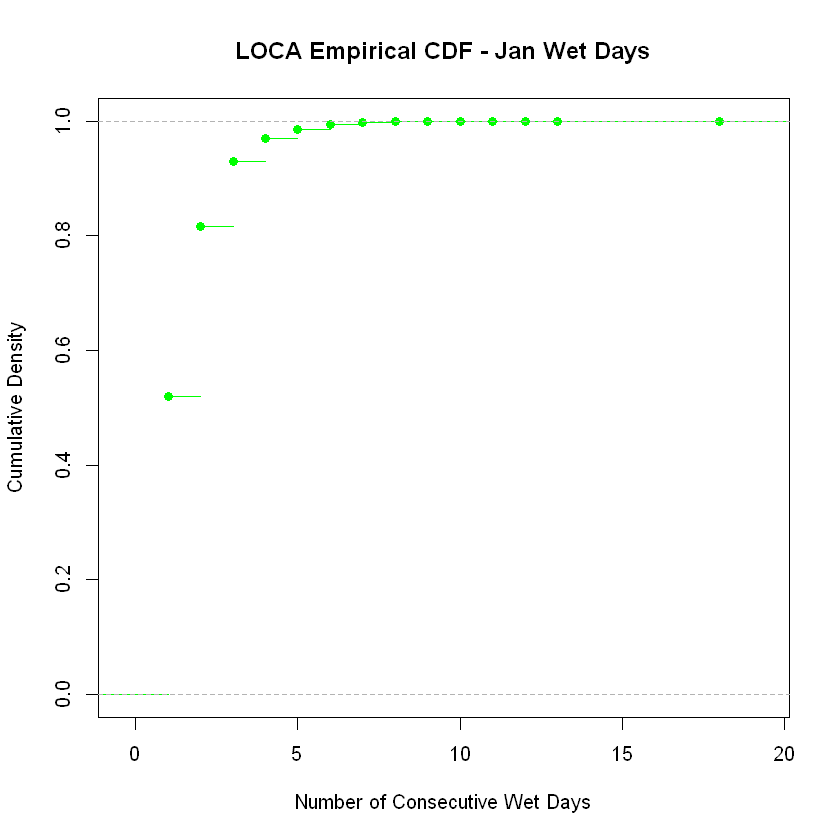

In [97]:
plot(ecdf(dLOJan$Wet_Count), main="LOCA Empirical CDF - Jan Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

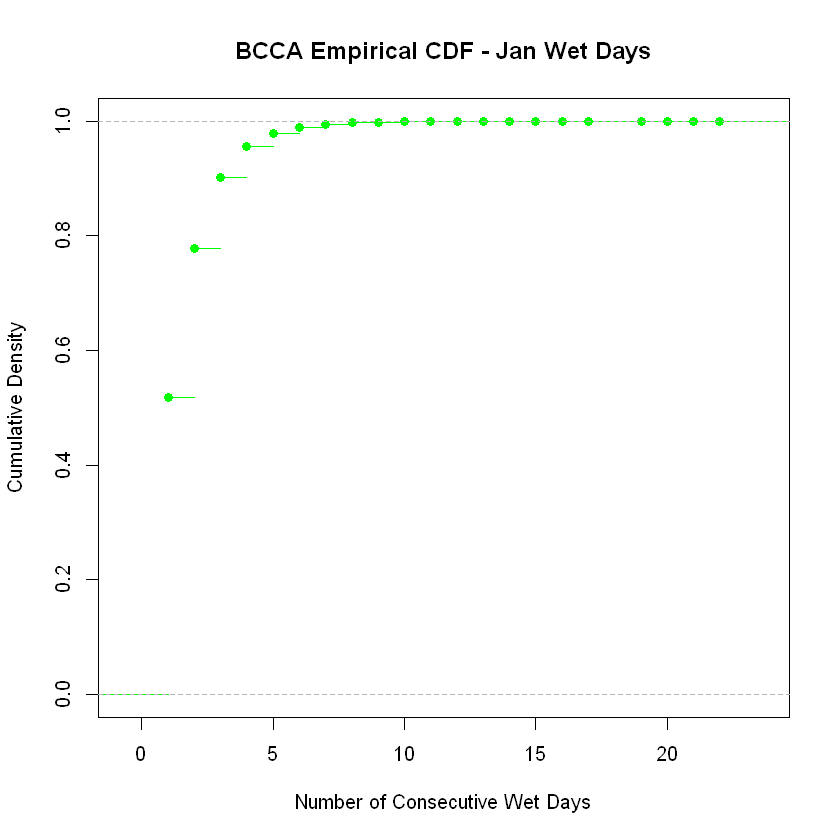

In [98]:
plot(ecdf(dBCJan$Wet_Count), main="BCCA Empirical CDF - Jan Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

In [99]:
dLOJanMax <- max( dLOJan$Wet_Count )
dLOJanMean <- mean( dLOJan$Wet_Count )
dLOJanVar <- var( dLOJan$Wet_Count )
dLOJanBNr <- dLOJanMean^2 / abs(dLOJanVar - dLOJanMean)
dLOJanTstNB <- rnbinom( 1000, mu=dLOJanMean, size=dLOJanBNr )

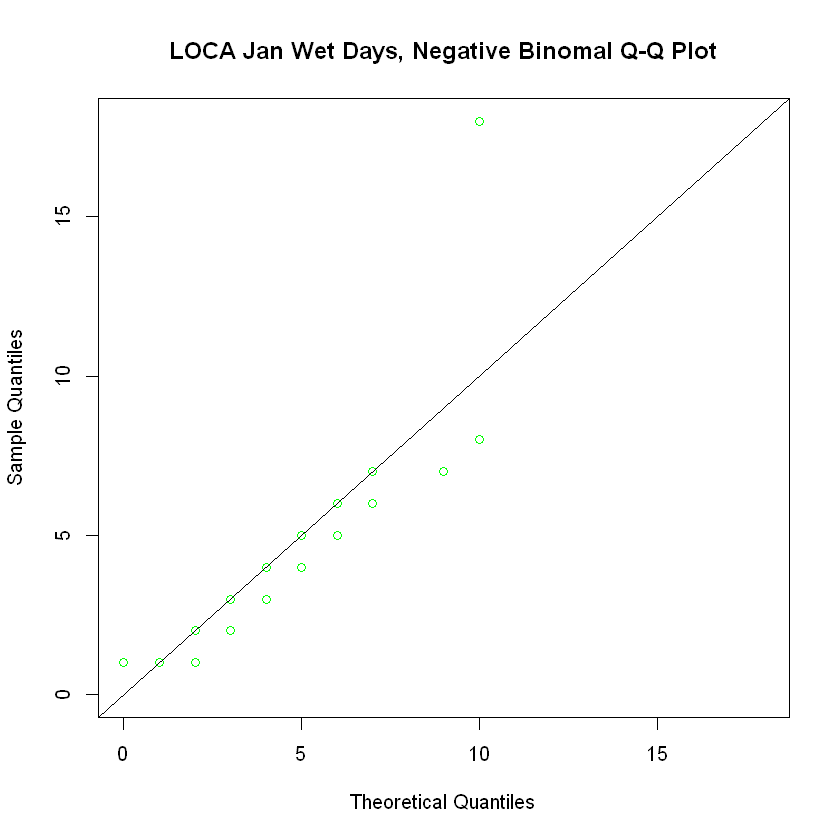

In [100]:
qqplot( dLOJanTstNB, dLOJan$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jan Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJanMax), ylim=c(0,dLOJanMax) )
abline( 0, 1)

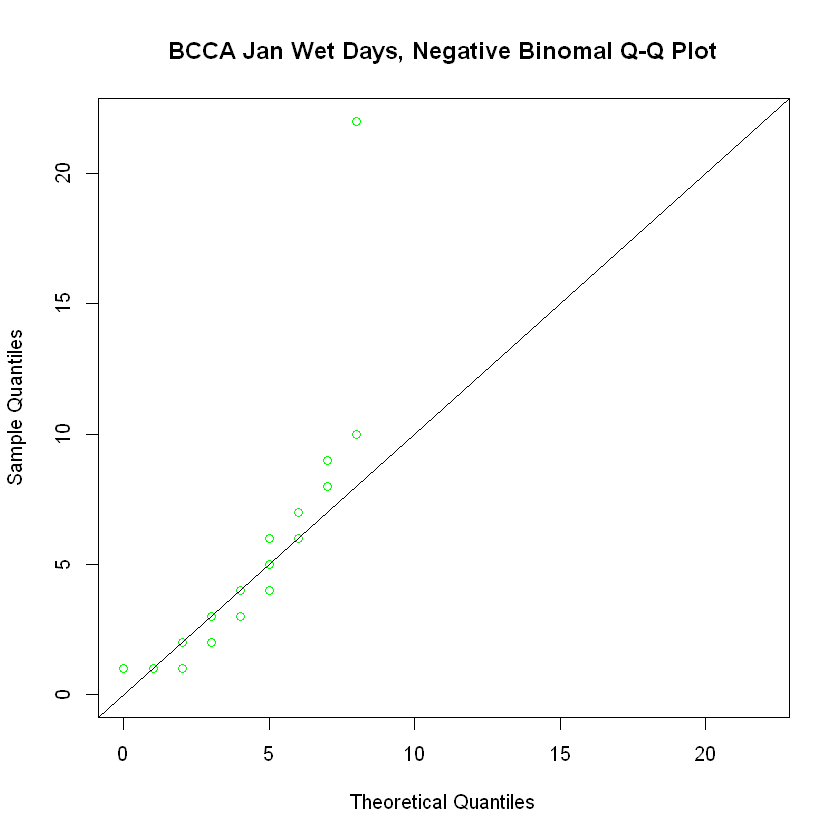

In [101]:
dBCJanMax <- max( dBCJan$Wet_Count )
dBCJanMean <- mean( dBCJan$Wet_Count )
dBCJanVar <- var( dBCJan$Wet_Count )
dBCJanBNr <- dBCJanMean^2 / abs(dBCJanVar - dBCJanMean)
dBCJanTstNB <- rnbinom( 1000, mu=dBCJanMean, size=dBCJanBNr )
qqplot( dBCJanTstNB, dBCJan$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jan Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJanMax), ylim=c(0,dBCJanMax) )
abline( 0, 1)

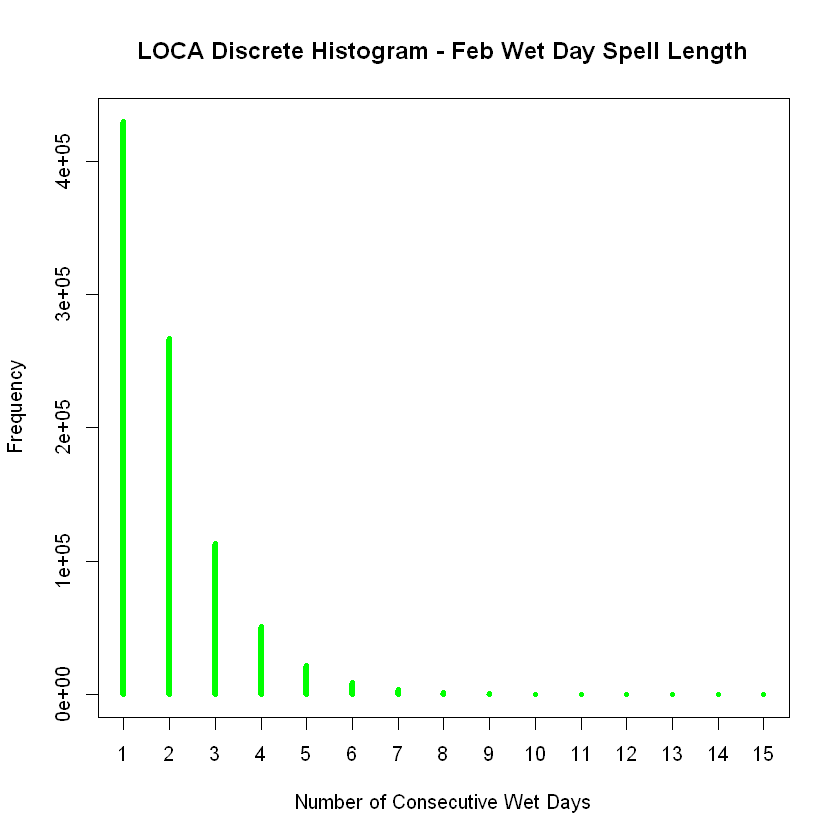

In [102]:
# our case is discrete so use this command
plot( table( dLOFeb$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Feb Wet Day Spell Length", 
      col="green" )

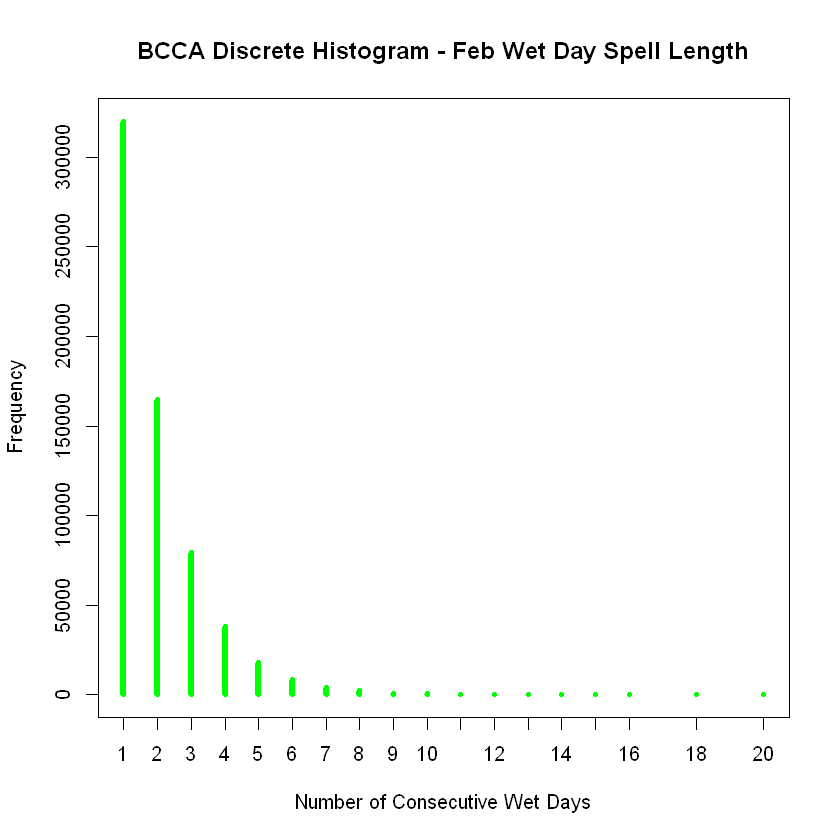

In [103]:
plot( table( dBCFeb$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Feb Wet Day Spell Length", 
      col="green" )

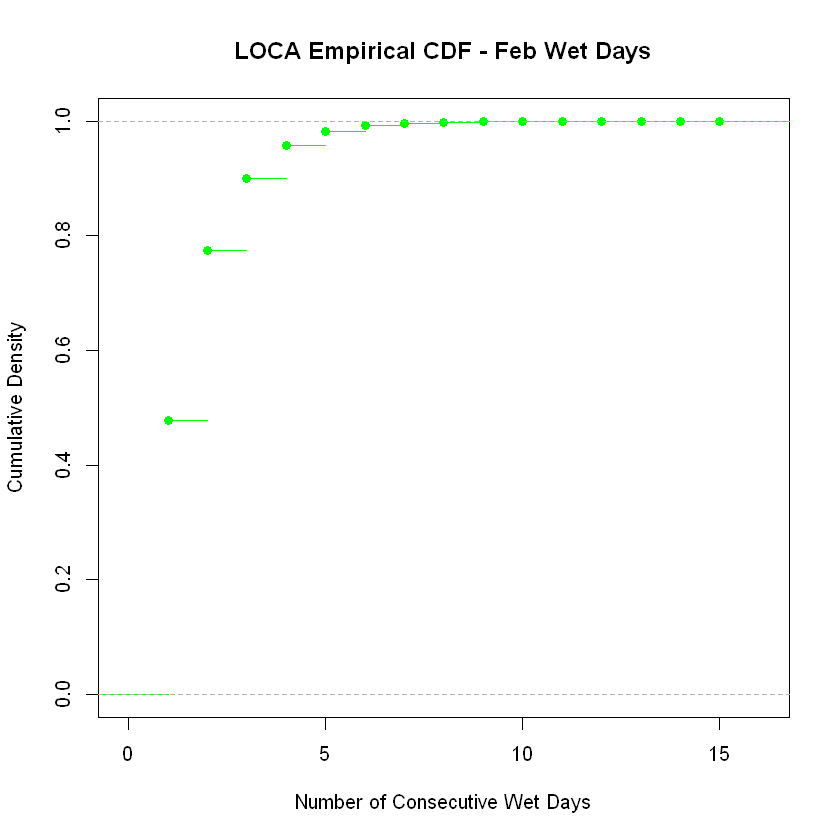

In [104]:
plot(ecdf(dLOFeb$Wet_Count), main="LOCA Empirical CDF - Feb Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

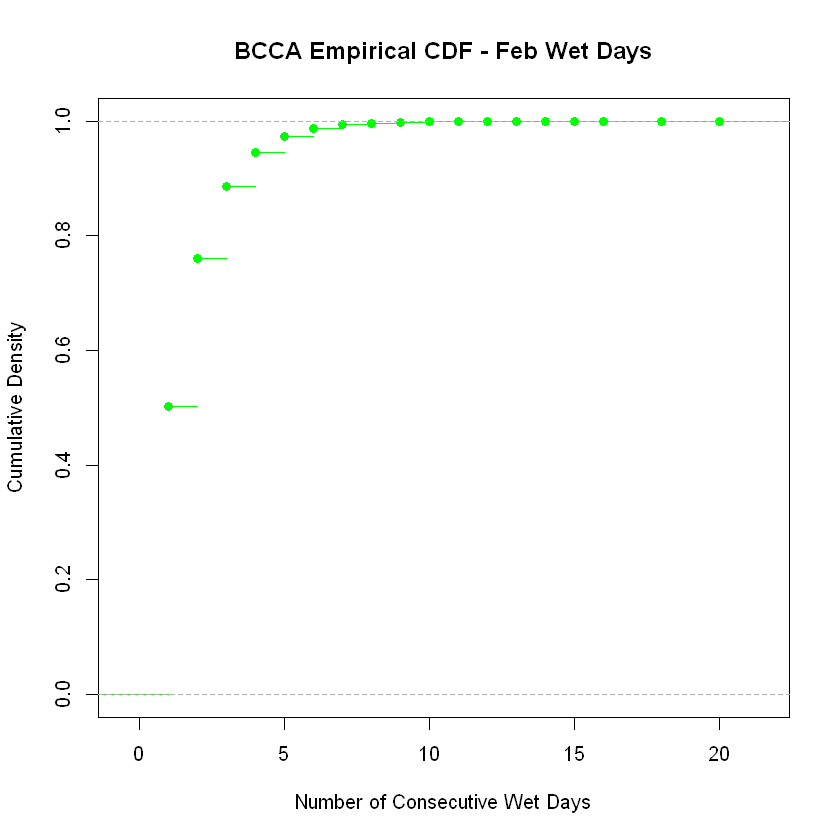

In [105]:
plot(ecdf(dBCFeb$Wet_Count), main="BCCA Empirical CDF - Feb Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

In [106]:
#dLOFeb$Wet_Count

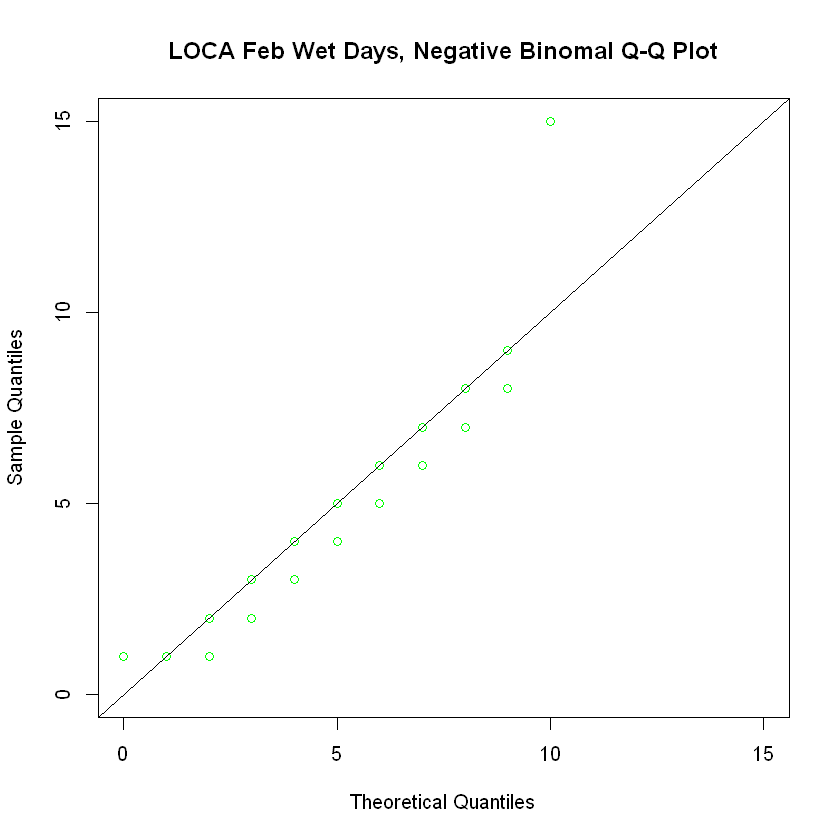

In [107]:
dLOFebMax <- max( dLOFeb$Wet_Count )
dLOFebMean <- mean( dLOFeb$Wet_Count )
dLOFebVar <- var( dLOFeb$Wet_Count )
dLOFebBNr <- dLOFebMean^2 / abs(dLOFebVar - dLOFebMean)
dLOFebTstNB <- rnbinom( 1000, mu=dLOFebMean, size=dLOFebBNr )
qqplot( dLOFebTstNB, dLOFeb$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Feb Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOFebMax), ylim=c(0,dLOFebMax) )
abline( 0, 1)

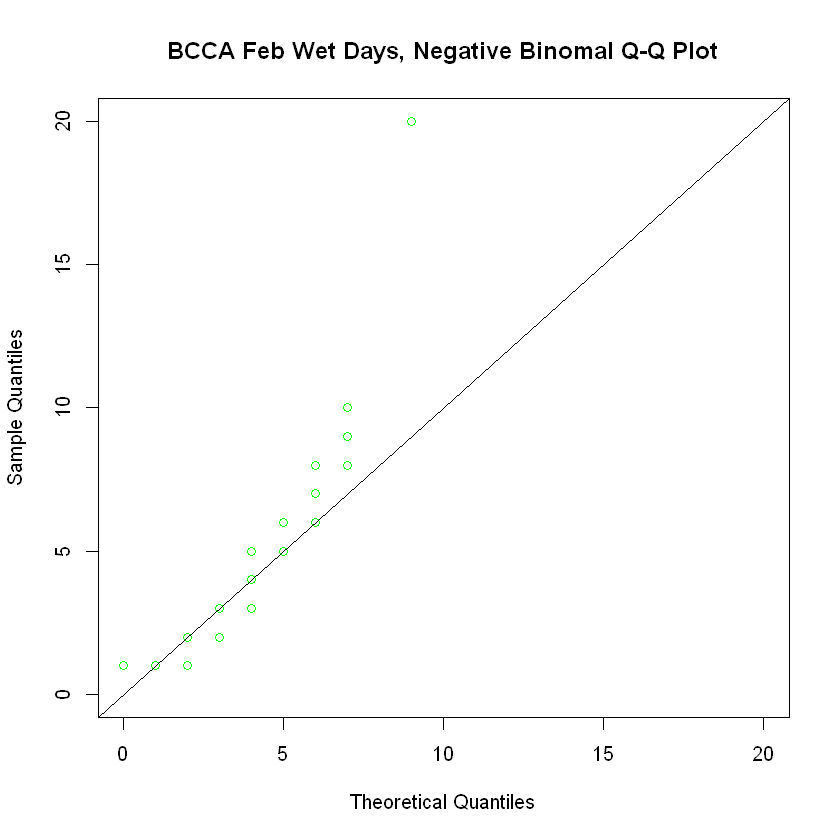

In [108]:
dBCFebMax <- max( dBCFeb$Wet_Count )
dBCFebMean <- mean( dBCFeb$Wet_Count )
dBCFebVar <- var( dBCFeb$Wet_Count )
dBCFebBNr <- dBCFebMean^2 / abs(dBCFebVar - dBCFebMean)
dBCFebTstNB <- rnbinom( 1000, mu=dBCFebMean, size=dBCFebBNr )
qqplot( dBCFebTstNB, dBCFeb$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Feb Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCFebMax), ylim=c(0,dBCFebMax) )
abline( 0, 1)

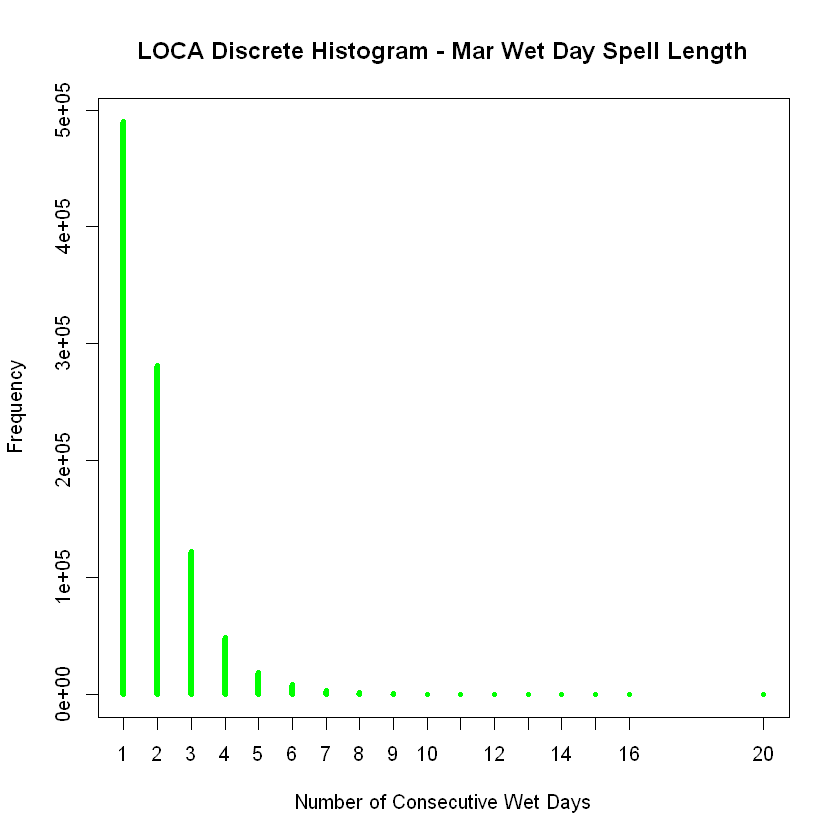

In [109]:
# our case is discrete so use this command
plot( table( dLOMar$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Mar Wet Day Spell Length", 
      col="green" )

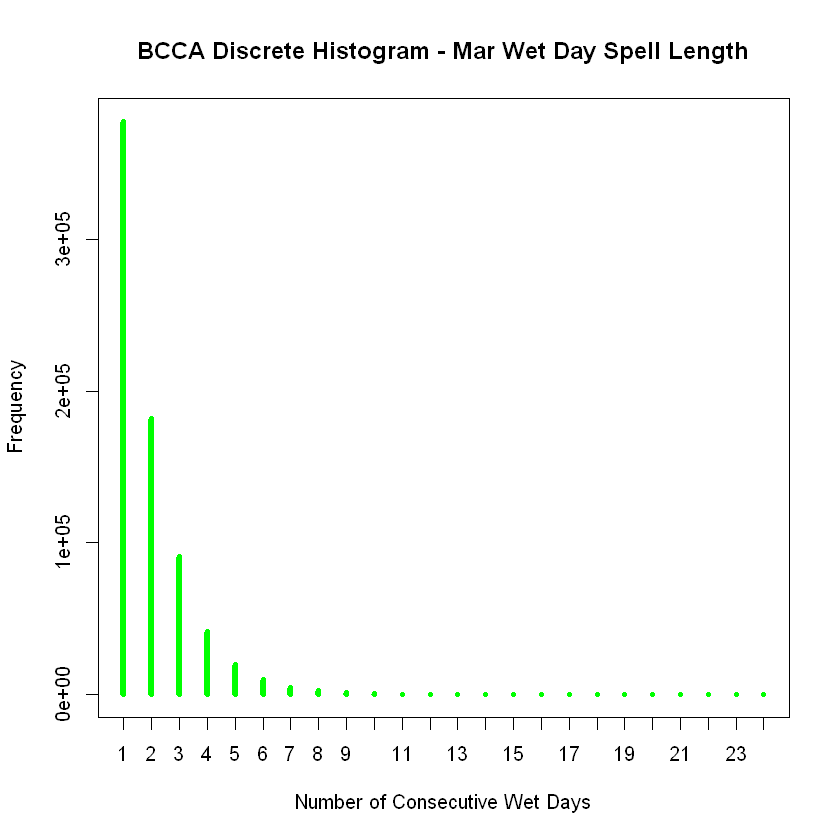

In [110]:
plot( table( dBCMar$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Mar Wet Day Spell Length", 
      col="green" )

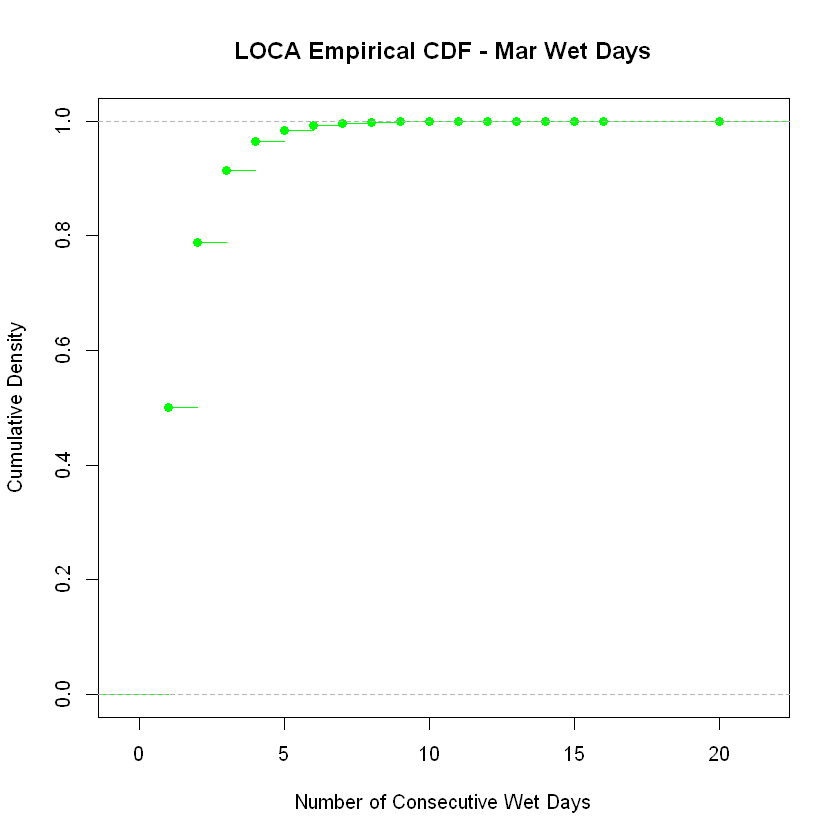

In [111]:
plot(ecdf(dLOMar$Wet_Count), main="LOCA Empirical CDF - Mar Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

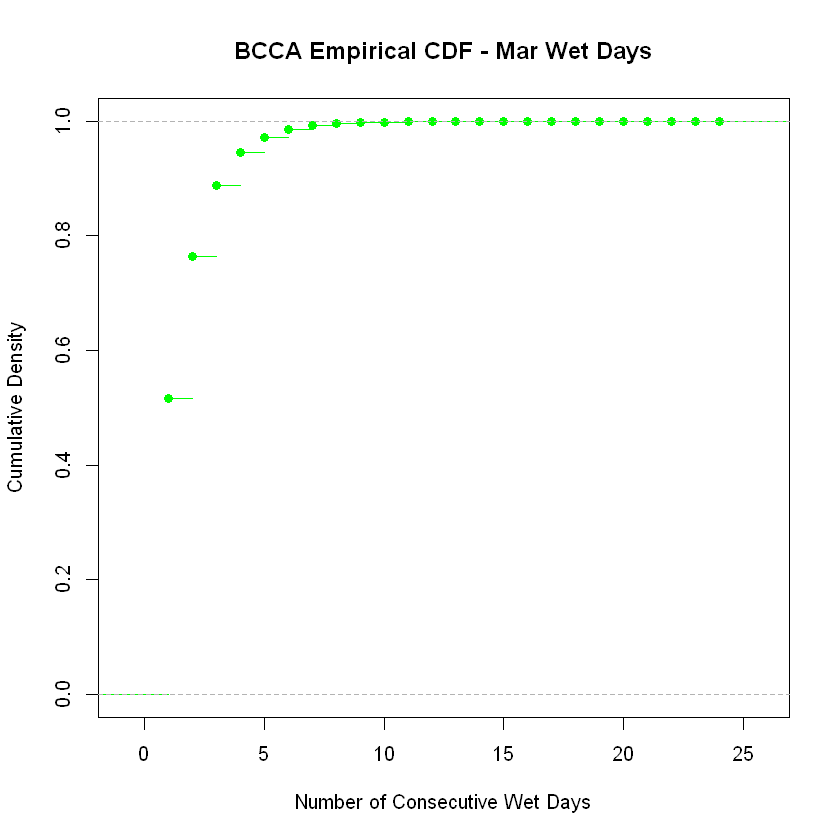

In [112]:
plot(ecdf(dBCMar$Wet_Count), main="BCCA Empirical CDF - Mar Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

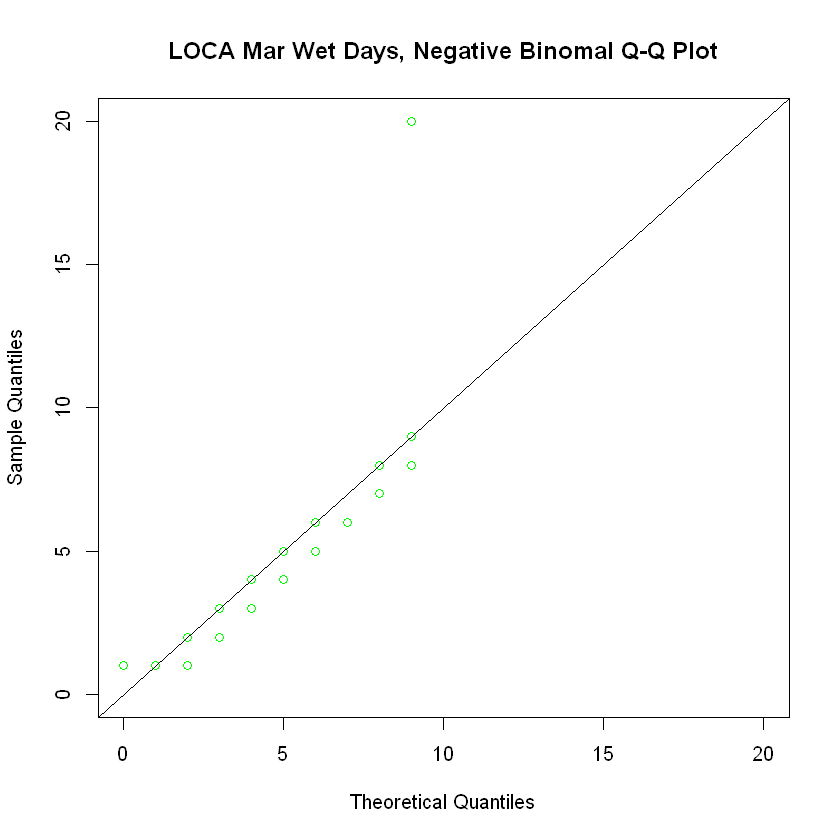

In [113]:
dLOMarMax <- max( dLOMar$Wet_Count )
dLOMarMean <- mean( dLOMar$Wet_Count )
dLOMarVar <- var( dLOMar$Wet_Count )
dLOMarBNr <- dLOMarMean^2 / abs(dLOMarVar - dLOMarMean)
dLOMarTstNB <- rnbinom( 1000, mu=dLOMarMean, size=dLOMarBNr )
qqplot( dLOMarTstNB, dLOMar$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Mar Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOMarMax), ylim=c(0,dLOMarMax) )
abline( 0, 1)

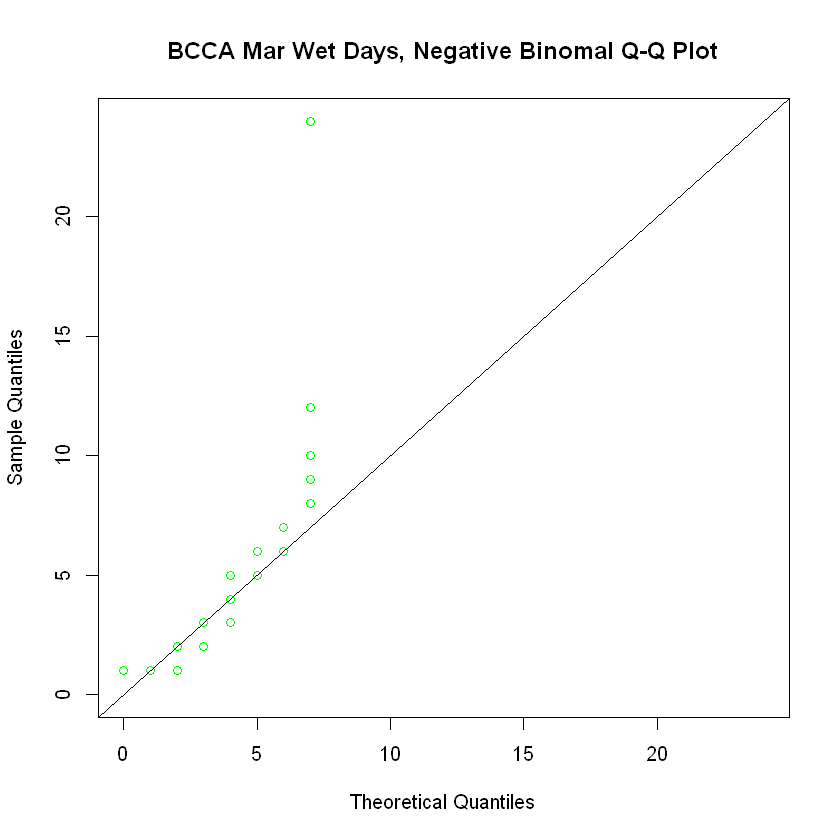

In [114]:
dBCMarMax <- max( dBCMar$Wet_Count )
dBCMarMean <- mean( dBCMar$Wet_Count )
dBCMarVar <- var( dBCMar$Wet_Count )
dBCMarBNr <- dBCMarMean^2 / abs(dBCMarVar - dBCMarMean)
dBCMarTstNB <- rnbinom( 1000, mu=dBCMarMean, size=dBCMarBNr )
qqplot( dBCMarTstNB, dBCMar$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Mar Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCMarMax), ylim=c(0,dBCMarMax) )
abline( 0, 1)

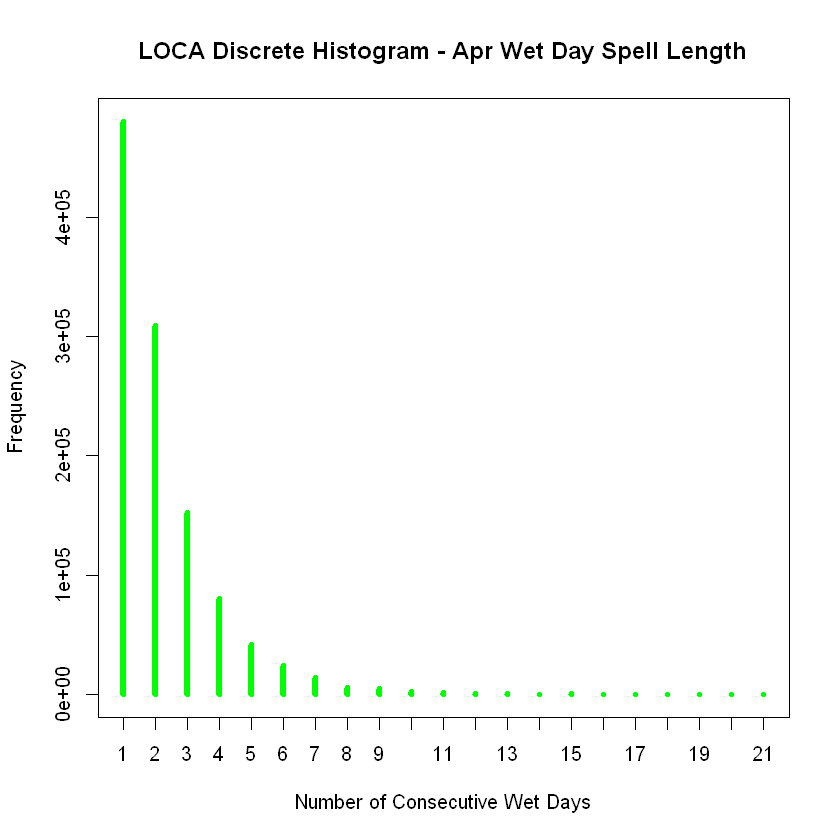

In [115]:
# our case is discrete so use this command
plot( table( dLOApr$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Apr Wet Day Spell Length", 
      col="green" )

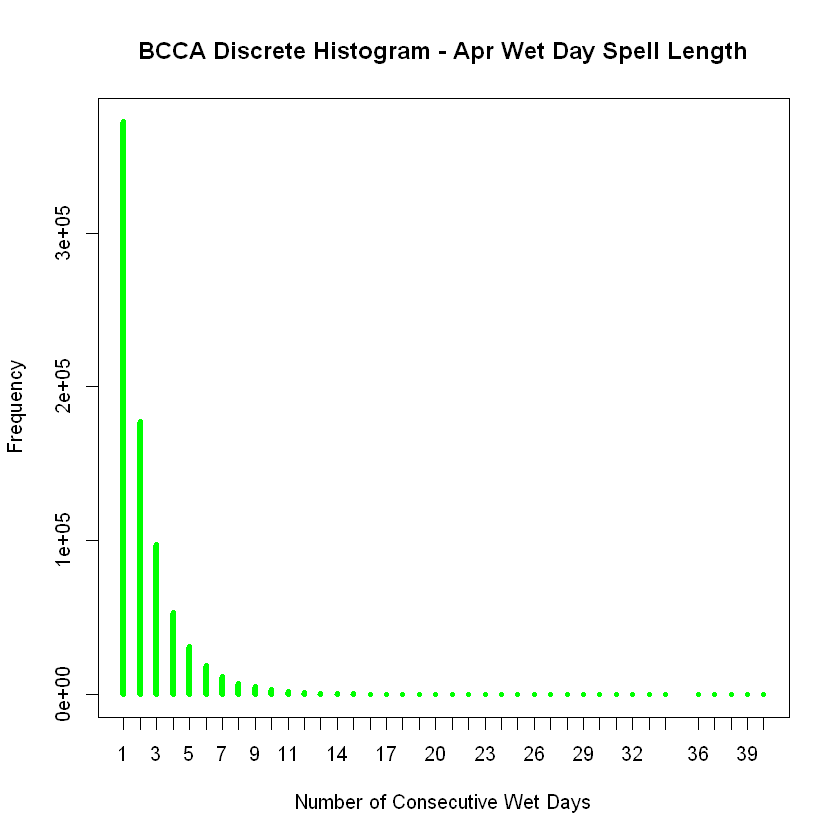

In [116]:
plot( table( dBCApr$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Apr Wet Day Spell Length", 
      col="green" )

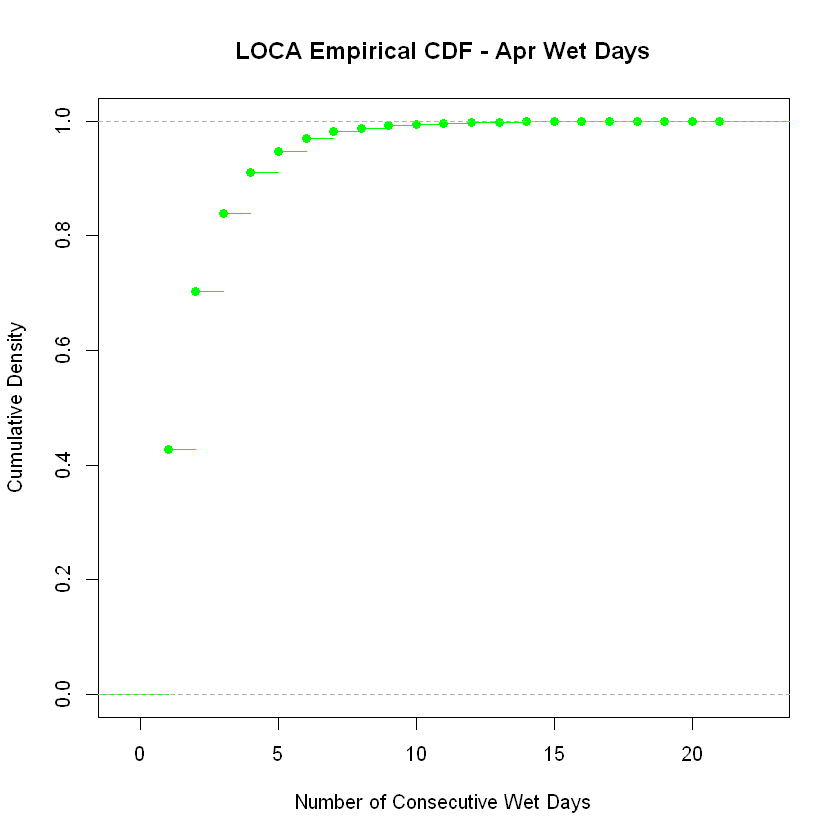

In [117]:
plot(ecdf(dLOApr$Wet_Count), main="LOCA Empirical CDF - Apr Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

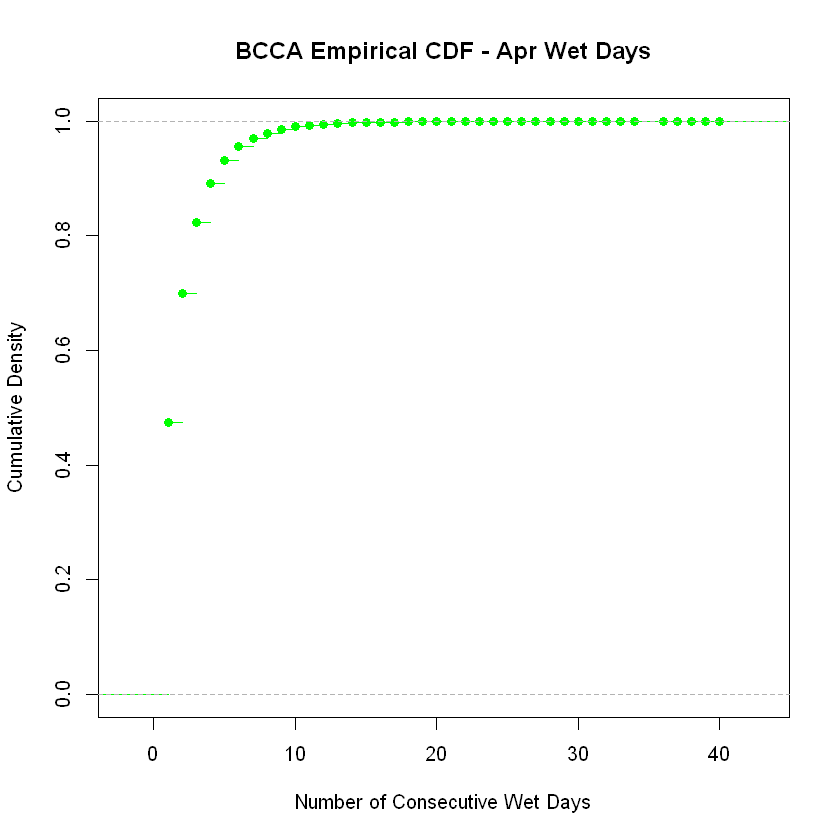

In [118]:
plot(ecdf(dBCApr$Wet_Count), main="BCCA Empirical CDF - Apr Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

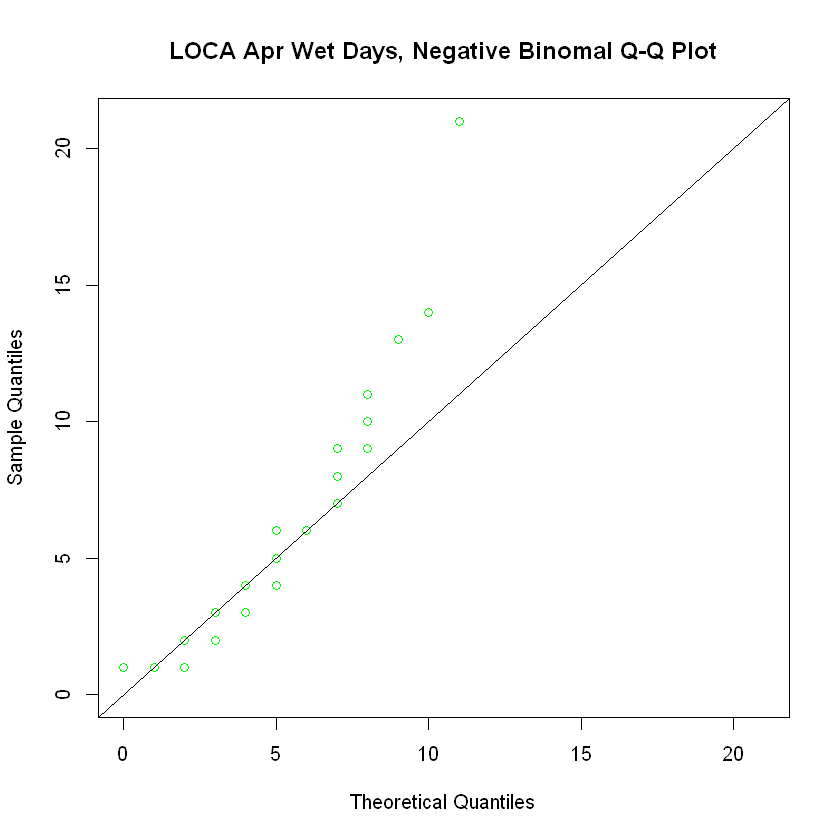

In [119]:
dLOAprMax <- max( dLOApr$Wet_Count )
dLOAprMean <- mean( dLOApr$Wet_Count )
dLOAprVar <- var( dLOApr$Wet_Count )
dLOAprBNr <- dLOAprMean^2 / abs(dLOAprVar - dLOAprMean)
dLOAprTstNB <- rnbinom( 1000, mu=dLOAprMean, size=dLOAprBNr )
qqplot( dLOAprTstNB, dLOApr$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Apr Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOAprMax), ylim=c(0,dLOAprMax) )
abline( 0, 1)

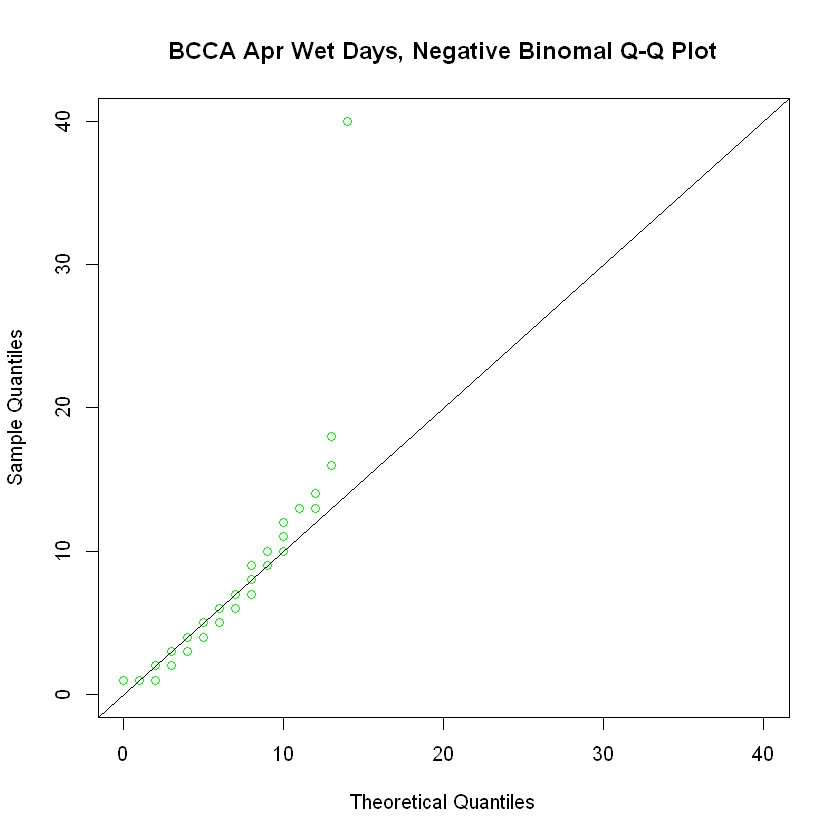

In [120]:
dBCAprMax <- max( dBCApr$Wet_Count )
dBCAprMean <- mean( dBCApr$Wet_Count )
dBCAprVar <- var( dBCApr$Wet_Count )
dBCAprBNr <- dBCAprMean^2 / abs(dBCAprVar - dBCAprMean)
dBCAprTstNB <- rnbinom( 1000, mu=dBCAprMean, size=dBCAprBNr )
qqplot( dBCAprTstNB, dBCApr$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Apr Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCAprMax), ylim=c(0,dBCAprMax) )
abline( 0, 1)

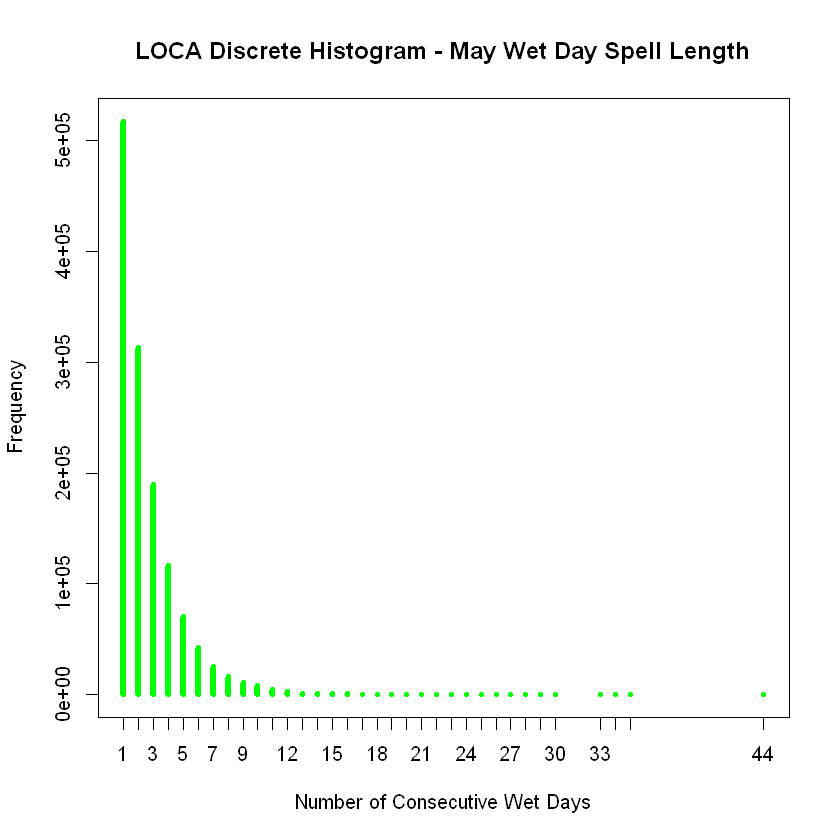

In [121]:
# our case is discrete so use this command
plot( table( dLOMay$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - May Wet Day Spell Length", 
      col="green" )

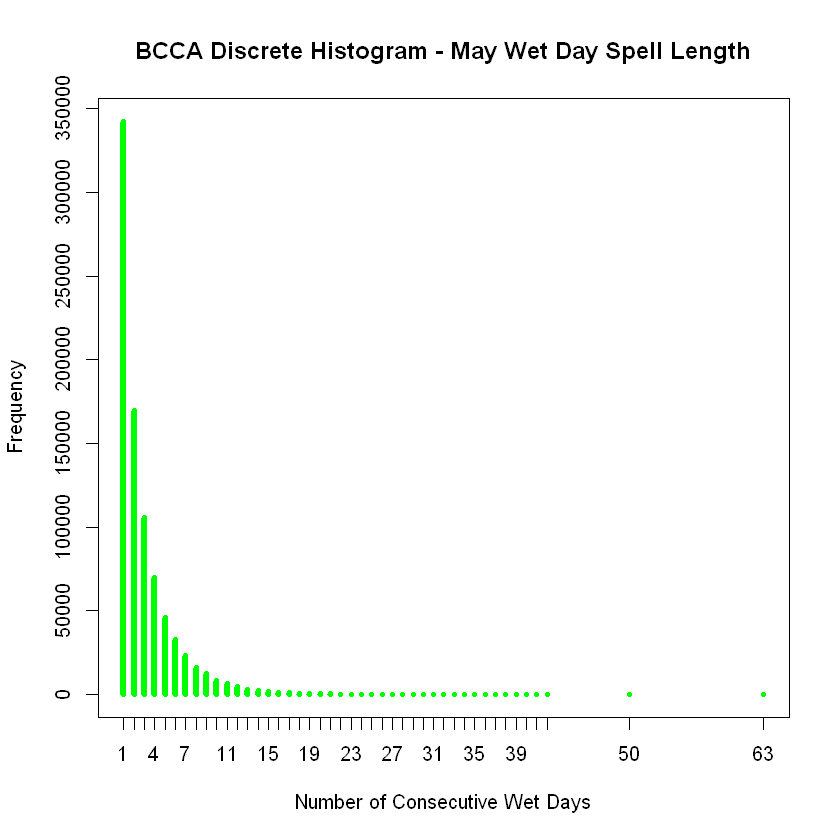

In [122]:
plot( table( dBCMay$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - May Wet Day Spell Length", 
      col="green" )

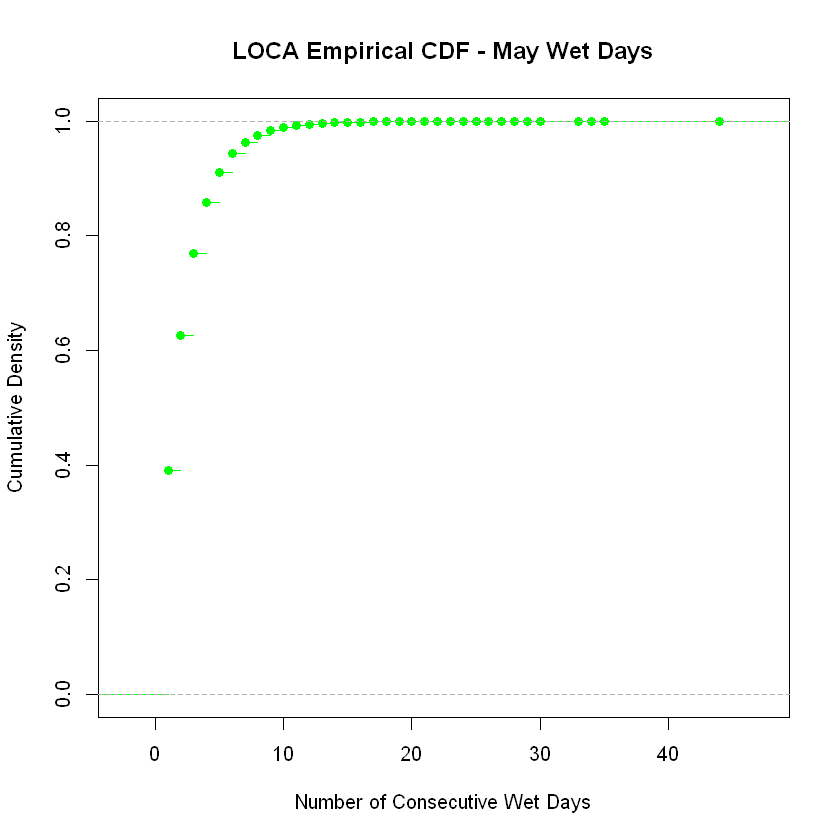

In [123]:
plot(ecdf(dLOMay$Wet_Count), main="LOCA Empirical CDF - May Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

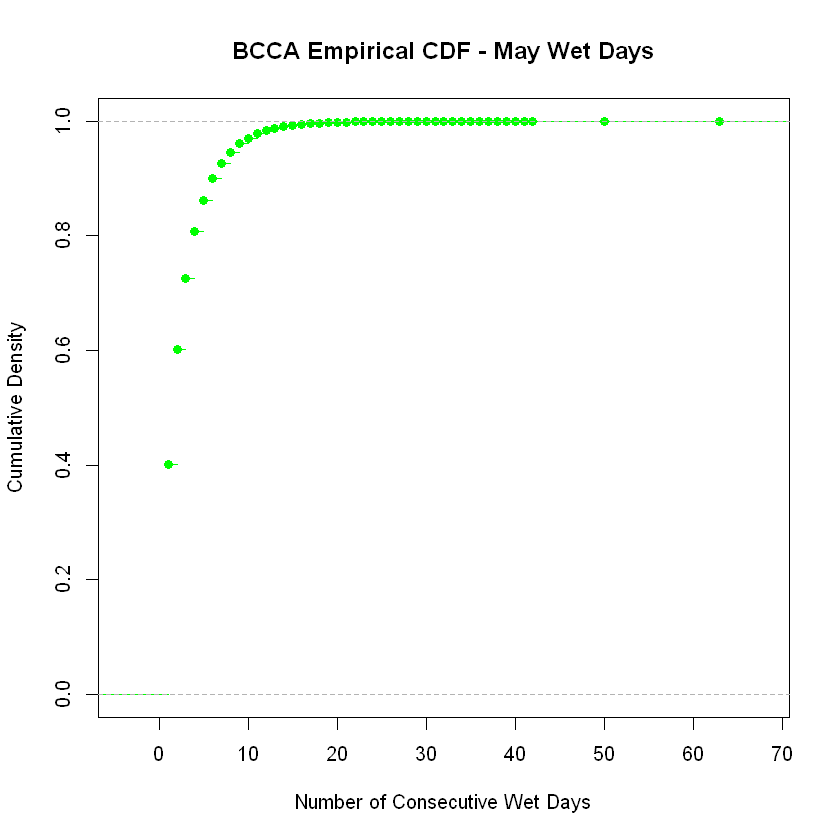

In [124]:
plot(ecdf(dBCMay$Wet_Count), main="BCCA Empirical CDF - May Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

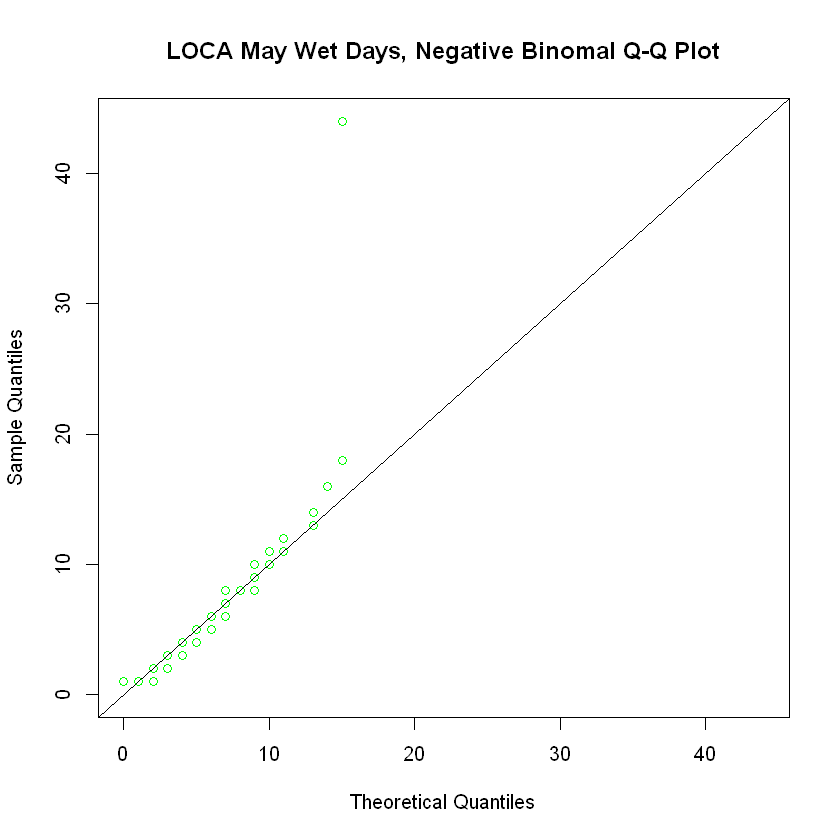

In [125]:
dLOMayMax <- max( dLOMay$Wet_Count )
dLOMayMean <- mean( dLOMay$Wet_Count )
dLOMayVar <- var( dLOMay$Wet_Count )
dLOMayBNr <- dLOMayMean^2 / abs(dLOMayVar - dLOMayMean)
dLOMayTstNB <- rnbinom( 1000, mu=dLOMayMean, size=dLOMayBNr )
qqplot( dLOMayTstNB, dLOMay$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA May Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOMayMax), ylim=c(0,dLOMayMax) )
abline( 0, 1)

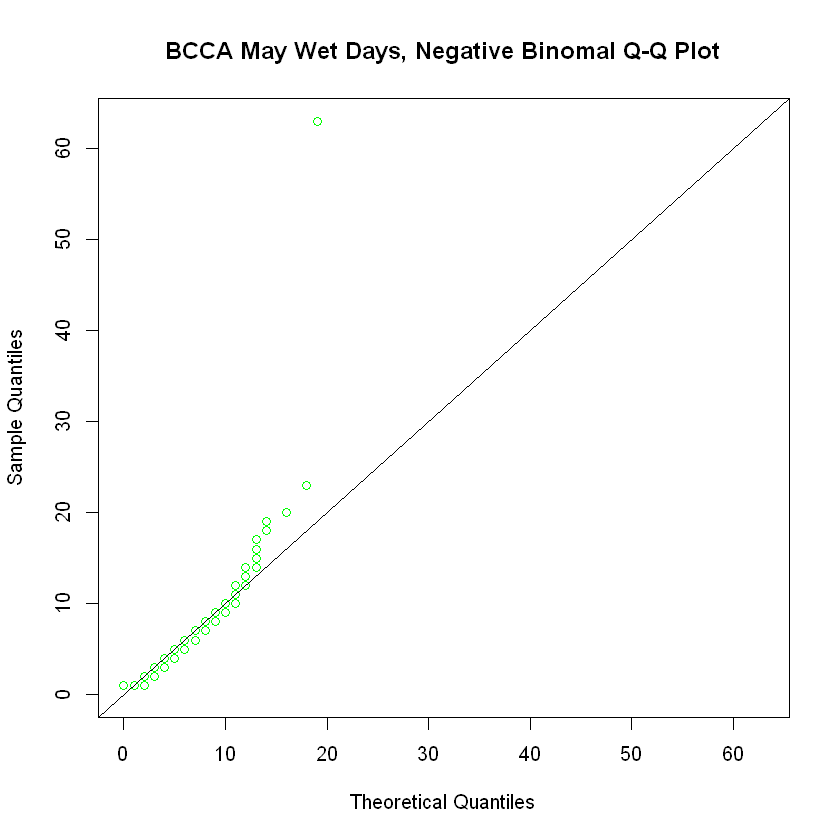

In [126]:
dBCMayMax <- max( dBCMay$Wet_Count )
dBCMayMean <- mean( dBCMay$Wet_Count )
dBCMayVar <- var( dBCMay$Wet_Count )
dBCMayBNr <- dBCMayMean^2 / abs(dBCMayVar - dBCMayMean)
dBCMayTstNB <- rnbinom( 1000, mu=dBCMayMean, size=dBCMayBNr )
qqplot( dBCMayTstNB, dBCMay$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA May Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCMayMax), ylim=c(0,dBCMayMax) )
abline( 0, 1)

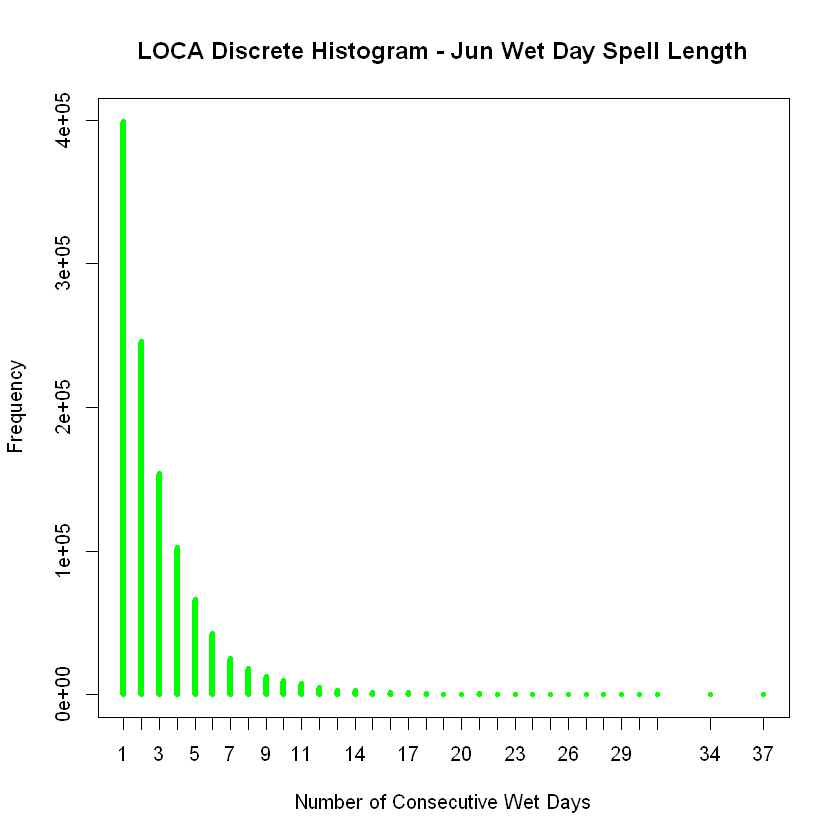

In [127]:
# our case is discrete so use this command
plot( table( dLOJun$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jun Wet Day Spell Length", 
      col="green" )

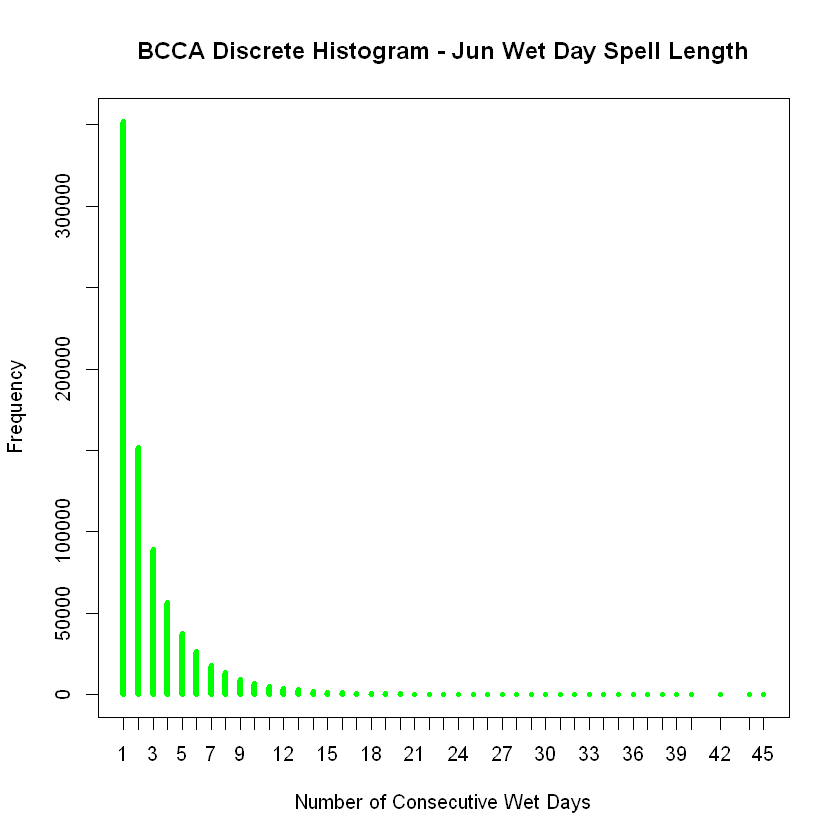

In [128]:
plot( table( dBCJun$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jun Wet Day Spell Length", 
      col="green" )

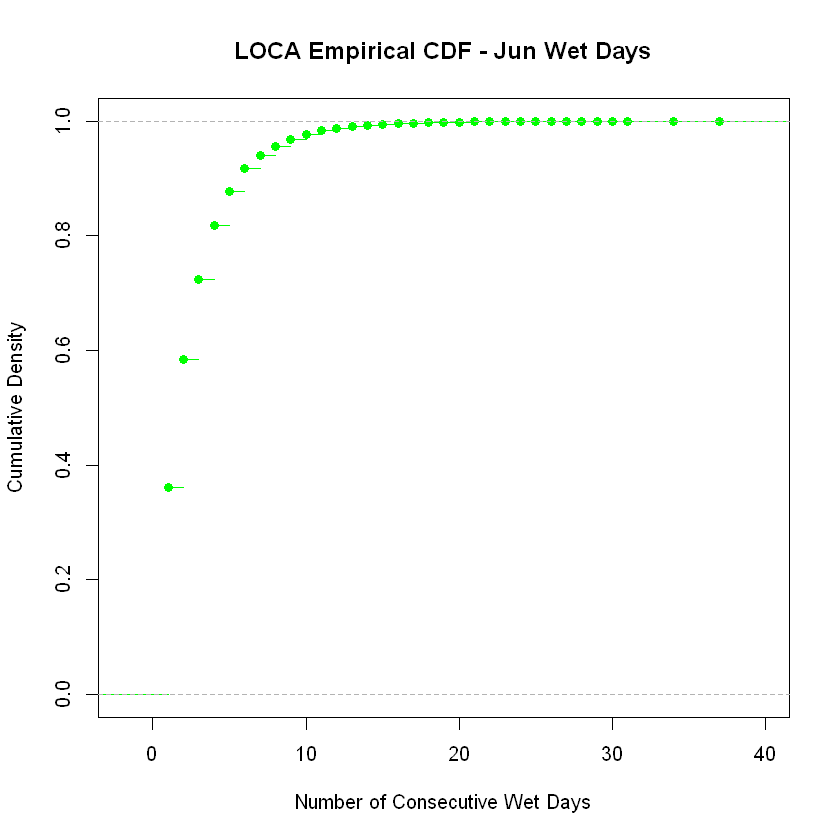

In [129]:
plot(ecdf(dLOJun$Wet_Count), main="LOCA Empirical CDF - Jun Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

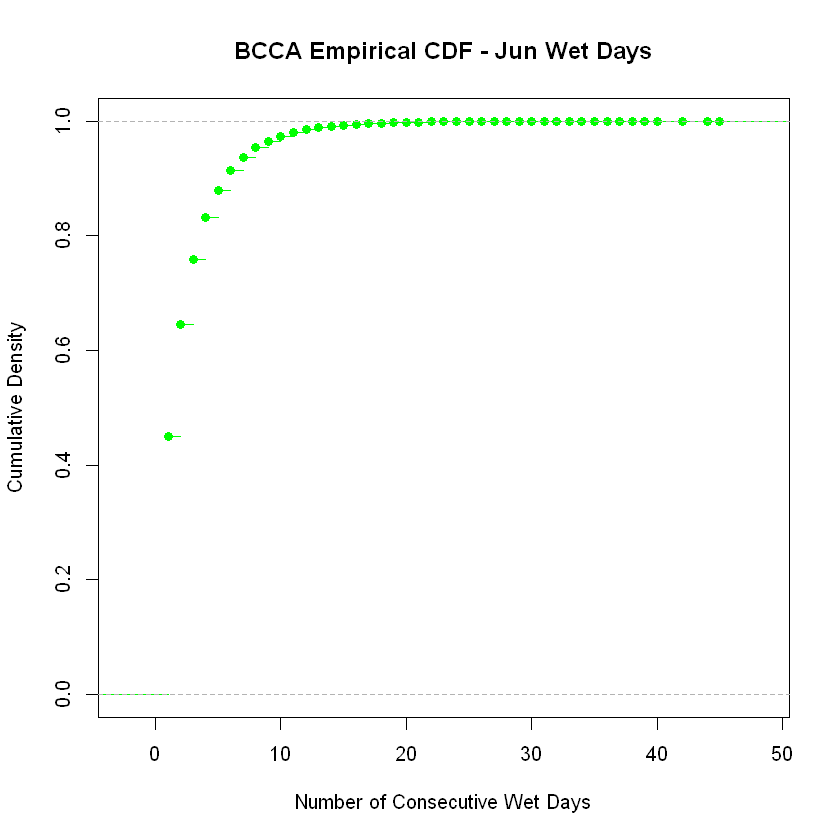

In [130]:
plot(ecdf(dBCJun$Wet_Count), main="BCCA Empirical CDF - Jun Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

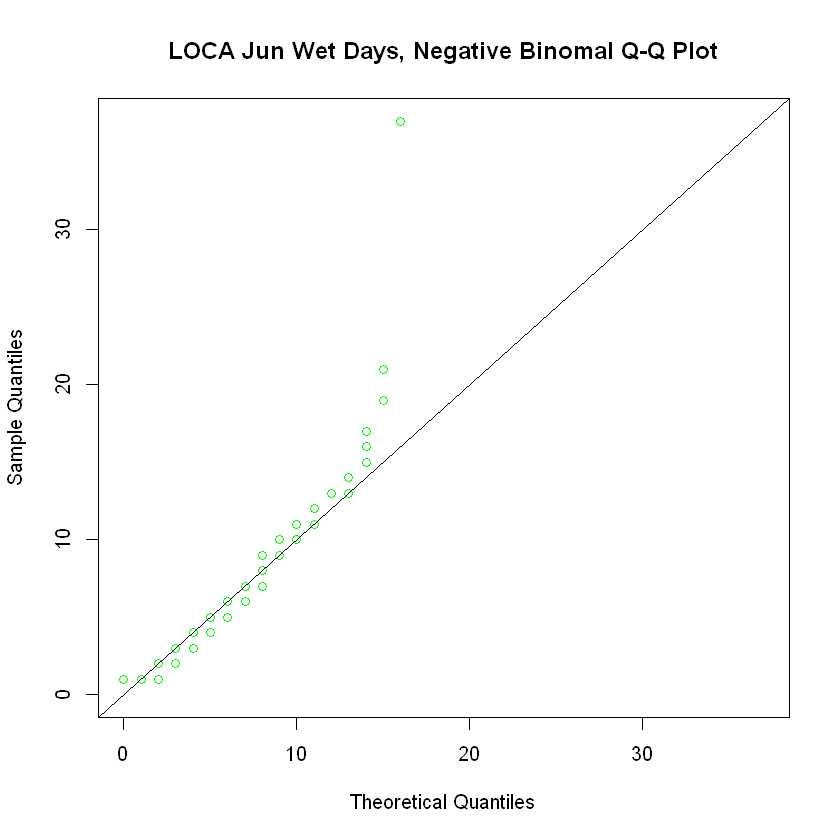

In [131]:
dLOJunMax <- max( dLOJun$Wet_Count )
dLOJunMean <- mean( dLOJun$Wet_Count )
dLOJunVar <- var( dLOJun$Wet_Count )
dLOJunBNr <- dLOJunMean^2 / abs(dLOJunVar - dLOJunMean)
dLOJunTstNB <- rnbinom( 1000, mu=dLOJunMean, size=dLOJunBNr )
qqplot( dLOJunTstNB, dLOJun$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jun Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJunMax), ylim=c(0,dLOJunMax) )
abline( 0, 1)

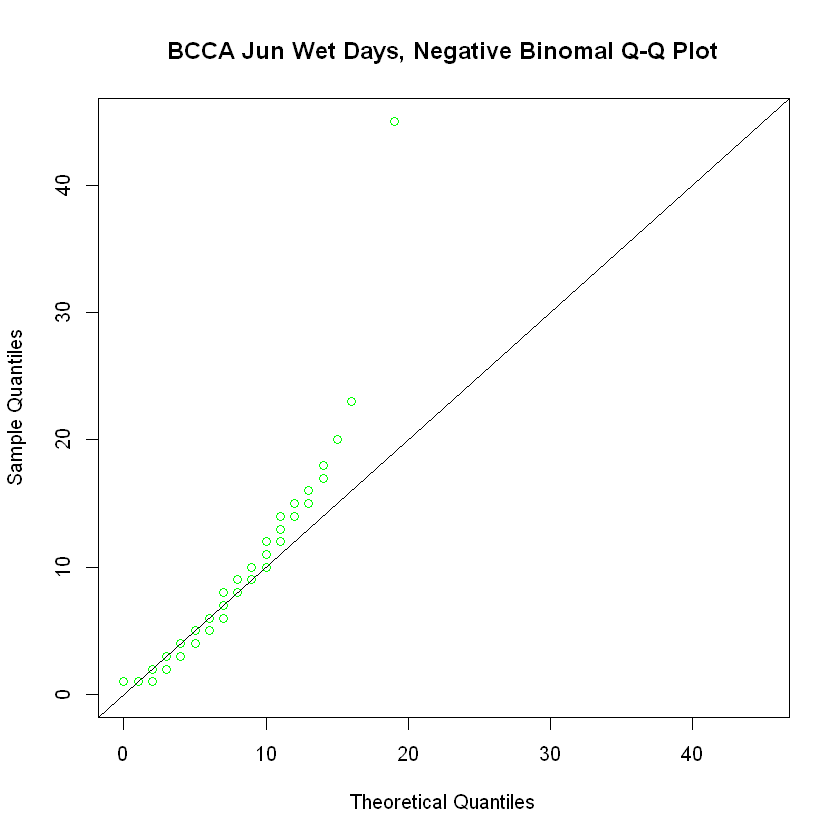

In [132]:
dBCJunMax <- max( dBCJun$Wet_Count )
dBCJunMean <- mean( dBCJun$Wet_Count )
dBCJunVar <- var( dBCJun$Wet_Count )
dBCJunBNr <- dBCJunMean^2 / abs(dBCJunVar - dBCJunMean)
dBCJunTstNB <- rnbinom( 1000, mu=dBCJunMean, size=dBCJunBNr )
qqplot( dBCJunTstNB, dBCJun$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jun Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJunMax), ylim=c(0,dBCJunMax) )
abline( 0, 1)

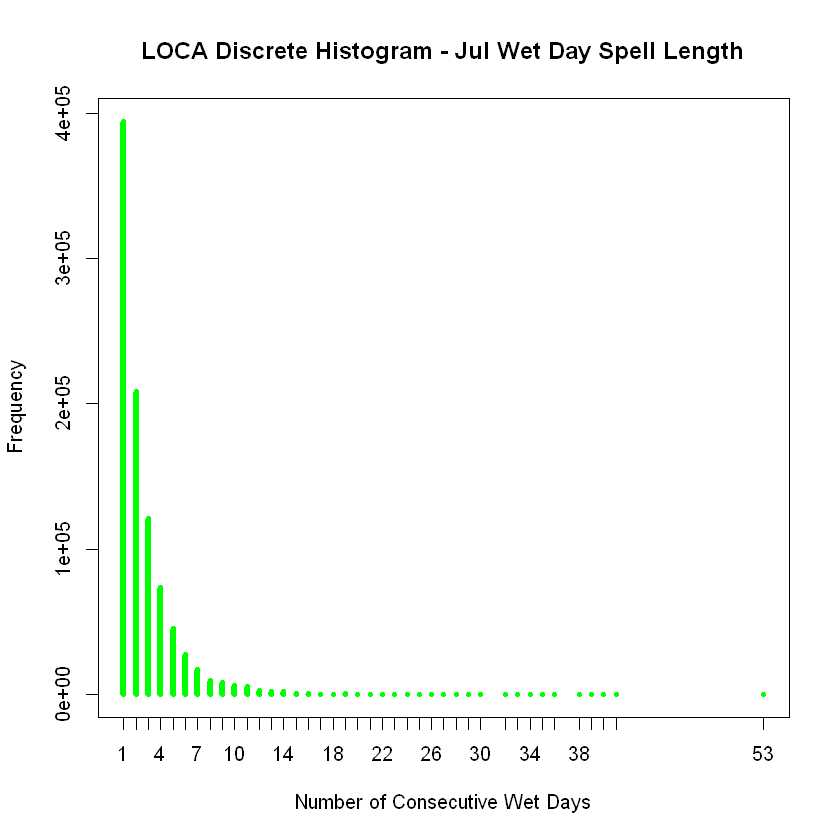

In [133]:
# our case is discrete so use this command
plot( table( dLOJul$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jul Wet Day Spell Length", 
      col="green" )

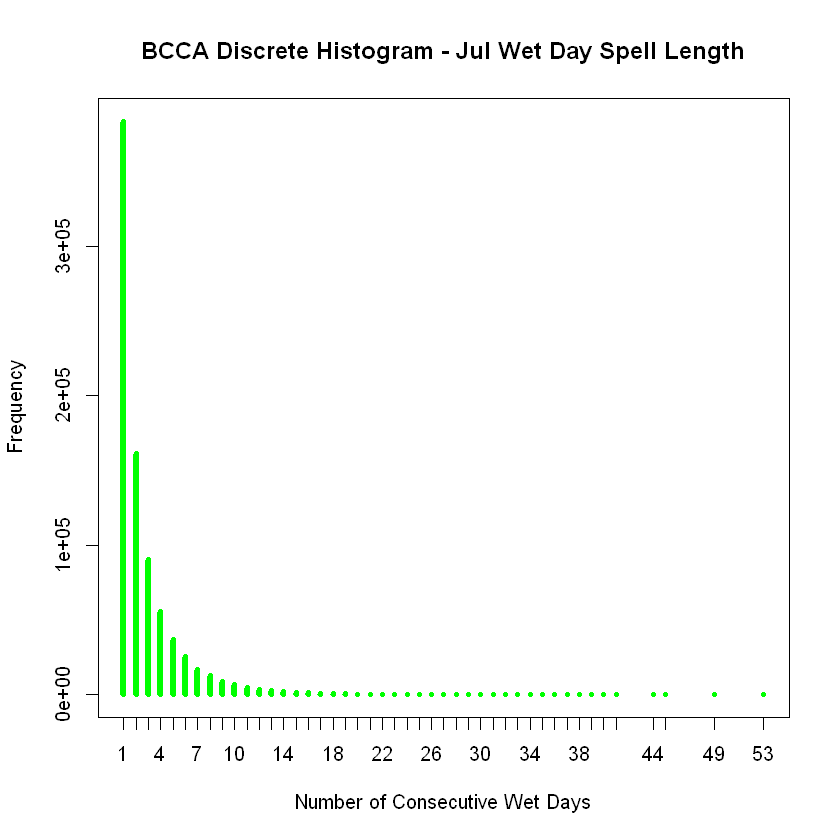

In [134]:
plot( table( dBCJul$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jul Wet Day Spell Length", 
      col="green" )

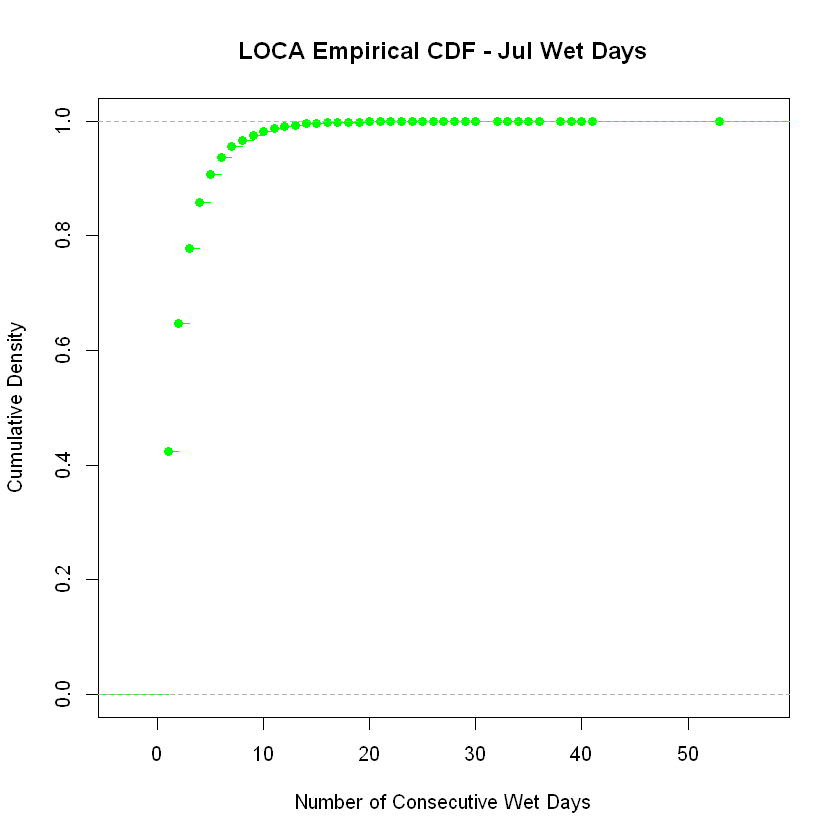

In [135]:
plot(ecdf(dLOJul$Wet_Count), main="LOCA Empirical CDF - Jul Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

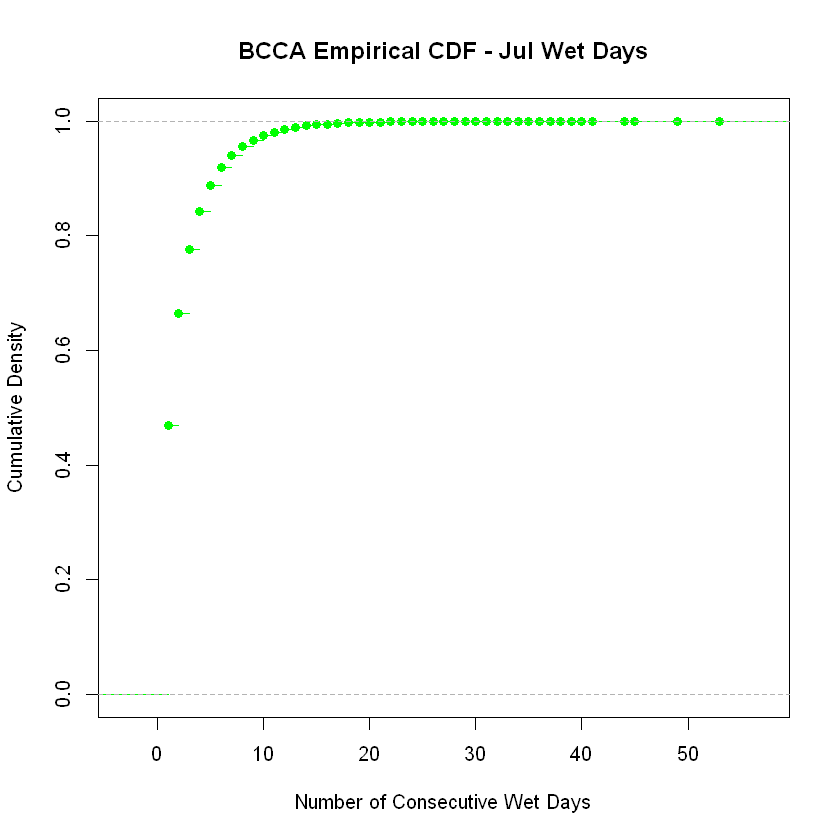

In [136]:
plot(ecdf(dBCJul$Wet_Count), main="BCCA Empirical CDF - Jul Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

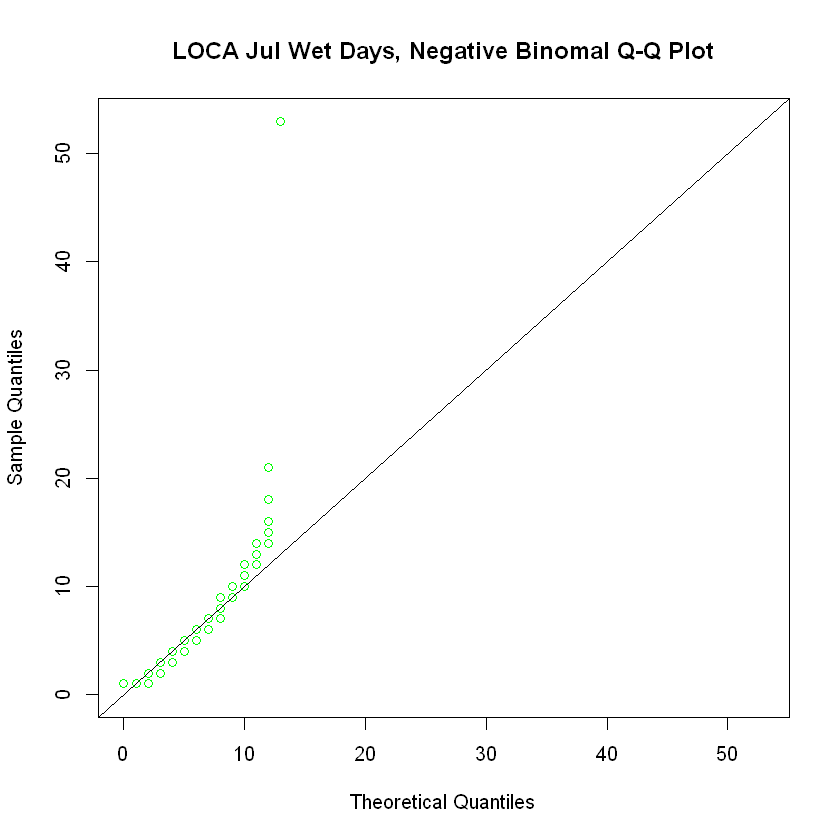

In [137]:
dLOJulMax <- max( dLOJul$Wet_Count )
dLOJulMean <- mean( dLOJul$Wet_Count )
dLOJulVar <- var( dLOJul$Wet_Count )
dLOJulBNr <- dLOJulMean^2 / abs(dLOJulVar - dLOJulMean)
dLOJulTstNB <- rnbinom( 1000, mu=dLOJulMean, size=dLOJulBNr )
qqplot( dLOJulTstNB, dLOJul$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jul Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJulMax), ylim=c(0,dLOJulMax) )
abline( 0, 1)

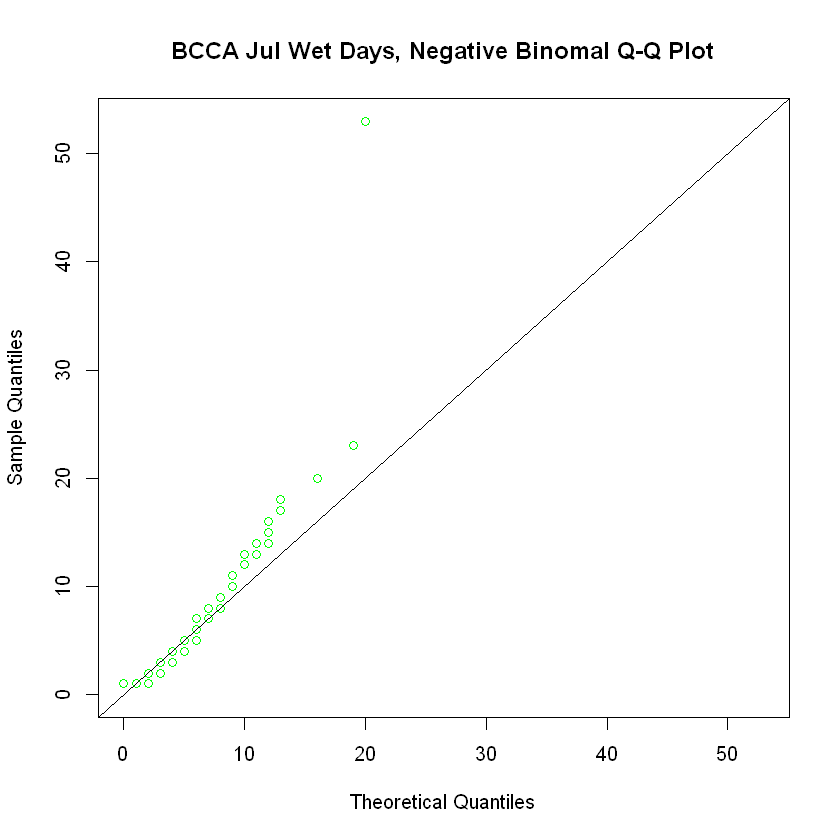

In [138]:
dBCJulMax <- max( dBCJul$Wet_Count )
dBCJulMean <- mean( dBCJul$Wet_Count )
dBCJulVar <- var( dBCJul$Wet_Count )
dBCJulBNr <- dBCJulMean^2 / abs(dBCJulVar - dBCJulMean)
dBCJulTstNB <- rnbinom( 1000, mu=dBCJulMean, size=dBCJulBNr )
qqplot( dBCJulTstNB, dBCJul$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jul Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJulMax), ylim=c(0,dBCJulMax) )
abline( 0, 1)

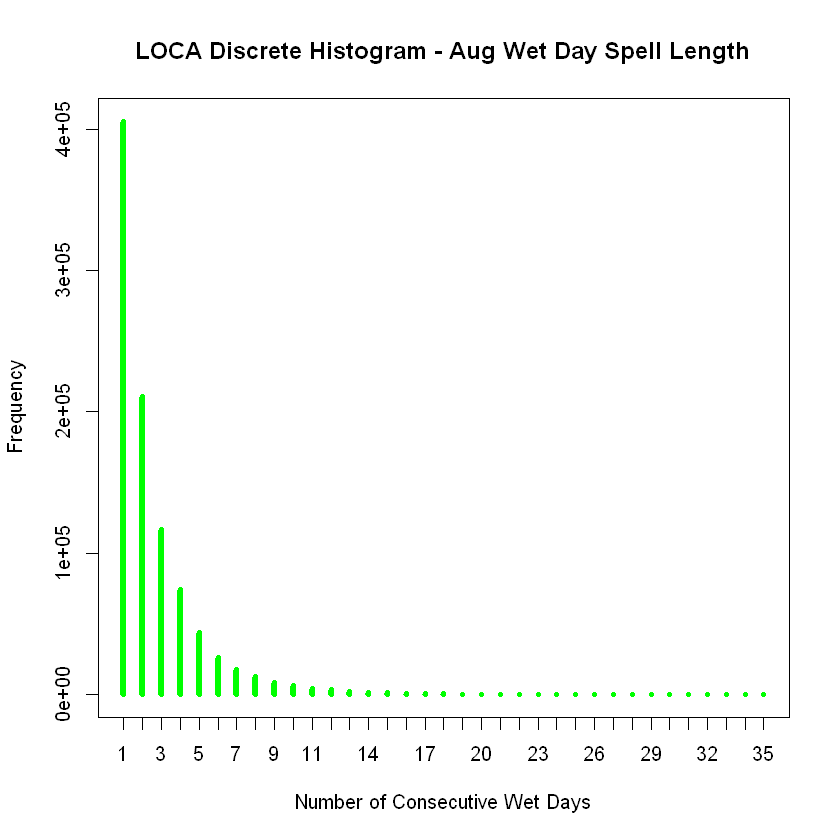

In [139]:
# our case is discrete so use this command
plot( table( dLOAug$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Aug Wet Day Spell Length", 
      col="green" )

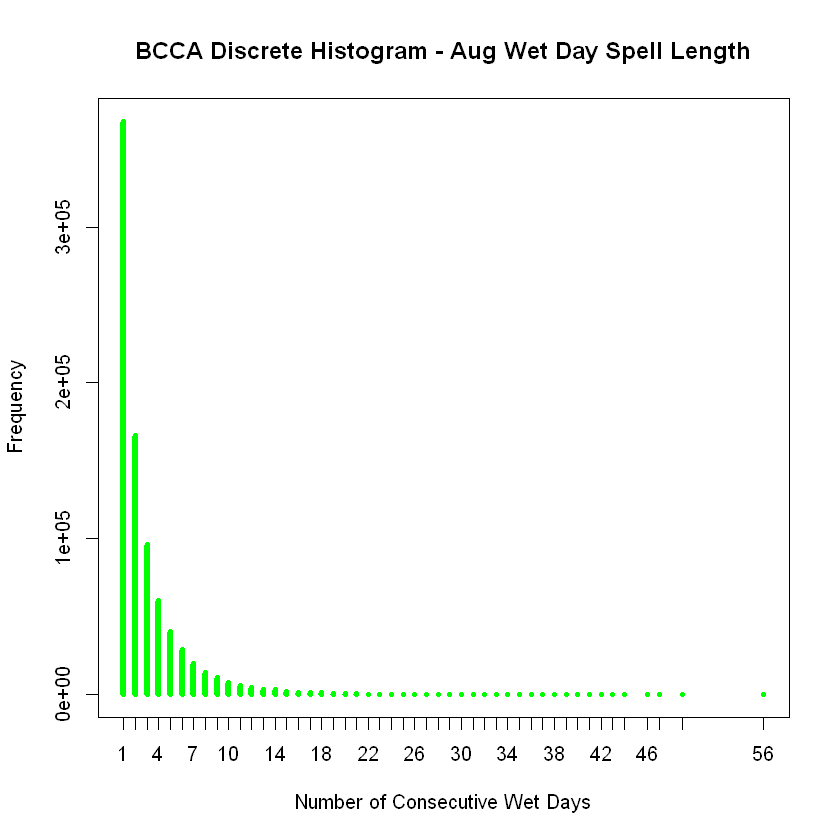

In [140]:
plot( table( dBCAug$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Aug Wet Day Spell Length", 
      col="green" )

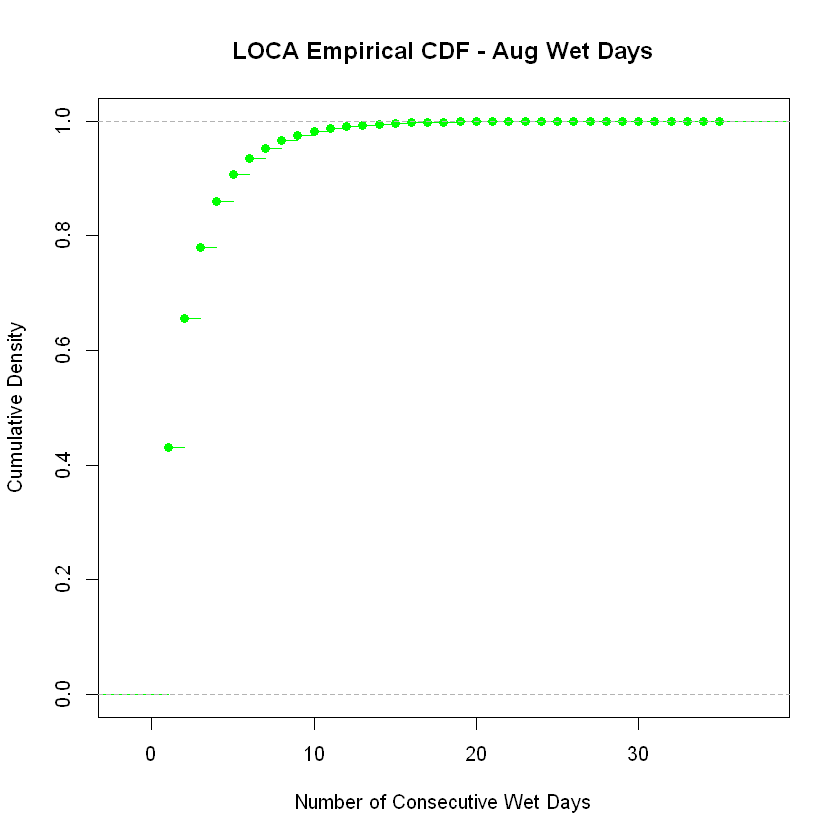

In [141]:
plot(ecdf(dLOAug$Wet_Count), main="LOCA Empirical CDF - Aug Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

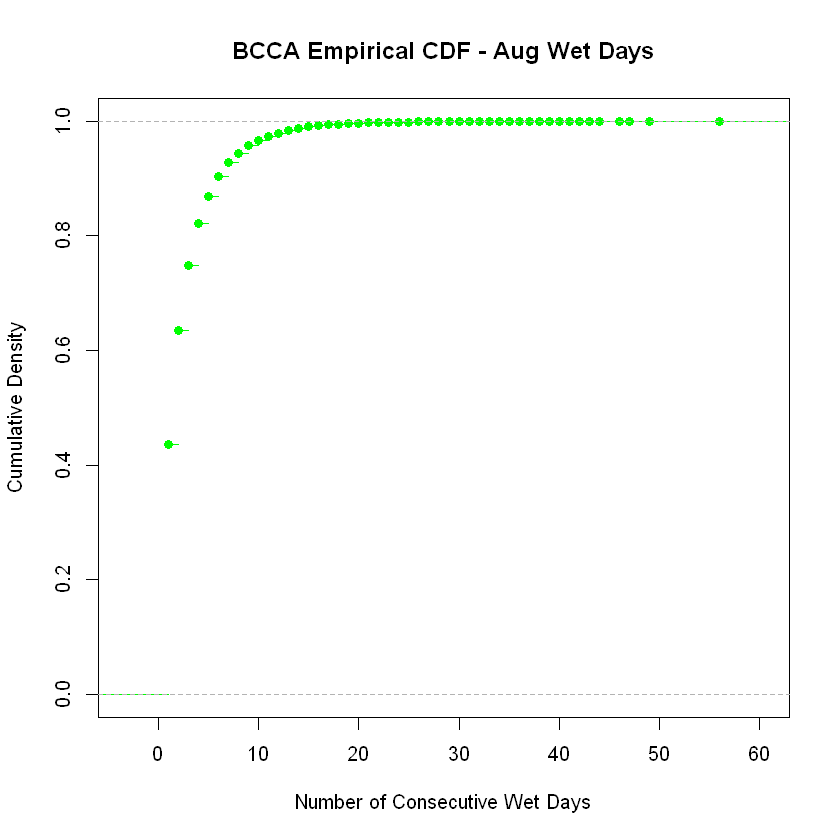

In [142]:
plot(ecdf(dBCAug$Wet_Count), main="BCCA Empirical CDF - Aug Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

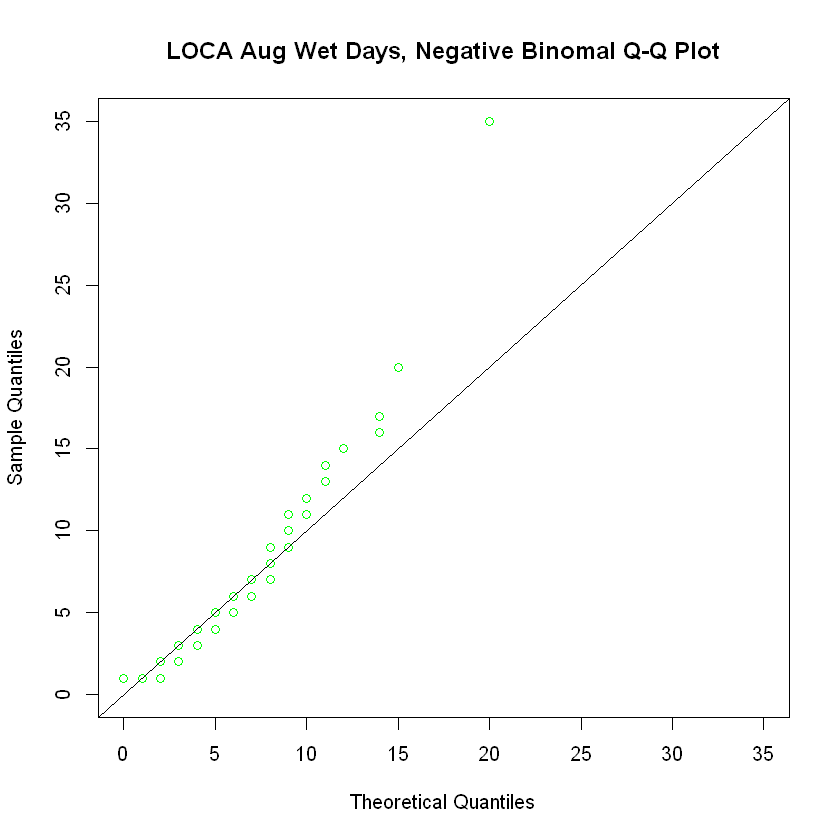

In [143]:
dLOAugMax <- max( dLOAug$Wet_Count )
dLOAugMean <- mean( dLOAug$Wet_Count )
dLOAugVar <- var( dLOAug$Wet_Count )
dLOAugBNr <- dLOAugMean^2 / abs(dLOAugVar - dLOAugMean)
dLOAugTstNB <- rnbinom( 1000, mu=dLOAugMean, size=dLOAugBNr )
qqplot( dLOAugTstNB, dLOAug$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Aug Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOAugMax), ylim=c(0,dLOAugMax) )
abline( 0, 1)

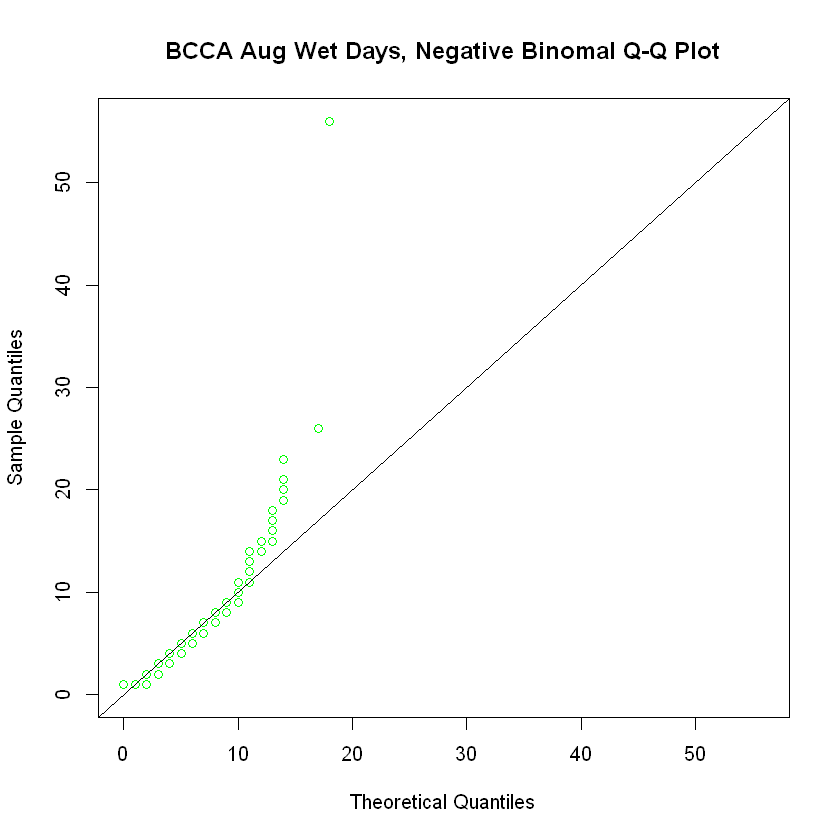

In [144]:
dBCAugMax <- max( dBCAug$Wet_Count )
dBCAugMean <- mean( dBCAug$Wet_Count )
dBCAugVar <- var( dBCAug$Wet_Count )
dBCAugBNr <- dBCAugMean^2 / abs(dBCAugVar - dBCAugMean)
dBCAugTstNB <- rnbinom( 1000, mu=dBCAugMean, size=dBCAugBNr )
qqplot( dBCAugTstNB, dBCAug$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Aug Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCAugMax), ylim=c(0,dBCAugMax) )
abline( 0, 1)

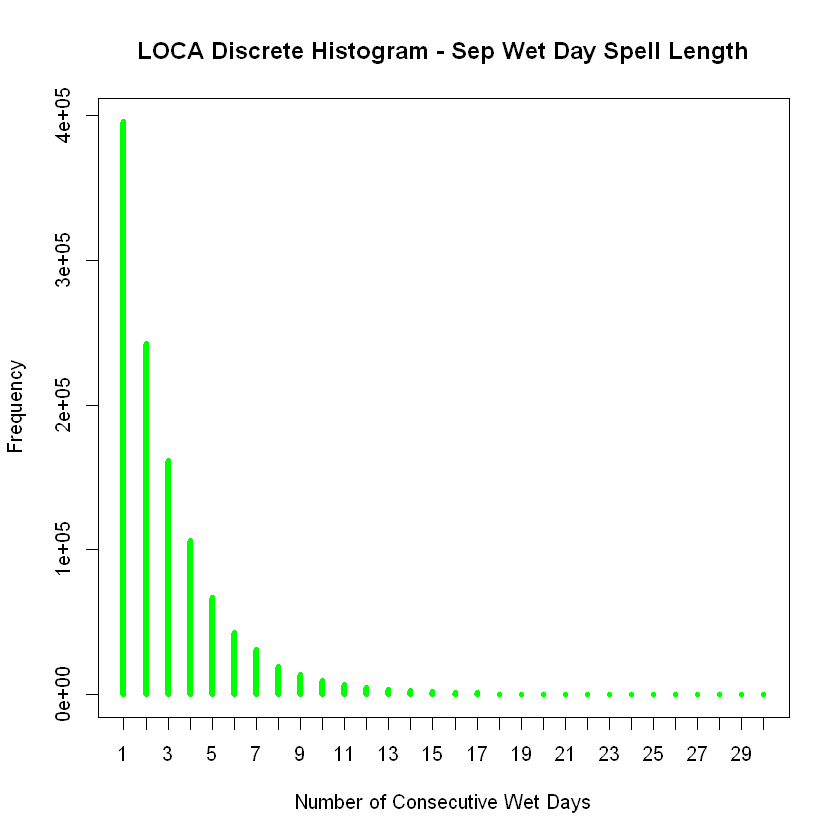

In [145]:
# our case is discrete so use this command
plot( table( dLOSep$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Sep Wet Day Spell Length", 
      col="green" )

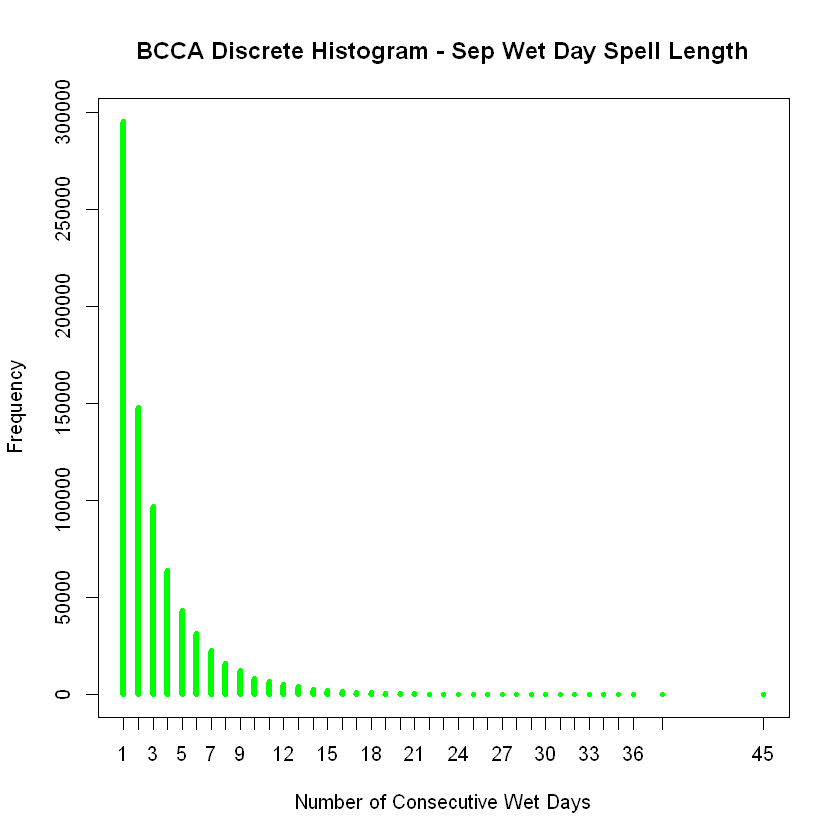

In [146]:
plot( table( dBCSep$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Sep Wet Day Spell Length", 
      col="green" )

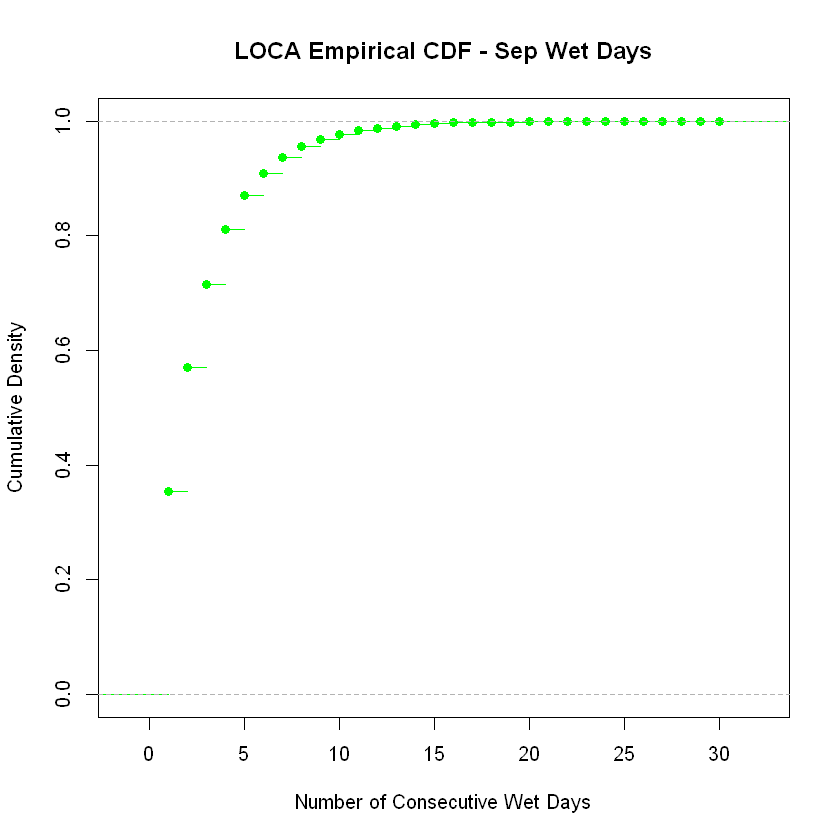

In [147]:
plot(ecdf(dLOSep$Wet_Count), main="LOCA Empirical CDF - Sep Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

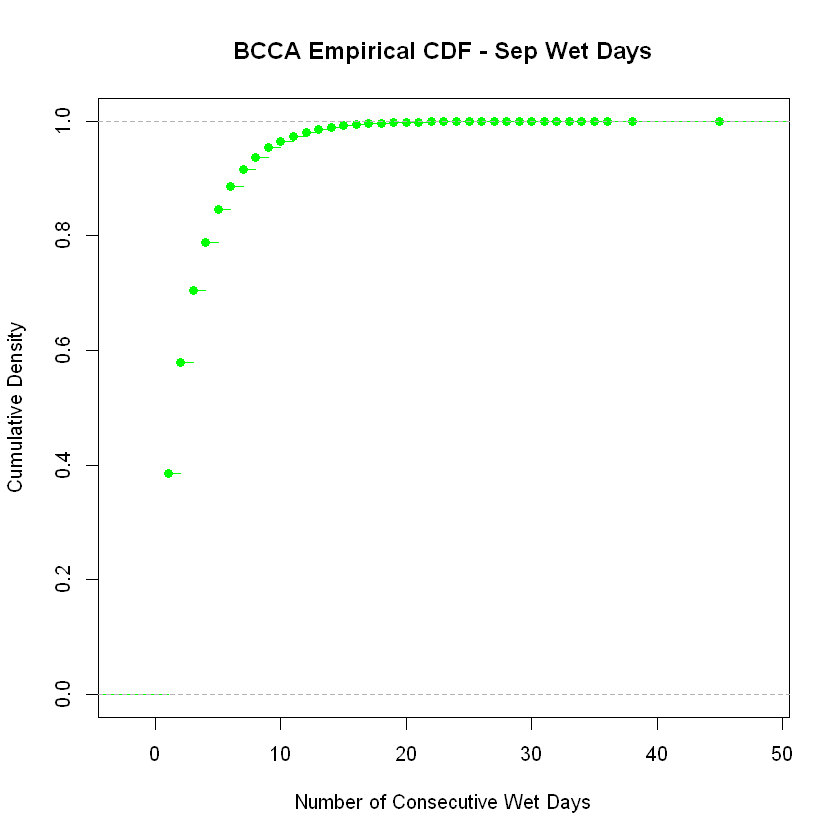

In [148]:
plot(ecdf(dBCSep$Wet_Count), main="BCCA Empirical CDF - Sep Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

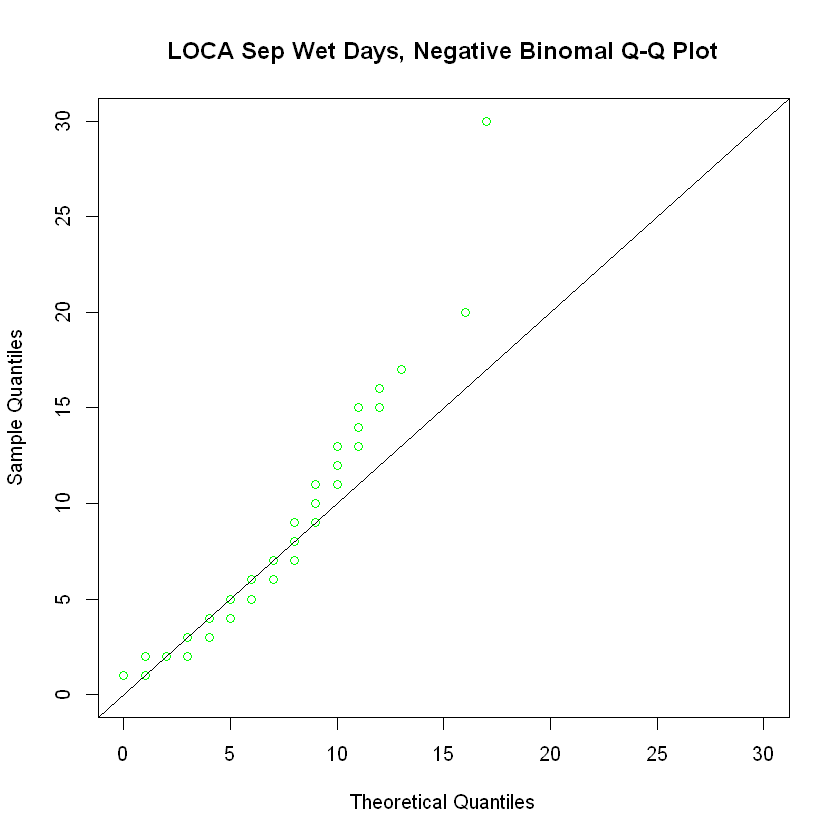

In [149]:
dLOSepMax <- max( dLOSep$Wet_Count )
dLOSepMean <- mean( dLOSep$Wet_Count )
dLOSepVar <- var( dLOSep$Wet_Count )
dLOSepBNr <- dLOSepMean^2 / abs(dLOSepVar - dLOSepMean)
dLOSepTstNB <- rnbinom( 1000, mu=dLOSepMean, size=dLOSepBNr )
qqplot( dLOSepTstNB, dLOSep$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Sep Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOSepMax), ylim=c(0,dLOSepMax) )
abline( 0, 1)

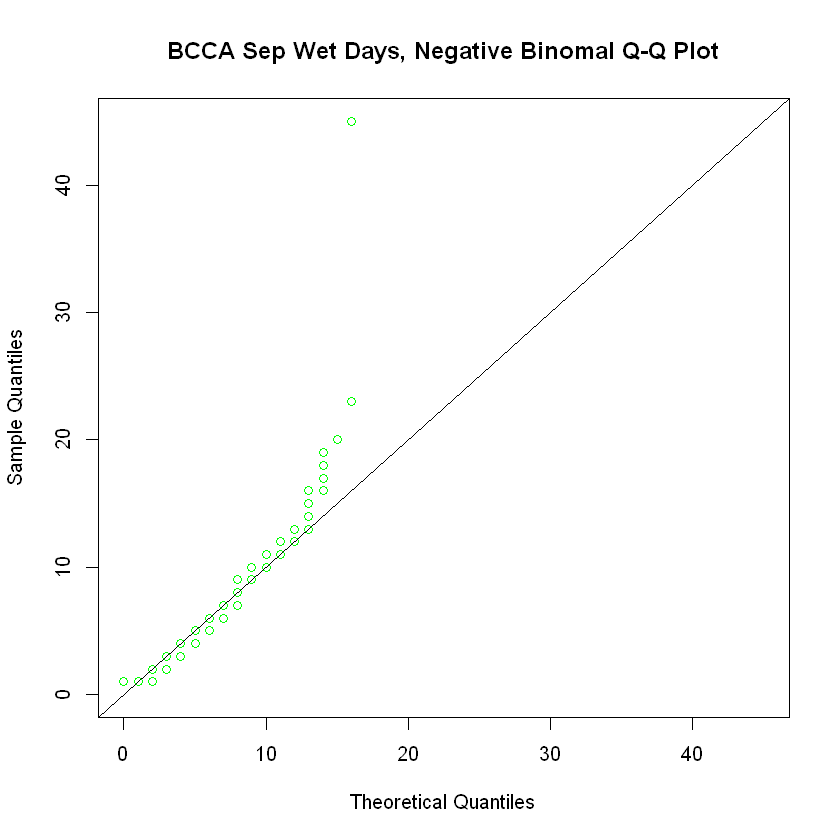

In [150]:
dBCSepMax <- max( dBCSep$Wet_Count )
dBCSepMean <- mean( dBCSep$Wet_Count )
dBCSepVar <- var( dBCSep$Wet_Count )
dBCSepBNr <- dBCSepMean^2 / abs(dBCSepVar - dBCSepMean)
dBCSepTstNB <- rnbinom( 1000, mu=dBCSepMean, size=dBCSepBNr )
qqplot( dBCSepTstNB, dBCSep$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Sep Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCSepMax), ylim=c(0,dBCSepMax) )
abline( 0, 1)

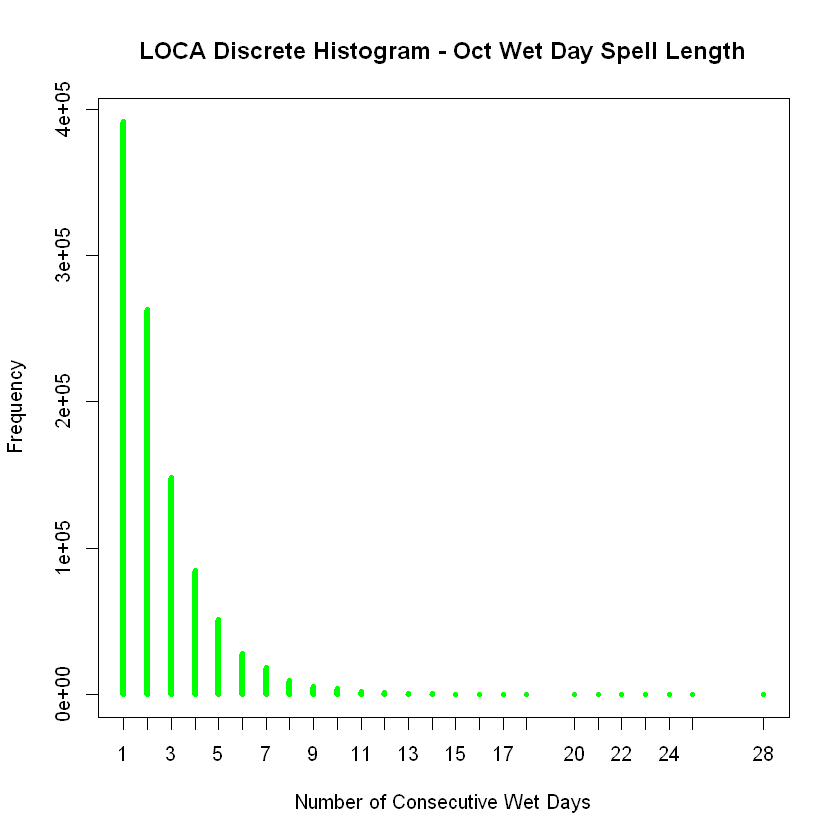

In [151]:
# our case is discrete so use this command
plot( table( dLOOct$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Oct Wet Day Spell Length", 
      col="green" )

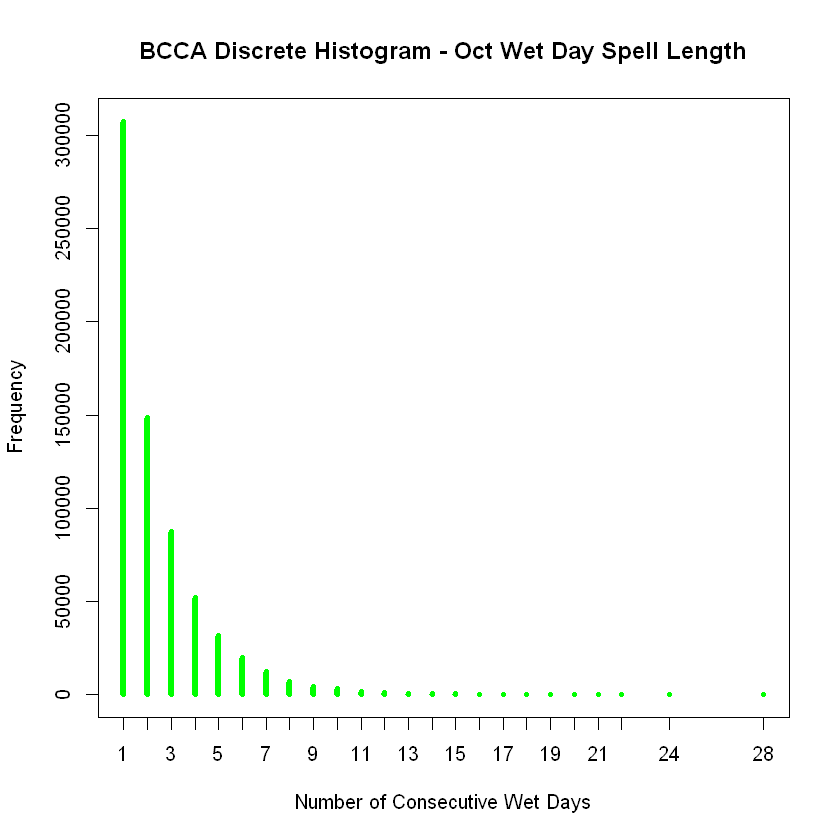

In [152]:
plot( table( dBCOct$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Oct Wet Day Spell Length", 
      col="green" )

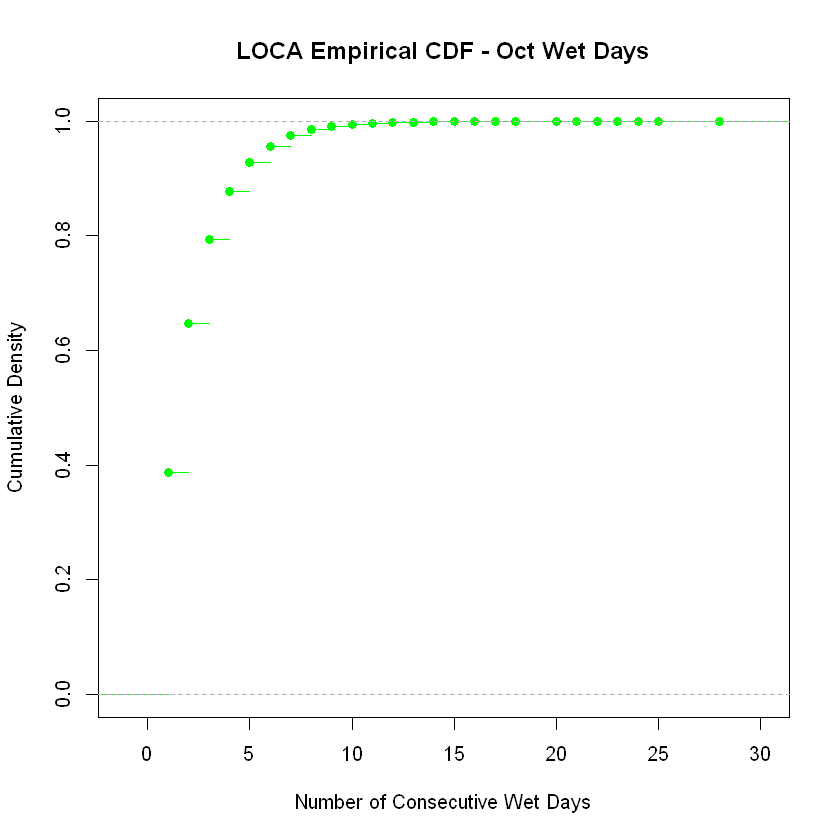

In [153]:
plot(ecdf(dLOOct$Wet_Count), main="LOCA Empirical CDF - Oct Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

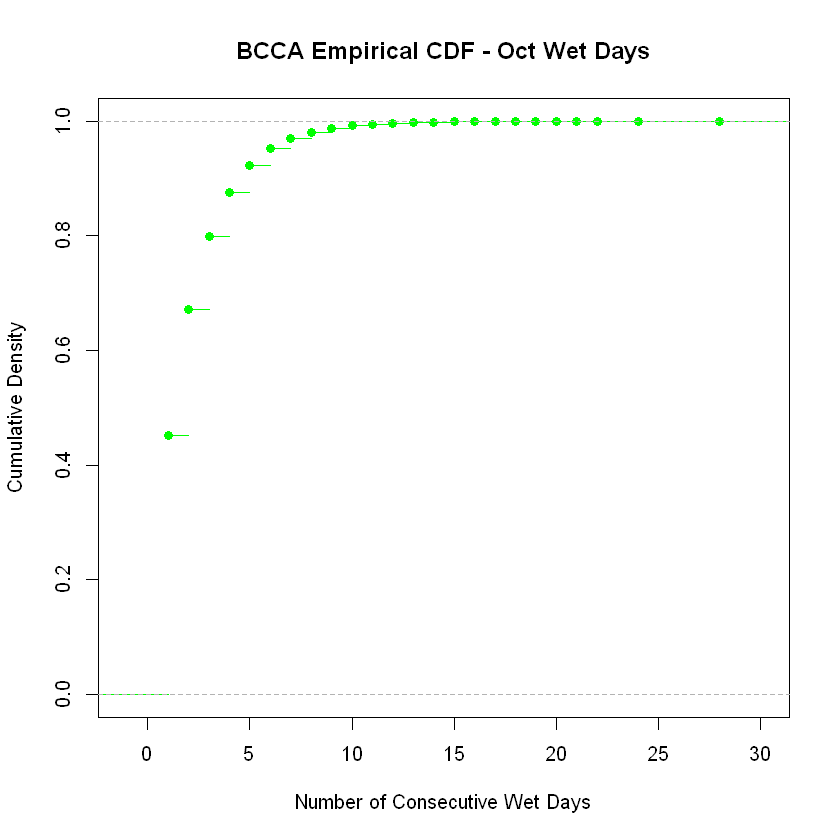

In [154]:
plot(ecdf(dBCOct$Wet_Count), main="BCCA Empirical CDF - Oct Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

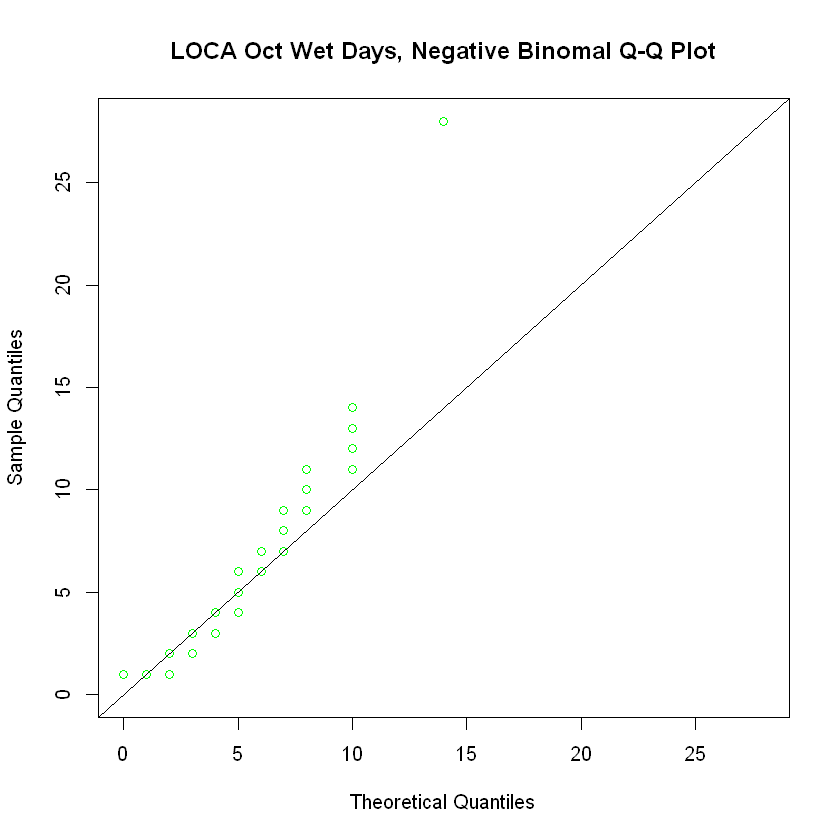

In [155]:
dLOOctMax <- max( dLOOct$Wet_Count )
dLOOctMean <- mean( dLOOct$Wet_Count )
dLOOctVar <- var( dLOOct$Wet_Count )
dLOOctBNr <- dLOOctMean^2 / abs(dLOOctVar - dLOOctMean)
dLOOctTstNB <- rnbinom( 1000, mu=dLOOctMean, size=dLOOctBNr )
qqplot( dLOOctTstNB, dLOOct$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Oct Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOOctMax), ylim=c(0,dLOOctMax) )
abline( 0, 1)

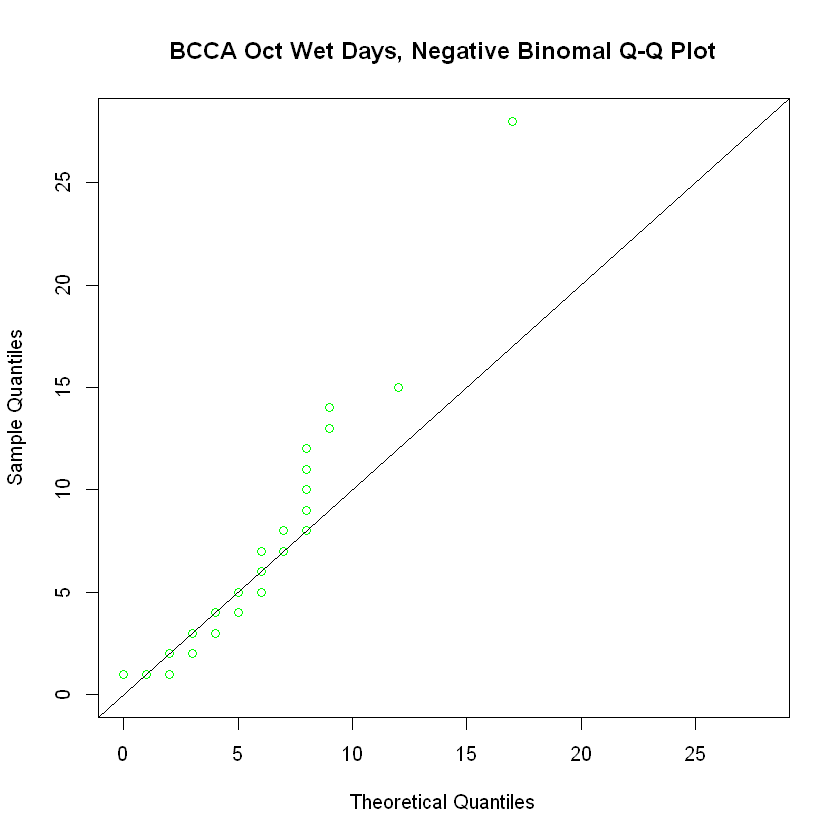

In [156]:
dBCOctMax <- max( dBCOct$Wet_Count )
dBCOctMean <- mean( dBCOct$Wet_Count )
dBCOctVar <- var( dBCOct$Wet_Count )
dBCOctBNr <- dBCOctMean^2 / abs(dBCOctVar - dBCOctMean)
dBCOctTstNB <- rnbinom( 1000, mu=dBCOctMean, size=dBCOctBNr )
qqplot( dBCOctTstNB, dBCOct$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Oct Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCOctMax), ylim=c(0,dBCOctMax) )
abline( 0, 1)

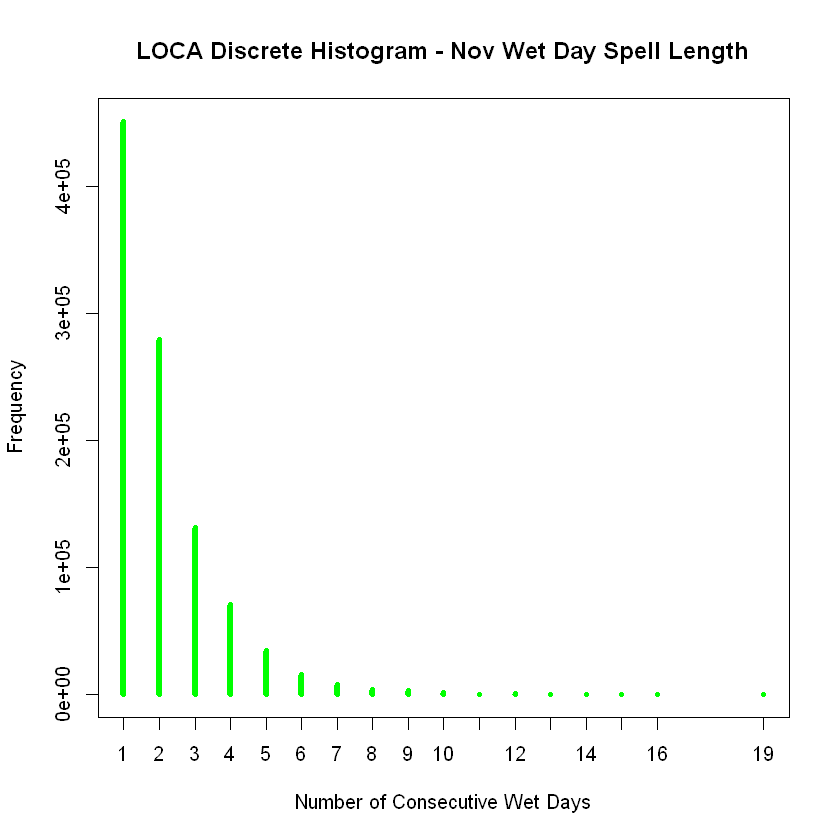

In [157]:
# our case is discrete so use this command
plot( table( dLONov$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Nov Wet Day Spell Length", 
      col="green" )

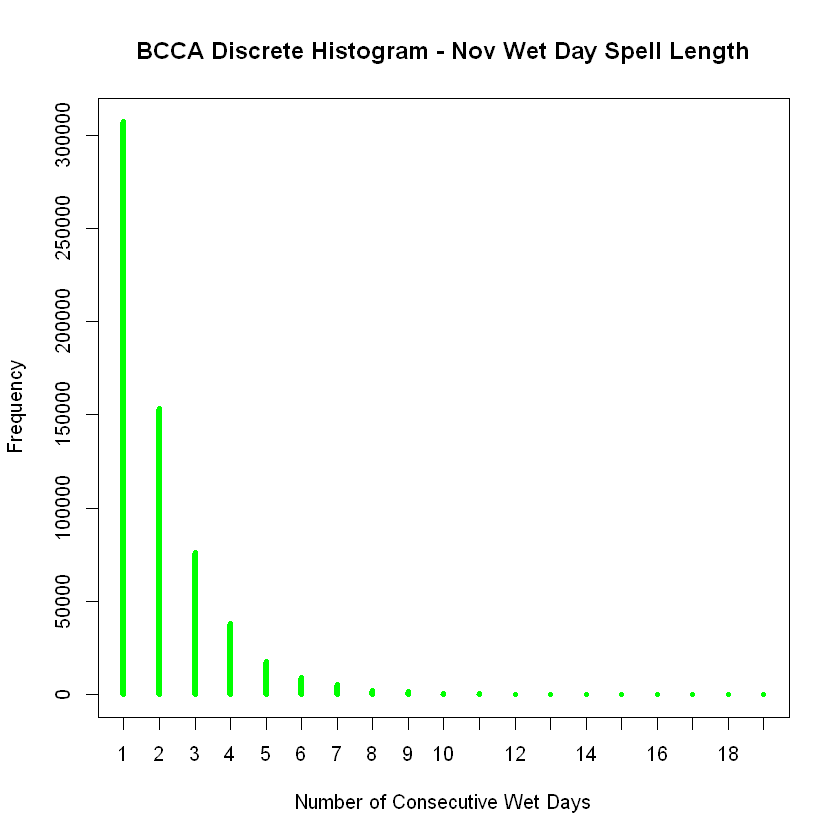

In [158]:
plot( table( dBCNov$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Nov Wet Day Spell Length", 
      col="green" )

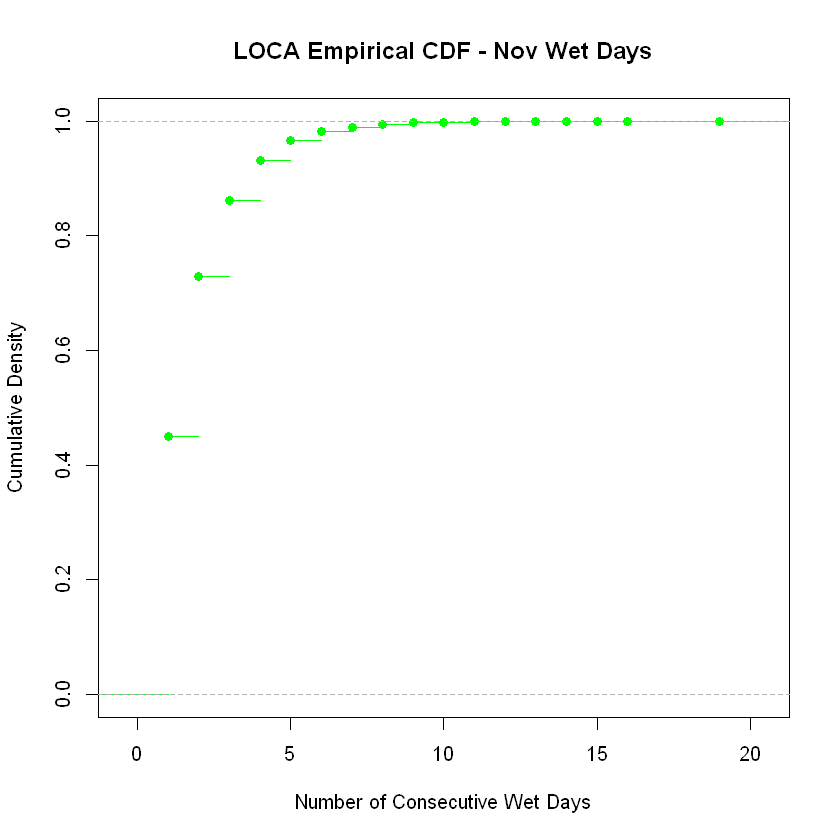

In [159]:
plot(ecdf(dLONov$Wet_Count), main="LOCA Empirical CDF - Nov Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

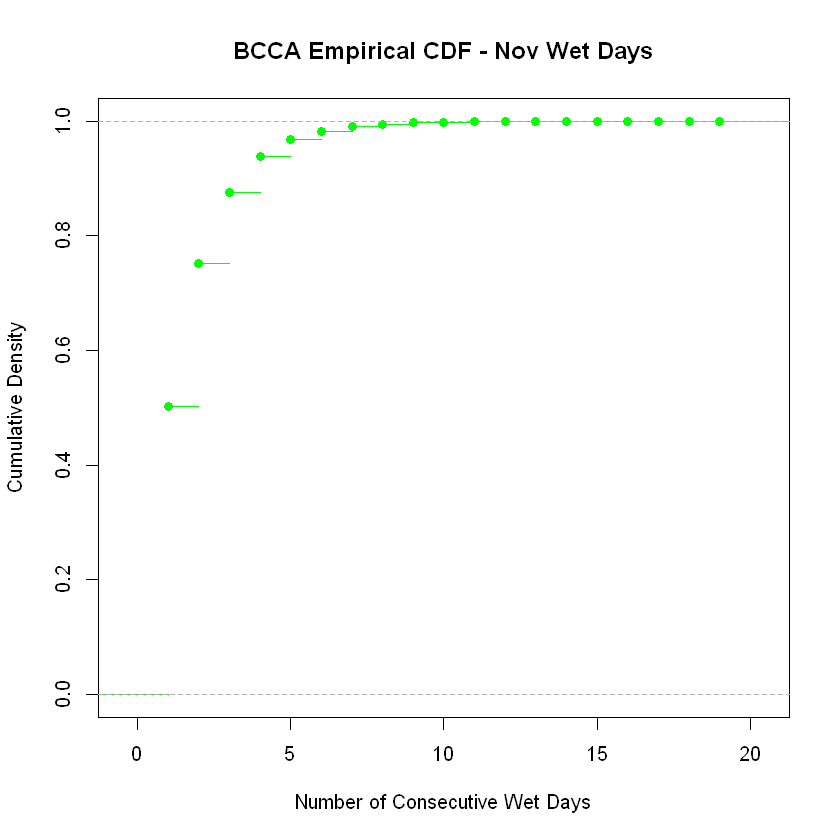

In [160]:
plot(ecdf(dBCNov$Wet_Count), main="BCCA Empirical CDF - Nov Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

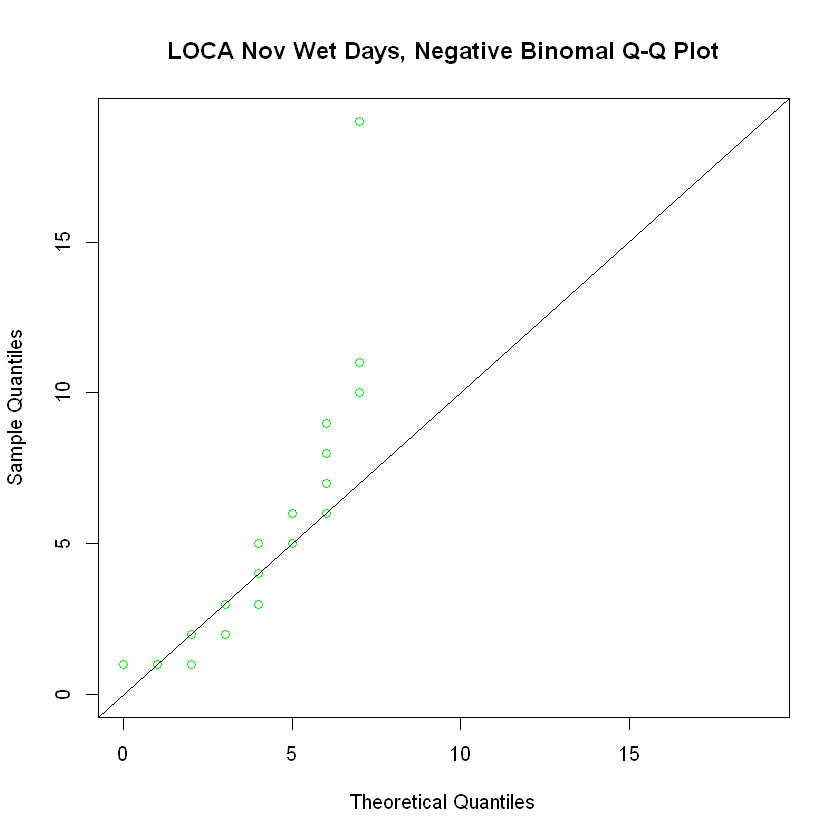

In [161]:
dLONovMax <- max( dLONov$Wet_Count )
dLONovMean <- mean( dLONov$Wet_Count )
dLONovVar <- var( dLONov$Wet_Count )
dLONovBNr <- dLONovMean^2 / abs(dLONovVar - dLONovMean)
dLONovTstNB <- rnbinom( 1000, mu=dLONovMean, size=dLONovBNr )
qqplot( dLONovTstNB, dLONov$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Nov Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLONovMax), ylim=c(0,dLONovMax) )
abline( 0, 1)

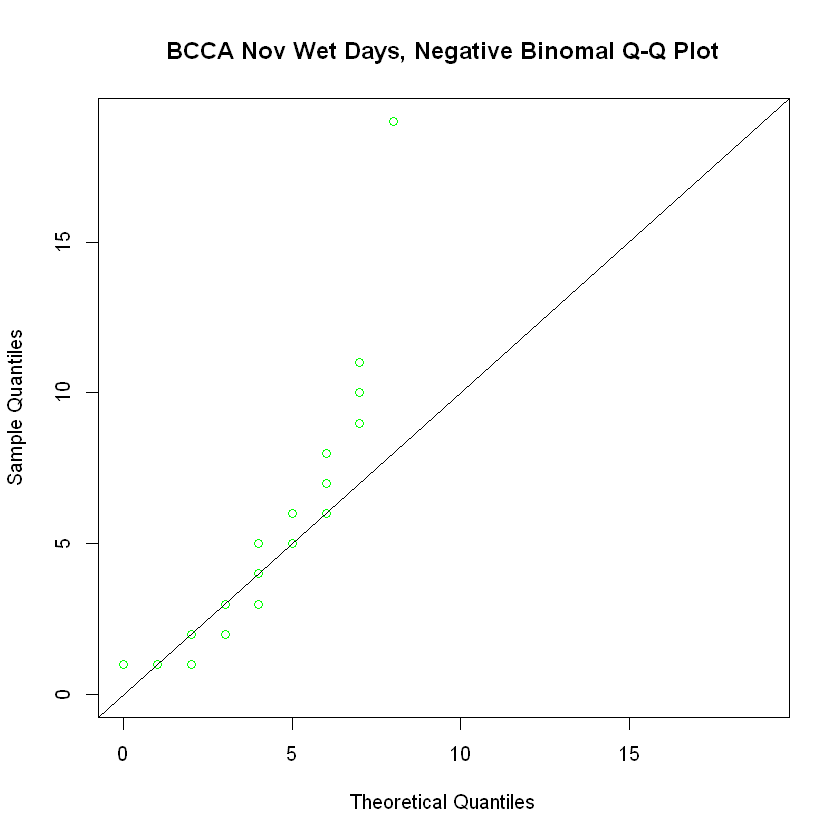

In [162]:
dBCNovMax <- max( dBCNov$Wet_Count )
dBCNovMean <- mean( dBCNov$Wet_Count )
dBCNovVar <- var( dBCNov$Wet_Count )
dBCNovBNr <- dBCNovMean^2 / abs(dBCNovVar - dBCNovMean)
dBCNovTstNB <- rnbinom( 1000, mu=dBCNovMean, size=dBCNovBNr )
qqplot( dBCNovTstNB, dBCNov$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Nov Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCNovMax), ylim=c(0,dBCNovMax) )
abline( 0, 1)

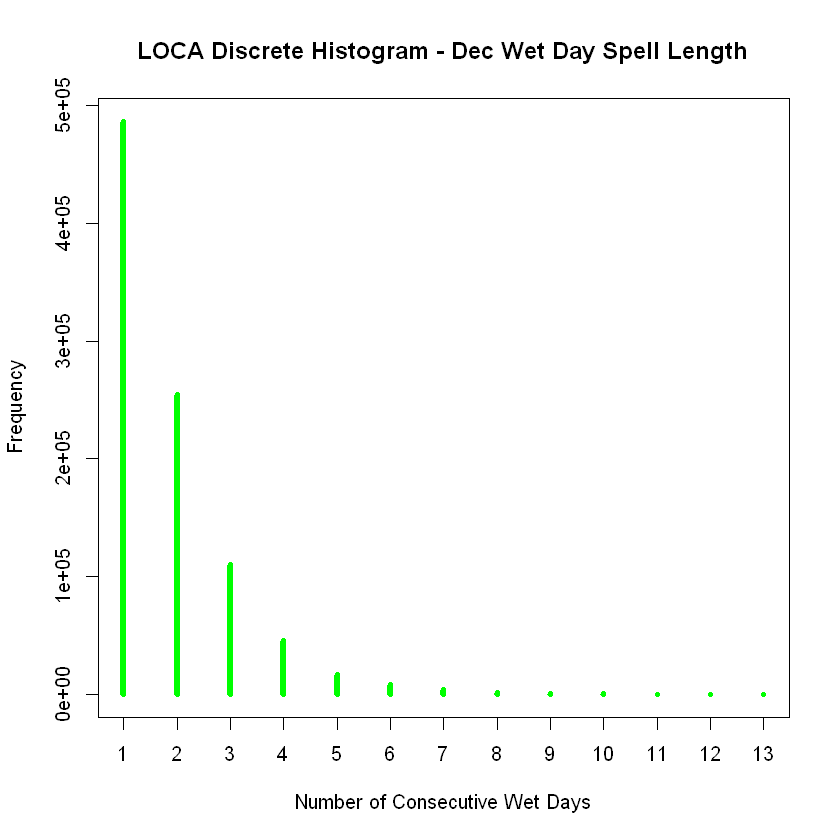

In [163]:
# our case is discrete so use this command
plot( table( dLODec$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Dec Wet Day Spell Length", 
      col="green" )

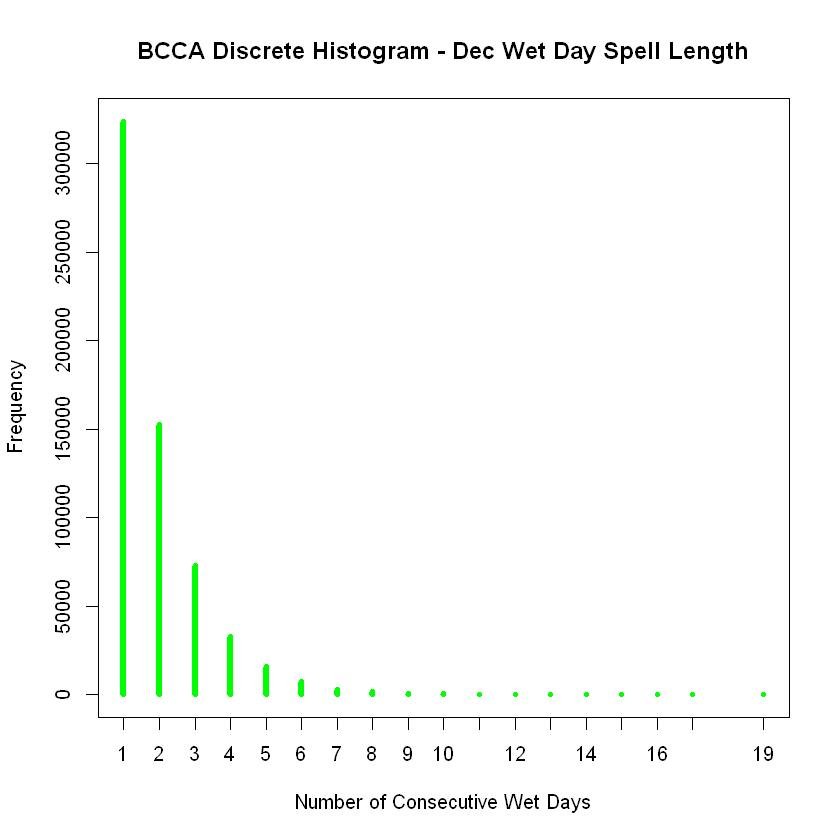

In [164]:
plot( table( dBCDec$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Dec Wet Day Spell Length", 
      col="green" )

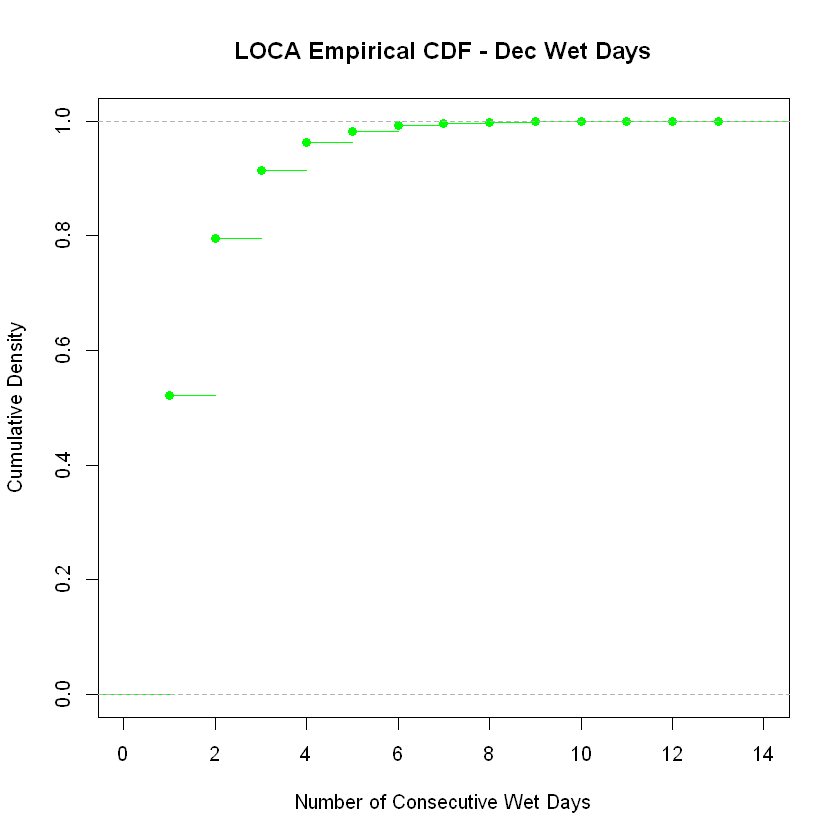

In [165]:
plot(ecdf(dLODec$Wet_Count), main="LOCA Empirical CDF - Dec Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

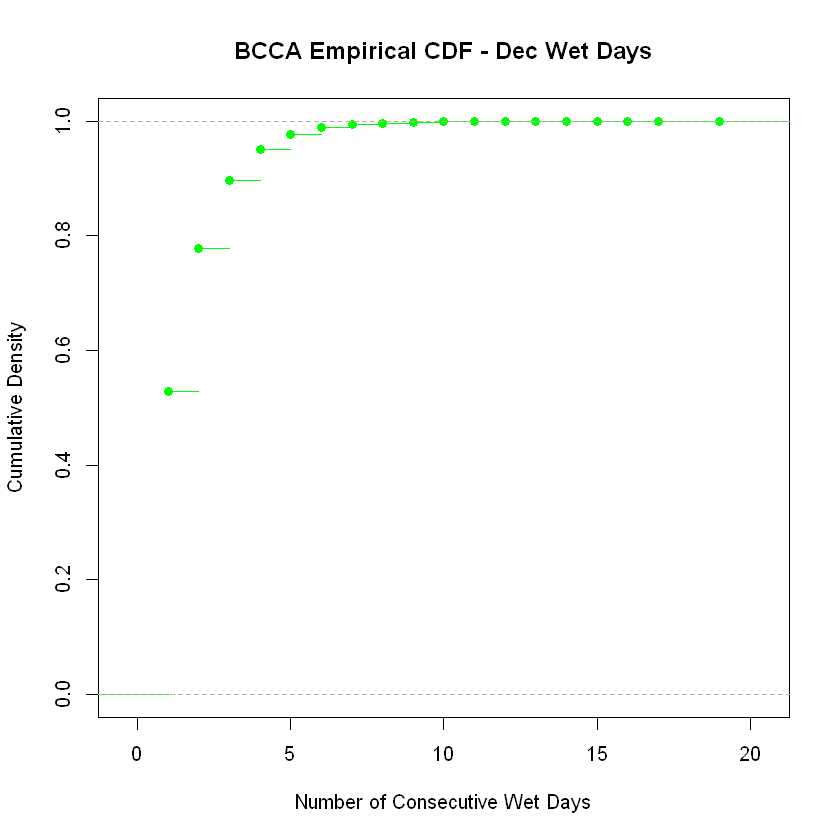

In [166]:
plot(ecdf(dBCDec$Wet_Count), main="BCCA Empirical CDF - Dec Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

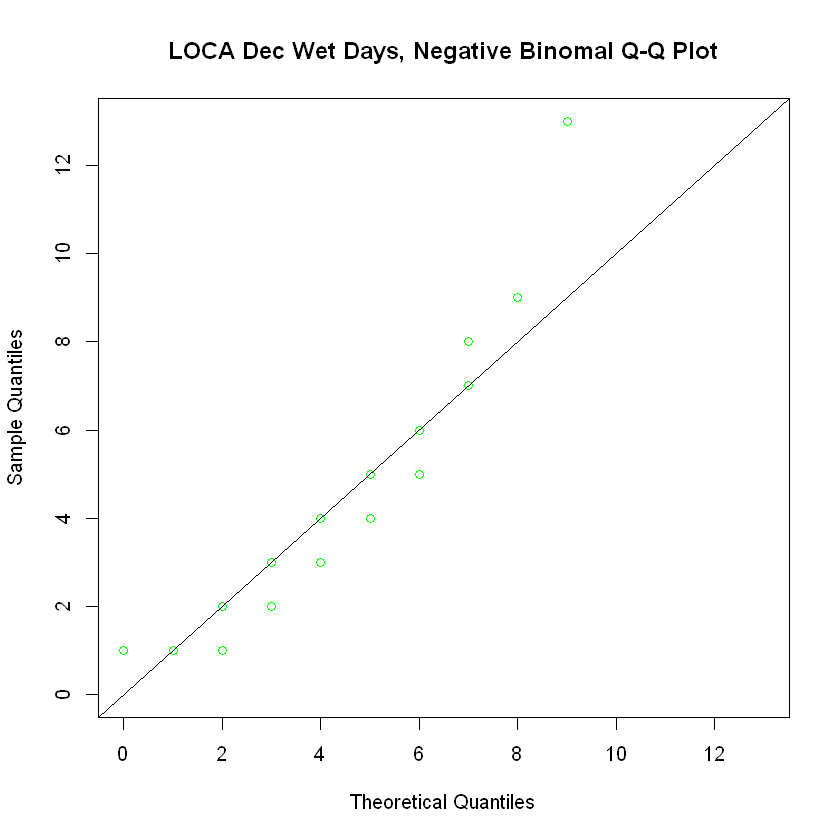

In [167]:
dLODecMax <- max( dLODec$Wet_Count )
dLODecMean <- mean( dLODec$Wet_Count )
dLODecVar <- var( dLODec$Wet_Count )
dLODecBNr <- dLODecMean^2 / abs(dLODecVar - dLODecMean)
dLODecTstNB <- rnbinom( 1000, mu=dLODecMean, size=dLODecBNr )
qqplot( dLODecTstNB, dLODec$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Dec Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLODecMax), ylim=c(0,dLODecMax) )
abline( 0, 1)

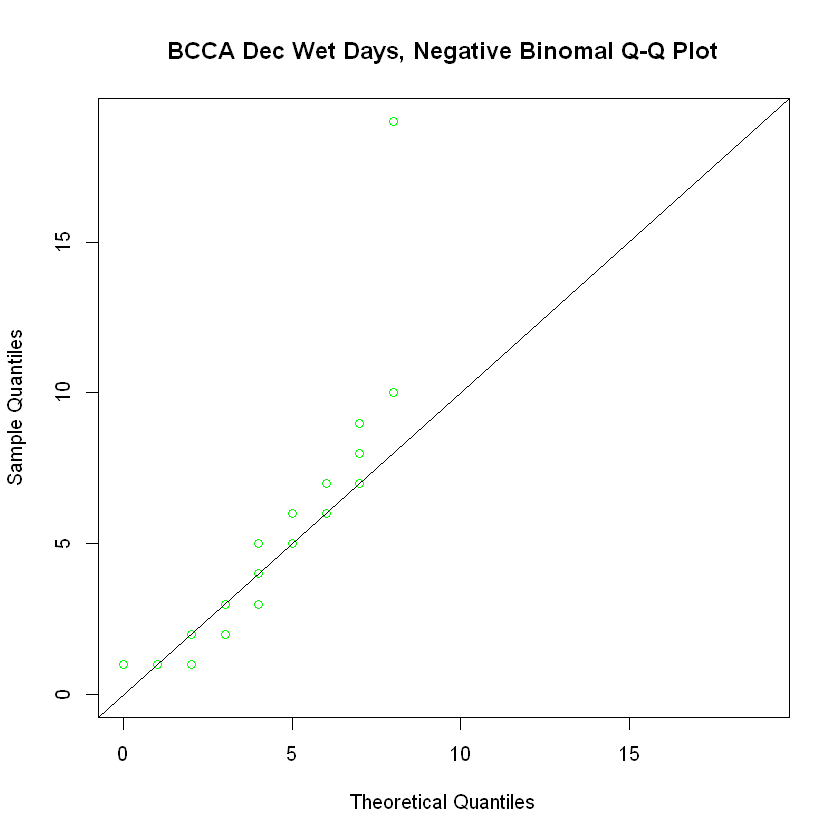

In [168]:
dBCDecMax <- max( dBCDec$Wet_Count )
dBCDecMean <- mean( dBCDec$Wet_Count )
dBCDecVar <- var( dBCDec$Wet_Count )
dBCDecBNr <- dBCDecMean^2 / abs(dBCDecVar - dBCDecMean)
dBCDecTstNB <- rnbinom( 1000, mu=dBCDecMean, size=dBCDecBNr )
qqplot( dBCDecTstNB, dBCDec$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Dec Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCDecMax), ylim=c(0,dBCDecMax) )
abline( 0, 1)

In [169]:
cat("LOCA Jan scale: ", dLOJanBNr, "\n", "LOCA Feb scale: ", dLOFebBNr, "\n",
    "LOCA Mar scale: ", dLOMarBNr, "\n", "LOCA Apr scale: ", dLOAprBNr, "\n",
    "LOCA May scale: ", dLOMayBNr, "\n", "LOCA Jun scale: ", dLOJunBNr, "\n",
    "LOCA Jul scale: ", dLOJulBNr, "\n", "LOCA Aug scale: ", dLOAugBNr, "\n",
    "LOCA Sep scale: ", dLOSepBNr, "\n", "LOCA Oct scale: ", dLOOctBNr, "\n",
    "LOCA Nov scale: ", dLONovBNr, "\n", "LOCA Dec scale: ", dLODecBNr, "\n" )

LOCA Jan scale:  5.53644 
 LOCA Feb scale:  8.529719 
 LOCA Mar scale:  7.989548 
 LOCA Apr scale:  7.288129 
 LOCA May scale:  3.257674 
 LOCA Jun scale:  2.171283 
 LOCA Jul scale:  2.137236 
 LOCA Aug scale:  2.092992 
 LOCA Sep scale:  2.327151 
 LOCA Oct scale:  5.734523 
 LOCA Nov scale:  99.1741 
 LOCA Dec scale:  7.932482 


In [170]:
cat("BCCA Jan scale: ", dBCJanBNr, "\n", "BCCA Feb scale: ", dBCFebBNr, "\n",
    "BCCA Mar scale: ", dBCMarBNr, "\n", "BCCA Apr scale: ", dBCAprBNr, "\n",
    "BCCA May scale: ", dBCMayBNr, "\n", "BCCA Jun scale: ", dBCJunBNr, "\n",
    "BCCA Jul scale: ", dBCJulBNr, "\n", "BCCA Aug scale: ", dBCAugBNr, "\n",
    "BCCA Sep scale: ", dBCSepBNr, "\n", "BCCA Oct scale: ", dBCOctBNr, "\n",
    "BCCA Nov scale: ", dBCNovBNr, "\n", "BCCA Dec scale: ", dBCDecBNr, "\n" )

BCCA Jan scale:  14.76559 
 BCCA Feb scale:  27.74771 
 BCCA Mar scale:  149.8805 
 BCCA Apr scale:  2.746414 
 BCCA May scale:  1.632681 
 BCCA Jun scale:  1.541483 
 BCCA Jul scale:  1.491937 
 BCCA Aug scale:  1.297473 
 BCCA Sep scale:  1.642839 
 BCCA Oct scale:  3.641051 
 BCCA Nov scale:  55.03654 
 BCCA Dec scale:  21.06852 


### Fitting Negative Binomial Distributions

Use the **fitdistrplus** package for distribution fitting. This also provides the *plotdist* function which provides a pair of plots: 

1. empirical density, or a histogram
2. empirical cumulative distribution

These plots were provided above from scratch. **fitdistrplus** also provides a *descdist* function that provides classical descriptive statistics for the sample.

Distributions are then fit using a Maximum Likelihood Estimation (MLE) estimator in the *fitdist* function. Then goodness-of-fit statistics are calculated using the *gofstat* function.

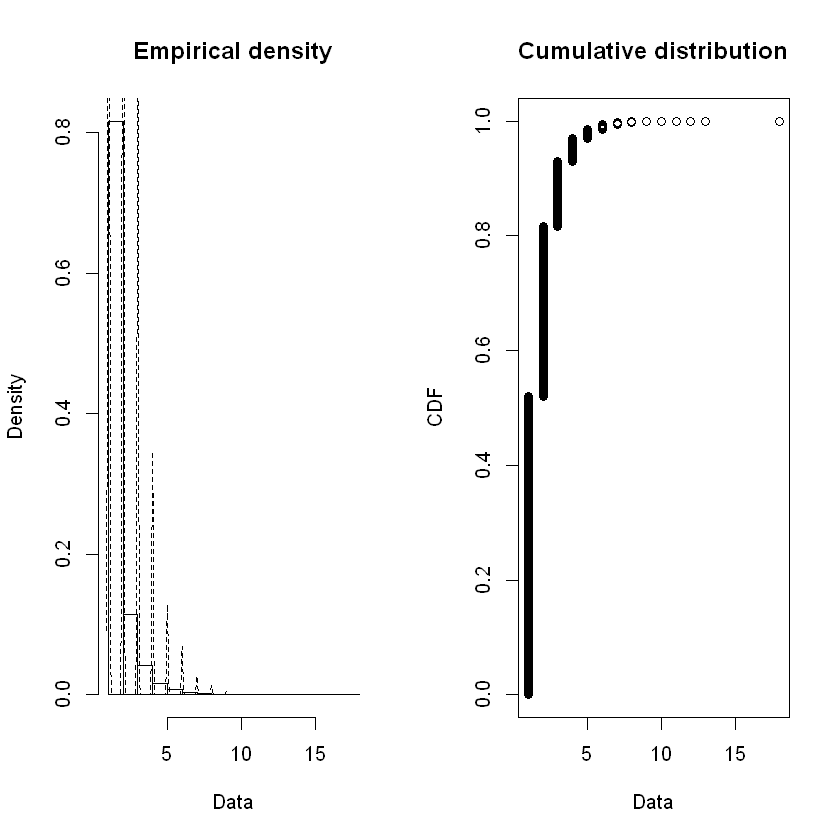

In [171]:
plotdist( dLOJan$Wet_Count, histo=TRUE, demp=TRUE )

In [172]:
LOfd_NB_dJan <- fitdist( dLOJan$Wet_Count, "nbinom" )
LOfd_GE_dJan <- fitdist( dLOJan$Wet_Count, "geom" )

In [173]:
summary( LOfd_NB_dJan )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 3.737196e+05         NaN
mu   1.786698e+00 0.001440281
Loglikelihood:  -1268915   AIC:  2537834   BIC:  2537858 
Correlation matrix:
     size  mu
size    1 NaN
mu    NaN   1


In [174]:
LOfdNB_dJan_size <- LOfd_NB_dJan$estimate[["size"]]
LOfdNB_dJan_mu <- LOfd_NB_dJan$estimate[["mu"]]
cat("LOCA Jan size: ", LOfdNB_dJan_size, "\n", "LOCA Jan mu: ", LOfdNB_dJan_mu, "\n")

LOCA Jan size:  373719.6 
 LOCA Jan mu:  1.786698 


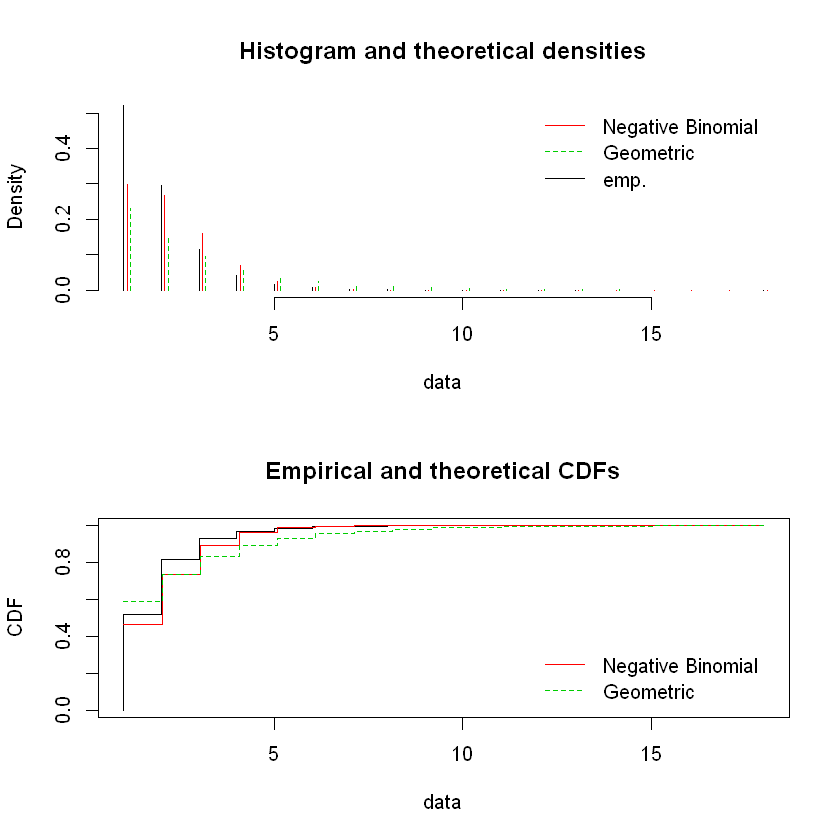

In [175]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJan, LOfd_GE_dJan), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJan, LOfd_GE_dJan), legendtext=plot.legend )

In [176]:
LOstatRes <- gofstat( list(LOfd_NB_dJan, LOfd_GE_dJan), fitnames=c("Negative Binomial", "Geometric") )

In [177]:
print(LOstatRes)

Chi-squared statistic:  39801.98 194069.9 
Degree of freedom of the Chi-squared distribution:  5 6 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    448509            402129.0909      507366.85
<= 2    254298            230327.6793      127073.59
<= 3     97855            137175.3892       81468.82
<= 4     35624             61272.9367       52230.91
<= 5     13507             21895.3726       33486.03
<= 6      6682              6520.1247       21468.41
<= 7      2865              1664.2319       13763.73
> 7       2106               461.1748       24587.66

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2537834   3133763
Bayesian Information Criterion           2537858   3133774


In [178]:
LOfdNB_dJan_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

[Chi-Squared Test](https://www.r-bloggers.com/chi-squared-test/)

Like all statistical tests, chi-squared test assumes a null hypothesis and an alternate hypothesis. The general practice is, if the p-value that comes out in the result is less than a pre-determined significance level, which is 0.05 usually, then we reject the null hypothesis.

- H0: The The two variables are independent
- H1: The two variables are related.

The null hypothesis of the chi-squared test is that the two variables are independent and the alternate hypothesis is that they are related.

In this case our p-value is 0.0 and we can reject the null hypothesis that sample and MLE-fit distribution are not related.

In [179]:
LOfdNB_dJan_p = LOfdNB_dJan_size / (LOfdNB_dJan_size + LOfdNB_dJan_mu)
cat("LOCA prob: ", LOfdNB_dJan_p)

LOCA prob:  0.9999952

In [180]:
# add to our tracking dataframe
LOMonDistDF[1, ] <- list( 1, dLOJanMean, dLOJanBNr, LOfdNB_dJan_p, LOfdNB_dJan_mu, LOfdNB_dJan_size,
                          LOfdNB_dJan_pvalue )

In [181]:
LOgf_dJan <- goodfit( dLOJan$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJan_size, prob=LOfdNB_dJan_p) )

In [182]:
summary( LOgf_dJan )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          4996263.1 18        0
Likelihood Ratio  439644.4 13        0


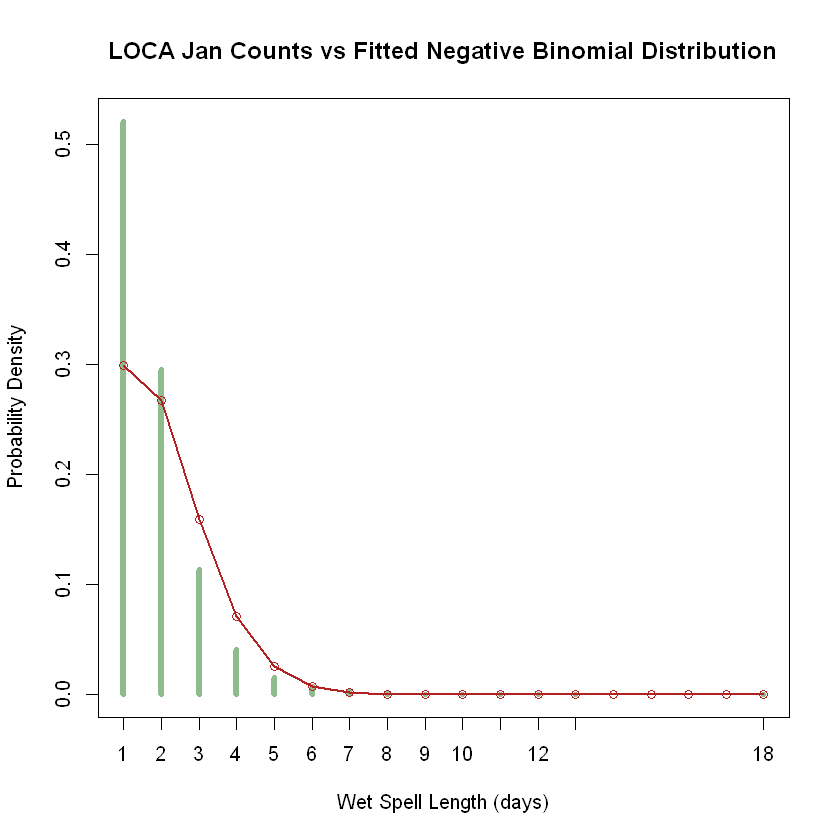

In [183]:
maxP <- max(dLOJan$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJan_size, mu=LOfdNB_dJan_mu )
ttab <- table( dLOJan$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jan Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

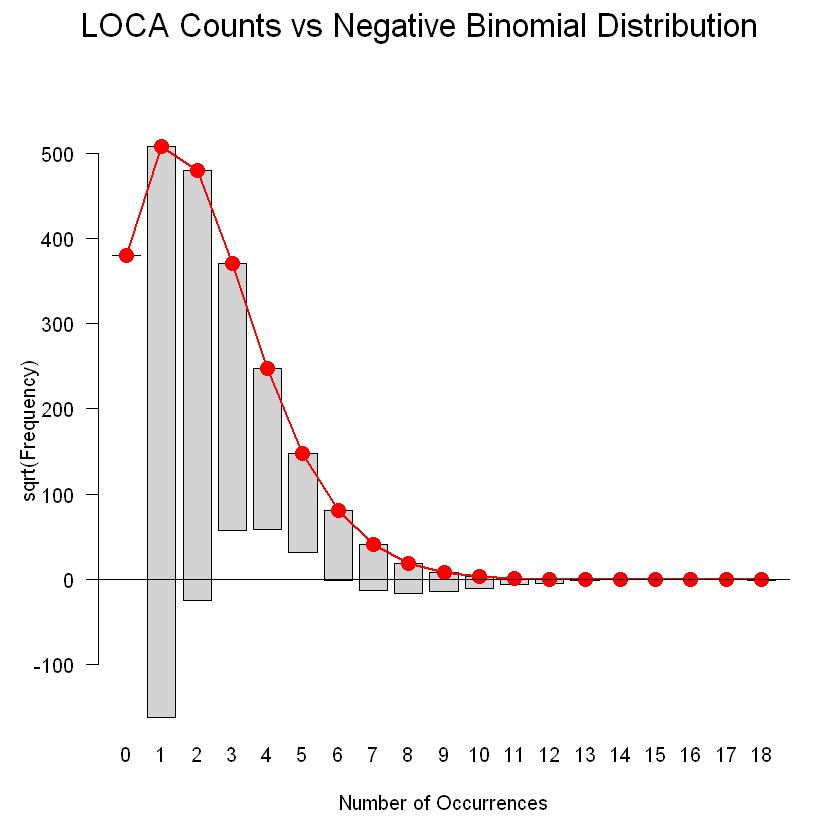

In [184]:
plot( LOgf_dJan, main="LOCA Counts vs Negative Binomial Distribution" )

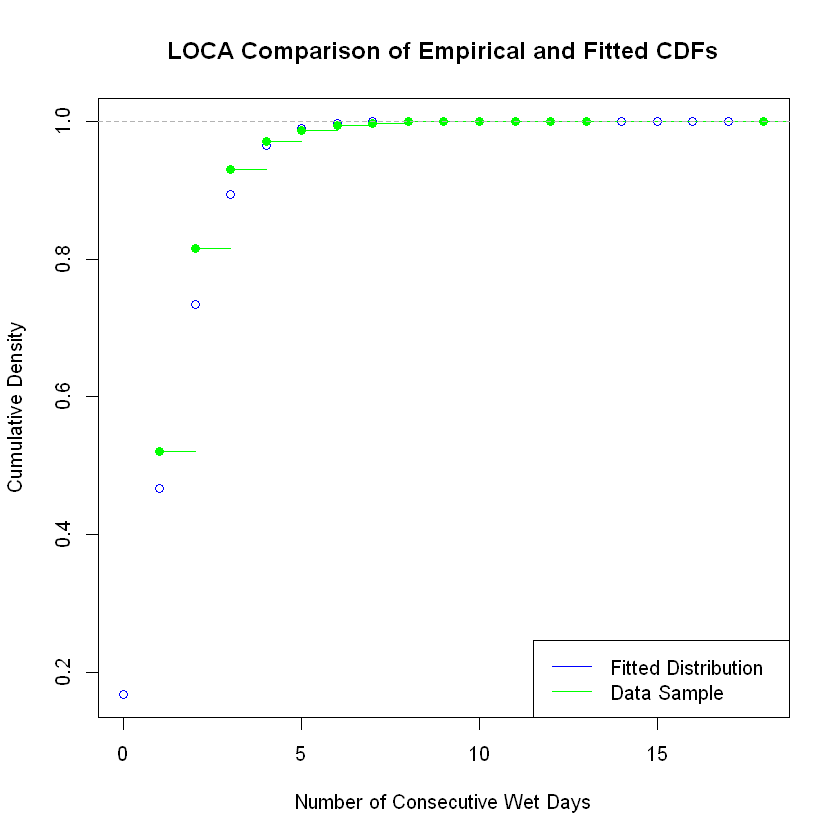

In [185]:
x <- seq(0,dLOJanMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJan_mu, size=LOfdNB_dJan_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJan$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

In [186]:
ks.test( dLOJan$Wet_Count, "pnbinom", mu=LOfdNB_dJan_mu, size=LOfdNB_dJan_size )


	One-sample Kolmogorov-Smirnov test

data:  dLOJan$Wet_Count
D = 0.46681, p-value < 2.2e-16
alternative hypothesis: two-sided


Generally, K-S test is better for continuous distributions.

[Kolmogorv-Smirnov Test](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/ks.test.html)

Null hypothesis that the true distribution function of x is equal to the hypothesized distribution function (one-sample case). This is a comparison of cumulative distribution functions, and the test statistic is the maximum difference in value, with the statistic in the "greater" alternative being D^+ = max[F_x(u) - F_y(u)]

Exact p-values are not available for the two-sample case if one-sided or in the presence of ties. If exact = NULL (the default), an exact p-value is computed if the sample size is less than 100 in the one-sample case and there are no ties, and if the product of the sample sizes is less than 10000 in the two-sample case. Otherwise, asymptotic distributions are used whose approximations may be inaccurate in small samples.

The Kolmogorov–Smirnov statistic quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples. The null distribution of this statistic is calculated under the null hypothesis that the sample is drawn from the reference distribution (in the one-sample case) or that the samples are drawn from the same distribution (in the two-sample case). In the one-sample case, the distribution considered under the null hypothesis may be continuous (see Section 2), purely discrete or mixed (see Section 2.2).

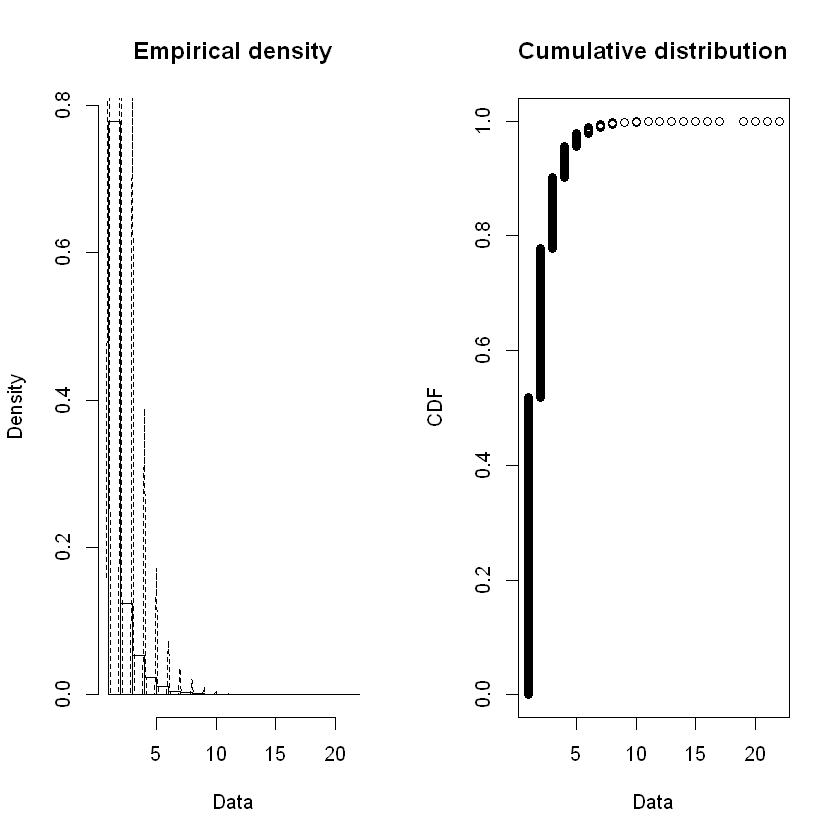

In [187]:
plotdist( dBCJan$Wet_Count, histo=TRUE, demp=TRUE )

In [188]:
BCfd_NB_dJan <- fitdist( dBCJan$Wet_Count, "nbinom" )
BCfd_GE_dJan <- fitdist( dBCJan$Wet_Count, "geom" )

In [189]:
summary( BCfd_NB_dJan )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 2.551997e+06 0.580507561
mu   1.889014e+00 0.001714007
Loglikelihood:  -1000829   AIC:  2001661   BIC:  2001684 
Correlation matrix:
              size            mu
size  1.000000e+00 -1.158325e-07
mu   -1.158325e-07  1.000000e+00


In [190]:
BCfdNB_dJan_size <- BCfd_NB_dJan$estimate[["size"]]
BCfdNB_dJan_mu <- BCfd_NB_dJan$estimate[["mu"]]
cat("BCCA Jan size: ", BCfdNB_dJan_size, "\n", "BCCA Jan mu: ", BCfdNB_dJan_mu, "\n")

BCCA Jan size:  2551997 
 BCCA Jan mu:  1.889014 


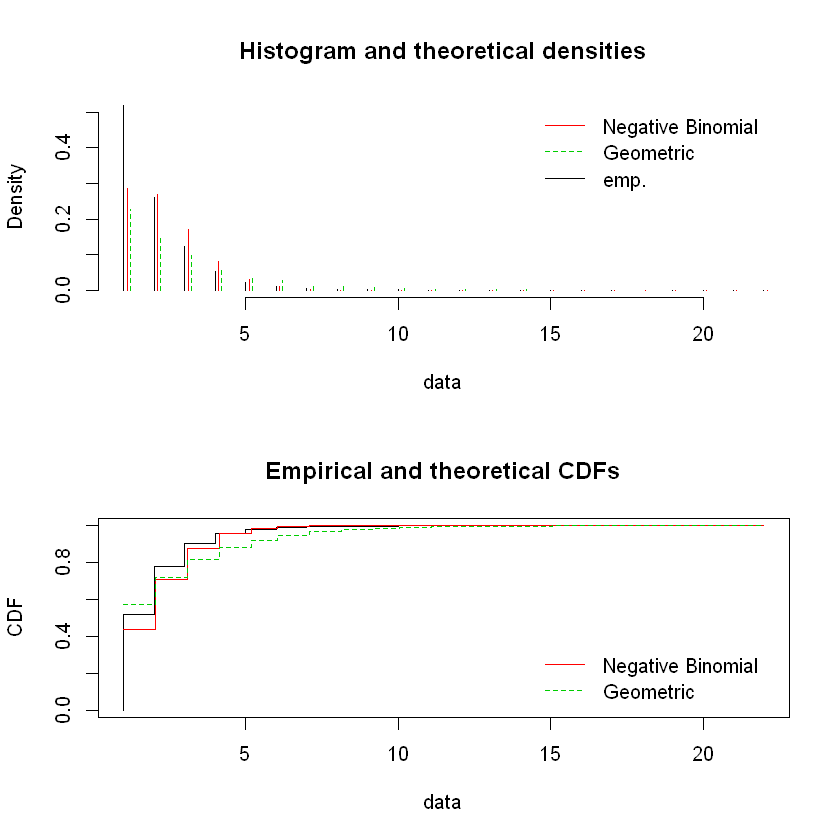

In [191]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJan, BCfd_GE_dJan), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJan, BCfd_GE_dJan), legendtext=plot.legend )

In [192]:
BCstatRes <- gofstat( list(BCfd_NB_dJan, BCfd_GE_dJan), fitnames=c("Negative Binomial", "Geometric") )

In [193]:
print(BCstatRes)

Chi-squared statistic:  60036.37 96339.39 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    333245            280929.5023     368127.832
<= 2    167447            173495.3320      95160.428
<= 3     79376            109245.0410      62220.432
<= 4     34545             51591.3751      40682.689
<= 5     14760             19491.3820      26600.284
<= 6      6877              6136.5897      17392.536
<= 7      3164              1656.0175      11372.070
<= 8      1832               391.0308       7435.603
> 8       1791               100.7296      14045.126

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2001661   2396517
Bayesian Information Criterion           2001684   2396528


In [194]:
BCfdNB_dJan_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [195]:
BCfdNB_dJan_p = BCfdNB_dJan_size / (BCfdNB_dJan_size + BCfdNB_dJan_mu)
cat("BCCA prob: ", BCfdNB_dJan_p)

BCCA prob:  0.9999993

In [196]:
# add to our tracking dataframe
BCMonDistDF[1, ] <- list( 1, dBCJanMean, dBCJanBNr, BCfdNB_dJan_p, BCfdNB_dJan_mu, BCfdNB_dJan_size,
                          BCfdNB_dJan_pvalue )

In [197]:
BCgf_dJan <- goodfit( dBCJan$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJan_size, prob=BCfdNB_dJan_p) )

In [198]:
summary( BCgf_dJan )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          1.244040e+11 22        0
Likelihood Ratio 3.235204e+05 20        0


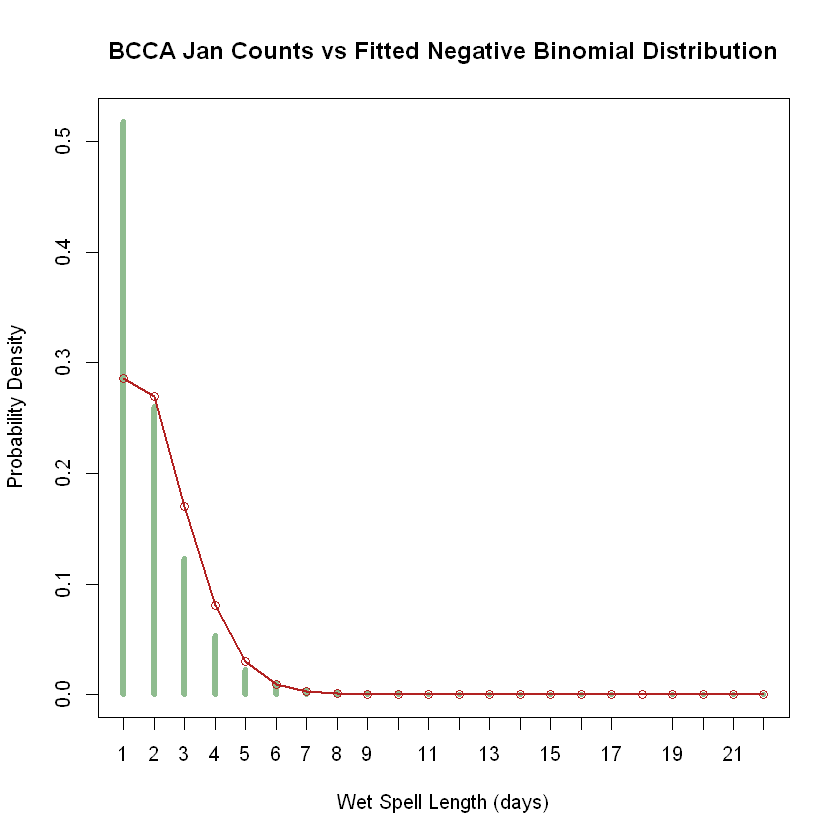

In [199]:
maxP <- max(dBCJan$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJan_size, mu=BCfdNB_dJan_mu )
ttab <- table( dBCJan$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jan Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

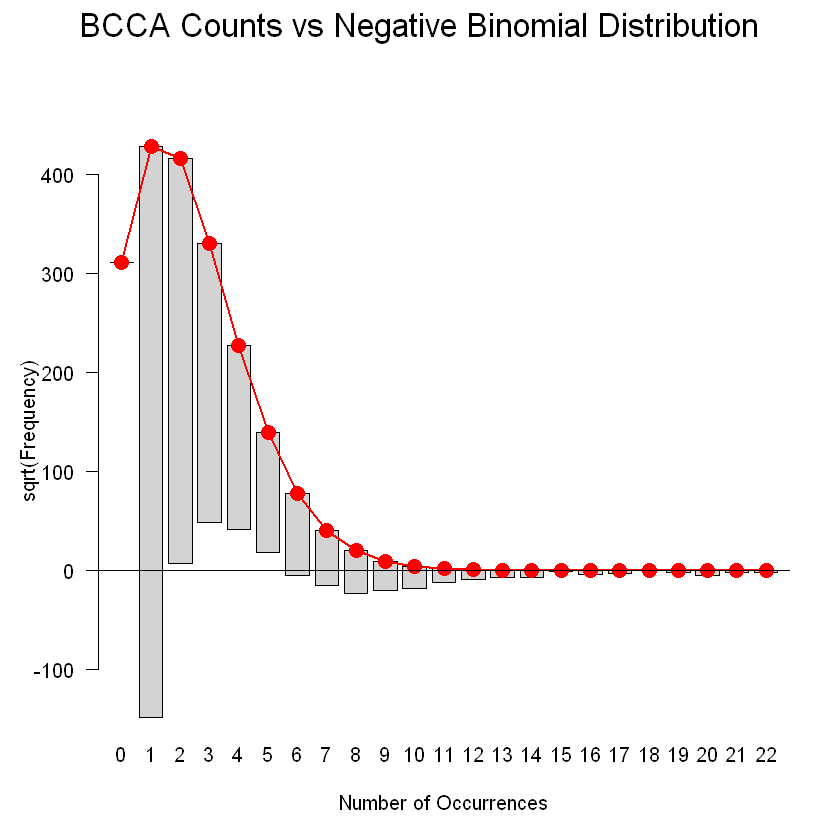

In [200]:
plot( BCgf_dJan, main="BCCA Counts vs Negative Binomial Distribution" )

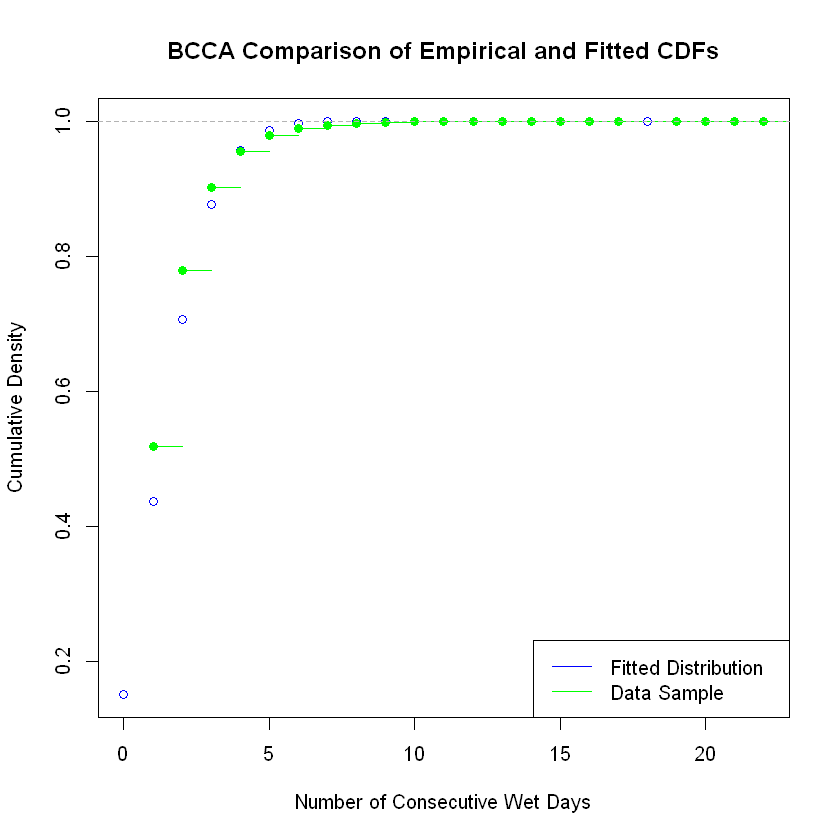

In [201]:
x <- seq(0,dBCJanMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJan_mu, size=BCfdNB_dJan_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJan$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

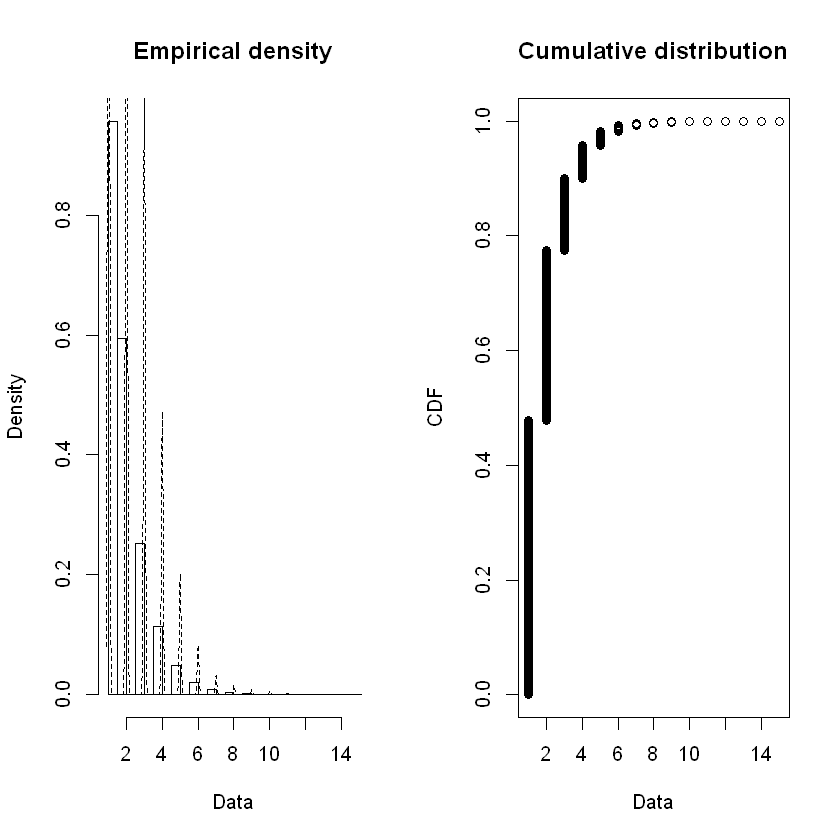

In [202]:
plotdist( dLOFeb$Wet_Count, histo=TRUE, demp=TRUE )

In [203]:
LOfd_NB_dFeb <- fitdist( dLOFeb$Wet_Count, "nbinom" )
LOfd_GE_dFeb <- fitdist( dLOFeb$Wet_Count, "geom" )

In [204]:
LOfdNB_dFeb_size <- LOfd_NB_dFeb$estimate[["size"]]
LOfdNB_dFeb_mu <- LOfd_NB_dFeb$estimate[["mu"]]
cat("LOCA Feb size: ", LOfdNB_dFeb_size, "\n", "LOCA Feb mu: ", LOfdNB_dFeb_mu, "\n")

LOCA Feb size:  831426 
 LOCA Feb mu:  1.919722 


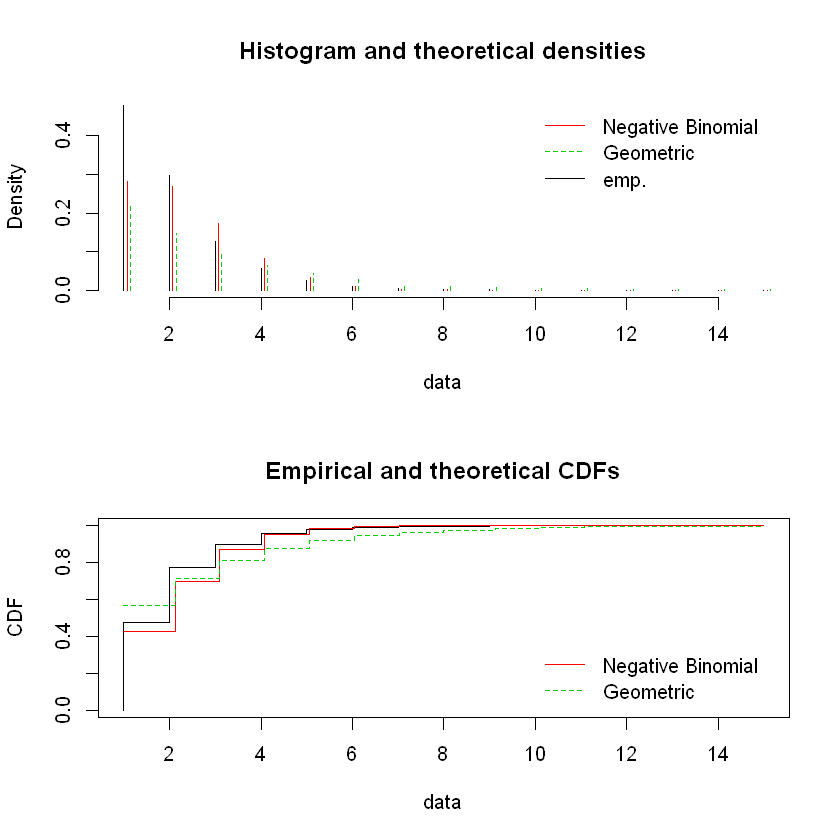

In [205]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dFeb, LOfd_GE_dFeb), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dFeb, LOfd_GE_dFeb), legendtext=plot.legend )

In [206]:
LOstatRes <- gofstat( list(LOfd_NB_dFeb, LOfd_GE_dFeb), fitnames=c("Negative Binomial", "Geometric") )

In [207]:
print( LOstatRes )

Chi-squared statistic:  56474.85 207604.5 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    429936           384874.30767      510269.15
<= 2    267039           242897.59193      133092.84
<= 3    113043           155431.94574       87510.72
<= 4     51117            74596.61896       57539.74
<= 5     21837            28641.02216       37833.32
<= 6      8949             9163.83285       24876.03
<= 7      3522             2513.15652       16356.40
<= 9      2576              731.71189       17825.93
> 9        861               29.81227       13575.87

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2774158   3373492
Bayesian Information Criterion           2774181   3373503


In [208]:
LOfdNB_dFeb_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [209]:
LOfdNB_dFeb_p = LOfdNB_dFeb_size / (LOfdNB_dFeb_size + LOfdNB_dFeb_mu)
cat("LOCA prob: ", LOfdNB_dFeb_p)

LOCA prob:  0.9999977

In [210]:
# add to our tracking dataframe
LOMonDistDF[2, ] <- list( 2, dLOFebMean, dLOFebBNr, LOfdNB_dFeb_p, LOfdNB_dFeb_mu, LOfdNB_dFeb_size,
                          LOfdNB_dFeb_pvalue )

In [211]:
LOgf_dFeb <- goodfit( dLOFeb$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dFeb_size, prob=LOfdNB_dFeb_p) )

In [212]:
summary( LOgf_dFeb )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          403149.9 15        0
Likelihood Ratio 398888.8 14        0


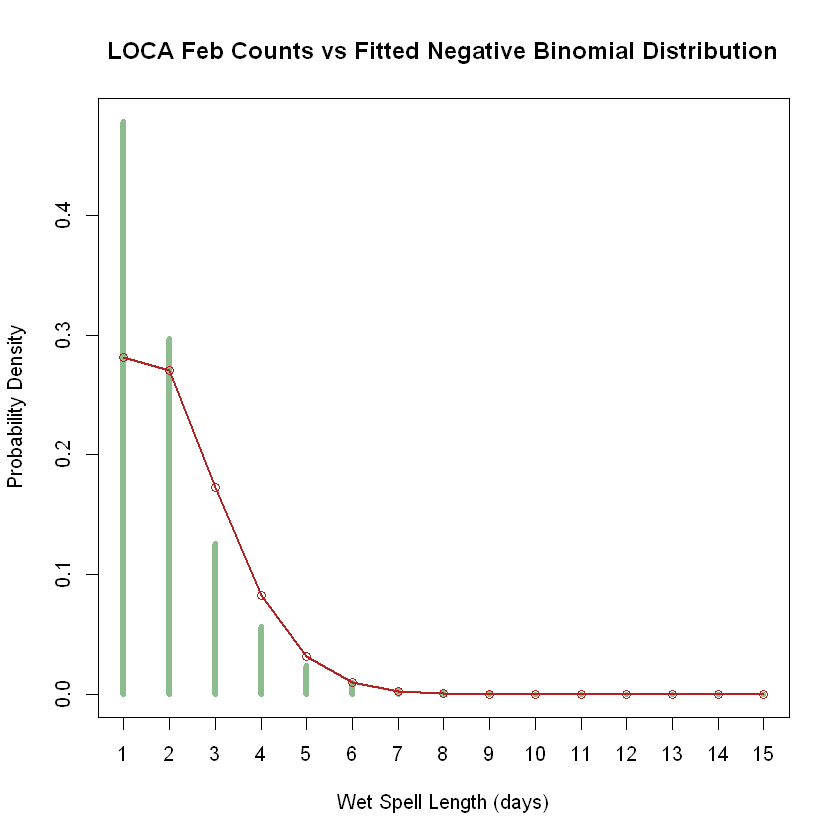

In [213]:
maxP <- max(dLOFeb$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dFeb_size, mu=LOfdNB_dFeb_mu )
ttab <- table( dLOFeb$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Feb Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

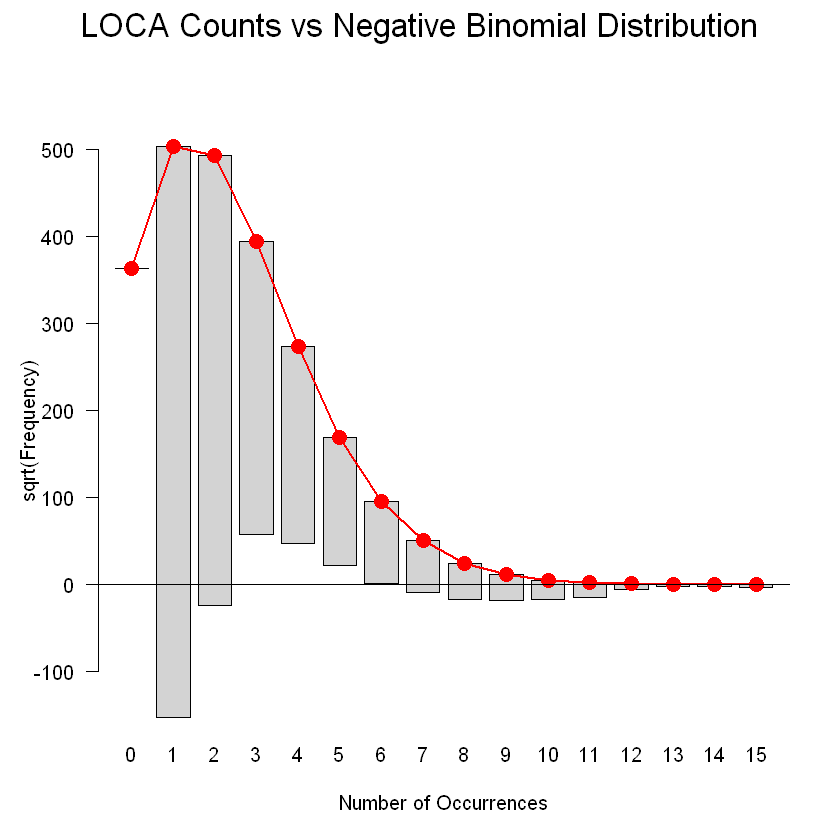

In [214]:
plot( LOgf_dFeb, main="LOCA Counts vs Negative Binomial Distribution" )

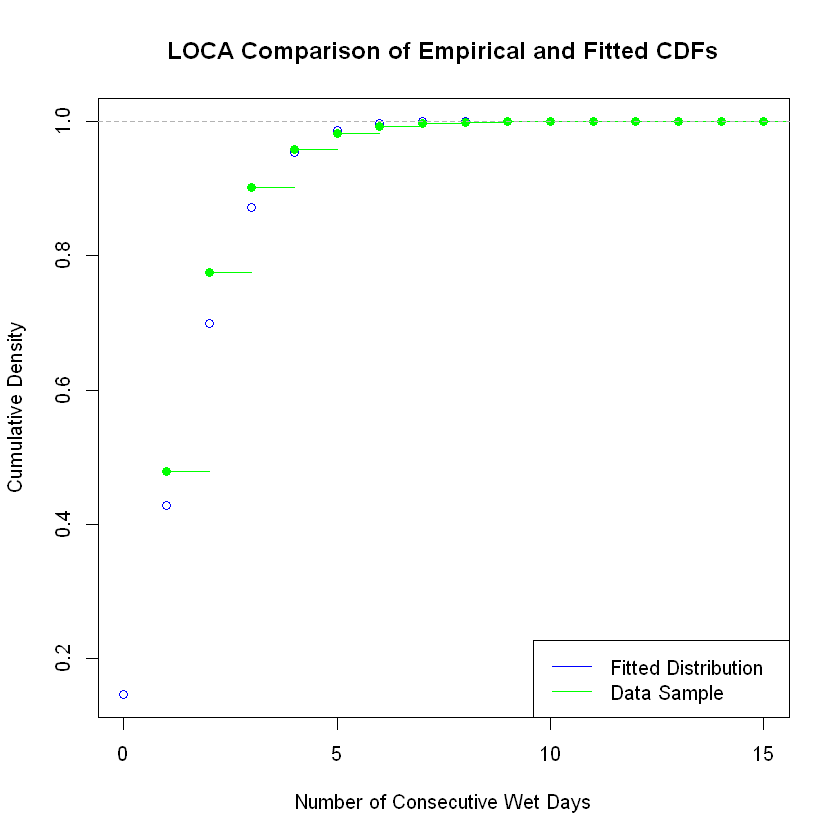

In [215]:
x <- seq(0,dLOFebMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dFeb_mu, size=LOfdNB_dFeb_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOFeb$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

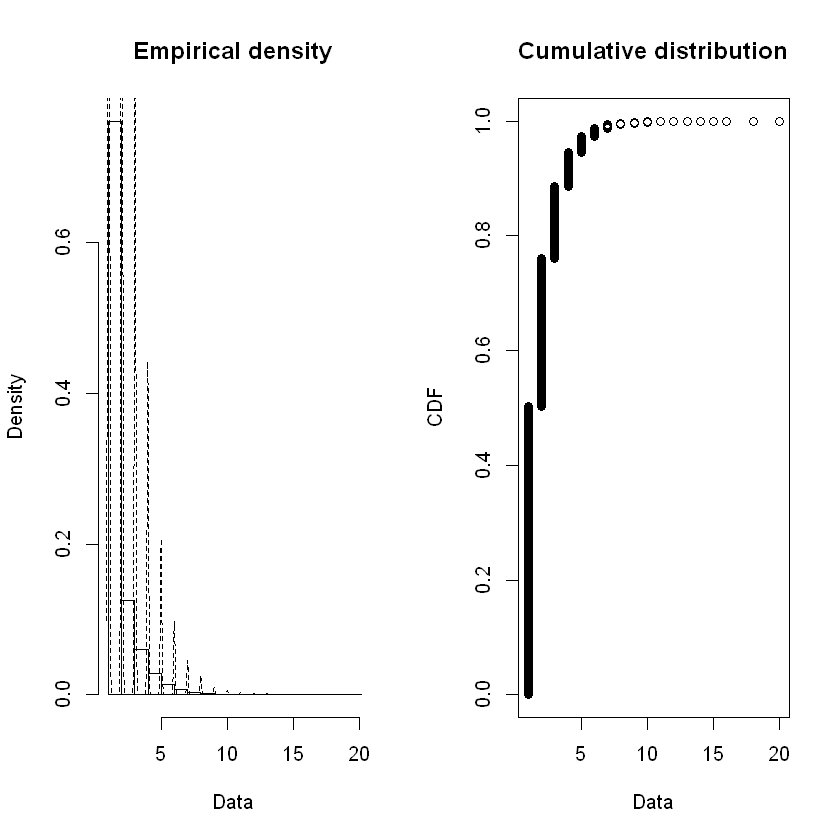

In [216]:
plotdist( dBCFeb$Wet_Count, histo=TRUE, demp=TRUE )

In [217]:
BCfd_NB_dFeb <- fitdist( dBCFeb$Wet_Count, "nbinom" )
BCfd_GE_dFeb <- fitdist( dBCFeb$Wet_Count, "geom" )

In [218]:
summary( BCfd_NB_dFeb )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 1.490599e+06         NaN
mu   1.955756e+00 0.001751972
Loglikelihood:  -1016574   AIC:  2033152   BIC:  2033175 
Correlation matrix:
     size  mu
size    1 NaN
mu    NaN   1


In [219]:
BCfdNB_dFeb_size <- BCfd_NB_dFeb$estimate[["size"]]
BCfdNB_dFeb_mu <- BCfd_NB_dFeb$estimate[["mu"]]
cat("BCCA Feb size: ", BCfdNB_dFeb_size, "\n", "BCCA Feb mu: ", BCfdNB_dFeb_mu, "\n")

BCCA Feb size:  1490599 
 BCCA Feb mu:  1.955756 


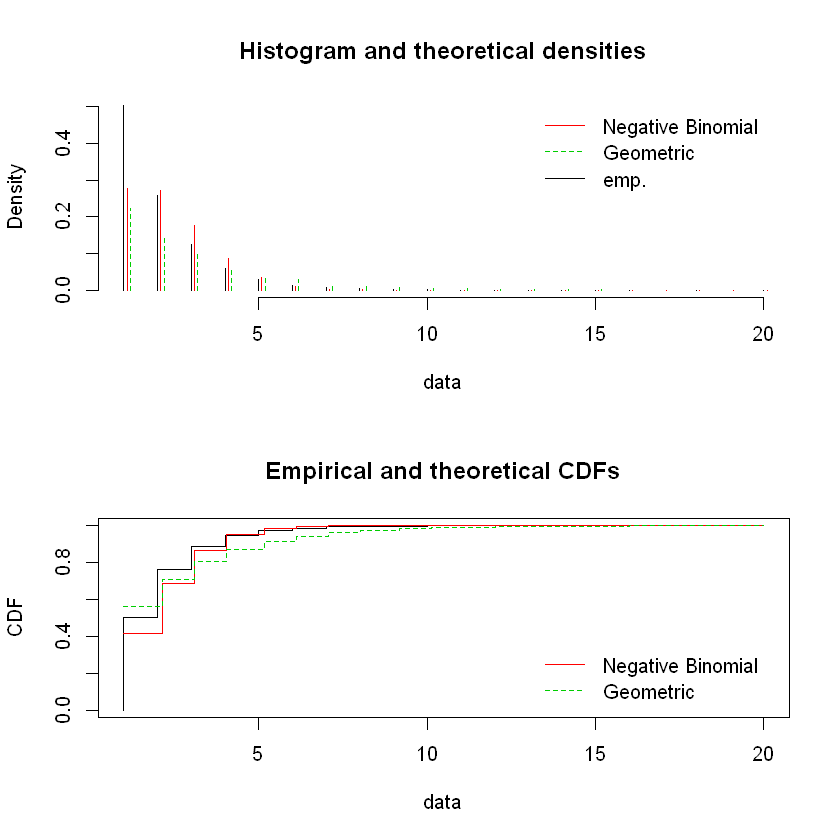

In [220]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dFeb, BCfd_GE_dFeb), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dFeb, BCfd_GE_dFeb), legendtext=plot.legend )

In [221]:
BCstatRes <- gofstat( list(BCfd_NB_dFeb, BCfd_GE_dFeb), fitnames=c("Negative Binomial", "Geometric") )

In [222]:
print(BCstatRes)

Chi-squared statistic:  59122.88 91361.65 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    320154            266397.5556     358179.265
<= 2    164873            172369.5593      94375.557
<= 3     79491            112370.9443      62447.358
<= 4     38063             54942.5794      41320.790
<= 5     18114             21490.8868      27341.551
<= 6      8424              7005.1699      18091.630
<= 7      3973              1957.2059      11971.050
<= 8      2148               478.4788       7921.123
> 8       1901               128.6200      15492.676

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2033152   2410287
Bayesian Information Criterion           2033175   2410298


In [223]:
BCfdNB_dFeb_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [224]:
BCfdNB_dFeb_p = BCfdNB_dFeb_size / (BCfdNB_dFeb_size + BCfdNB_dFeb_mu)
cat("BCCA prob: ", BCfdNB_dFeb_p)

BCCA prob:  0.9999987

In [225]:
# add to our tracking dataframe
BCMonDistDF[2, ] <- list( 2, dBCFebMean, dBCFebBNr, BCfdNB_dFeb_p, BCfdNB_dFeb_mu, BCfdNB_dFeb_size,
                          BCfdNB_dFeb_pvalue )

In [226]:
BCgf_dFeb <- goodfit( dBCFeb$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dFeb_size, prob=BCfdNB_dFeb_p) )

In [227]:
summary( BCgf_dFeb )


	 Goodness-of-fit test for nbinomial distribution

                         X^2 df P(> X^2)
Pearson          596126057.7 20        0
Likelihood Ratio    306815.5 17        0


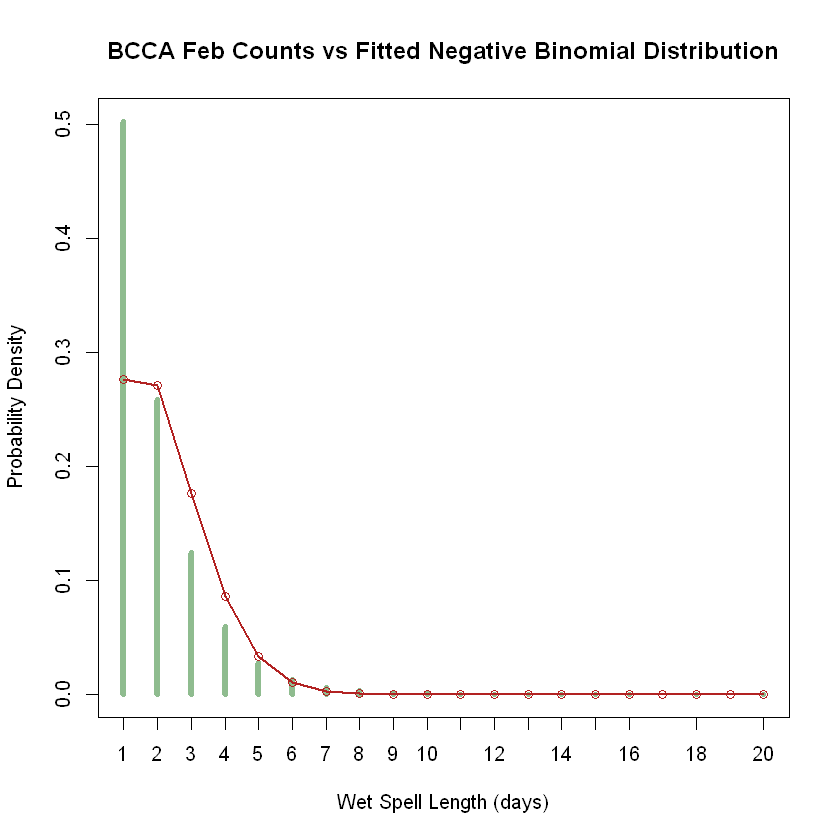

In [228]:
maxP <- max(dBCFeb$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dFeb_size, mu=BCfdNB_dFeb_mu )
ttab <- table( dBCFeb$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Feb Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

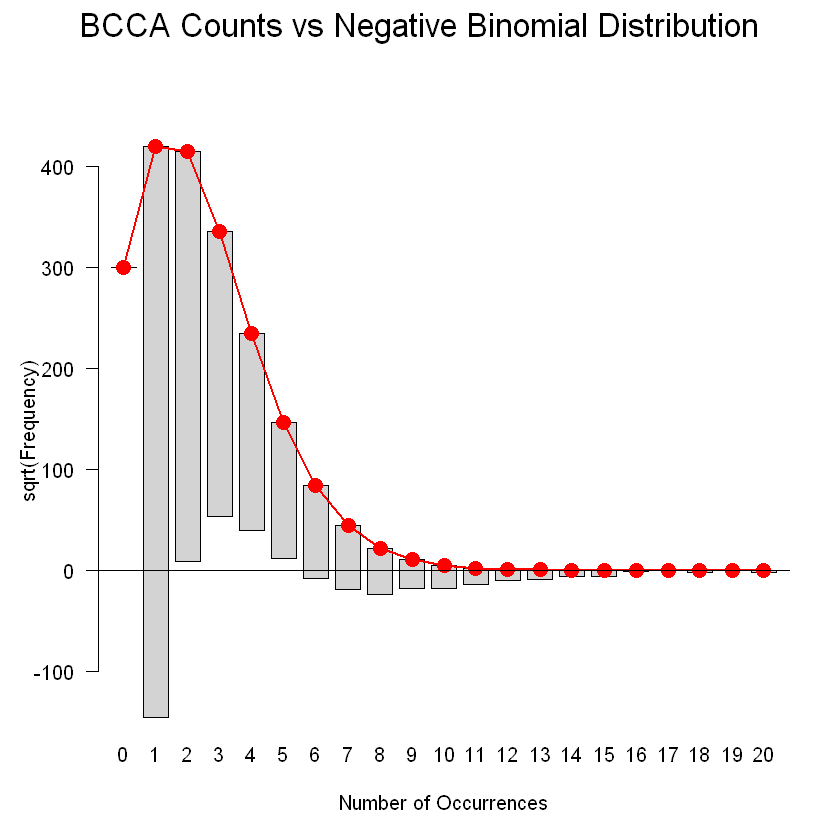

In [229]:
plot( BCgf_dFeb, main="BCCA Counts vs Negative Binomial Distribution" )

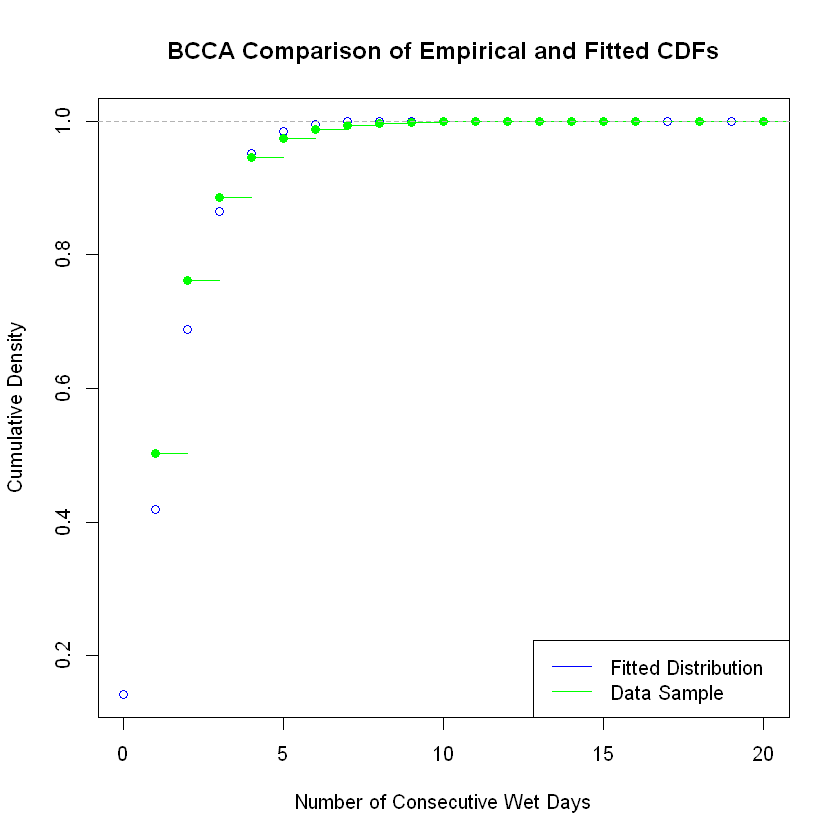

In [230]:
x <- seq(0,dBCFebMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dFeb_mu, size=BCfdNB_dFeb_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCFeb$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

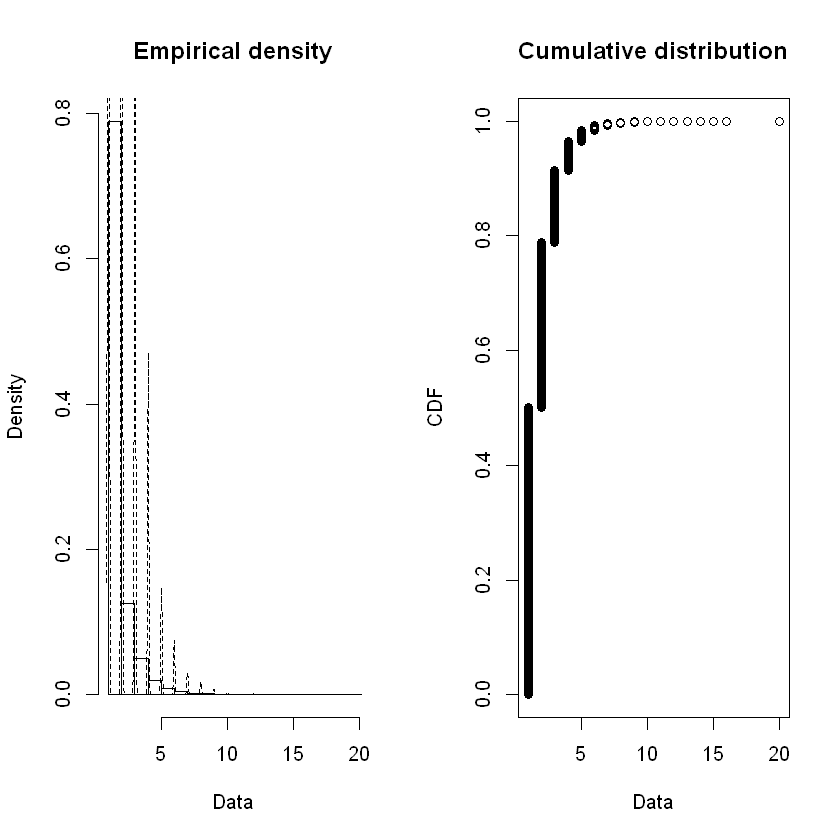

In [231]:
plotdist( dLOMar$Wet_Count, histo=TRUE, demp=TRUE )

In [232]:
LOfd_NB_dMar <- fitdist( dLOMar$Wet_Count, "nbinom" )
LOfd_GE_dMar <- fitdist( dLOMar$Wet_Count, "geom" )

In [233]:
LOfdNB_dMar_size <- LOfd_NB_dMar$estimate[["size"]]
LOfdNB_dMar_mu <- LOfd_NB_dMar$estimate[["mu"]]
cat("LOCA Mar size: ", LOfdNB_dMar_size, "\n", "LOCA Mar mu: ", LOfdNB_dMar_mu, "\n")

LOCA Mar size:  4317364 
 LOCA Mar mu:  1.863773 


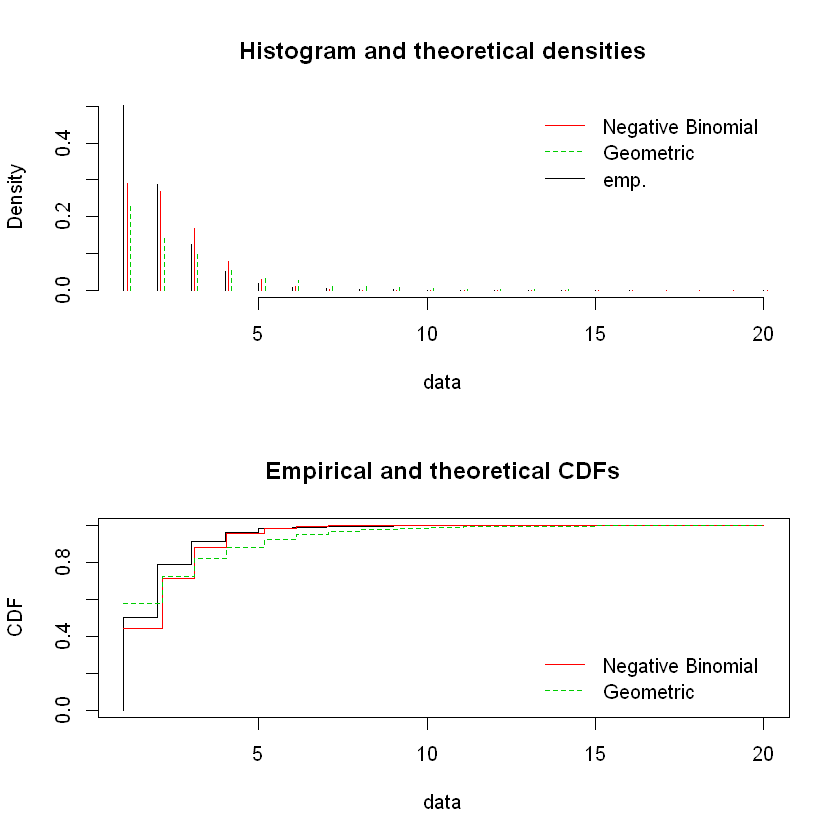

In [234]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dMar, LOfd_GE_dMar), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dMar, LOfd_GE_dMar), legendtext=plot.legend )

In [235]:
LOstatRes <- gofstat( list(LOfd_NB_dMar, LOfd_GE_dMar), fitnames=c("Negative Binomial", "Geometric") )

In [236]:
print( LOstatRes )

Chi-squared statistic:  69932.58 207725.1 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    490322           434499.45724      563967.16
<= 2    281657           263515.73034      144692.33
<= 3    122403           163711.17662       94164.56
<= 4     49211            76280.13949       61281.51
<= 5     18678            28433.78760       39881.50
<= 6      8324             8832.36088       25954.54
<= 7      3847             2351.64741       16891.00
<= 9      2986              661.32363       18146.36
> 9        883               25.37678       13332.04

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2974512   3624906
Bayesian Information Criterion           2974535   3624918


In [237]:
LOfdNB_dMar_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [238]:
LOfdNB_dMar_p = LOfdNB_dMar_size / (LOfdNB_dMar_size + LOfdNB_dMar_mu)
cat("LOCA prob: ", LOfdNB_dMar_p)

LOCA prob:  0.9999996

In [239]:
# add to our tracking dataframe
LOMonDistDF[3, ] <- list( 3, dLOMarMean, dLOMarBNr, LOfdNB_dMar_p, LOfdNB_dMar_mu, LOfdNB_dMar_size,
                          LOfdNB_dMar_pvalue )

In [240]:
LOgf_dMar <- goodfit( dLOMar$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dMar_size, prob=LOfdNB_dMar_p) )

In [241]:
summary( LOgf_dMar )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          3.866758e+10 20        0
Likelihood Ratio 4.692416e+05 16        0


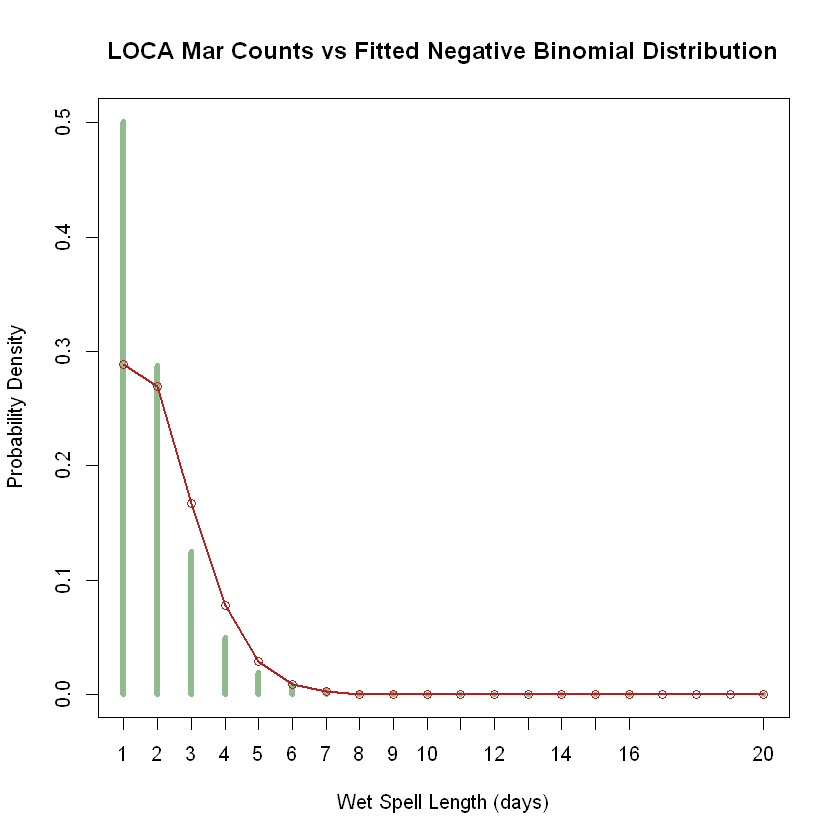

In [242]:
maxP <- max(dLOMar$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dMar_size, mu=LOfdNB_dMar_mu )
ttab <- table( dLOMar$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Mar Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

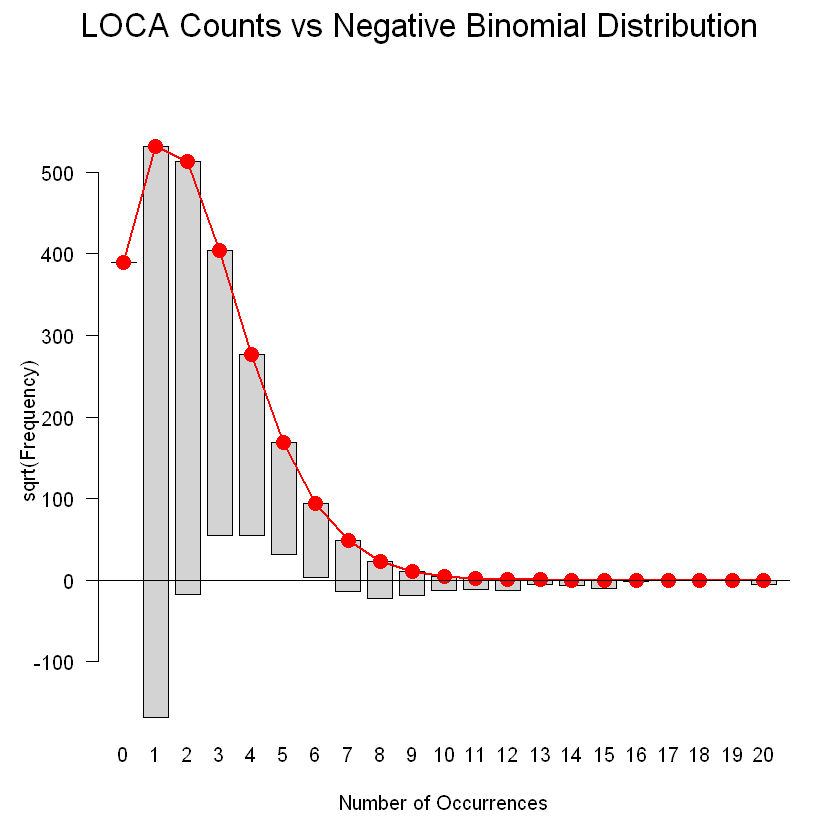

In [243]:
plot( LOgf_dMar, main="LOCA Counts vs Negative Binomial Distribution" )

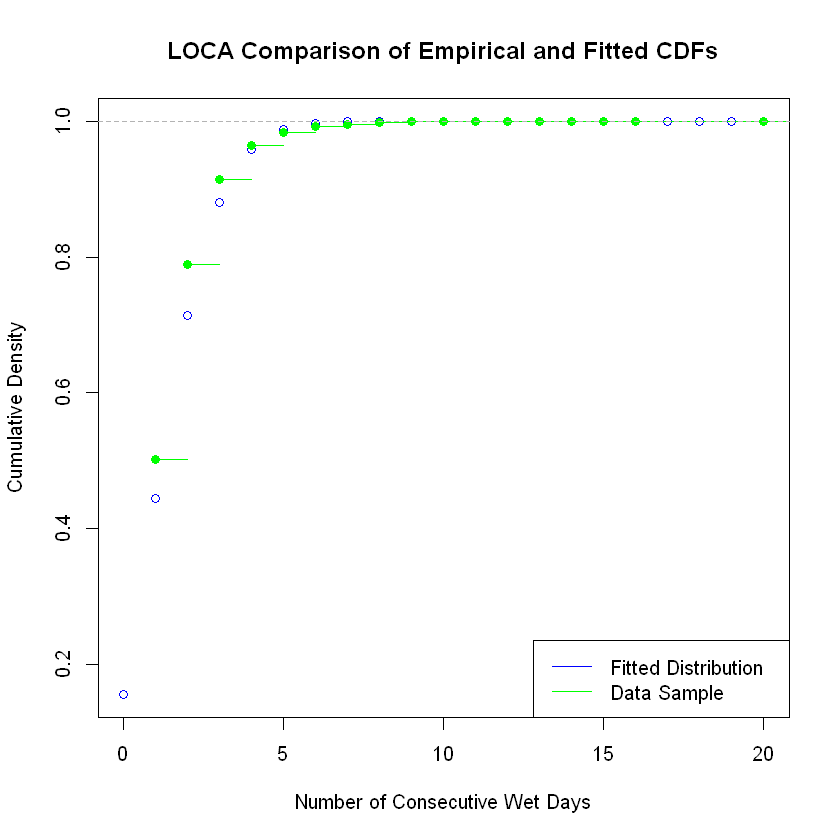

In [244]:
x <- seq(0,dLOMarMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dMar_mu, size=LOfdNB_dMar_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOMar$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

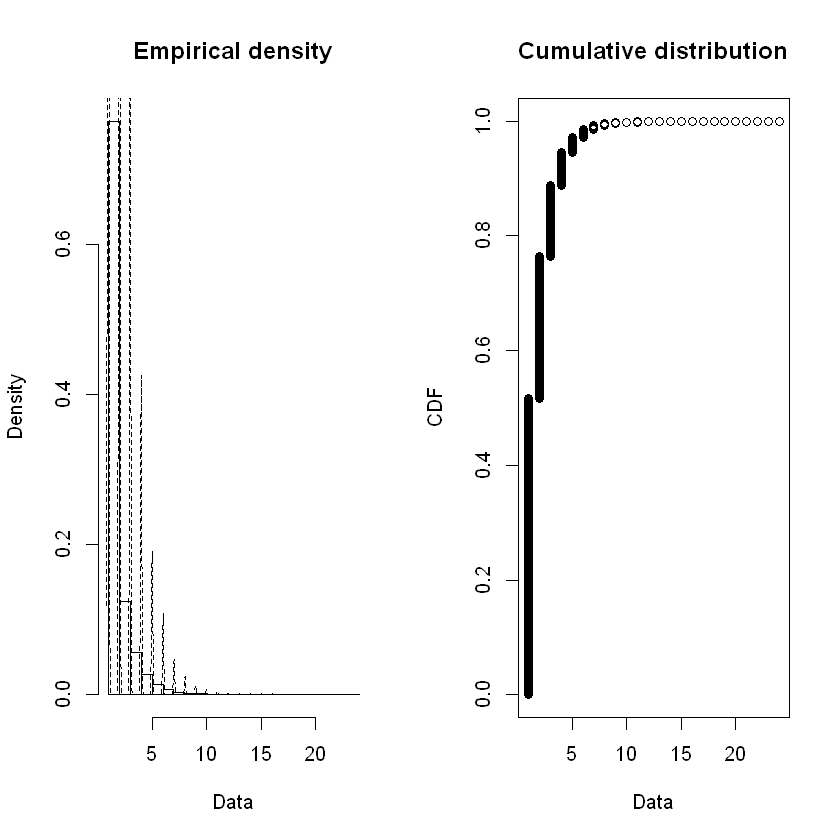

In [245]:
plotdist( dBCMar$Wet_Count, histo=TRUE, demp=TRUE )

In [246]:
BCfd_NB_dMar <- fitdist( dBCMar$Wet_Count, "nbinom" )
BCfd_GE_dMar <- fitdist( dBCMar$Wet_Count, "geom" )

In [247]:
summary( BCfd_NB_dMar )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
       estimate   Std. Error
size 284.803262 23.930363696
mu     1.948666  0.001636554
Loglikelihood:  -1178920   AIC:  2357844   BIC:  2357867 
Correlation matrix:
             size           mu
size 1.000000e+00 2.963488e-05
mu   2.963488e-05 1.000000e+00


In [248]:
BCfdNB_dMar_size <- BCfd_NB_dMar$estimate[["size"]]
BCfdNB_dMar_mu <- BCfd_NB_dMar$estimate[["mu"]]
cat("BCCA Mar size: ", BCfdNB_dMar_size, "\n", "BCCA Mar mu: ", BCfdNB_dMar_mu, "\n")

BCCA Mar size:  284.8033 
 BCCA Mar mu:  1.948666 


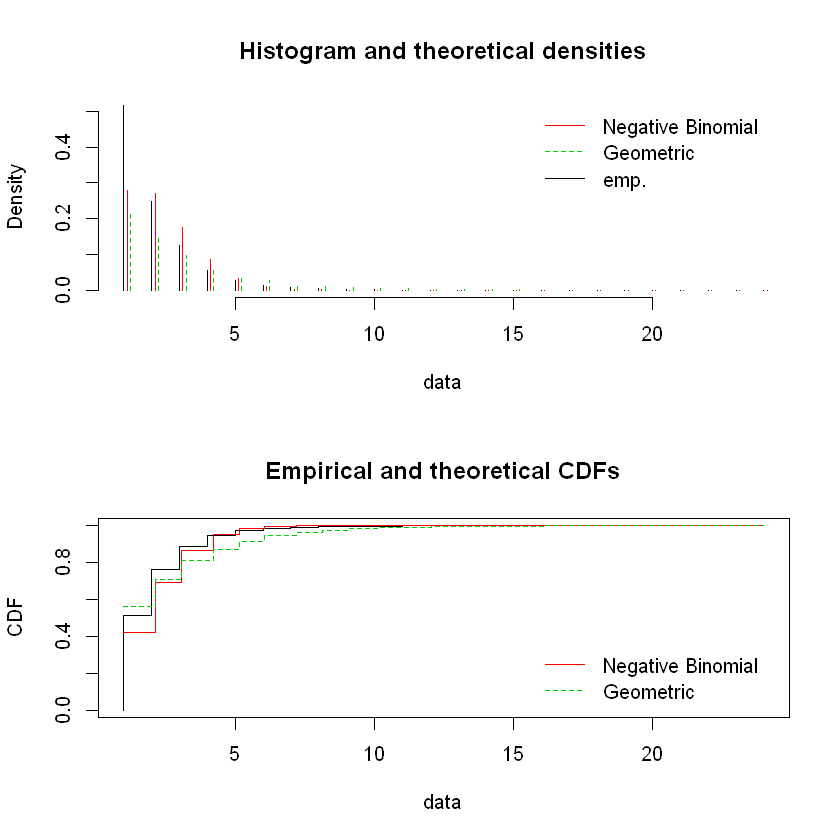

In [249]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dMar, BCfd_GE_dMar), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dMar, BCfd_GE_dMar), legendtext=plot.legend )

In [250]:
BCstatRes <- gofstat( list(BCfd_NB_dMar, BCfd_GE_dMar), fitnames=c("Negative Binomial", "Geometric") )

In [251]:
print(BCstatRes)

Chi-squared statistic:  319606.4 90595.3 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     377921           3.083869e+05     412616.209
<= 2     181899           1.974555e+05     108501.548
<= 3      91040           1.282812e+05      71704.719
<= 4      41348           6.272344e+04      47387.035
<= 5      19887           2.462028e+04      31316.365
<= 6       9934           8.081202e+03      20695.844
<= 7       4820           2.281435e+03      13677.129
<= 8       2547           5.655088e+02       9038.716
<= 10      1980           1.499897e+02       9920.933
> 10       1175           5.445806e+00       7692.503

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2357844   2766855
Bayesian Information Criterion           2357867   2766867


In [252]:
BCfdNB_dMar_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [253]:
BCfdNB_dMar_p = BCfdNB_dMar_size / (BCfdNB_dMar_size + BCfdNB_dMar_mu)
cat("BCCA prob: ", BCfdNB_dMar_p)

BCCA prob:  0.9932044

In [254]:
# add to our tracking dataframe
BCMonDistDF[3, ] <- list( 3, dBCMarMean, dBCMarBNr, BCfdNB_dMar_p, BCfdNB_dMar_mu, BCfdNB_dMar_size,
                          BCfdNB_dMar_pvalue )

In [255]:
BCgf_dMar <- goodfit( dBCMar$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dMar_size, prob=BCfdNB_dMar_p) )

In [256]:
summary( BCgf_dMar )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               Inf 24        0
Likelihood Ratio 381589.9 23        0


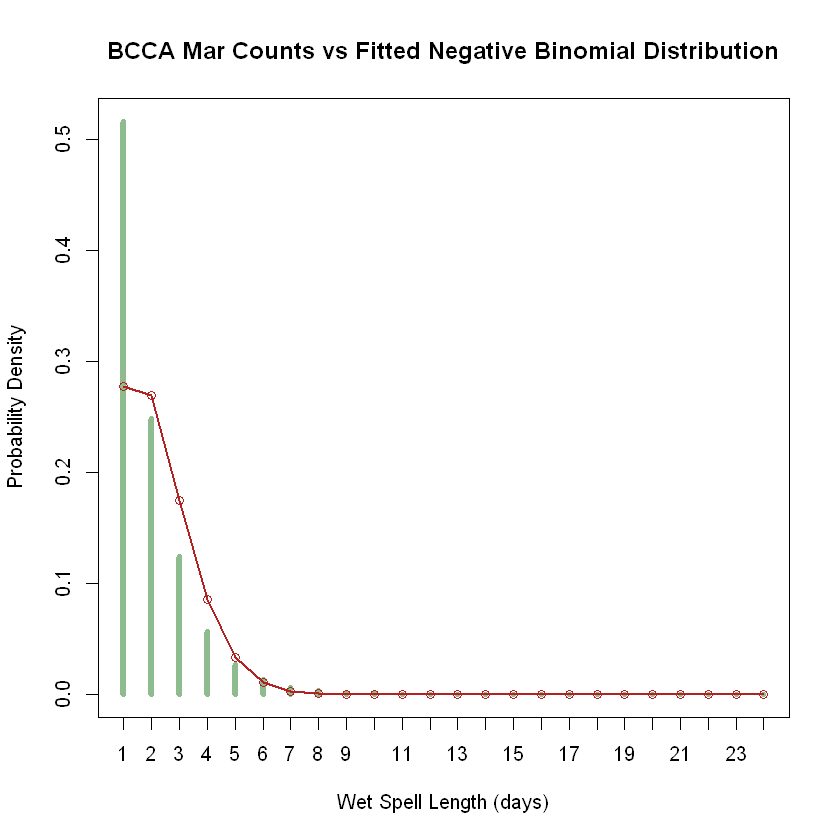

In [257]:
maxP <- max(dBCMar$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dMar_size, mu=BCfdNB_dMar_mu )
ttab <- table( dBCMar$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Mar Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

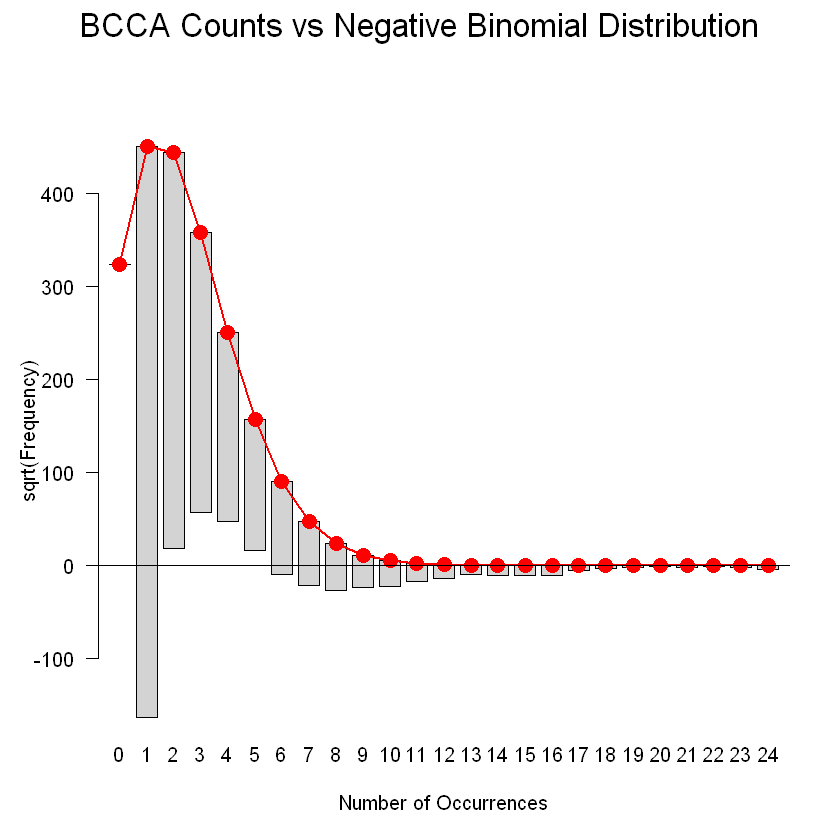

In [258]:
plot( BCgf_dMar, main="BCCA Counts vs Negative Binomial Distribution" )

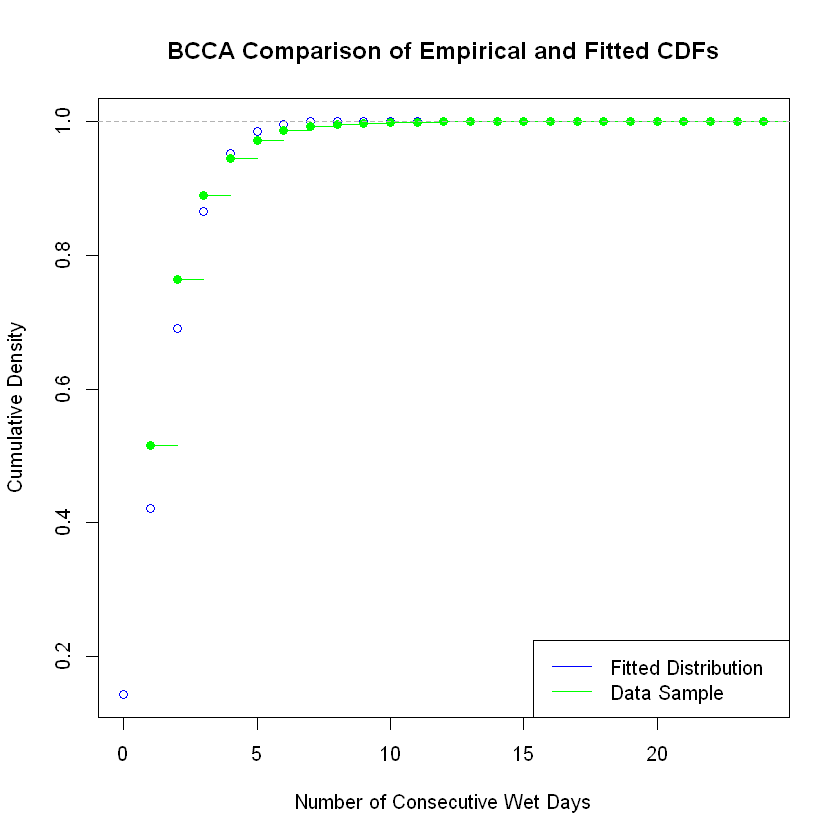

In [259]:
x <- seq(0,dBCMarMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dMar_mu, size=BCfdNB_dMar_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCMar$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

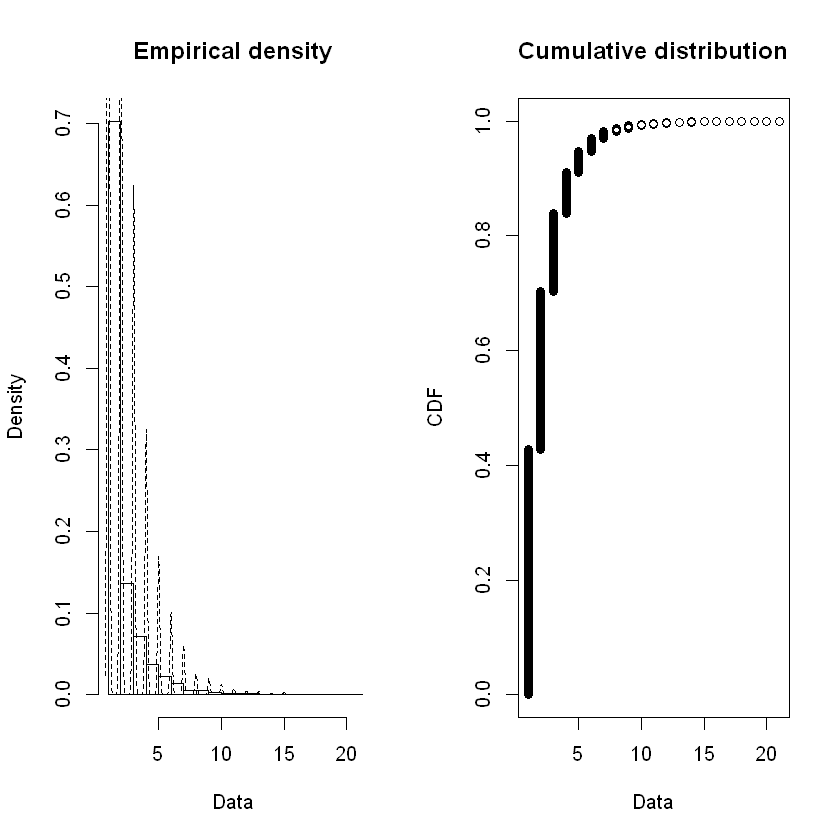

In [260]:
plotdist( dLOApr$Wet_Count, histo=TRUE, demp=TRUE )

In [261]:
LOfd_NB_dApr <- fitdist( dLOApr$Wet_Count, "nbinom" )
LOfd_GE_dApr <- fitdist( dLOApr$Wet_Count, "geom" )

In [262]:
LOfdNB_dApr_size <- LOfd_NB_dApr$estimate[["size"]]
LOfdNB_dApr_mu <- LOfd_NB_dApr$estimate[["mu"]]
cat("LOCA Apr size: ", LOfdNB_dApr_size, "\n", "LOCA Apr mu: ", LOfdNB_dApr_mu, "\n")

LOCA Apr size:  12.62425 
 LOCA Apr mu:  2.253492 


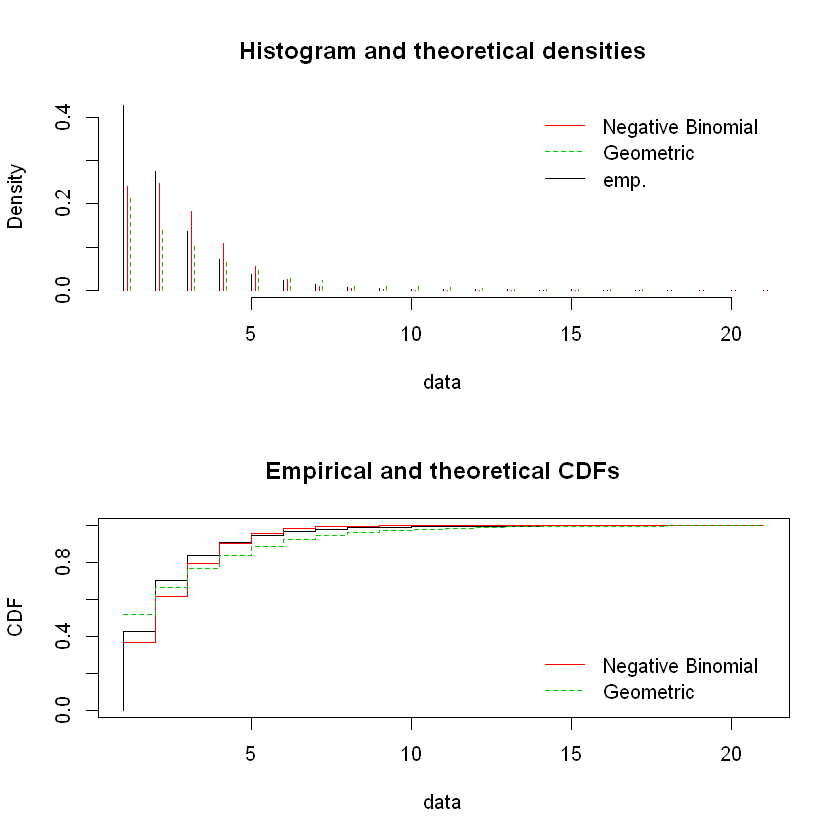

In [263]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dApr, LOfd_GE_dApr), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dApr, LOfd_GE_dApr), legendtext=plot.legend )

In [264]:
LOstatRes <- gofstat( list(LOfd_NB_dApr, LOfd_GE_dApr), fitnames=c("Negative Binomial", "Geometric") )

In [265]:
print( LOstatRes )

Chi-squared statistic:  421075.9 195480.8 
Degree of freedom of the Chi-squared distribution:  9 10 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     480260           411354.46990     584409.650
<= 2     309166           278693.53193     165641.407
<= 3     152786           205777.64679     114730.029
<= 4      80417           121746.46097      79466.722
<= 5      41716            61312.26577      55041.909
<= 6      24388            27278.82907      38124.283
<= 7      14773            10993.23326      26406.441
<= 8       6419             4084.58080      18290.184
<= 9       5051             1417.75803      12668.531
<= 10      3040              464.36784       8774.744
<= 12      3022              187.80255      10287.445
> 12       2290               17.05308       9486.655

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3971992   4509784
Bayesia

In [266]:
LOfdNB_dApr_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [267]:
LOfdNB_dApr_p = LOfdNB_dApr_size / (LOfdNB_dApr_size + LOfdNB_dApr_mu)
cat("LOCA prob: ", LOfdNB_dApr_p)

LOCA prob:  0.8485327

In [268]:
# add to our tracking dataframe
LOMonDistDF[4, ] <- list( 4, dLOAprMean, dLOAprBNr, LOfdNB_dApr_p, LOfdNB_dApr_mu, LOfdNB_dApr_size,
                          LOfdNB_dApr_pvalue )

In [269]:
LOgf_dApr <- goodfit( dLOApr$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dApr_size, prob=LOfdNB_dApr_p) )

In [270]:
summary( LOgf_dApr )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          2991624.7 21        0
Likelihood Ratio  502858.2 20        0


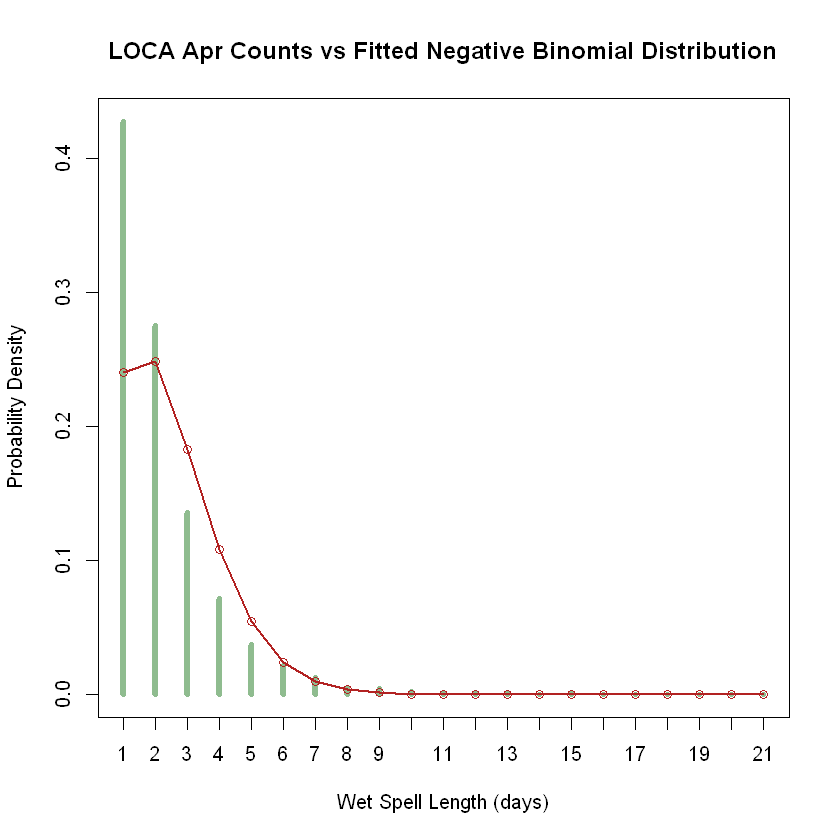

In [271]:
maxP <- max(dLOApr$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dApr_size, mu=LOfdNB_dApr_mu )
ttab <- table( dLOApr$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Apr Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

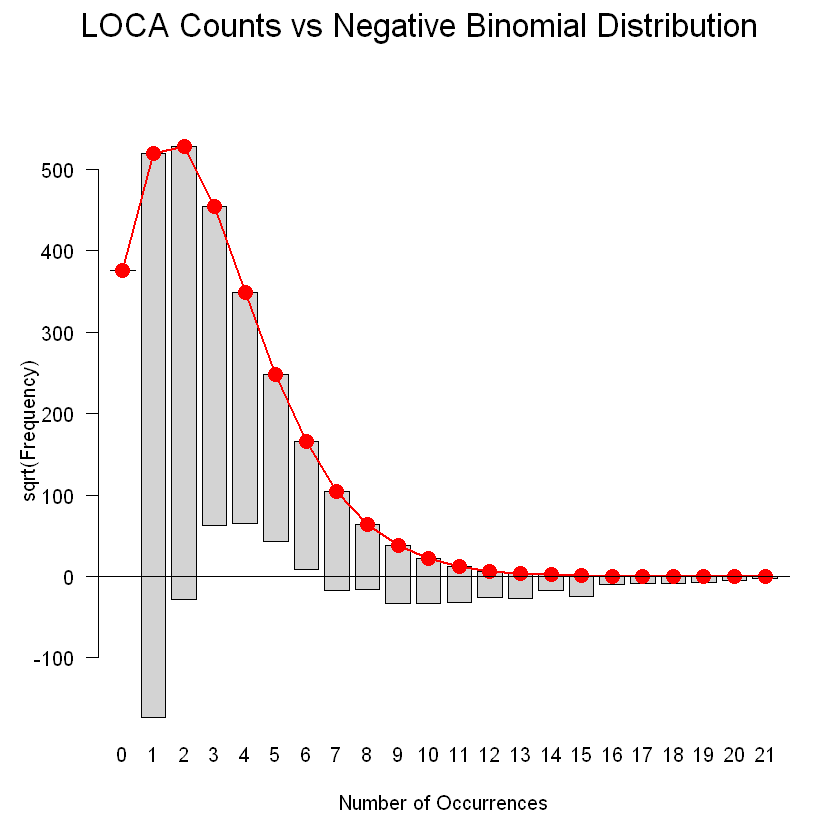

In [272]:
plot( LOgf_dApr, main="LOCA Counts vs Negative Binomial Distribution" )

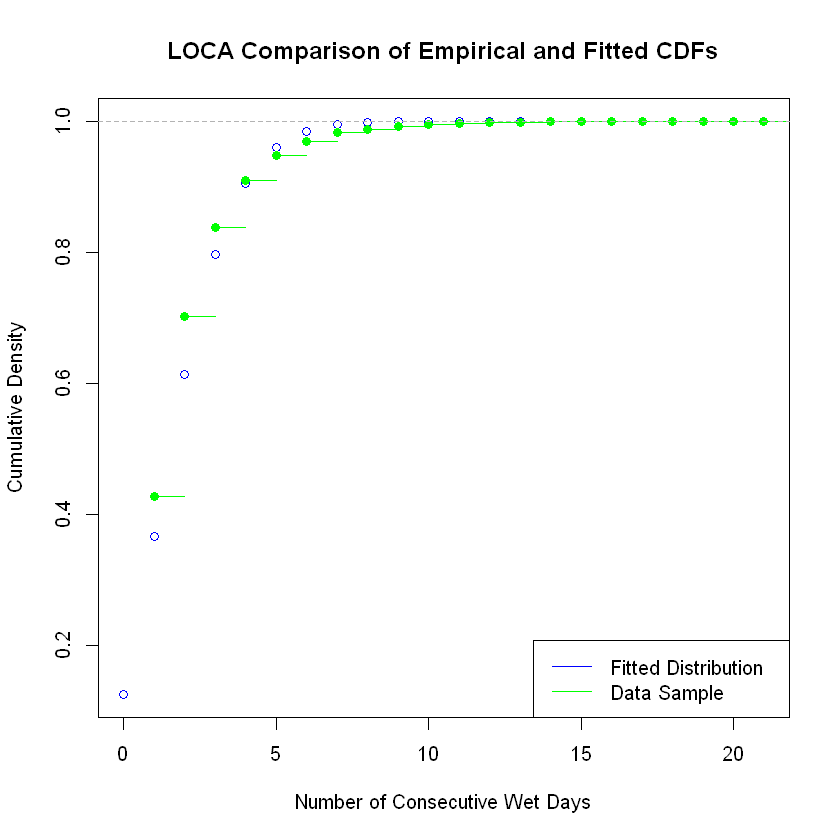

In [273]:
x <- seq(0,dLOAprMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dApr_mu, size=LOfdNB_dApr_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOApr$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

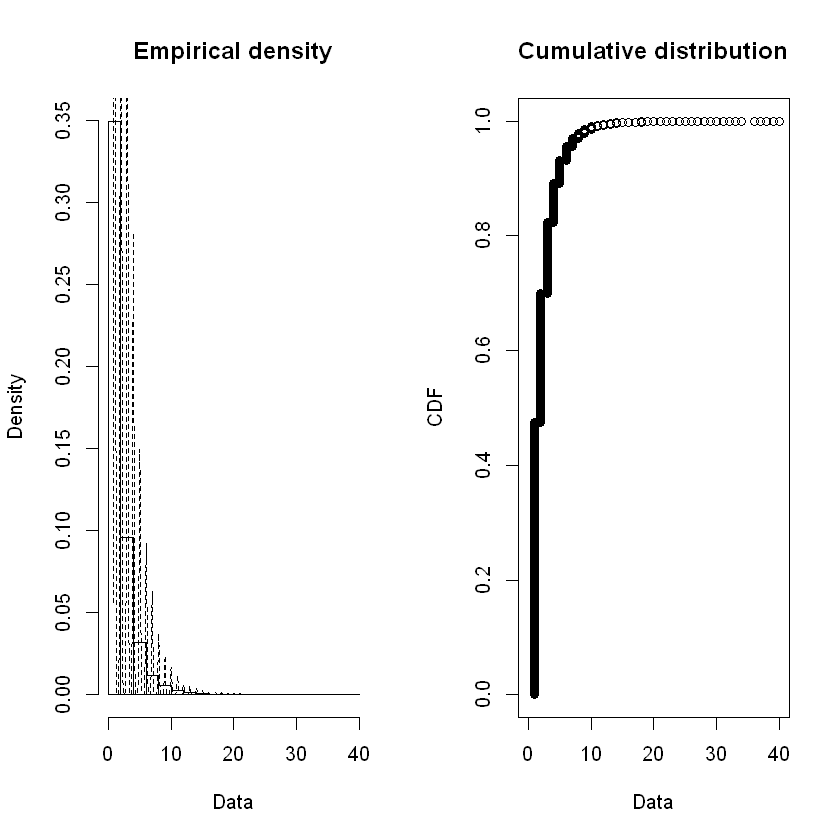

In [274]:
plotdist( dBCApr$Wet_Count, histo=TRUE, demp=TRUE )

In [275]:
BCfd_NB_dApr <- fitdist( dBCApr$Wet_Count, "nbinom" )
BCfd_GE_dApr <- fitdist( dBCApr$Wet_Count, "geom" )

In [276]:
summary( BCfd_NB_dApr )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 5.297531 0.023763245
mu   2.326256 0.002063661
Loglikelihood:  -1463546   AIC:  2927095   BIC:  2927118 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0001581344
mu   -0.0001581344  1.0000000000


In [277]:
BCfdNB_dApr_size <- BCfd_NB_dApr$estimate[["size"]]
BCfdNB_dApr_mu <- BCfd_NB_dApr$estimate[["mu"]]
cat("BCCA Apr size: ", BCfdNB_dApr_size, "\n", "BCCA Apr mu: ", BCfdNB_dApr_mu, "\n")

BCCA Apr size:  5.297531 
 BCCA Apr mu:  2.326256 


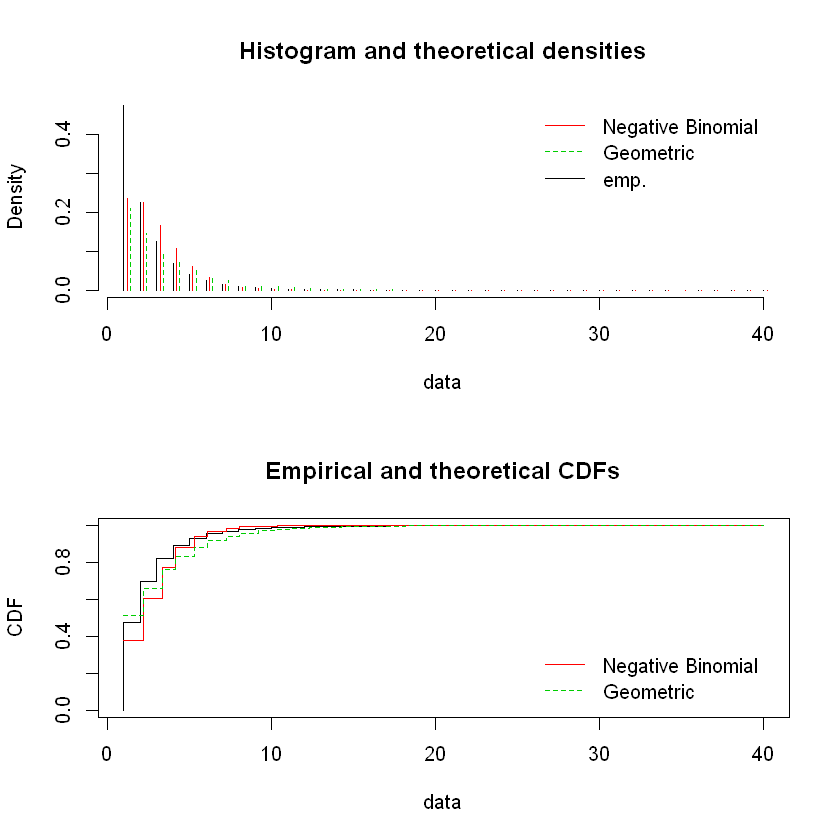

In [278]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dApr, BCfd_GE_dApr), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dApr, BCfd_GE_dApr), legendtext=plot.legend )

In [279]:
BCstatRes <- gofstat( list(BCfd_NB_dApr, BCfd_GE_dApr), fitnames=c("Negative Binomial", "Geometric") )

In [280]:
print(BCstatRes)

Chi-squared statistic:  943478.8 56919.49 
Degree of freedom of the Chi-squared distribution:  11 12 
Chi-squared p-value:  0 0 
   the p-value may be wrong with some theoretical counts < 5  
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     372647           2.990349e+05     401690.505
<= 2     177352           1.774999e+05     115608.074
<= 3      97803           1.317466e+05      80849.367
<= 4      53359           8.339024e+04      56541.207
<= 5      31086           4.731509e+04      39541.536
<= 6      18958           2.477812e+04      27652.983
<= 7      11579           1.220227e+04      19338.841
<= 8       7246           5.723416e+03      13524.428
<= 9       5007           2.580303e+03       9458.175
<= 10      3423           1.125689e+03       6614.482
<= 11      2302           4.776765e+02       4625.773
<= 13      2352           2.783217e+02       5497.346
<= 17      2153           5.136445e+01       4003.566
> 17        938           1.12093

In [281]:
BCfdNB_dApr_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [282]:
BCfdNB_dApr_p = BCfdNB_dApr_size / (BCfdNB_dApr_size + BCfdNB_dApr_mu)
cat("BCCA prob: ", BCfdNB_dApr_p)

BCCA prob:  0.6948687

In [283]:
# add to our tracking dataframe
BCMonDistDF[4, ] <- list( 4, dBCAprMean, dBCAprBNr, BCfdNB_dApr_p, BCfdNB_dApr_mu, BCfdNB_dApr_size,
                          BCfdNB_dApr_pvalue )

In [284]:
BCgf_dApr <- goodfit( dBCApr$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dApr_size, prob=BCfdNB_dApr_p) )

In [285]:
summary( BCgf_dApr )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          1.163127e+11 40        0
Likelihood Ratio 4.468174e+05 38        0


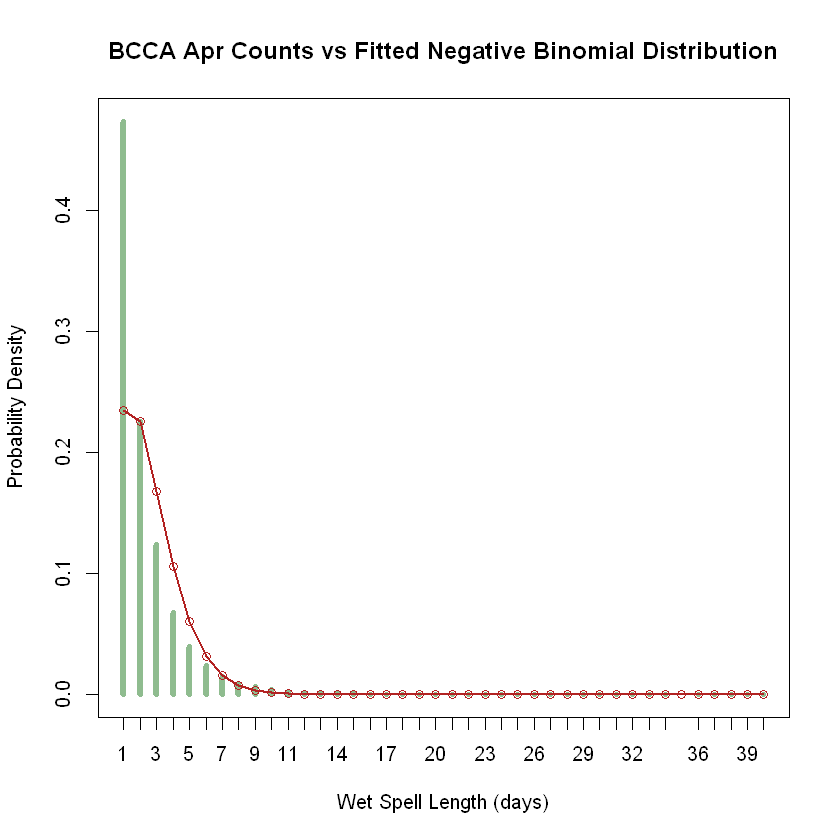

In [286]:
maxP <- max(dBCApr$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dApr_size, mu=BCfdNB_dApr_mu )
ttab <- table( dBCApr$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Apr Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

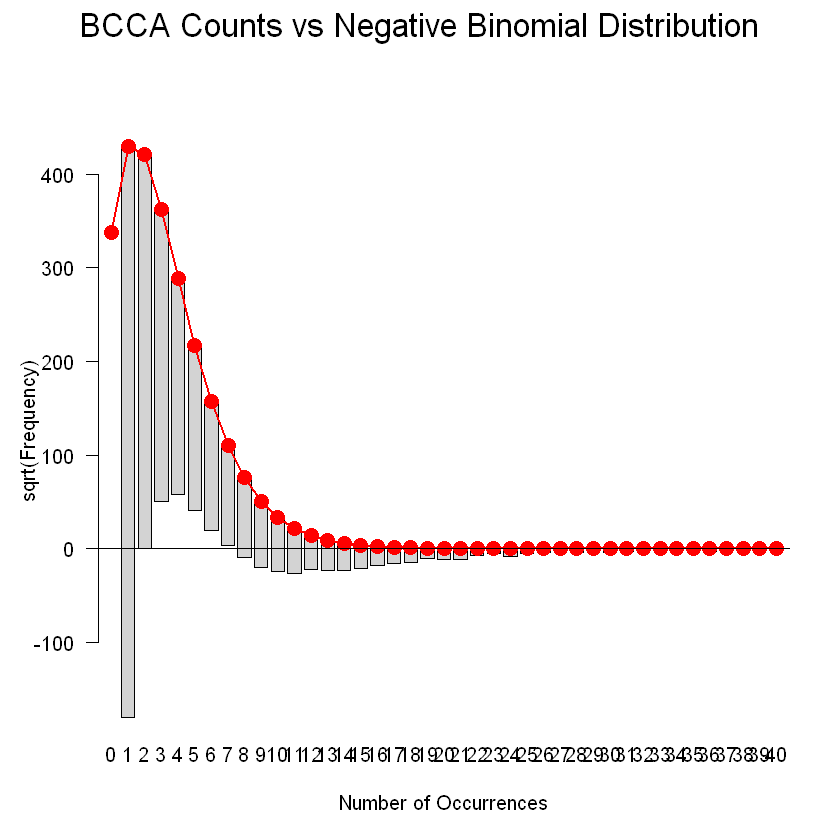

In [287]:
plot( BCgf_dApr, main="BCCA Counts vs Negative Binomial Distribution" )

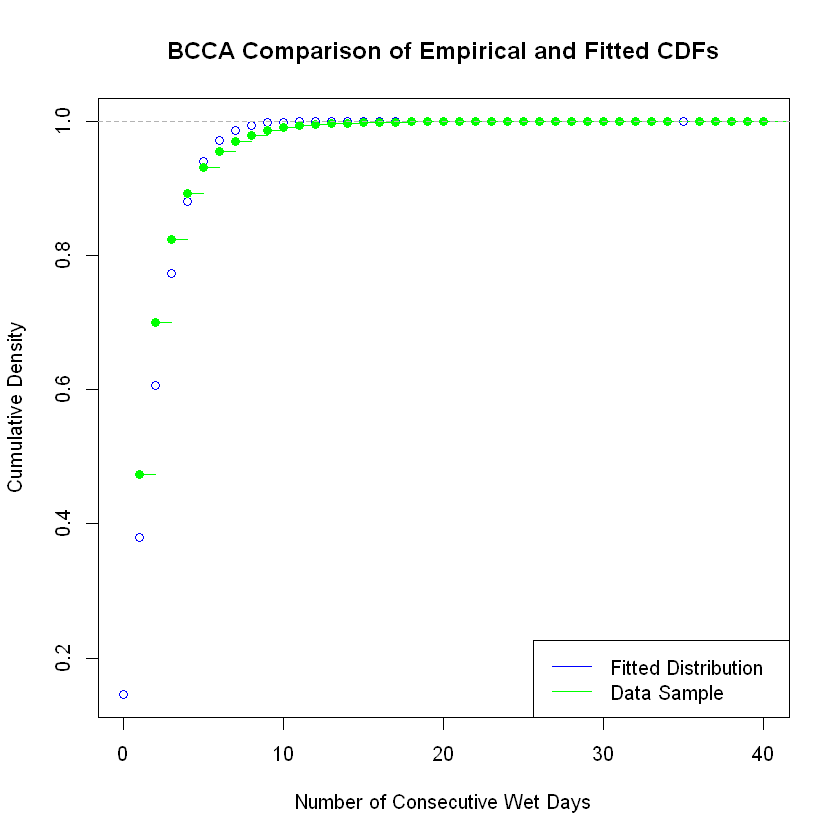

In [288]:
x <- seq(0,dBCAprMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dApr_mu, size=BCfdNB_dApr_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCApr$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

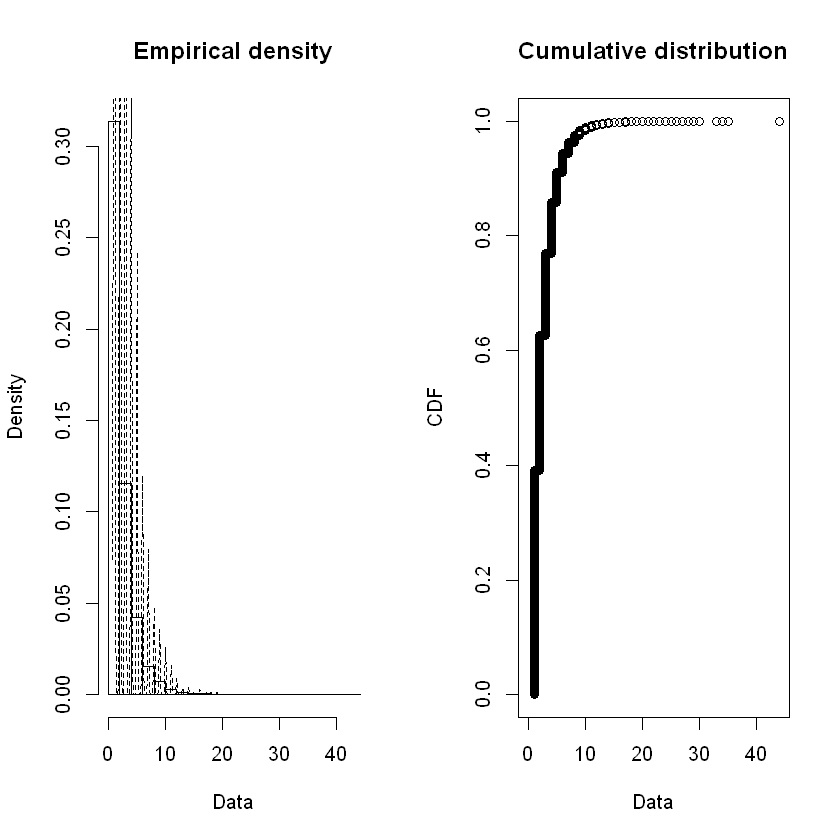

In [289]:
plotdist( dLOMay$Wet_Count, histo=TRUE, demp=TRUE )

In [290]:
LOfd_NB_dMay <- fitdist( dLOMay$Wet_Count, "nbinom" )
LOfd_GE_dMay <- fitdist( dLOMay$Wet_Count, "geom" )

In [291]:
LOfdNB_dMay_size <- LOfd_NB_dMay$estimate[["size"]]
LOfdNB_dMay_mu <- LOfd_NB_dMay$estimate[["mu"]]
cat("LOCA May size: ", LOfdNB_dMay_size, "\n", "LOCA May mu: ", LOfdNB_dMay_mu, "\n")

LOCA May size:  5.387195 
 LOCA May mu:  2.614087 


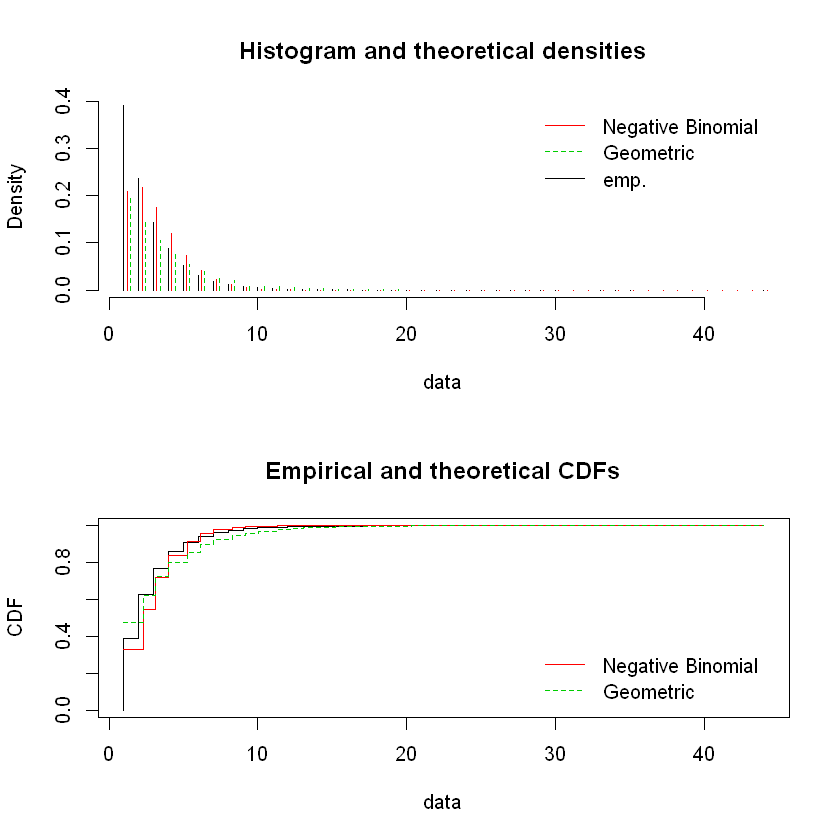

In [292]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dMay, LOfd_GE_dMay), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dMay, LOfd_GE_dMay), legendtext=plot.legend )

In [293]:
LOstatRes <- gofstat( list(LOfd_NB_dMay, LOfd_GE_dMay), fitnames=c("Negative Binomial", "Geometric") )

In [294]:
print( LOstatRes )

Chi-squared statistic:  352005.4 151694.5 
Degree of freedom of the Chi-squared distribution:  11 12 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     517583           434297.80930     631957.343
<= 2     313853           288958.61305     191869.153
<= 3     189382           232463.30190     138787.321
<= 4     117016           159247.12602     100390.918
<= 5      70364            97678.25497      72617.126
<= 6      42257            55246.57790      52527.132
<= 7      25012            29361.92712      37995.164
<= 8      16465            14853.47267      27483.558
<= 9      11316             7218.31017      19880.055
<= 10      8274             3392.90835      14380.111
<= 11      4972             1550.59851      10401.761
<= 13      4055              994.09842      12966.518
<= 16      2980              207.28501       8844.242
> 16       1957               15.71662       5385.598

Goodness-of-fit criteria
                

In [295]:
LOfdNB_dMay_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [296]:
LOfdNB_dMay_p = LOfdNB_dMay_size / (LOfdNB_dMay_size + LOfdNB_dMay_mu)
cat("LOCA prob: ", LOfdNB_dMay_p)

LOCA prob:  0.6732915

In [297]:
# add to our tracking dataframe
LOMonDistDF[5, ] <- list( 5, dLOMayMean, dLOMayBNr, LOfdNB_dMay_p, LOfdNB_dMay_mu, LOfdNB_dMay_size,
                          LOfdNB_dMay_pvalue )

In [298]:
LOgf_dMay <- goodfit( dLOMay$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dMay_size, prob=LOfdNB_dMay_p) )

In [299]:
summary( LOgf_dMay )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               Inf 44        0
Likelihood Ratio 563009.7 33        0


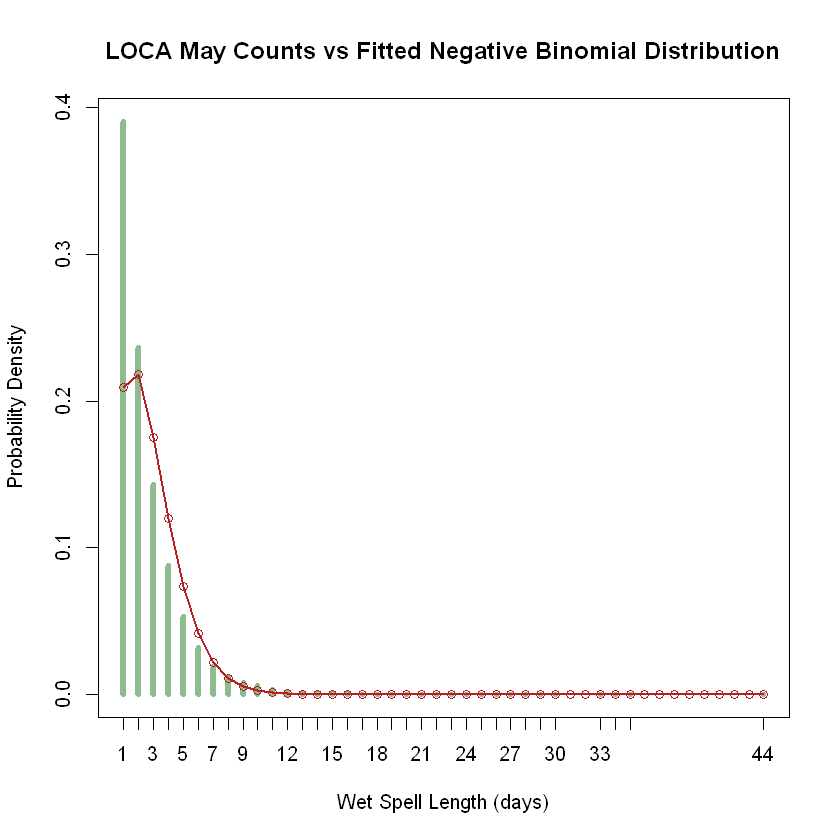

In [300]:
maxP <- max(dLOMay$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dMay_size, mu=LOfdNB_dMay_mu )
ttab <- table( dLOMay$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA May Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

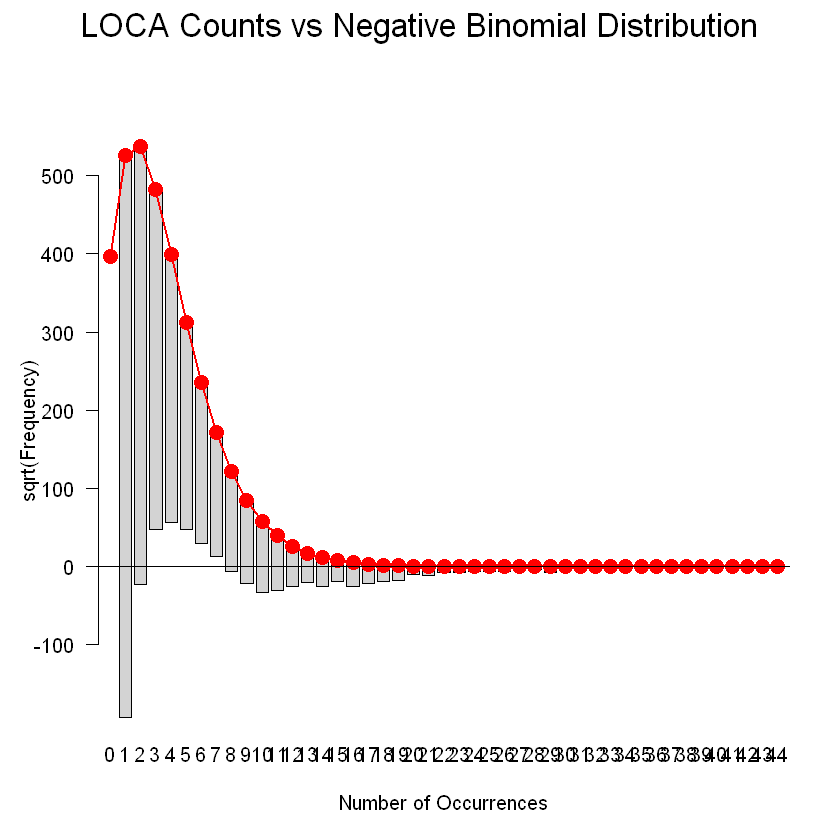

In [301]:
plot( LOgf_dMay, main="LOCA Counts vs Negative Binomial Distribution" )

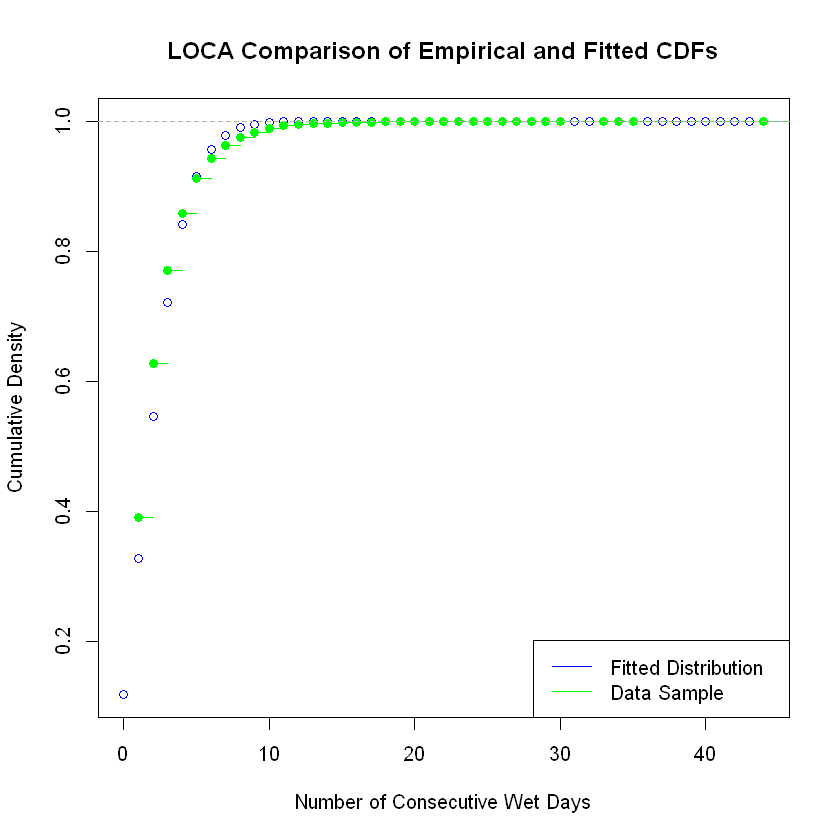

In [302]:
x <- seq(0,dLOMayMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dMay_mu, size=LOfdNB_dMay_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOMay$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

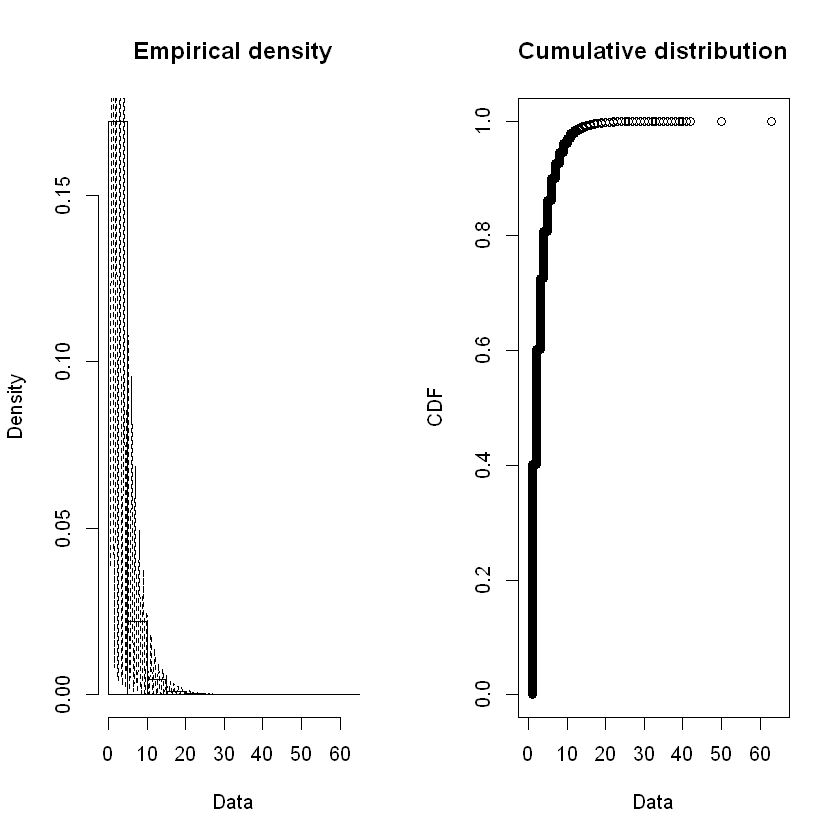

In [303]:
plotdist( dBCMay$Wet_Count, histo=TRUE, demp=TRUE )

In [304]:
BCfd_NB_dMay <- fitdist( dBCMay$Wet_Count, "nbinom" )
BCfd_GE_dMay <- fitdist( dBCMay$Wet_Count, "geom" )

In [305]:
summary( BCfd_NB_dMay )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.769776 0.007546904
mu   2.990405 0.002701309
Loglikelihood:  -1826341   AIC:  3652687   BIC:  3652710 
Correlation matrix:
             size           mu
size 1.000000e+00 4.500969e-06
mu   4.500969e-06 1.000000e+00


In [306]:
BCfdNB_dMay_size <- BCfd_NB_dMay$estimate[["size"]]
BCfdNB_dMay_mu <- BCfd_NB_dMay$estimate[["mu"]]
cat("BCCA May size: ", BCfdNB_dMay_size, "\n", "BCCA May mu: ", BCfdNB_dMay_mu, "\n")

BCCA May size:  2.769776 
 BCCA May mu:  2.990405 


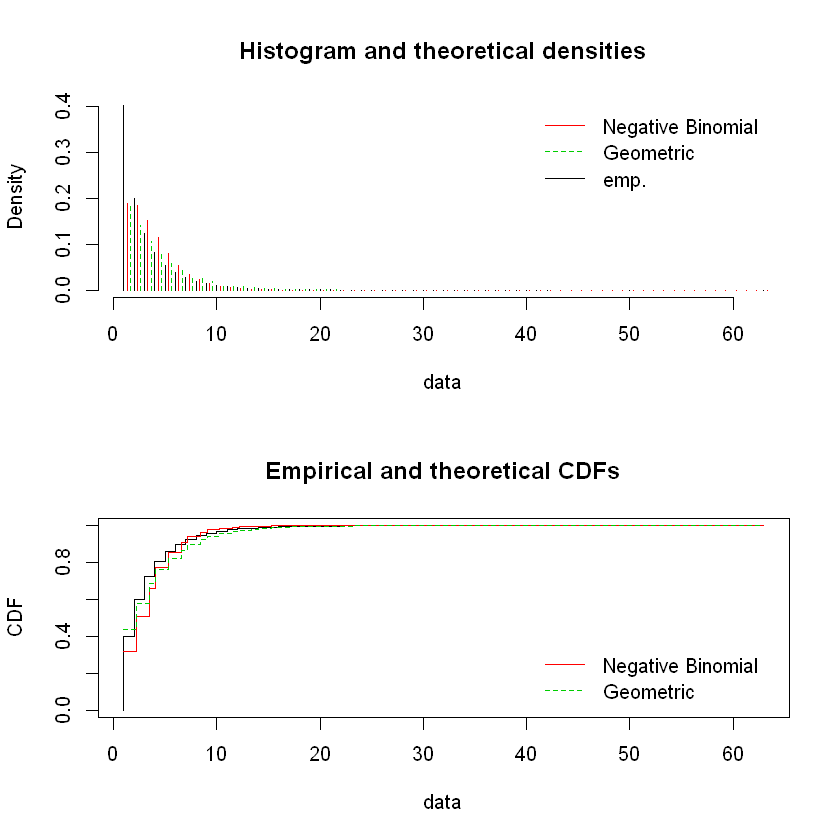

In [307]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dMay, BCfd_GE_dMay), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dMay, BCfd_GE_dMay), legendtext=plot.legend )

In [308]:
BCstatRes <- gofstat( list(BCfd_NB_dMay, BCfd_GE_dMay), fitnames=c("Negative Binomial", "Geometric") )

In [309]:
print(BCstatRes)

Chi-squared statistic:  139996.3 34545.21 
Degree of freedom of the Chi-squared distribution:  14 15 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     342625           273418.26901     373630.348
<= 2     169992           157806.12429     119944.370
<= 3     105596           130255.02683      89886.240
<= 4      69952            97541.03470      67360.696
<= 5      45988            68562.32756      50480.066
<= 6      32734            46093.18278      37829.732
<= 7      23125            29979.26996      28349.579
<= 8      16486            19006.82452      21245.158
<= 9      12364            11807.76272      15921.109
<= 10      8349             7214.88985      11931.270
<= 11      6388             4348.24682       8941.287
<= 12      4830             2590.32171       6700.595
<= 13      3148             1527.84096       5021.422
<= 14      2572              893.44850       3763.051
<= 16      3227              817.54952    

In [310]:
BCfdNB_dMay_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [311]:
BCfdNB_dMay_p = BCfdNB_dMay_size / (BCfdNB_dMay_size + BCfdNB_dMay_mu)
cat("BCCA prob: ", BCfdNB_dMay_p)

BCCA prob:  0.4808488

In [312]:
# add to our tracking dataframe
BCMonDistDF[5, ] <- list( 5, dBCMayMean, dBCMayBNr, BCfdNB_dMay_p, BCfdNB_dMay_mu, BCfdNB_dMay_size,
                          BCfdNB_dMay_pvalue )

In [313]:
BCgf_dMay <- goodfit( dBCMay$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dMay_size, prob=BCfdNB_dMay_p) )

In [314]:
summary( BCgf_dMay )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          8.841137e+10 63        0
Likelihood Ratio 4.374794e+05 43        0


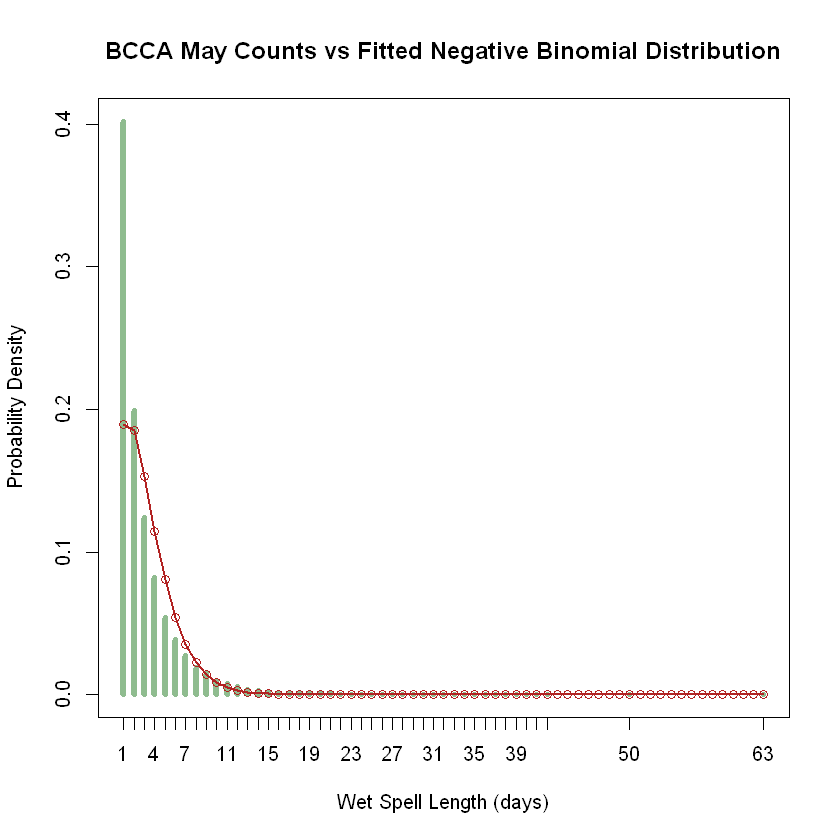

In [315]:
maxP <- max(dBCMay$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dMay_size, mu=BCfdNB_dMay_mu )
ttab <- table( dBCMay$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA May Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

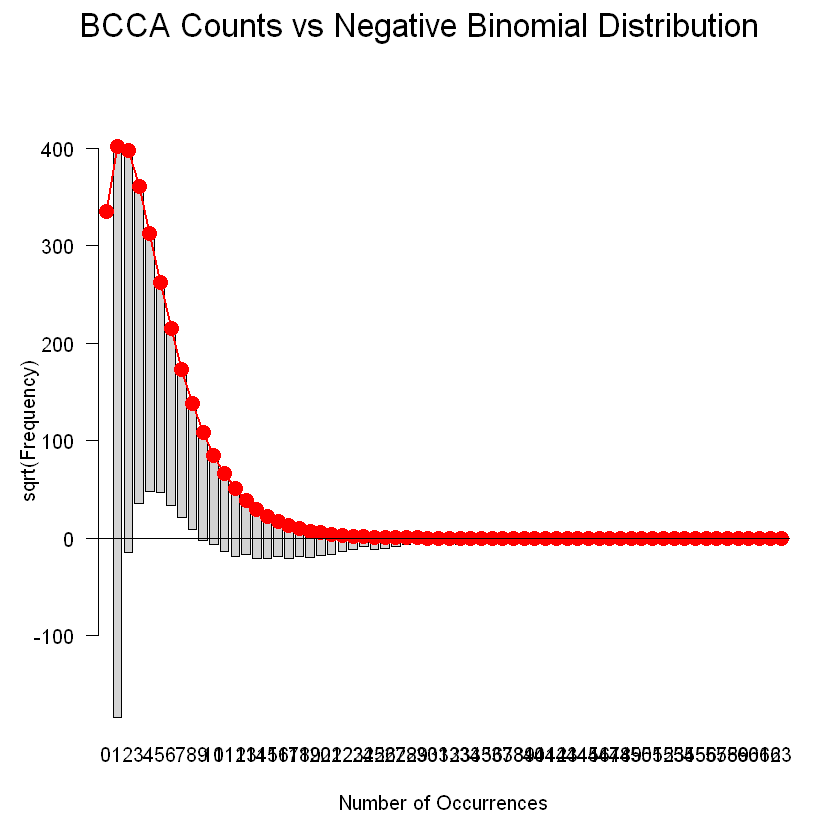

In [316]:
plot( BCgf_dMay, main="BCCA Counts vs Negative Binomial Distribution" )

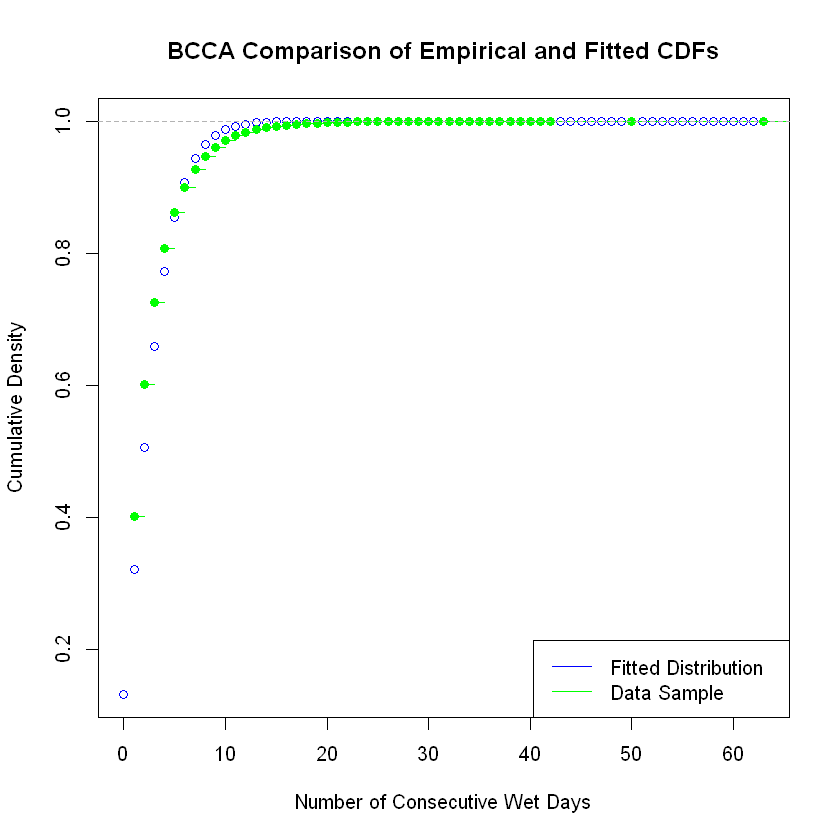

In [317]:
x <- seq(0,dBCMayMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dMay_mu, size=BCfdNB_dMay_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCMay$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

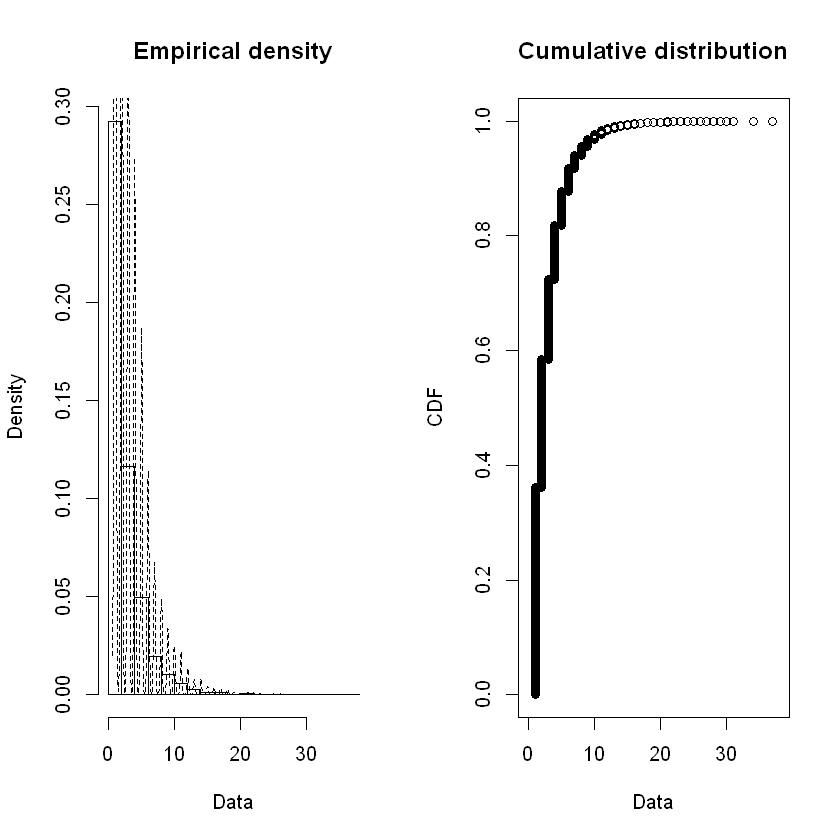

In [318]:
plotdist( dLOJun$Wet_Count, histo=TRUE, demp=TRUE )

In [319]:
LOfd_NB_dJun <- fitdist( dLOJun$Wet_Count, "nbinom" )
LOfd_GE_dJun <- fitdist( dLOJun$Wet_Count, "geom" )

In [320]:
LOfdNB_dJun_size <- LOfd_NB_dJun$estimate[["size"]]
LOfdNB_dJun_mu <- LOfd_NB_dJun$estimate[["mu"]]
cat("LOCA Jun size: ", LOfdNB_dJun_size, "\n", "LOCA Jun mu: ", LOfdNB_dJun_mu, "\n")

LOCA Jun size:  3.57663 
 LOCA Jun mu:  2.936999 


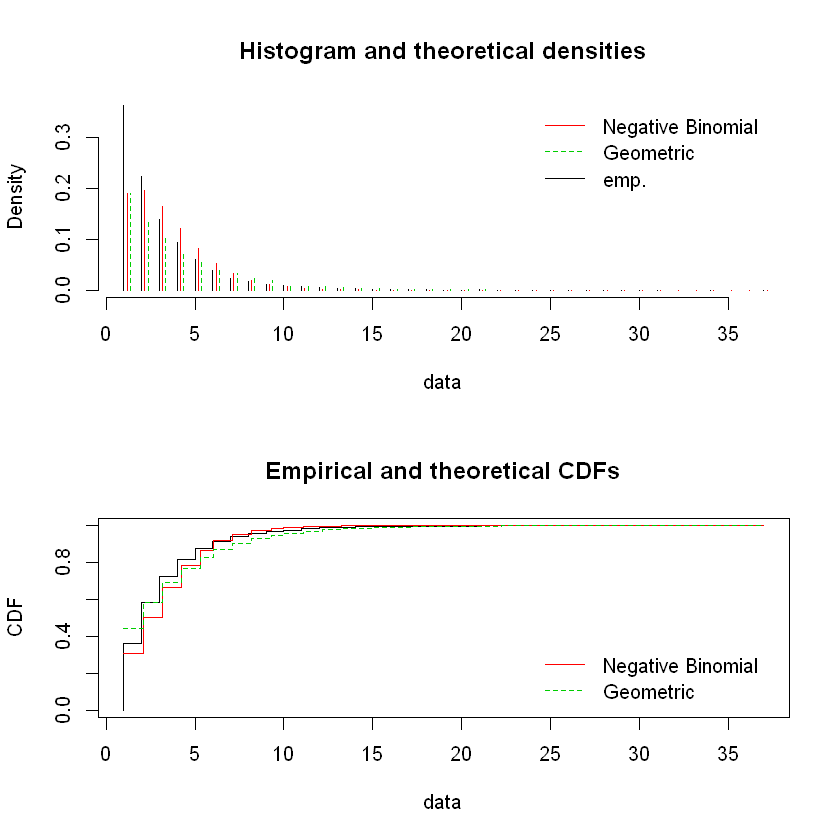

In [321]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJun, LOfd_GE_dJun), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJun, LOfd_GE_dJun), legendtext=plot.legend )

In [322]:
LOstatRes <- gofstat( list(LOfd_NB_dJun, LOfd_GE_dJun), fitnames=c("Negative Binomial", "Geometric") )

In [323]:
print( LOstatRes )

Chi-squared statistic:  240625.4 103013.3 
Degree of freedom of the Chi-squared distribution:  14 15 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     399344           337583.36381     489012.795
<= 2     245867           215001.84798     155871.445
<= 3     154192           180207.80025     116282.298
<= 4     102775           133597.34104      86748.235
<= 5      66453            91281.90541      64715.408
<= 6      42778            58834.34540      48278.608
<= 7      24920            36293.29480      36016.523
<= 8      18306            21635.37969      26868.834
<= 9      12658            12548.30203      20044.530
<= 10      9591             7115.90342      14953.502
<= 11      7843             3960.13634      11155.523
<= 12      5009             2169.03629       8322.178
<= 13      2743             1171.86549       6208.462
<= 14      2974              625.64325       4631.600
<= 16      2871              503.61443    

In [324]:
LOfdNB_dJun_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [325]:
LOfdNB_dJun_p = LOfdNB_dJun_size / (LOfdNB_dJun_size + LOfdNB_dJun_mu)
cat("LOCA prob: ", LOfdNB_dJun_p)

LOCA prob:  0.5490994

In [326]:
# add to our tracking dataframe
LOMonDistDF[6, ] <- list( 6, dLOJunMean, dLOJunBNr, LOfdNB_dJun_p, LOfdNB_dJun_mu, LOfdNB_dJun_size,
                          LOfdNB_dJun_pvalue )

In [327]:
LOgf_dJun <- goodfit( dLOJun$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJun_size, prob=LOfdNB_dJun_p) )

In [328]:
summary( LOgf_dJun )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          766628.1 37        0
Likelihood Ratio 470041.6 32        0


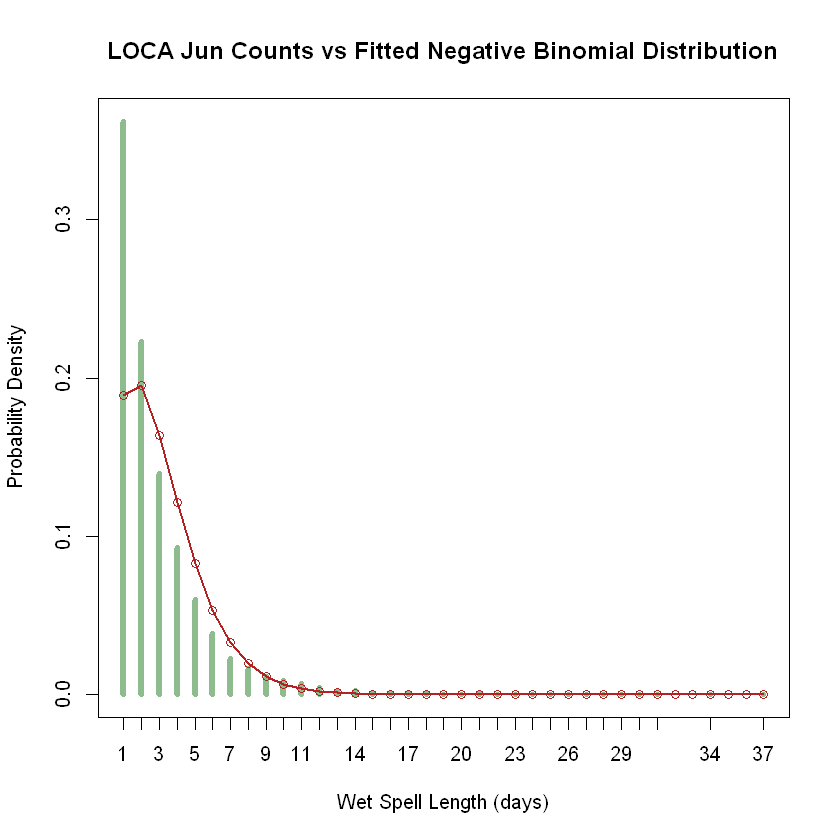

In [329]:
maxP <- max(dLOJun$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJun_size, mu=LOfdNB_dJun_mu )
ttab <- table( dLOJun$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jun Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

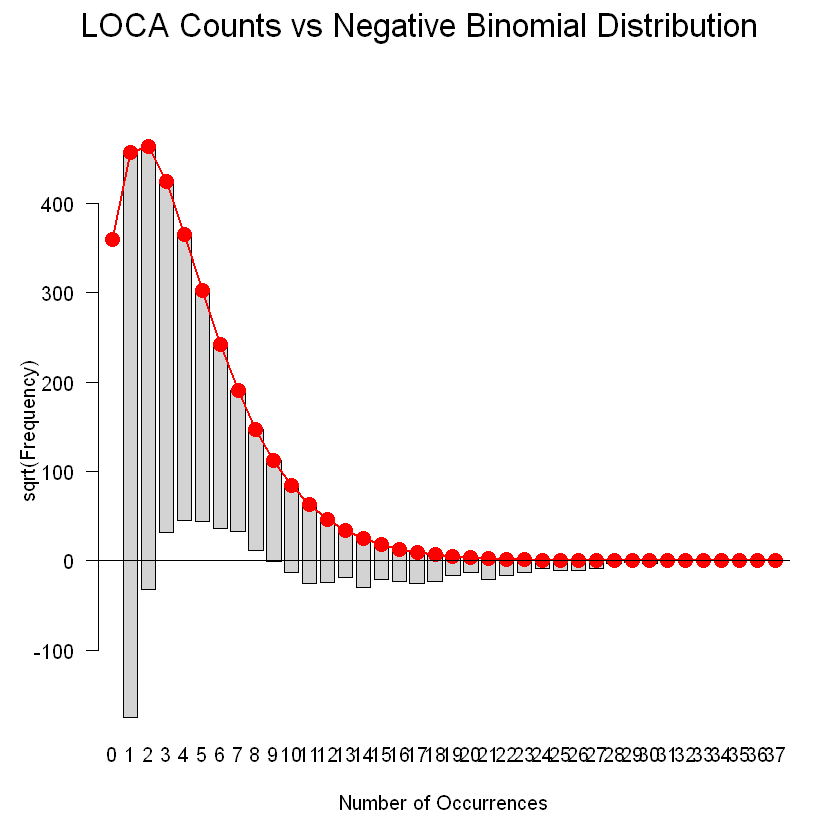

In [330]:
plot( LOgf_dJun, main="LOCA Counts vs Negative Binomial Distribution" )

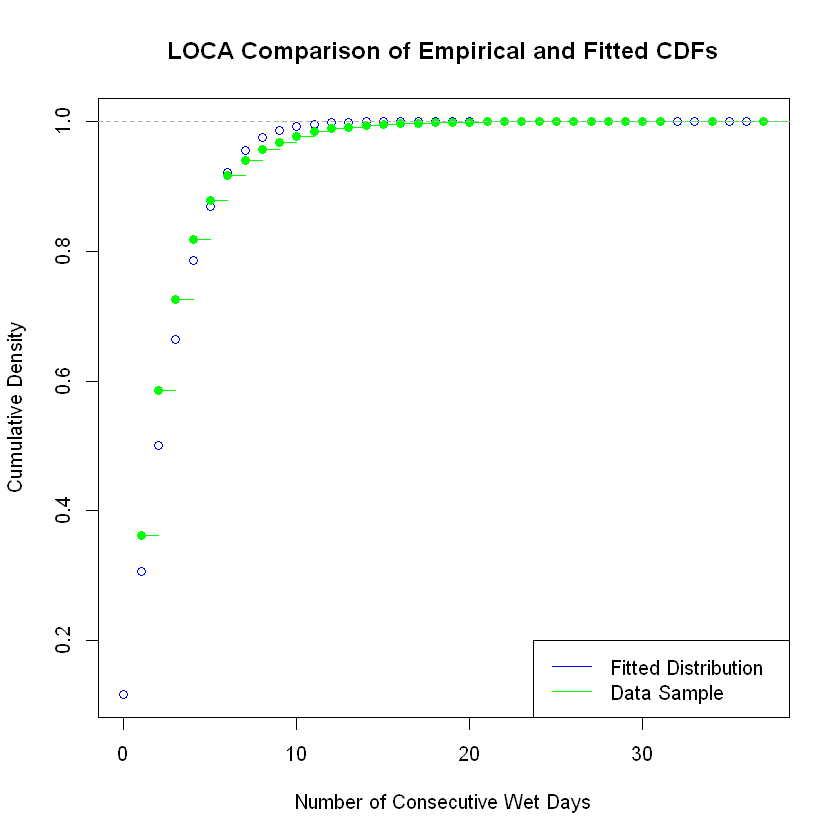

In [331]:
x <- seq(0,dLOJunMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJun_mu, size=LOfdNB_dJun_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJun$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

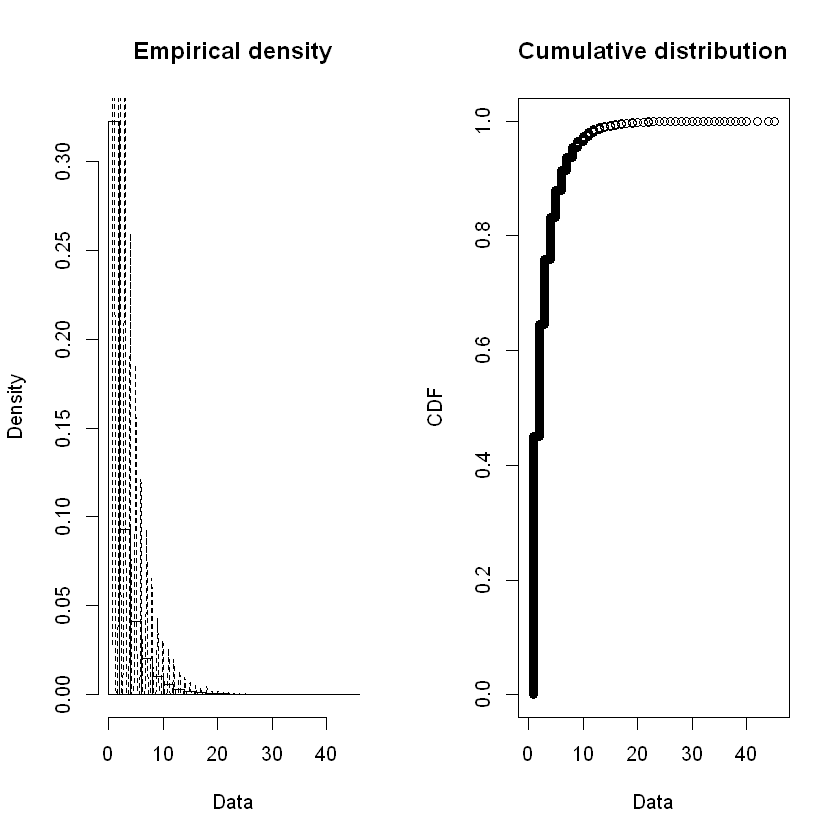

In [332]:
plotdist( dBCJun$Wet_Count, histo=TRUE, demp=TRUE )

In [333]:
BCfd_NB_dJun <- fitdist( dBCJun$Wet_Count, "nbinom" )
BCfd_GE_dJun <- fitdist( dBCJun$Wet_Count, "geom" )

In [334]:
summary( BCfd_NB_dJun )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.783288 0.008114336
mu   2.771383 0.002660714
Loglikelihood:  -1624800   AIC:  3249604   BIC:  3249627 
Correlation matrix:
             size           mu
size 1.0000000000 0.0001591283
mu   0.0001591283 1.0000000000


In [335]:
BCfdNB_dJun_size <- BCfd_NB_dJun$estimate[["size"]]
BCfdNB_dJun_mu <- BCfd_NB_dJun$estimate[["mu"]]
cat("BCCA Jun size: ", BCfdNB_dJun_size, "\n", "BCCA Jun mu: ", BCfdNB_dJun_mu, "\n")

BCCA Jun size:  2.783288 
 BCCA Jun mu:  2.771383 


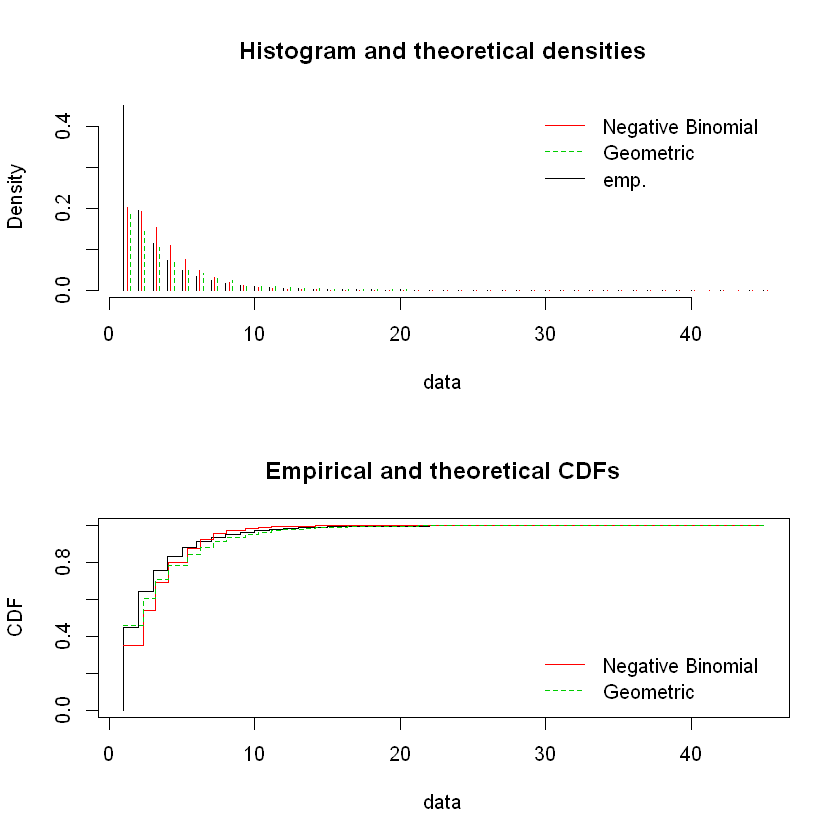

In [336]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJun, BCfd_GE_dJun), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJun, BCfd_GE_dJun), legendtext=plot.legend )

In [337]:
BCstatRes <- gofstat( list(BCfd_NB_dJun, BCfd_GE_dJun), fitnames=c("Negative Binomial", "Geometric") )

In [338]:
print(BCstatRes)

Chi-squared statistic:  172627.3 23505.02 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     352113           272659.76294     359305.128
<= 2     151862           149603.02353     111844.214
<= 3      89075           119010.10005      82190.478
<= 4      56507            85849.31380      60398.964
<= 5      37617            58109.24905      44385.128
<= 6      26347            37609.30422      32617.109
<= 7      18078            23544.66795      23969.195
<= 8      13422            14365.66090      17614.139
<= 9       9301             8587.61363      12944.027
<= 10      6786             5048.67229       9512.122
<= 11      4866             2927.28672       6990.132
<= 12      3865             1677.54833       5136.808
<= 13      2899              951.78952       3774.864
<= 15      3406              834.22653       4812.549
<= 18      2695              307.19111    

In [339]:
BCfdNB_dJun_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [340]:
BCfdNB_dJun_p = BCfdNB_dJun_size / (BCfdNB_dJun_size + BCfdNB_dJun_mu)
cat("BCCA prob: ", BCfdNB_dJun_p)

BCCA prob:  0.5010716

In [341]:
# add to our tracking dataframe
BCMonDistDF[6, ] <- list( 6, dBCJunMean, dBCJunBNr, BCfdNB_dJun_p, BCfdNB_dJun_mu, BCfdNB_dJun_size,
                          BCfdNB_dJun_pvalue )

In [342]:
BCgf_dJun <- goodfit( dBCJun$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJun_size, prob=BCfdNB_dJun_p) )

In [343]:
summary( BCgf_dJun )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          5981713.8 45        0
Likelihood Ratio  469615.4 42        0


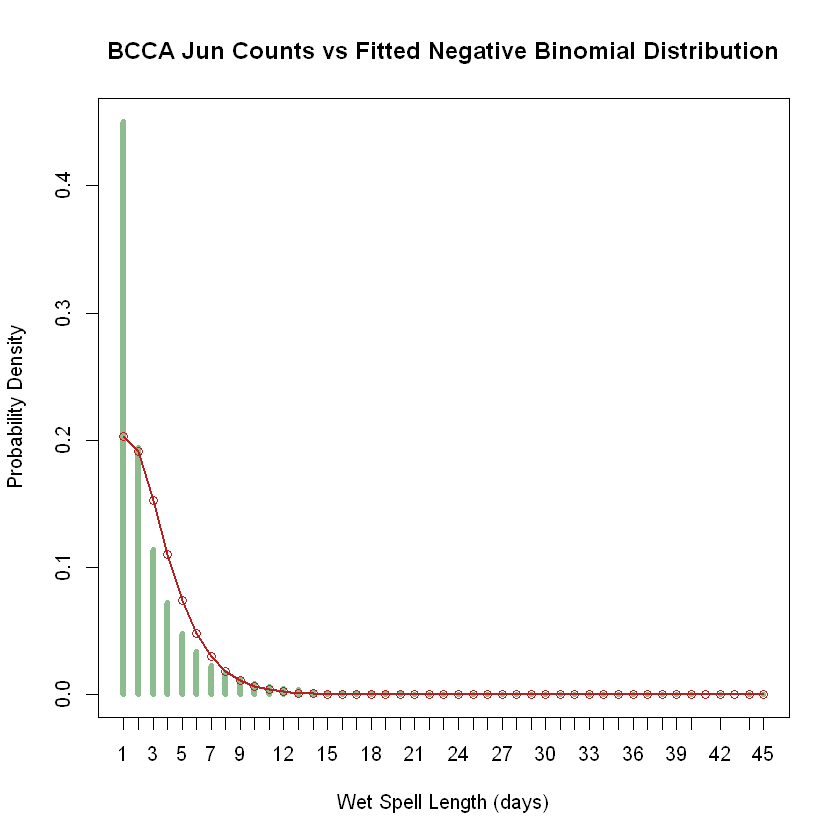

In [344]:
maxP <- max(dBCJun$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJun_size, mu=BCfdNB_dJun_mu )
ttab <- table( dBCJun$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jun Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

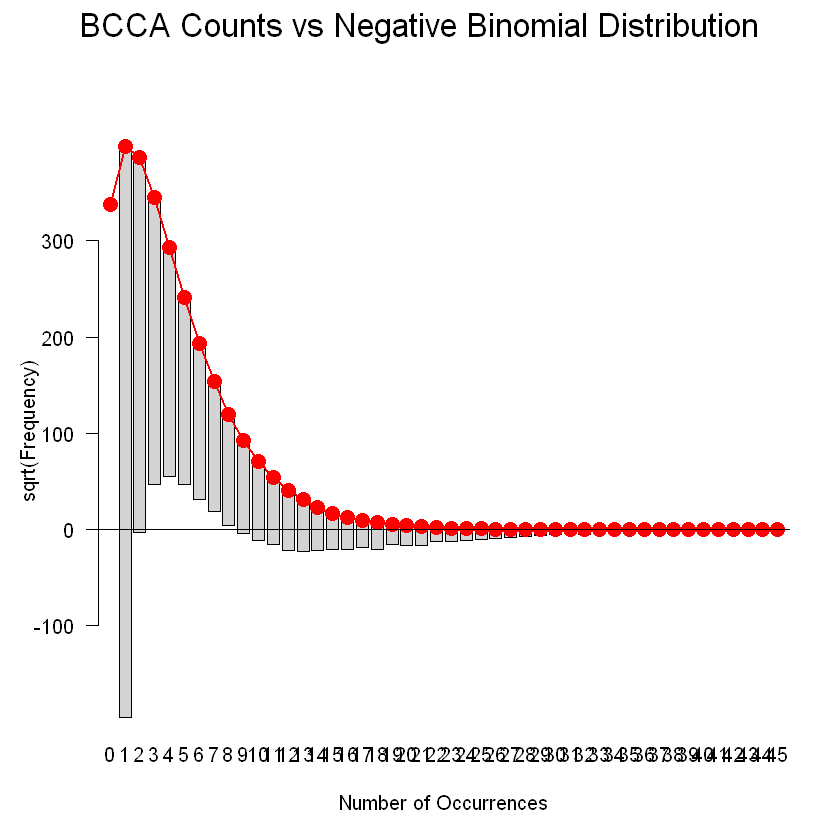

In [345]:
plot( BCgf_dJun, main="BCCA Counts vs Negative Binomial Distribution" )

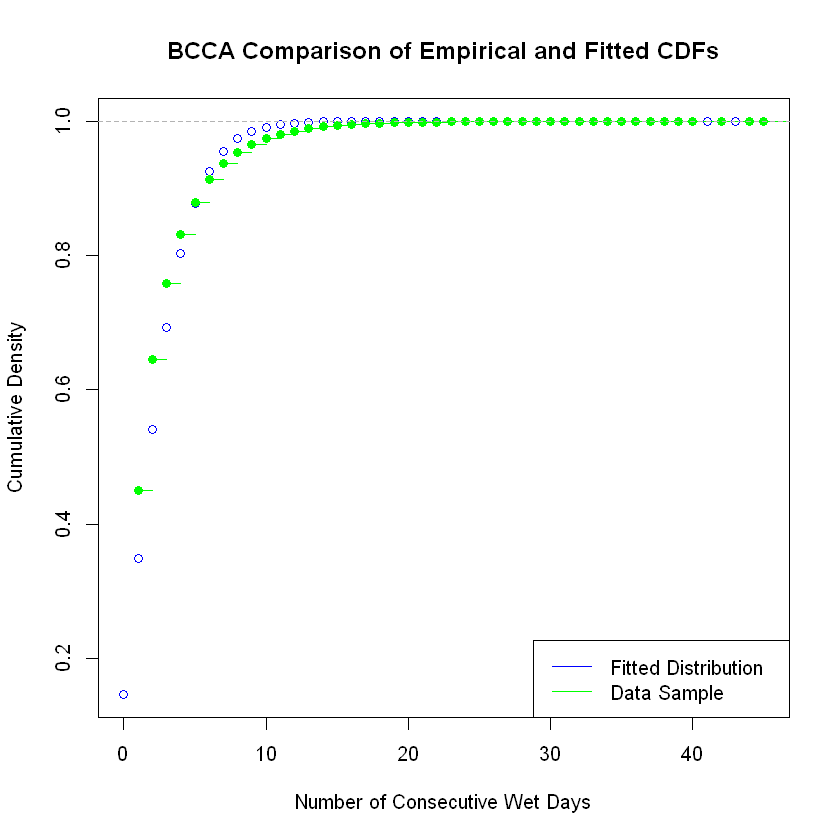

In [346]:
x <- seq(0,dBCJunMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJun_mu, size=BCfdNB_dJun_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJun$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

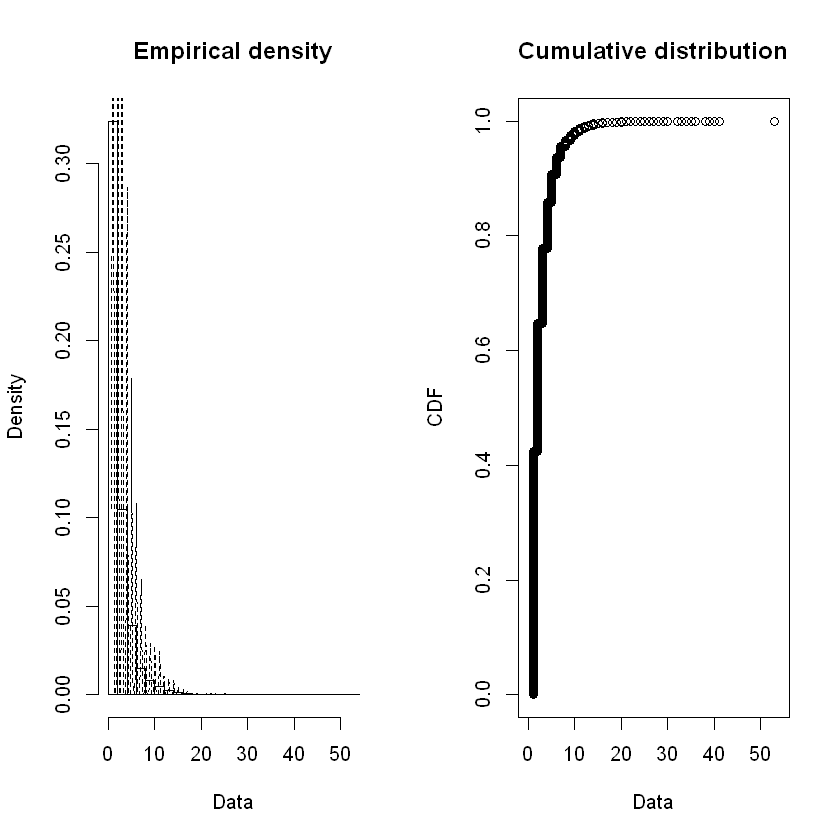

In [347]:
plotdist( dLOJul$Wet_Count, histo=TRUE, demp=TRUE )

In [348]:
LOfd_NB_dJul <- fitdist( dLOJul$Wet_Count, "nbinom" )
LOfd_GE_dJul <- fitdist( dLOJul$Wet_Count, "geom" )

In [349]:
LOfdNB_dJul_size <- LOfd_NB_dJul$estimate[["size"]]
LOfdNB_dJul_mu <- LOfd_NB_dJul$estimate[["mu"]]
cat("LOCA Jul size: ", LOfdNB_dJul_size, "\n", "LOCA Jul mu: ", LOfdNB_dJul_mu, "\n")

LOCA Jul size:  3.893235 
 LOCA Jul mu:  2.617414 


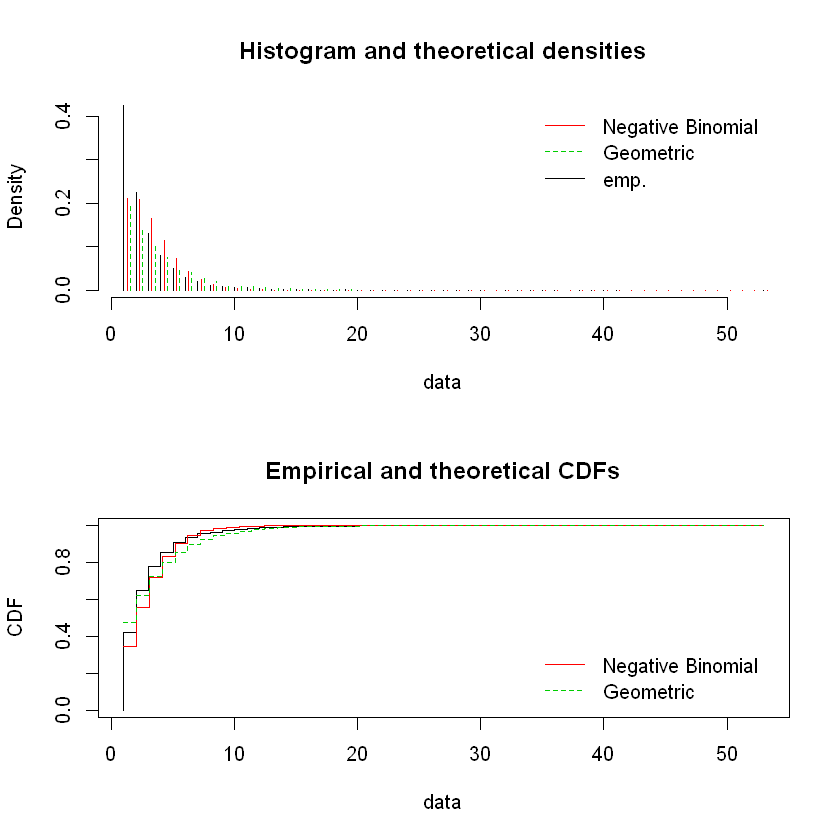

In [350]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJul, LOfd_GE_dJul), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJul, LOfd_GE_dJul), legendtext=plot.legend )

In [351]:
LOstatRes <- gofstat( list(LOfd_NB_dJul, LOfd_GE_dJul), fitnames=c("Negative Binomial", "Geometric") )

In [352]:
print( LOstatRes )

Chi-squared statistic:  306358.8 70006.41 
Degree of freedom of the Chi-squared distribution:  12 13 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     394276           322240.17121     443090.505
<= 2     208537           193391.86438     134593.547
<= 3     121193           152728.06869      97387.799
<= 4      73742           105810.82740      70466.850
<= 5      45693            67152.67204      50987.670
<= 6      27531            40014.73792      36893.128
<= 7      17646            22735.70490      26694.746
<= 8       9940            12445.81874      19315.507
<= 9       8141             6611.94338      13976.113
<= 10      6580             3427.19794      10112.691
<= 11      5421             1740.19553       7317.235
<= 12      2863              868.26843       5294.529
<= 14      4171              633.76372       6602.927
<= 17      2284              168.57705       4507.078
> 17       1971               19.18868    

In [353]:
LOfdNB_dJul_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [354]:
LOfdNB_dJul_p = LOfdNB_dJul_size / (LOfdNB_dJul_size + LOfdNB_dJul_mu)
cat("LOCA prob: ", LOfdNB_dJul_p)

LOCA prob:  0.5979795

In [355]:
# add to our tracking dataframe
LOMonDistDF[7, ] <- list( 7, dLOJulMean, dLOJulBNr, LOfdNB_dJul_p, LOfdNB_dJul_mu, LOfdNB_dJul_size,
                          LOfdNB_dJul_pvalue )

In [356]:
LOgf_dJul <- goodfit( dLOJul$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJul_size, prob=LOfdNB_dJul_p) )

In [357]:
summary( LOgf_dJul )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               NaN 53      NaN
Likelihood Ratio 483818.1 39        0


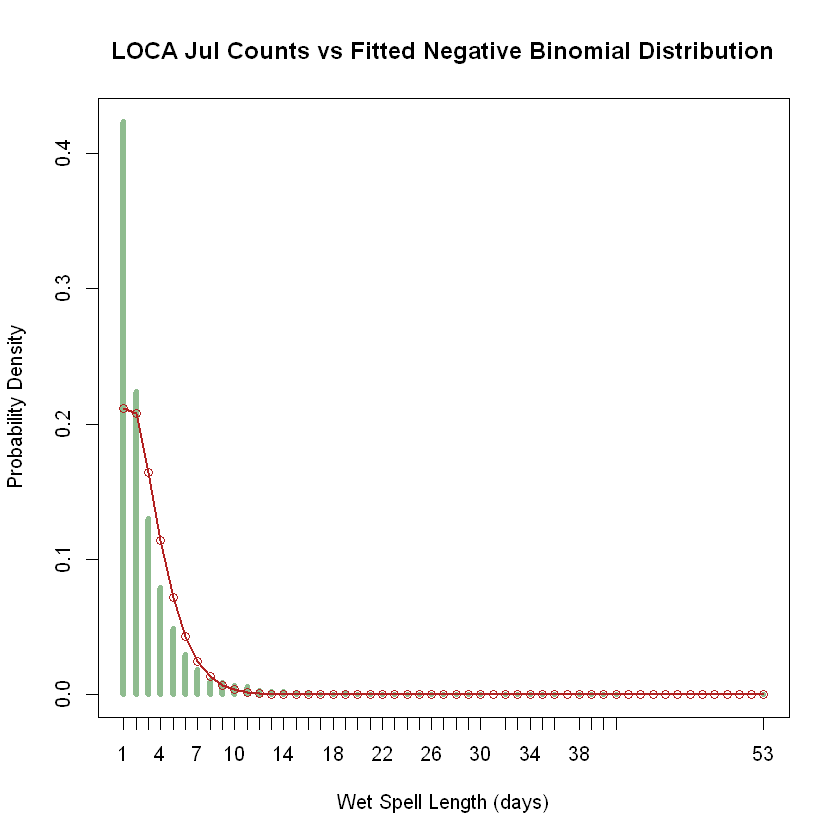

In [358]:
maxP <- max(dLOJul$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJul_size, mu=LOfdNB_dJul_mu )
ttab <- table( dLOJul$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jul Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

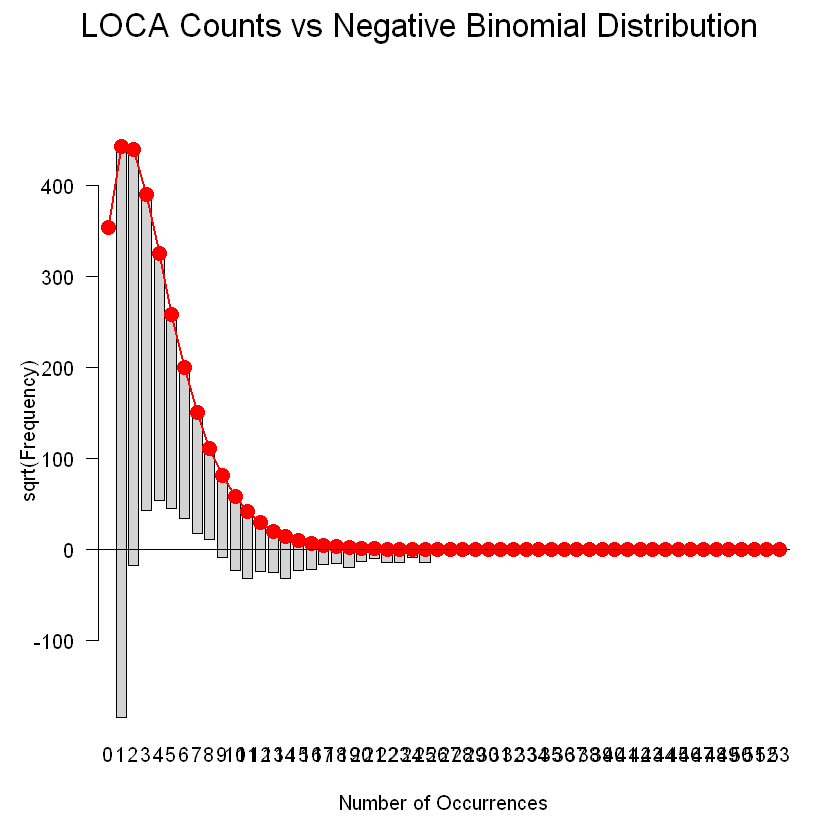

In [359]:
plot( LOgf_dJul, main="LOCA Counts vs Negative Binomial Distribution" )

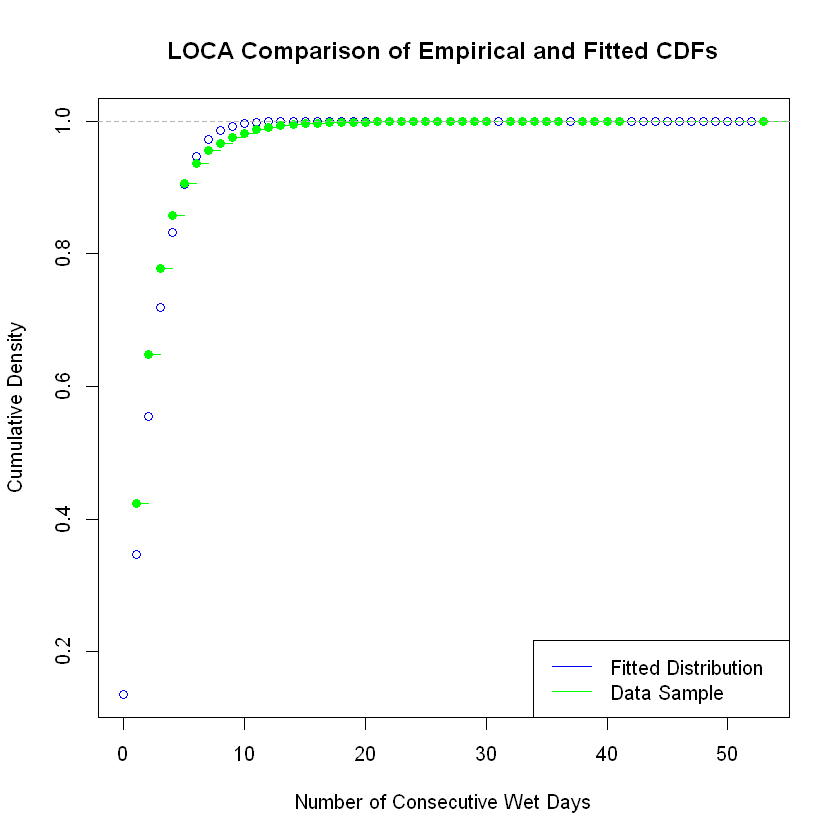

In [360]:
x <- seq(0,dLOJulMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJul_mu, size=LOfdNB_dJul_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJul$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

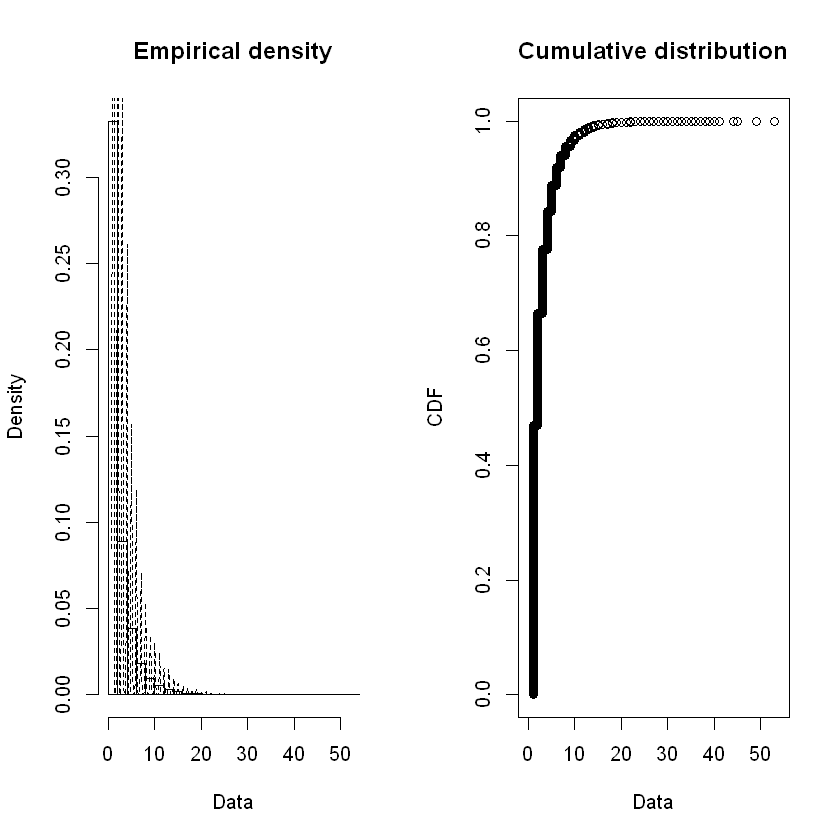

In [361]:
plotdist( dBCJul$Wet_Count, histo=TRUE, demp=TRUE )

In [362]:
BCfd_NB_dJul <- fitdist( dBCJul$Wet_Count, "nbinom" )
BCfd_GE_dJul <- fitdist( dBCJul$Wet_Count, "geom" )

In [363]:
summary( BCfd_NB_dJul )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.813268 0.008119125
mu   2.677473 0.002525954
Loglikelihood:  -1678846   AIC:  3357696   BIC:  3357720 
Correlation matrix:
             size           mu
size 1.0000000000 0.0002656329
mu   0.0002656329 1.0000000000


In [364]:
BCfdNB_dJul_size <- BCfd_NB_dJul$estimate[["size"]]
BCfdNB_dJul_mu <- BCfd_NB_dJul$estimate[["mu"]]
cat("BCCA Jul size: ", BCfdNB_dJul_size, "\n", "BCCA Jul mu: ", BCfdNB_dJul_mu, "\n")

BCCA Jul size:  2.813268 
 BCCA Jul mu:  2.677473 


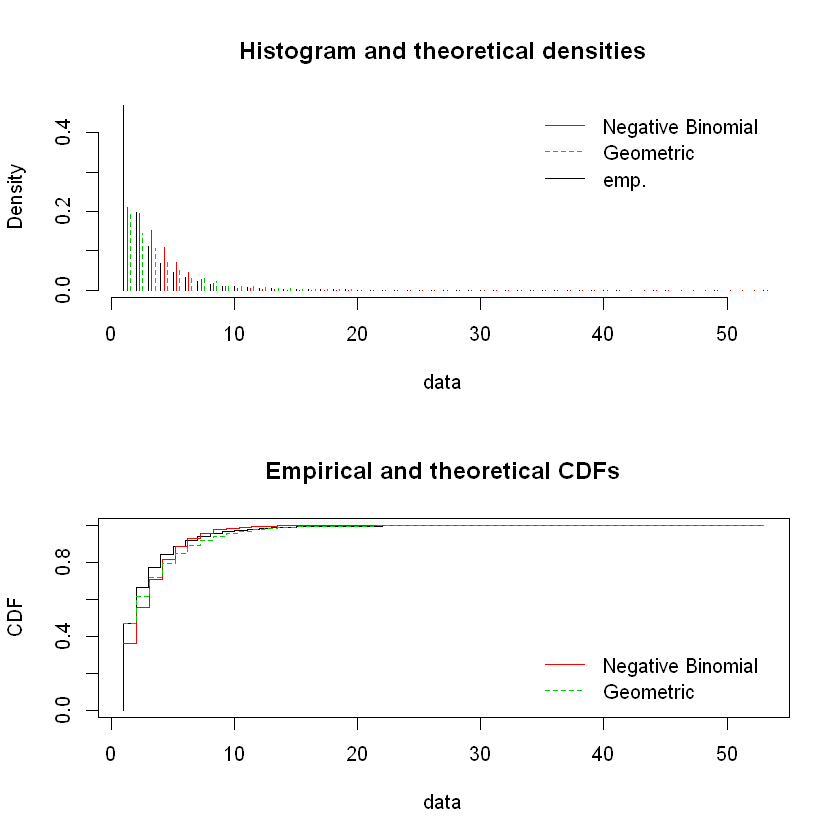

In [365]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJul, BCfd_GE_dJul), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJul, BCfd_GE_dJul), legendtext=plot.legend )

In [366]:
BCstatRes <- gofstat( list(BCfd_NB_dJul, BCfd_GE_dJul), fitnames=c("Negative Binomial", "Geometric") )

In [367]:
print(BCstatRes)

Chi-squared statistic:  246984.2 26701.52 
Degree of freedom of the Chi-squared distribution:  14 15 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     383714           295962.29311     384719.577
<= 2     161075           159153.69452     118022.919
<= 3      90299           124517.29626      85933.600
<= 4      55447            88243.80038      62569.064
<= 5      37152            58635.93285      45557.125
<= 6      25688            37233.98133      33170.572
<= 7      17160            22859.80809      24151.806
<= 8      12542            13673.83766      17585.158
<= 9       8673             8011.22710      12803.919
<= 10      6795             4614.91032       9322.654
<= 11      4804             2621.34786       6787.912
<= 12      3691             1471.41106       4942.343
<= 13      3106              817.59026       3598.567
<= 14      2105              450.32232       2620.150
<= 16      2718              379.76555    

In [368]:
BCfdNB_dJul_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [369]:
BCfdNB_dJul_p = BCfdNB_dJul_size / (BCfdNB_dJul_size + BCfdNB_dJul_mu)
cat("BCCA prob: ", BCfdNB_dJul_p)

BCCA prob:  0.5123658

In [370]:
# add to our tracking dataframe
BCMonDistDF[7, ] <- list( 7, dBCJulMean, dBCJulBNr, BCfdNB_dJul_p, BCfdNB_dJul_mu, BCfdNB_dJul_size,
                          BCfdNB_dJul_pvalue )

In [371]:
BCgf_dJul <- goodfit( dBCJul$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJul_size, prob=BCfdNB_dJul_p) )

In [372]:
summary( BCgf_dJul )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          2625324302.6 53        0
Likelihood Ratio     523277.4 44        0


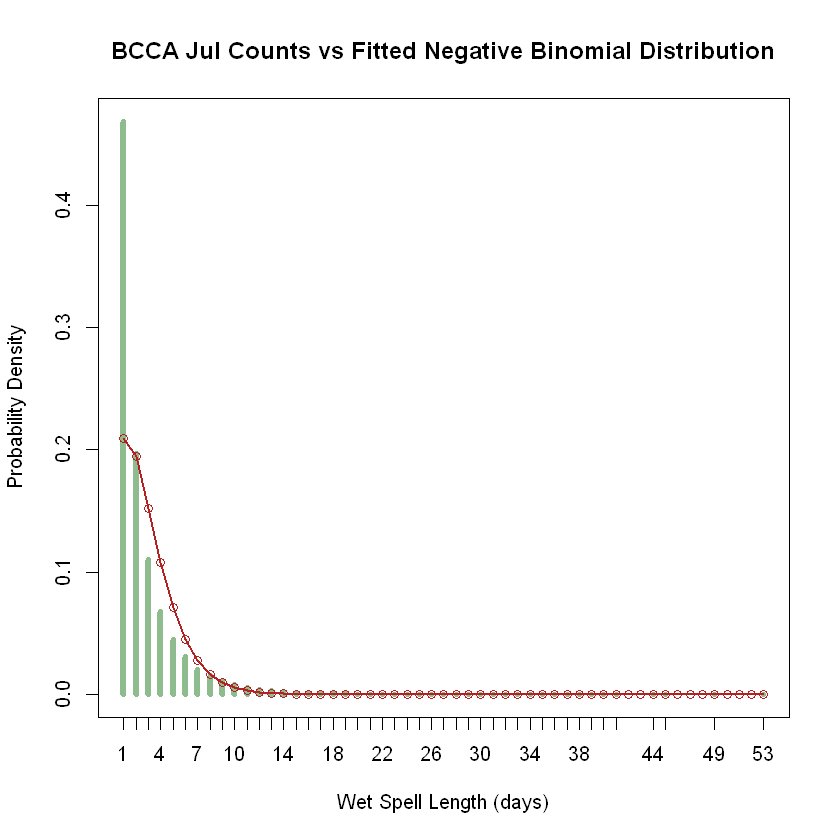

In [373]:
maxP <- max(dBCJul$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJul_size, mu=BCfdNB_dJul_mu )
ttab <- table( dBCJul$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jul Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

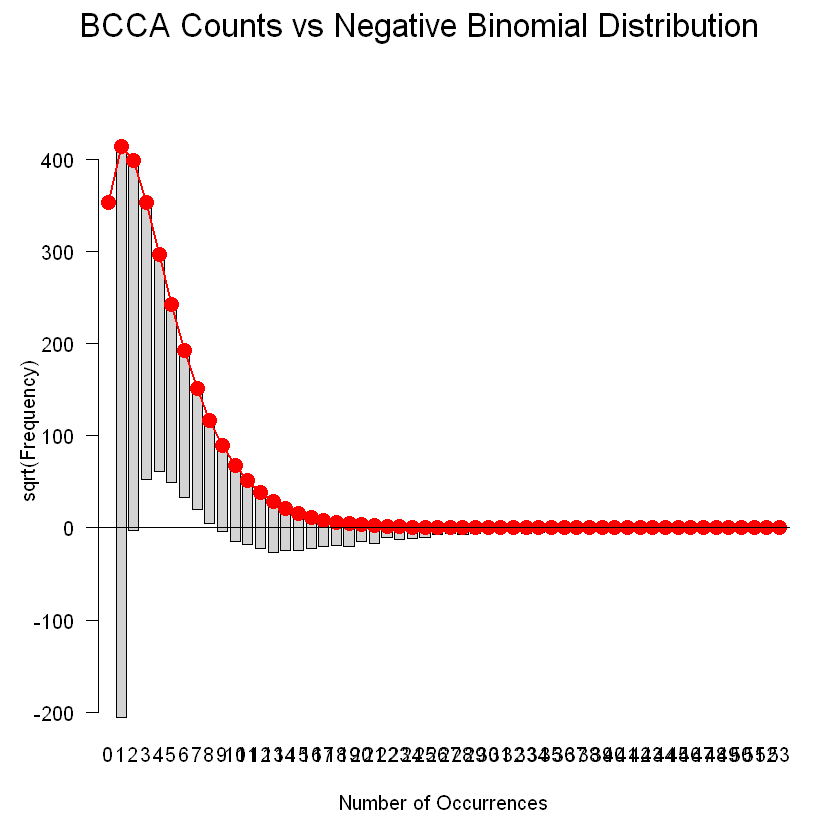

In [374]:
plot( BCgf_dJul, main="BCCA Counts vs Negative Binomial Distribution" )

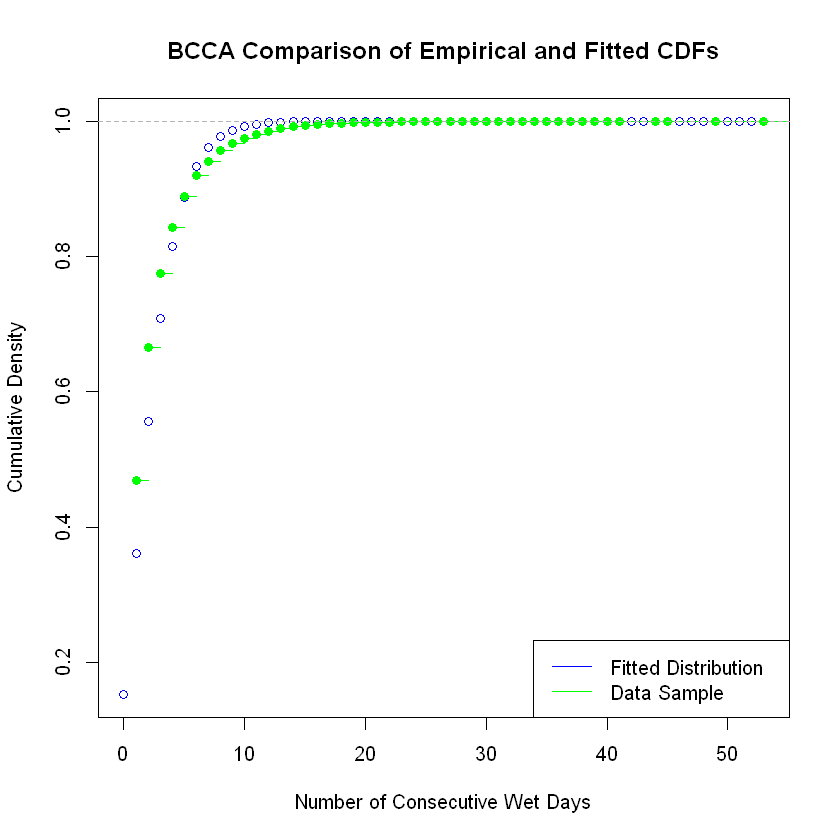

In [375]:
x <- seq(0,dBCJulMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJul_mu, size=BCfdNB_dJul_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJul$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

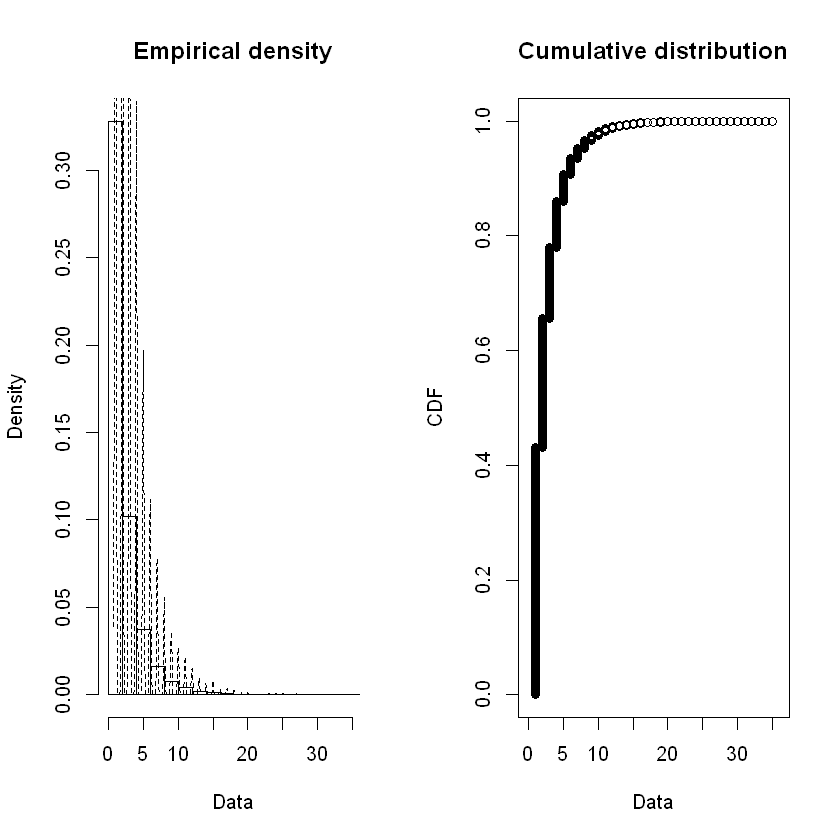

In [376]:
plotdist( dLOAug$Wet_Count, histo=TRUE, demp=TRUE )

In [377]:
LOfd_NB_dAug <- fitdist( dLOAug$Wet_Count, "nbinom" )
LOfd_GE_dAug <- fitdist( dLOAug$Wet_Count, "geom" )

In [378]:
LOfdNB_dAug_size <- LOfd_NB_dAug$estimate[["size"]]
LOfdNB_dAug_mu <- LOfd_NB_dAug$estimate[["mu"]]
cat("LOCA Aug size: ", LOfdNB_dAug_size, "\n", "LOCA Aug mu: ", LOfdNB_dAug_mu, "\n")

LOCA Aug size:  3.799249 
 LOCA Aug mu:  2.601277 


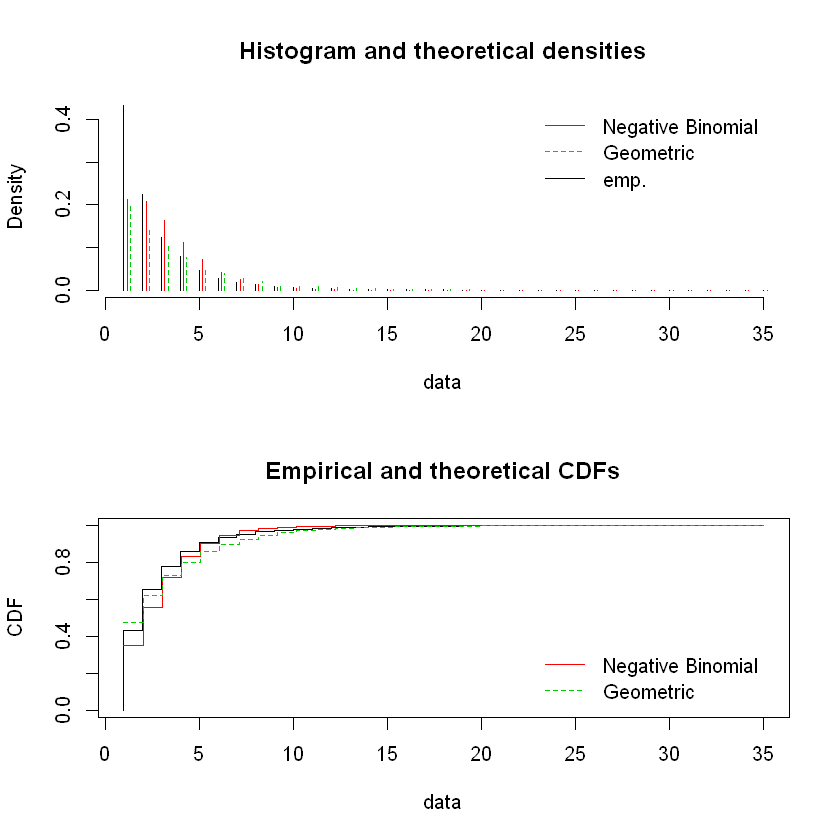

In [379]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dAug, LOfd_GE_dAug), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dAug, LOfd_GE_dAug), legendtext=plot.legend )

In [380]:
LOstatRes <- gofstat( list(LOfd_NB_dAug, LOfd_GE_dAug), fitnames=c("Negative Binomial", "Geometric") )

In [381]:
print( LOstatRes )

Chi-squared statistic:  206610.8 65999.6 
Degree of freedom of the Chi-squared distribution:  12 13 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     405601           329476.69887     449291.493
<= 2     211040           195019.29692     136110.052
<= 3     116545           153214.21465      98317.386
<= 4      74599           105845.15492      71018.329
<= 5      44076            67100.34162      51299.197
<= 6      26031            39993.55901      37055.331
<= 7      17507            22753.89611      26766.453
<= 8      12859            12483.32570      19334.411
<= 9       8302             6651.40083      13965.969
<= 10      6183             3459.94002      10088.142
<= 11      4540             1764.01509       7287.043
<= 12      3606              884.16168       5263.704
<= 13      2216              436.71262       3802.170
<= 15      3130              315.68429       4730.313
> 15       3256               92.59766     

In [382]:
LOfdNB_dAug_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [383]:
LOfdNB_dAug_p = LOfdNB_dAug_size / (LOfdNB_dAug_size + LOfdNB_dAug_mu)
cat("LOCA prob: ", LOfdNB_dAug_p)

LOCA prob:  0.5935839

In [384]:
# add to our tracking dataframe
LOMonDistDF[8, ] <- list( 8, dLOAugMean, dLOAugBNr, LOfdNB_dAug_p, LOfdNB_dAug_mu, LOfdNB_dAug_size,
                          LOfdNB_dAug_pvalue )

In [385]:
LOgf_dAug <- goodfit( dLOAug$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dAug_size, prob=LOfdNB_dAug_p) )

In [386]:
summary( LOgf_dAug )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          4212060.8 35        0
Likelihood Ratio  503623.3 34        0


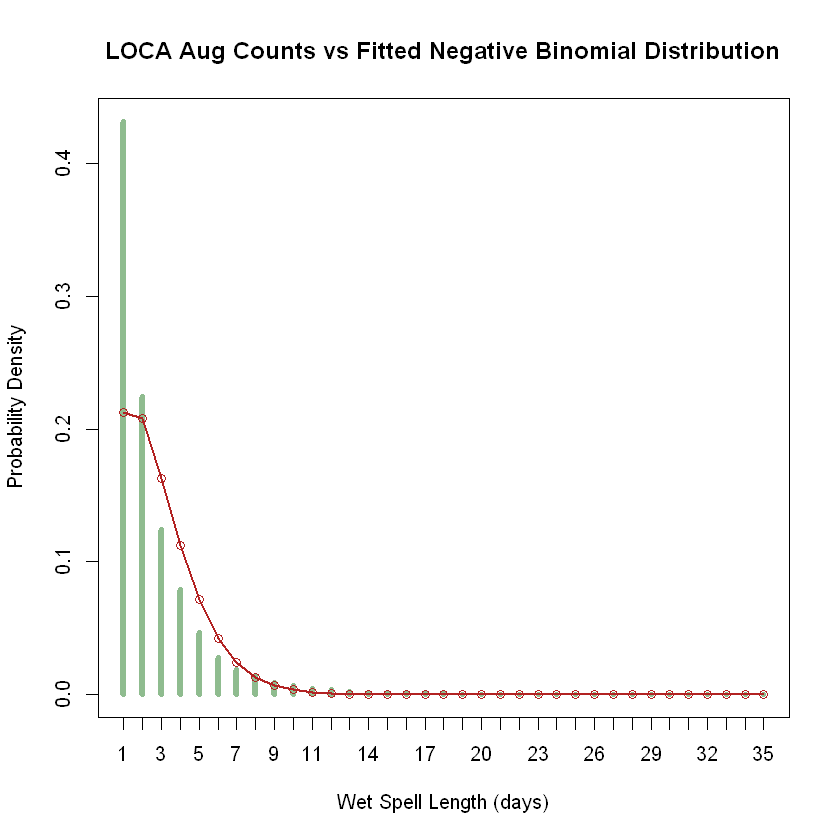

In [387]:
maxP <- max(dLOAug$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dAug_size, mu=LOfdNB_dAug_mu )
ttab <- table( dLOAug$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Aug Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

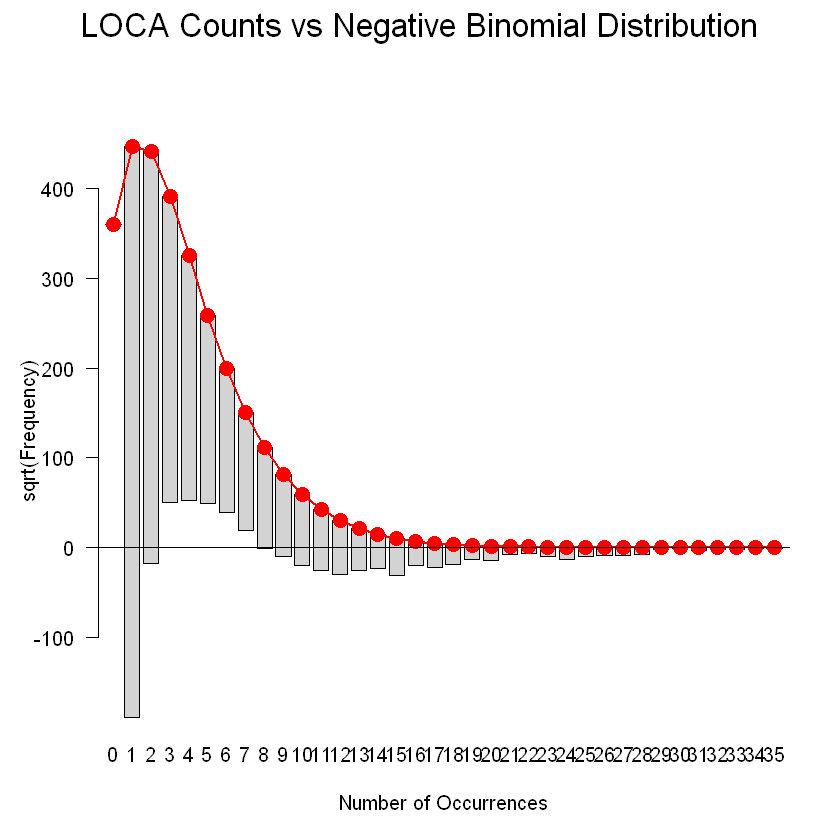

In [388]:
plot( LOgf_dAug, main="LOCA Counts vs Negative Binomial Distribution" )

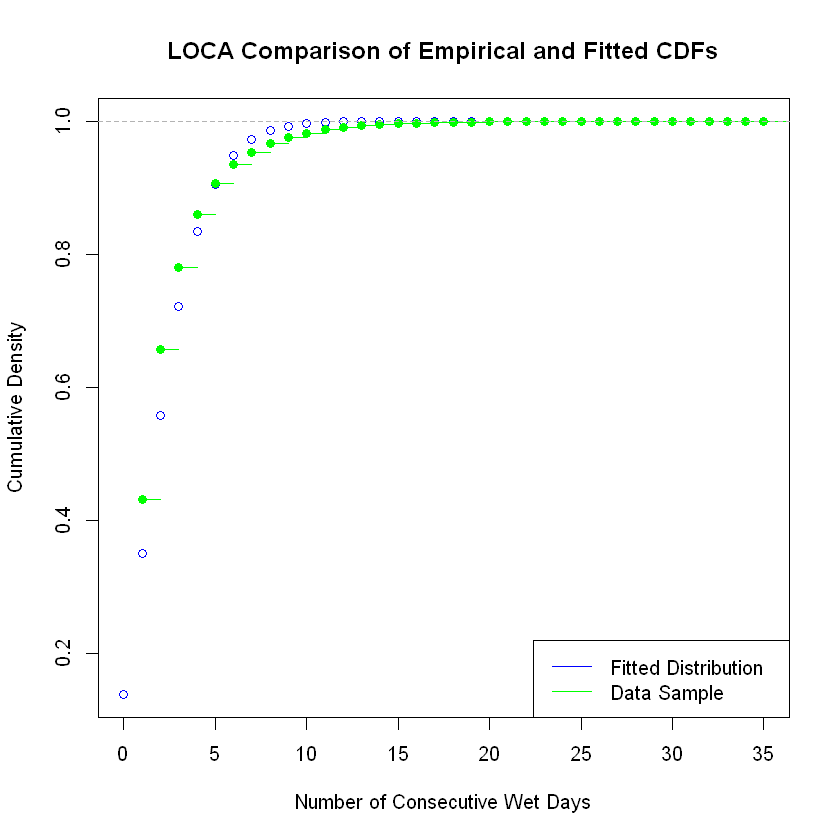

In [389]:
x <- seq(0,dLOAugMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dAug_mu, size=LOfdNB_dAug_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOAug$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

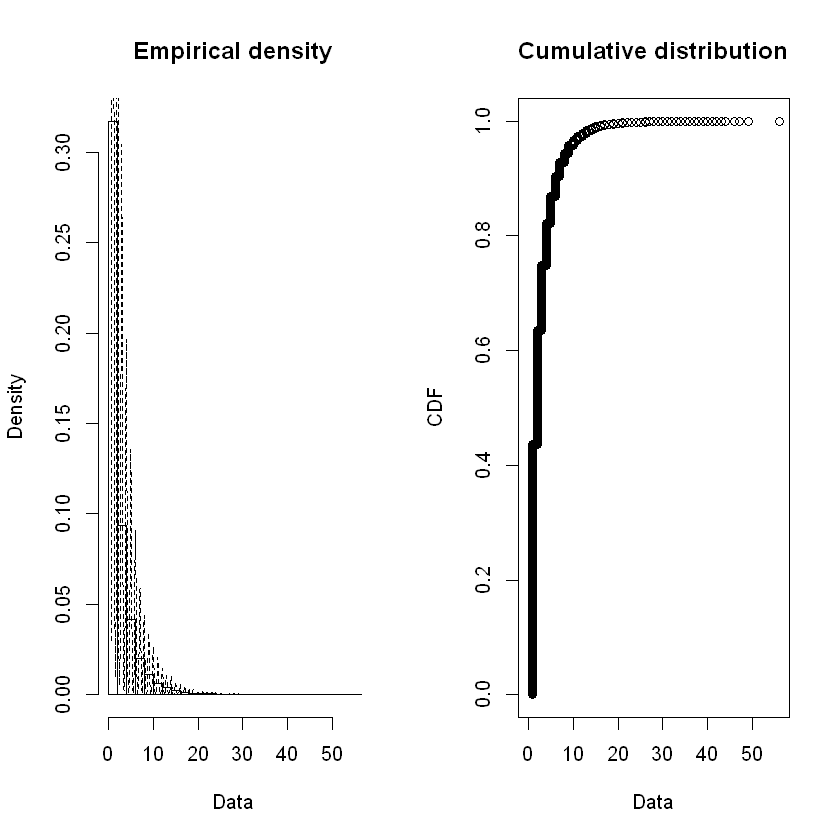

In [390]:
plotdist( dBCAug$Wet_Count, histo=TRUE, demp=TRUE )

In [391]:
BCfd_NB_dAug <- fitdist( dBCAug$Wet_Count, "nbinom" )
BCfd_GE_dAug <- fitdist( dBCAug$Wet_Count, "geom" )

In [392]:
summary( BCfd_NB_dAug )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.437501 0.006290979
mu   2.912552 0.002755297
Loglikelihood:  -1801030   AIC:  3602064   BIC:  3602088 
Correlation matrix:
             size           mu
size 1.000000e+00 4.424721e-05
mu   4.424721e-05 1.000000e+00


In [393]:
BCfdNB_dAug_size <- BCfd_NB_dAug$estimate[["size"]]
BCfdNB_dAug_mu <- BCfd_NB_dAug$estimate[["mu"]]
cat("BCCA Aug size: ", BCfdNB_dAug_size, "\n", "BCCA Aug mu: ", BCfdNB_dAug_mu, "\n")

BCCA Aug size:  2.437501 
 BCCA Aug mu:  2.912552 


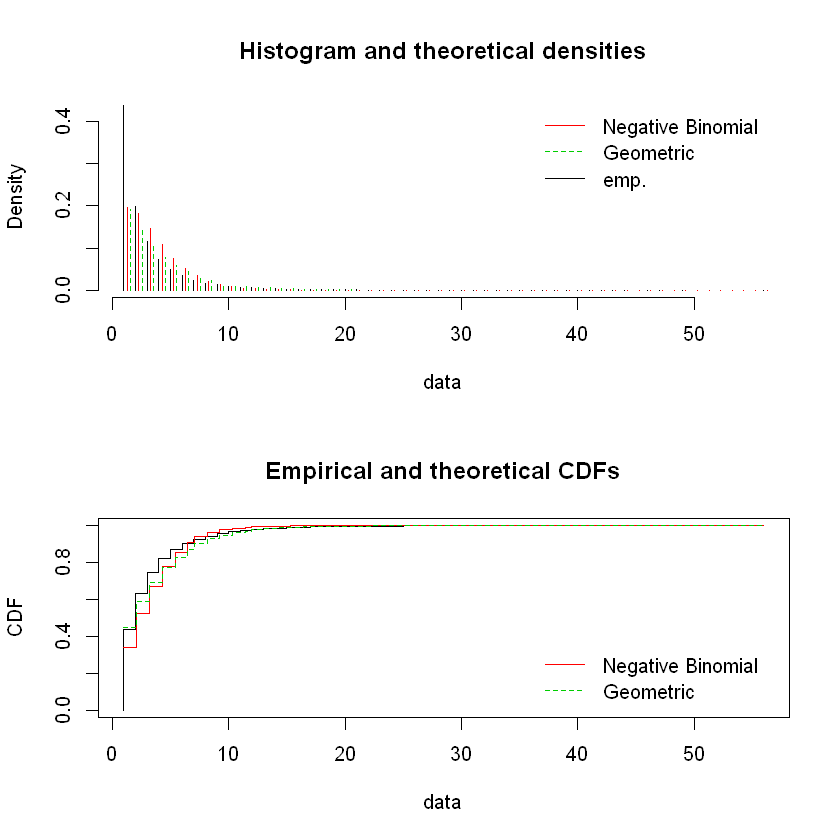

In [394]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dAug, BCfd_GE_dAug), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dAug, BCfd_GE_dAug), legendtext=plot.legend )

In [395]:
BCstatRes <- gofstat( list(BCfd_NB_dAug, BCfd_GE_dAug), fitnames=c("Negative Binomial", "Geometric") )

In [396]:
print(BCstatRes)

Chi-squared statistic:  232102.1 31100.03 
Degree of freedom of the Chi-squared distribution:  15 16 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     367892           288353.49726     375414.401
<= 2     166438           153859.30133     119259.813
<= 3      96674           123895.80625      88779.155
<= 4      60547            91687.81020      66088.803
<= 5      40717            64265.00385      49197.697
<= 6      28954            43367.65649      36623.652
<= 7      19760            28457.54159      27263.307
<= 8      14294            18275.95285      20295.297
<= 9      10844            11538.50850      15108.185
<= 10      8034             7184.49825      11246.805
<= 11      6114             4422.34387       8372.325
<= 12      4542             2695.91003       6232.509
<= 13      3582             1629.93277       4639.592
<= 14      3249              978.44017       3453.796
<= 15      2133              583.70636    

In [397]:
BCfdNB_dAug_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [398]:
BCfdNB_dAug_p = BCfdNB_dAug_size / (BCfdNB_dAug_size + BCfdNB_dAug_mu)
cat("BCCA prob: ", BCfdNB_dAug_p)

BCCA prob:  0.4556031

In [399]:
# add to our tracking dataframe
BCMonDistDF[8, ] <- list( 8, dBCAugMean, dBCAugBNr, BCfdNB_dAug_p, BCfdNB_dAug_mu, BCfdNB_dAug_size,
                          BCfdNB_dAug_pvalue )

In [400]:
BCgf_dAug <- goodfit( dBCAug$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dAug_size, prob=BCfdNB_dAug_p) )

In [401]:
summary( BCgf_dAug )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          12108586.1 56        0
Likelihood Ratio   513821.1 47        0


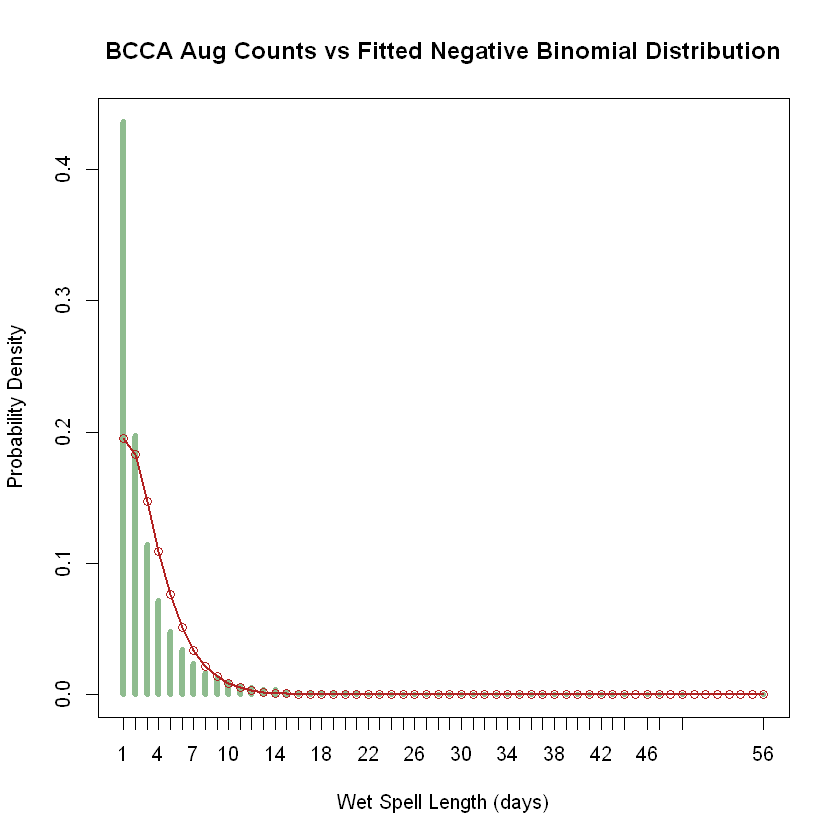

In [402]:
maxP <- max(dBCAug$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dAug_size, mu=BCfdNB_dAug_mu )
ttab <- table( dBCAug$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Aug Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

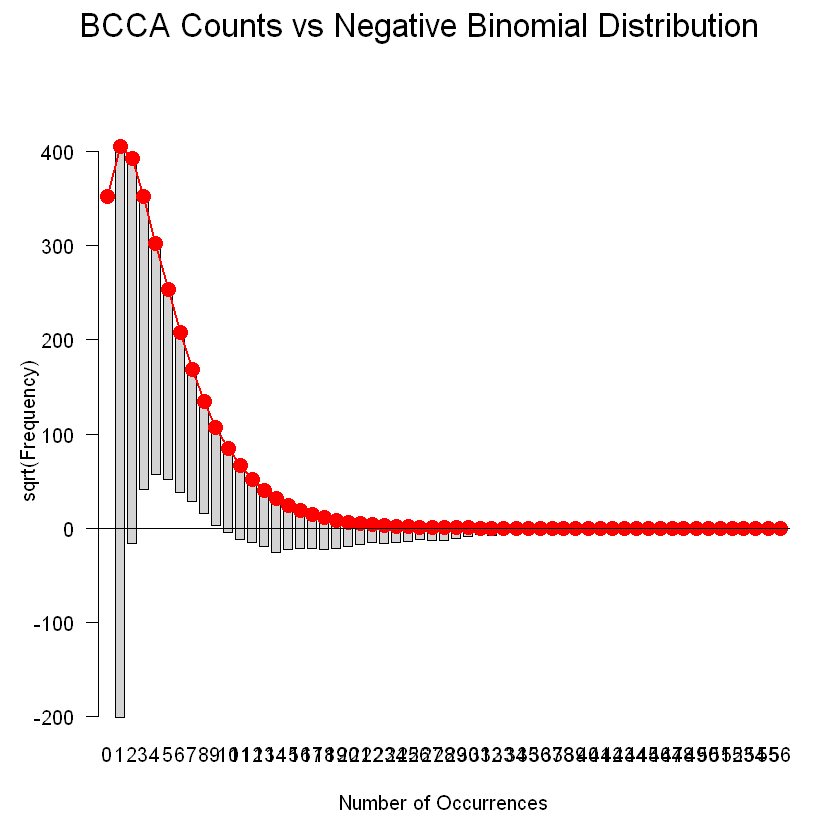

In [403]:
plot( BCgf_dAug, main="BCCA Counts vs Negative Binomial Distribution" )

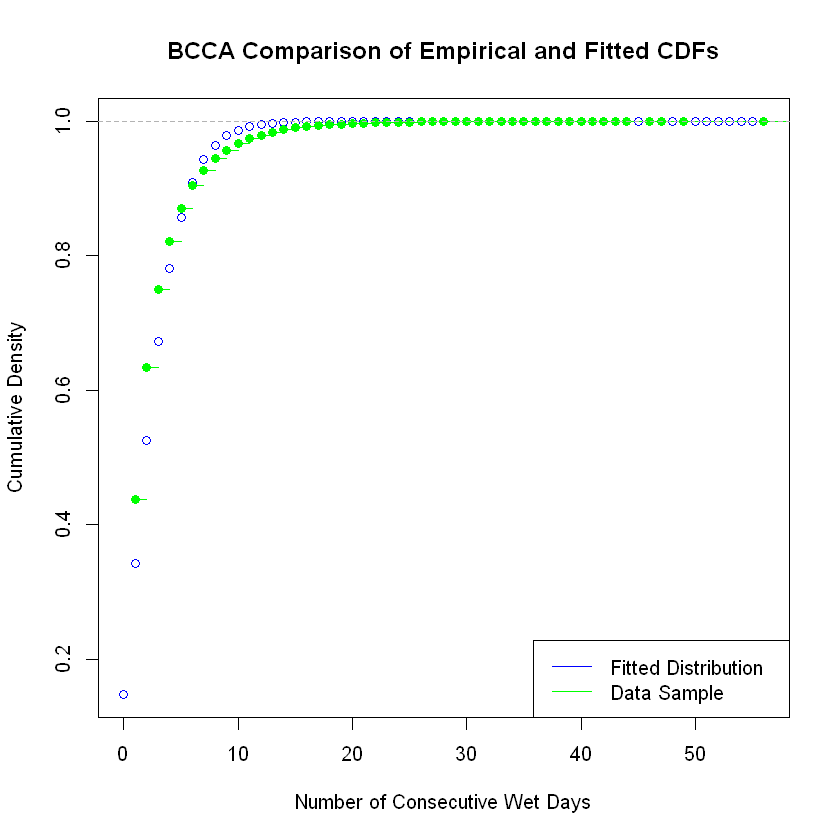

In [404]:
x <- seq(0,dBCAugMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dAug_mu, size=BCfdNB_dAug_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCAug$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

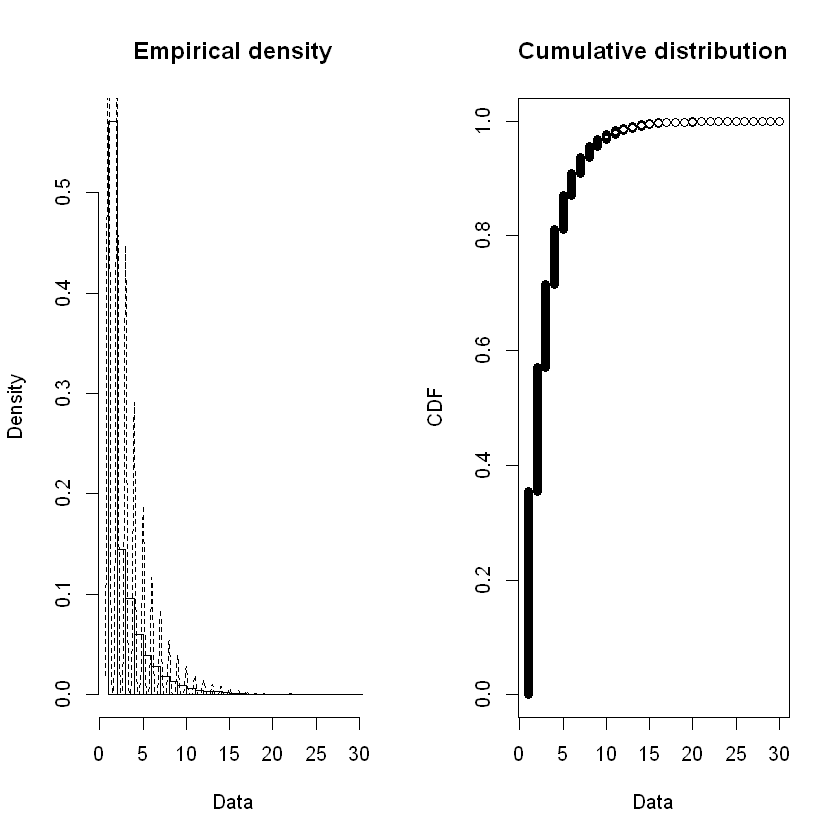

In [405]:
plotdist( dLOSep$Wet_Count, histo=TRUE, demp=TRUE )

In [406]:
LOfd_NB_dSep <- fitdist( dLOSep$Wet_Count, "nbinom" )
LOfd_GE_dSep <- fitdist( dLOSep$Wet_Count, "geom" )

In [407]:
LOfdNB_dSep_size <- LOfd_NB_dSep$estimate[["size"]]
LOfdNB_dSep_mu <- LOfd_NB_dSep$estimate[["mu"]]
cat("LOCA Sep size: ", LOfdNB_dSep_size, "\n", "LOCA Sep mu: ", LOfdNB_dSep_mu, "\n")

LOCA Sep size:  3.644089 
 LOCA Sep mu:  2.987743 


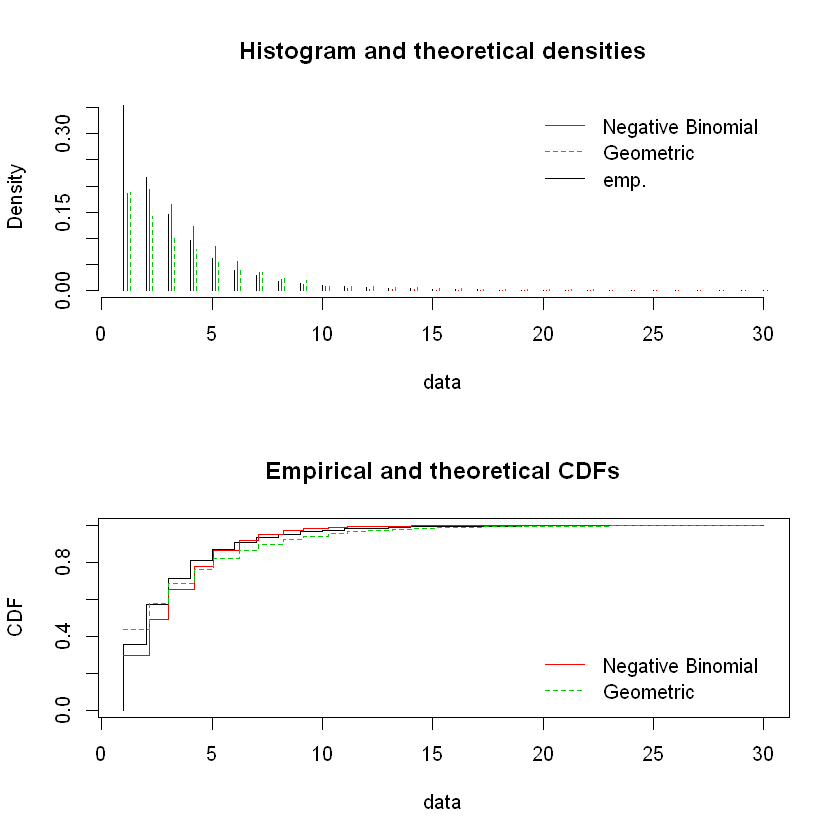

In [408]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dSep, LOfd_GE_dSep), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dSep, LOfd_GE_dSep), legendtext=plot.legend )

In [409]:
LOstatRes <- gofstat( list(LOfd_NB_dSep, LOfd_GE_dSep), fitnames=c("Negative Binomial", "Geometric") )

In [410]:
print( LOstatRes )

Chi-squared statistic:  120855.6 102264.1 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     395873            333285.4652     490521.123
<= 2     242655            216674.9787     157417.640
<= 3     161551            183650.0515     117944.140
<= 4     106709            137428.3061      88368.878
<= 5      67212             94654.5751      66209.806
<= 6      43225             61435.4825      49607.266
<= 7      31290             38132.2231      37167.920
<= 8      19741             22857.0572      27847.822
<= 9      14228             13322.7231      20864.799
<= 10     10045              7589.0991      15632.815
<= 11      6977              4240.8388      11712.785
<= 12      5146              2331.5383       8775.727
<= 13      3732              1264.0352       6575.157
<= 14      3162               677.0189       4926.393
<= 16      3523               547.1149    

In [411]:
LOfdNB_dSep_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [412]:
LOfdNB_dSep_p = LOfdNB_dSep_size / (LOfdNB_dSep_size + LOfdNB_dSep_mu)
cat("LOCA prob: ", LOfdNB_dSep_p)

LOCA prob:  0.5494846

In [413]:
# add to our tracking dataframe
LOMonDistDF[9, ] <- list( 9, dLOSepMean, dLOSepBNr, LOfdNB_dSep_p, LOfdNB_dSep_mu, LOfdNB_dSep_size,
                          LOfdNB_dSep_pvalue )

In [414]:
LOgf_dSep <- goodfit( dLOSep$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dSep_size, prob=LOfdNB_dSep_p) )

In [415]:
summary( LOgf_dSep )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          496824.3 30        0
Likelihood Ratio 451606.4 29        0


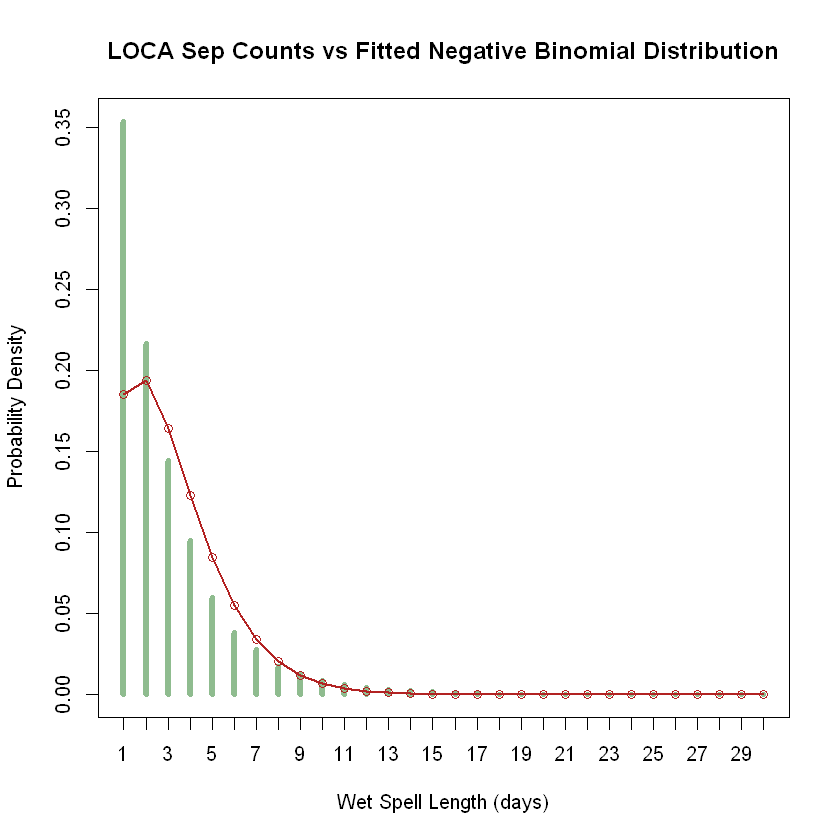

In [416]:
maxP <- max(dLOSep$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dSep_size, mu=LOfdNB_dSep_mu )
ttab <- table( dLOSep$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Sep Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

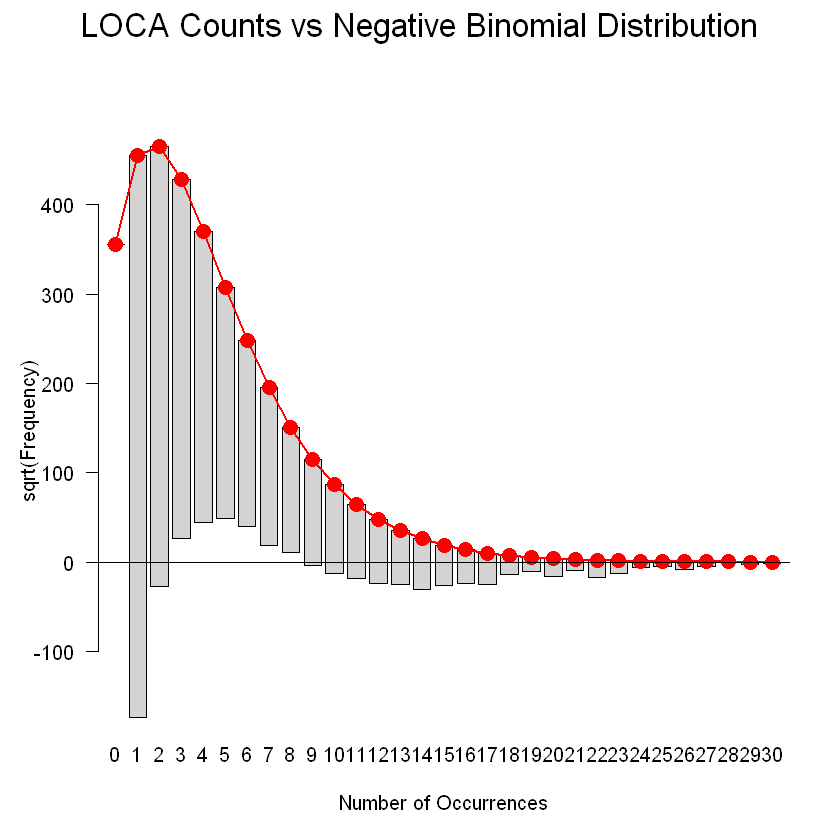

In [417]:
plot( LOgf_dSep, main="LOCA Counts vs Negative Binomial Distribution" )

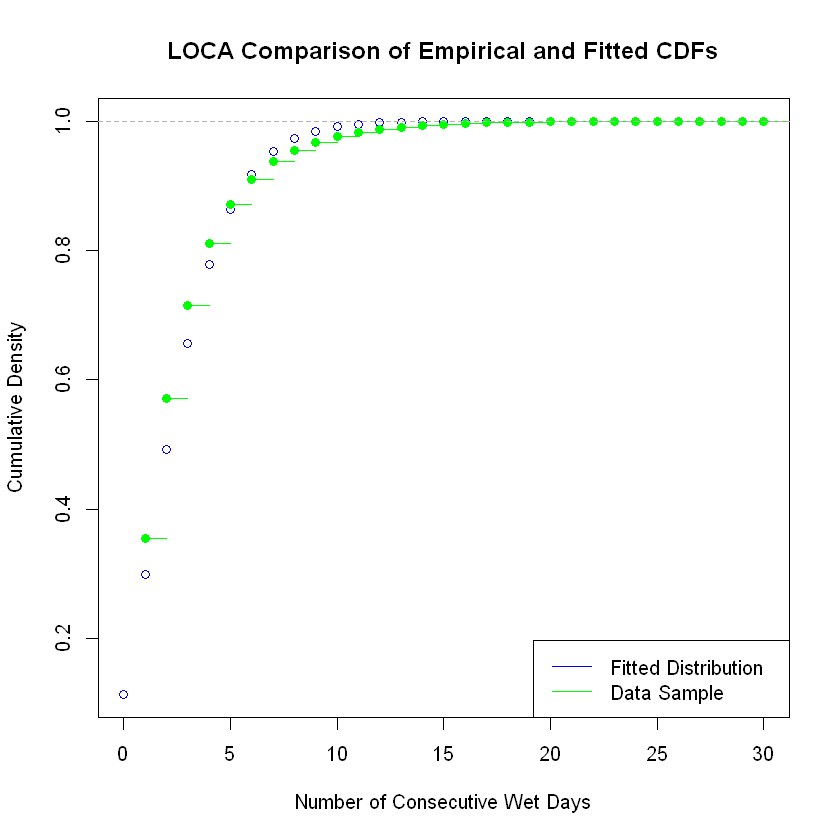

In [418]:
x <- seq(0,dLOSepMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dSep_mu, size=LOfdNB_dSep_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOSep$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

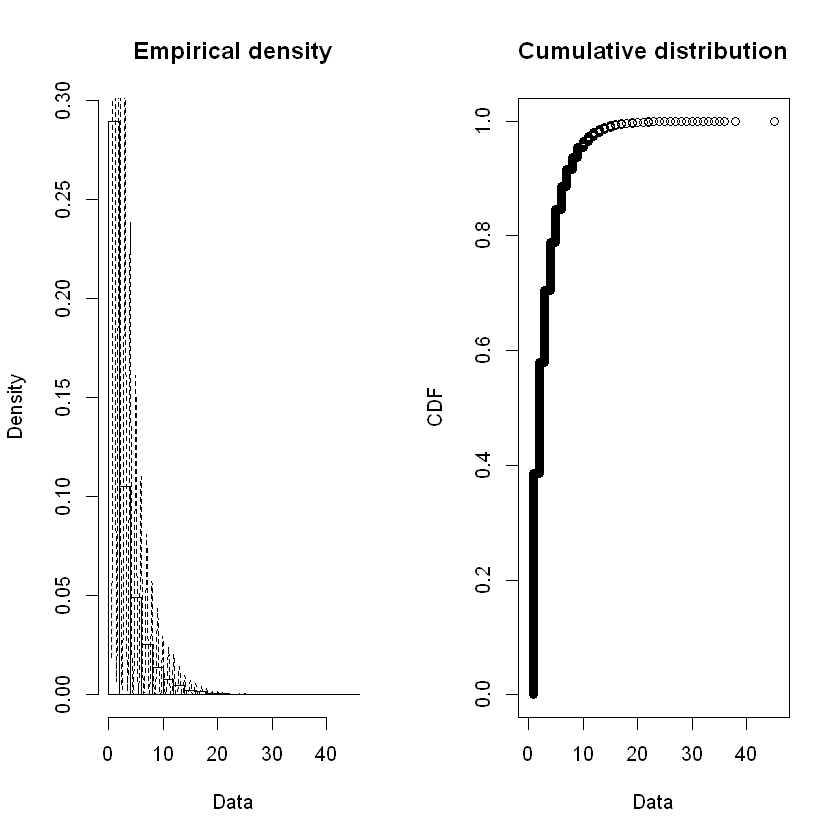

In [419]:
plotdist( dBCSep$Wet_Count, histo=TRUE, demp=TRUE )

In [420]:
BCfd_NB_dSep <- fitdist( dBCSep$Wet_Count, "nbinom" )
BCfd_GE_dSep <- fitdist( dBCSep$Wet_Count, "geom" )

In [421]:
summary( BCfd_NB_dSep )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.637800 0.007324303
mu   3.136591 0.002995664
Loglikelihood:  -1675451   AIC:  3350906   BIC:  3350929 
Correlation matrix:
            size          mu
size 1.00000e+00 5.78584e-05
mu   5.78584e-05 1.00000e+00


In [422]:
BCfdNB_dSep_size <- BCfd_NB_dSep$estimate[["size"]]
BCfdNB_dSep_mu <- BCfd_NB_dSep$estimate[["mu"]]
cat("BCCA Sep size: ", BCfdNB_dSep_size, "\n", "BCCA Sep mu: ", BCfdNB_dSep_mu, "\n")

BCCA Sep size:  2.6378 
 BCCA Sep mu:  3.136591 


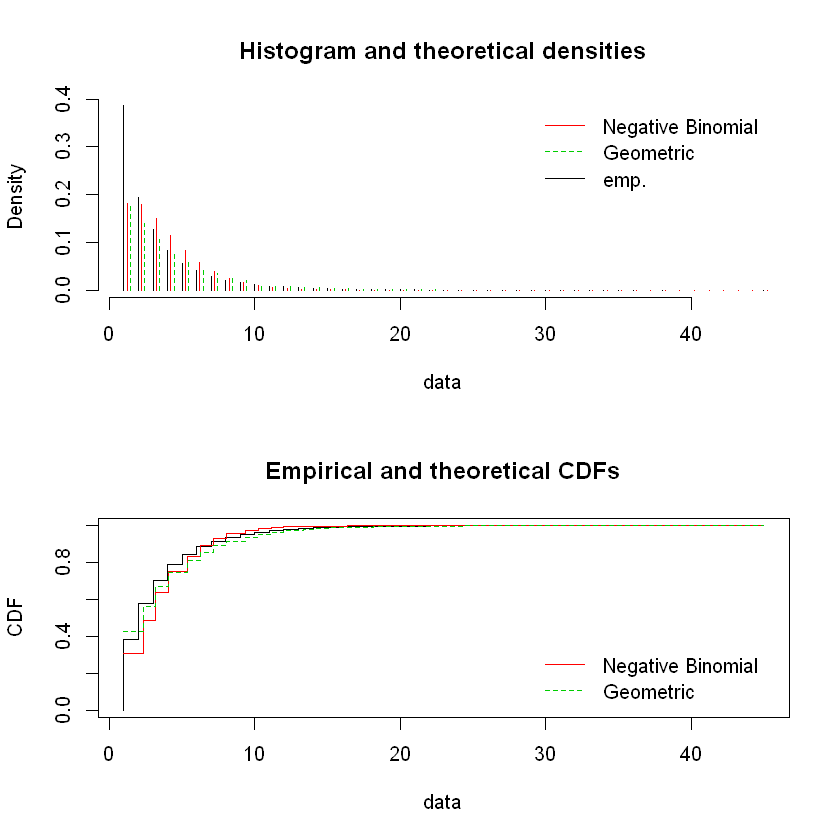

In [423]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dSep, BCfd_GE_dSep), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dSep, BCfd_GE_dSep), legendtext=plot.legend )

In [424]:
BCstatRes <- gofstat( list(BCfd_NB_dSep, BCfd_GE_dSep), fitnames=c("Negative Binomial", "Geometric") )

In [425]:
print(BCstatRes)

Chi-squared statistic:  93443.98 28297 
Degree of freedom of the Chi-squared distribution:  15 16 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     295399           235653.15932     325192.336
<= 2     147782           137124.87670     106339.611
<= 3      96717           115148.61486      80633.259
<= 4      63888            88157.66899      61141.115
<= 5      43263            63572.01290      46360.969
<= 6      31643            43957.67364      35153.749
<= 7      22568            29463.98673      26655.743
<= 8      16125            19281.07033      20212.030
<= 9      12357            12379.18792      15326.009
<= 10      8425             7825.54784      11621.127
<= 11      6661             4883.65807       8811.856
<= 12      5328             3014.81055       6681.693
<= 13      4109             1843.92897       5066.472
<= 14      2670             1118.77696       3841.712
<= 15      2001              674.06202       

In [426]:
BCfdNB_dSep_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [427]:
BCfdNB_dSep_p = BCfdNB_dSep_size / (BCfdNB_dSep_size + BCfdNB_dSep_mu)
cat("BCCA prob: ", BCfdNB_dSep_p)

BCCA prob:  0.4568101

In [428]:
# add to our tracking dataframe
BCMonDistDF[9, ] <- list( 9, dBCSepMean, dBCSepBNr, BCfdNB_dSep_p, BCfdNB_dSep_mu, BCfdNB_dSep_size,
                          BCfdNB_dSep_pvalue )

In [429]:
BCgf_dSep <- goodfit( dBCSep$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dSep_size, prob=BCfdNB_dSep_p) )

In [430]:
summary( BCgf_dSep )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          470382.3 45        0
Likelihood Ratio 374036.3 37        0


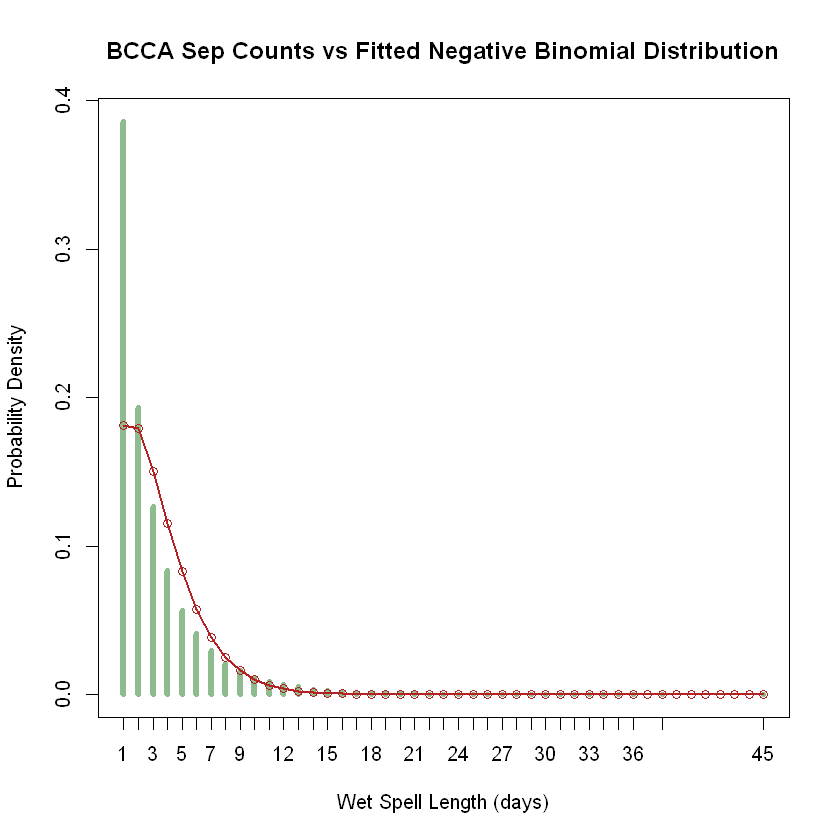

In [431]:
maxP <- max(dBCSep$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dSep_size, mu=BCfdNB_dSep_mu )
ttab <- table( dBCSep$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Sep Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

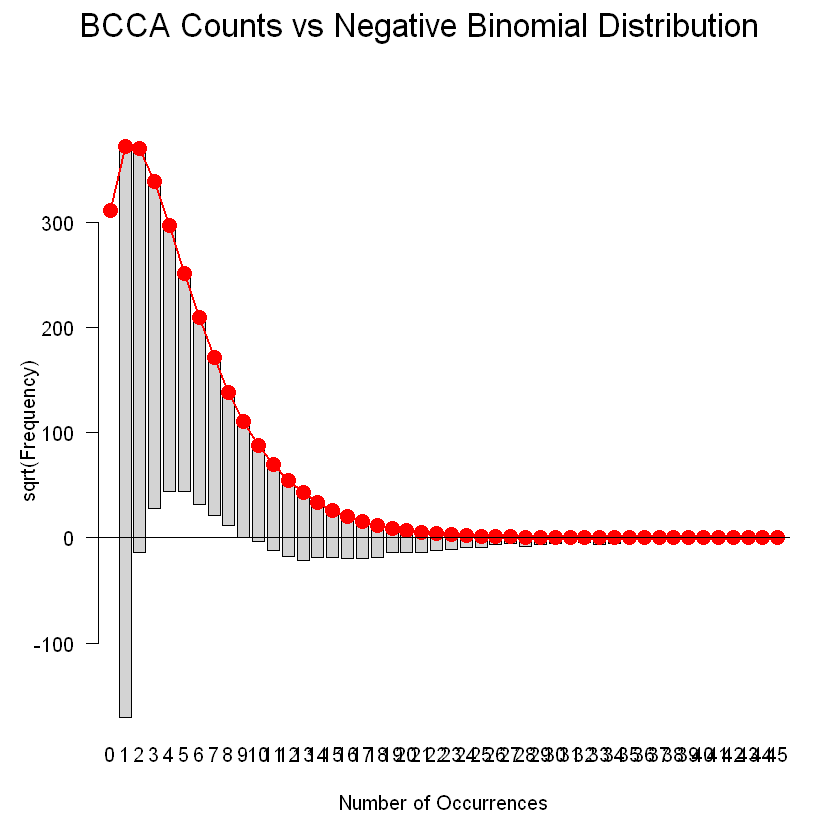

In [432]:
plot( BCgf_dSep, main="BCCA Counts vs Negative Binomial Distribution" )

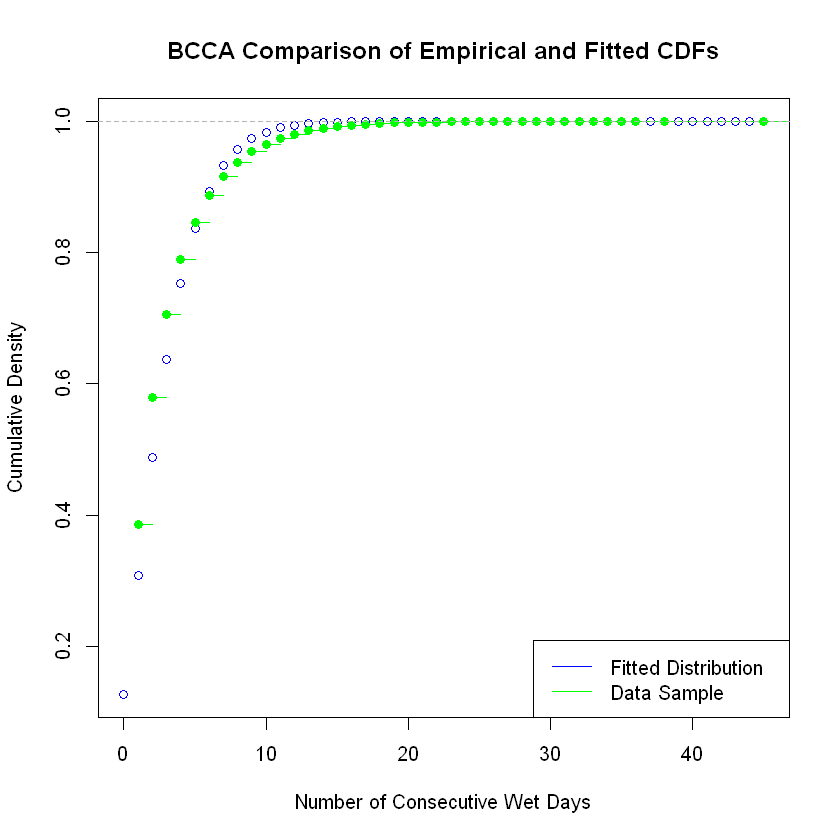

In [433]:
x <- seq(0,dBCSepMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dSep_mu, size=BCfdNB_dSep_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCSep$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

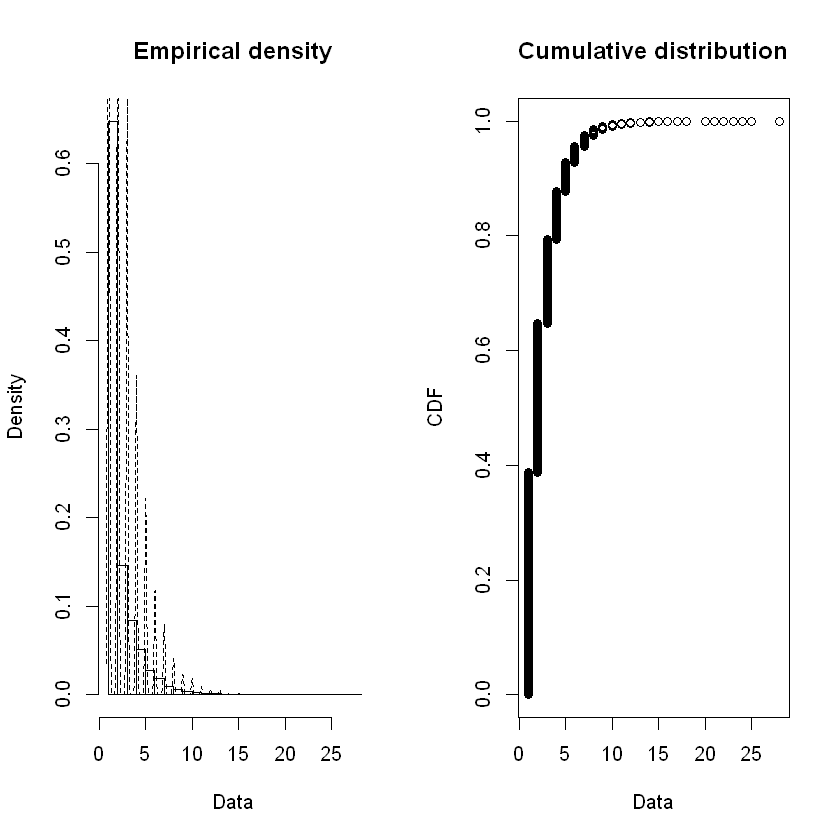

In [434]:
plotdist( dLOOct$Wet_Count, histo=TRUE, demp=TRUE )

In [435]:
LOfd_NB_dOct <- fitdist( dLOOct$Wet_Count, "nbinom" )
LOfd_GE_dOct <- fitdist( dLOOct$Wet_Count, "geom" )

In [436]:
LOfdNB_dOct_size <- LOfd_NB_dOct$estimate[["size"]]
LOfdNB_dOct_mu <- LOfd_NB_dOct$estimate[["mu"]]
cat("LOCA Oct size: ", LOfdNB_dOct_size, "\n", "LOCA Oct mu: ", LOfdNB_dOct_mu, "\n")

LOCA Oct size:  8.966726 
 LOCA Oct mu:  2.469968 


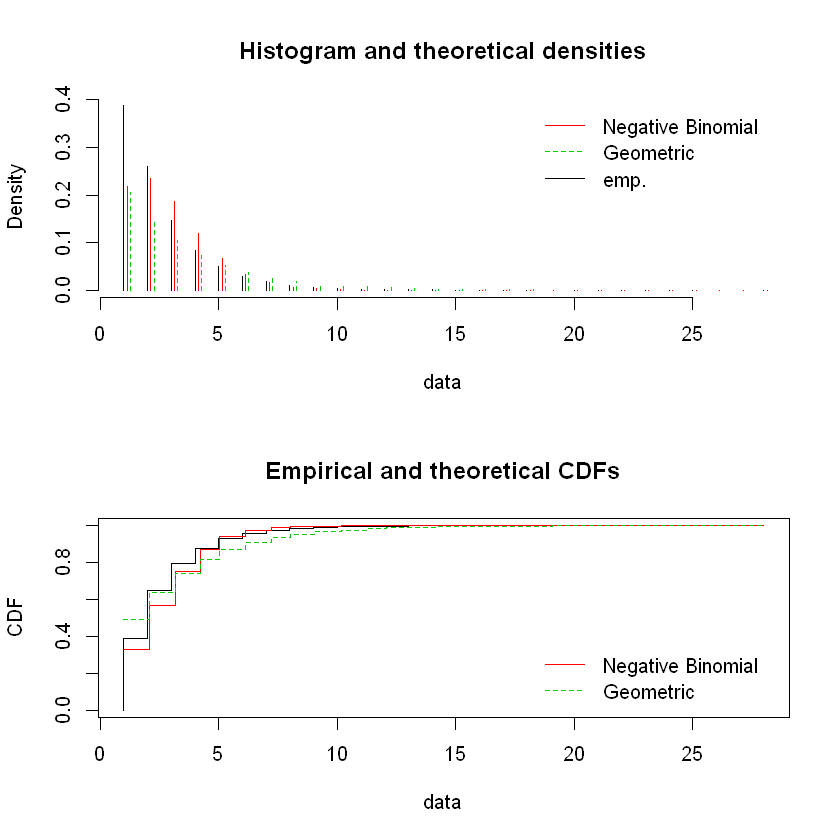

In [437]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dOct, LOfd_GE_dOct), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dOct, LOfd_GE_dOct), legendtext=plot.legend )

In [438]:
LOstatRes <- gofstat( list(LOfd_NB_dOct, LOfd_GE_dOct), fitnames=c("Negative Binomial", "Geometric") )

In [439]:
print( LOstatRes )

Chi-squared statistic:  129051.9 164735.9 
Degree of freedom of the Chi-squared distribution:  9 10 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     391597           334949.42835     498636.899
<= 2     263232           237729.17391     147584.240
<= 3     148026           187684.75358     105049.336
<= 4      85018           121264.90306      74773.316
<= 5      51121            67918.20912      53223.075
<= 6      28169            34144.46875      37883.779
<= 7      18801            15766.66711      26965.385
<= 8       9535             6796.04981      19193.755
<= 9       5521             2766.95986      13661.968
<= 10      3914             1073.64961       9724.485
<= 12      3505              543.48052      11848.709
> 12       2274               75.25632      12168.054

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3759372   4212053
Bayesia

In [440]:
LOfdNB_dOct_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [441]:
LOfdNB_dOct_p = LOfdNB_dOct_size / (LOfdNB_dOct_size + LOfdNB_dOct_mu)
cat("LOCA prob: ", LOfdNB_dOct_p)

LOCA prob:  0.7840313

In [442]:
# add to our tracking dataframe
LOMonDistDF[10, ] <- list( 10, dLOOctMean, dLOOctBNr, LOfdNB_dOct_p, LOfdNB_dOct_mu, LOfdNB_dOct_size,
                          LOfdNB_dOct_pvalue )

In [443]:
LOgf_dOct <- goodfit( dLOOct$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dOct_size, prob=LOfdNB_dOct_p) )

In [444]:
summary( LOgf_dOct )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          14206468.9 28        0
Likelihood Ratio   393179.3 24        0


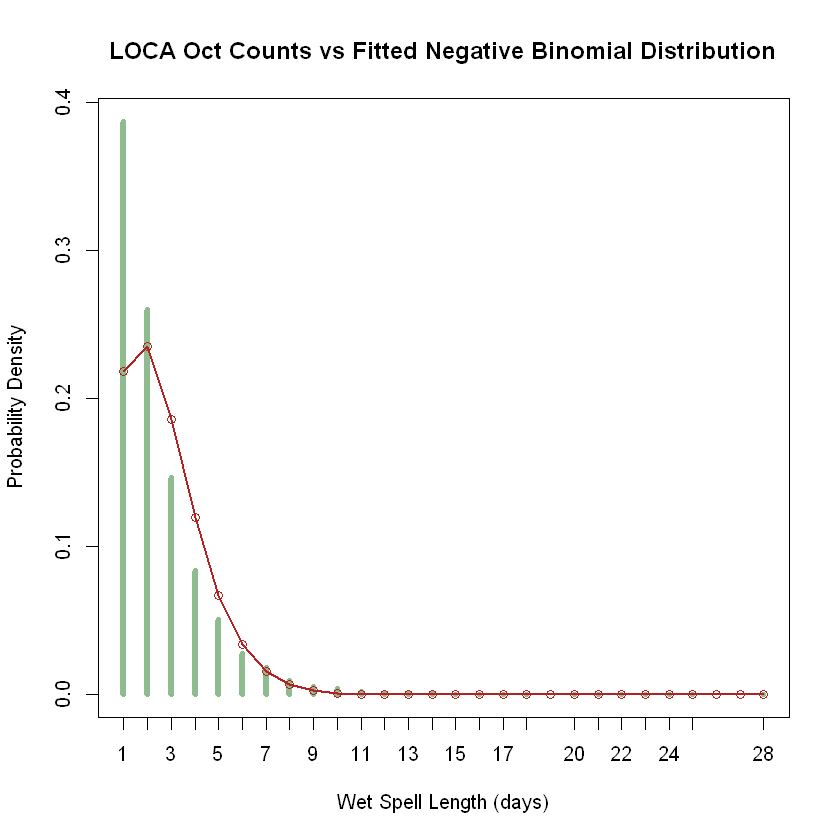

In [445]:
maxP <- max(dLOOct$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dOct_size, mu=LOfdNB_dOct_mu )
ttab <- table( dLOOct$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Oct Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

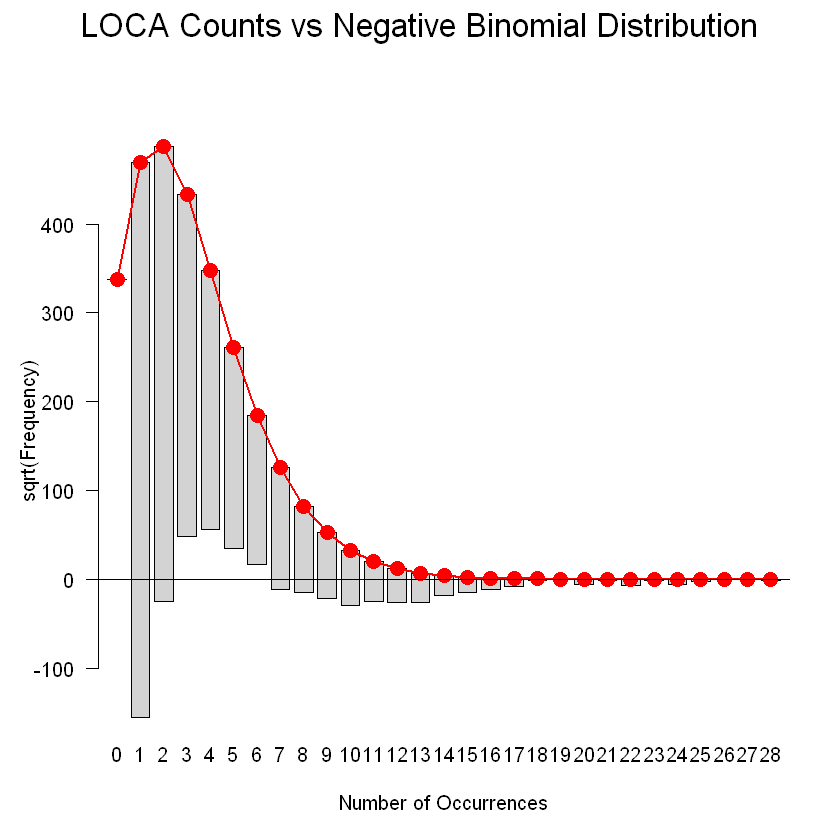

In [446]:
plot( LOgf_dOct, main="LOCA Counts vs Negative Binomial Distribution" )

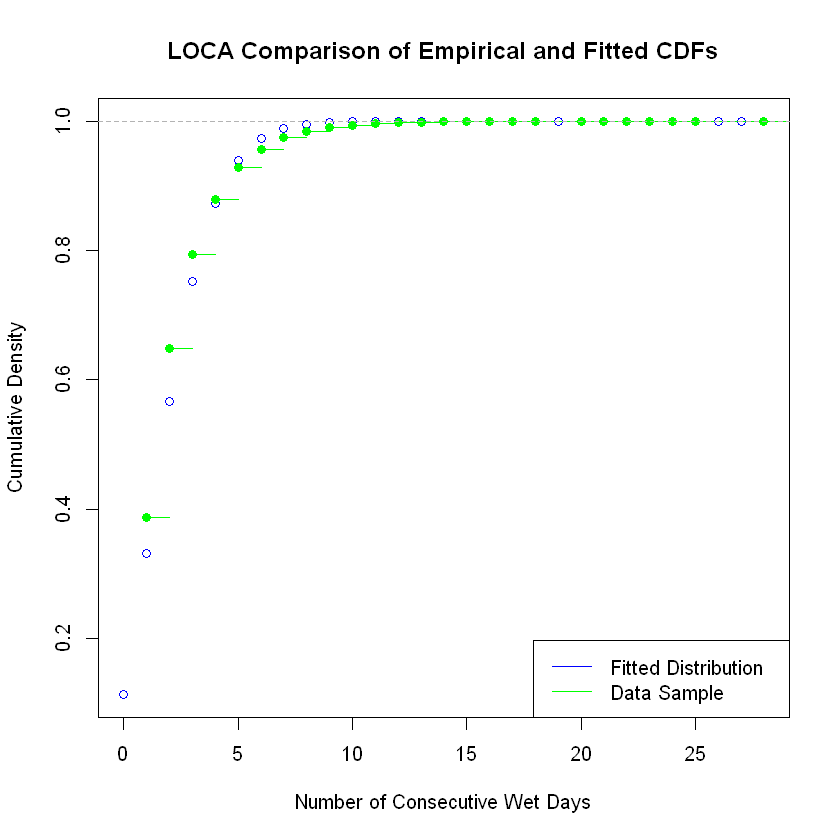

In [447]:
x <- seq(0,dLOOctMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dOct_mu, size=LOfdNB_dOct_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOOct$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

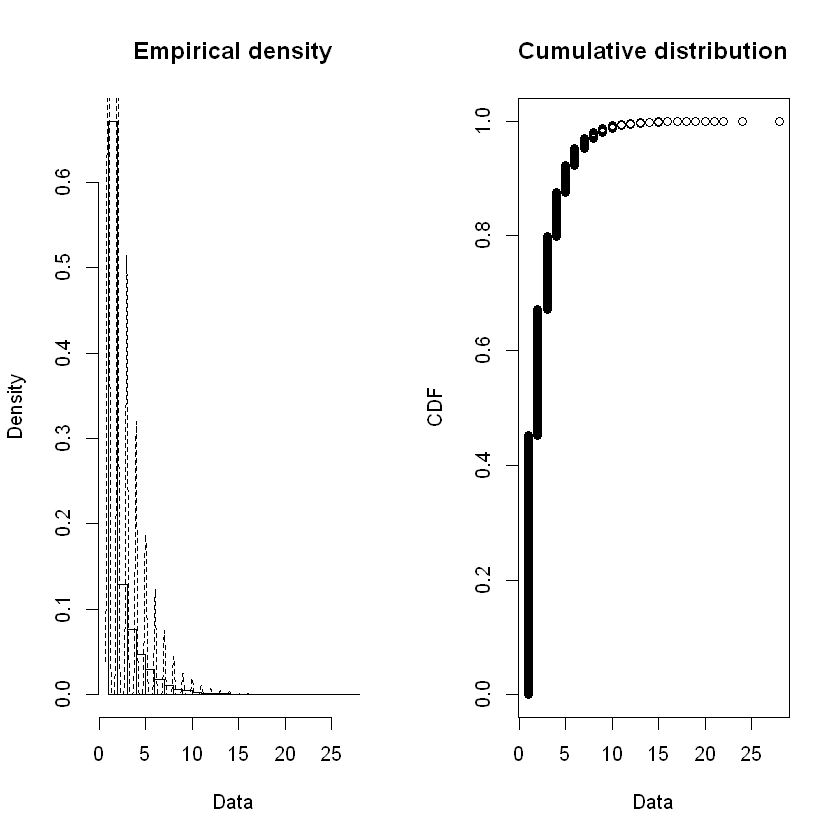

In [448]:
plotdist( dBCOct$Wet_Count, histo=TRUE, demp=TRUE )

In [449]:
BCfd_NB_dOct <- fitdist( dBCOct$Wet_Count, "nbinom" )
BCfd_GE_dOct <- fitdist( dBCOct$Wet_Count, "geom" )

In [450]:
summary( BCfd_NB_dOct )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 5.939888 0.031223172
mu   2.405865 0.002230166
Loglikelihood:  -1276582   AIC:  2553169   BIC:  2553191 
Correlation matrix:
             size           mu
size 1.0000000000 0.0002068857
mu   0.0002068857 1.0000000000


In [451]:
BCfdNB_dOct_size <- BCfd_NB_dOct$estimate[["size"]]
BCfdNB_dOct_mu <- BCfd_NB_dOct$estimate[["mu"]]
cat("BCCA Oct size: ", BCfdNB_dOct_size, "\n", "BCCA Oct mu: ", BCfdNB_dOct_mu, "\n")

BCCA Oct size:  5.939888 
 BCCA Oct mu:  2.405865 


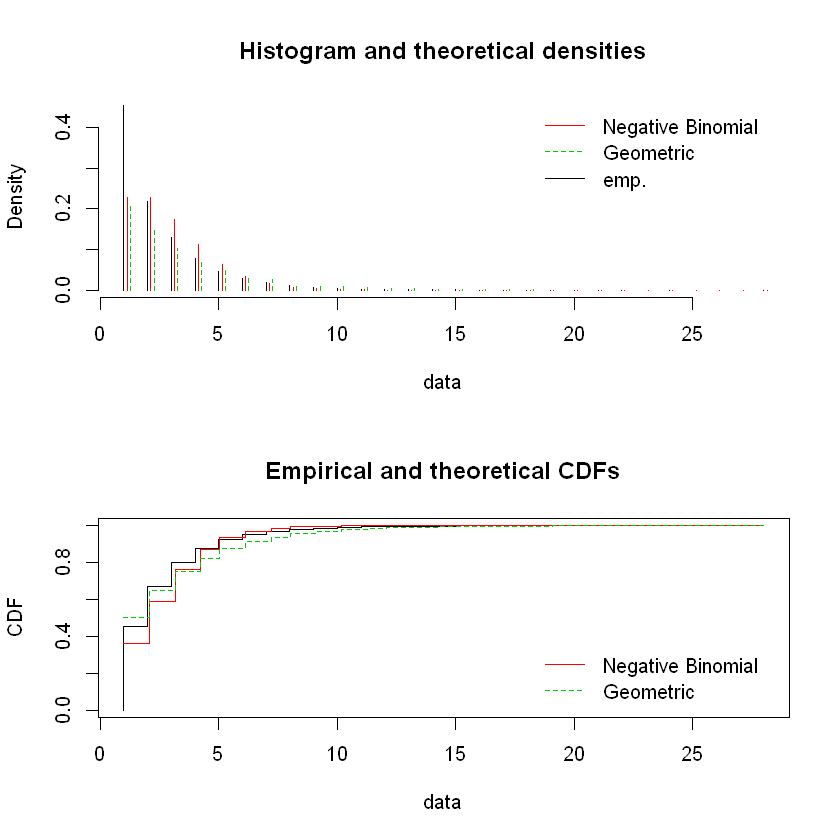

In [452]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dOct, BCfd_GE_dOct), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dOct, BCfd_GE_dOct), legendtext=plot.legend )

In [453]:
BCstatRes <- gofstat( list(BCfd_NB_dOct, BCfd_GE_dOct), fitnames=c("Negative Binomial", "Geometric") )

In [454]:
print(BCstatRes)

Chi-squared statistic:  111562.5 46460.13 
Degree of freedom of the Chi-squared distribution:  10 11 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     307651           244516.20765     340432.932
<= 2     148649           154411.43148      99555.850
<= 3      87288           117808.94380      70327.751
<= 4      52145            75902.49311      49680.582
<= 5      31585            43498.39374      35095.111
<= 6      19823            22863.38545      24791.715
<= 7      12445            11242.12589      17513.240
<= 8       7206             5241.97165      12371.617
<= 9       4233             2340.54576       8739.496
<= 10      3122             1008.02237       6173.712
<= 11      1891              421.08371       4361.203
<= 13      1969              239.52640       5257.157
> 13       1530               42.86899       5236.636

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's In

In [455]:
BCfdNB_dOct_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [456]:
BCfdNB_dOct_p = BCfdNB_dOct_size / (BCfdNB_dOct_size + BCfdNB_dOct_mu)
cat("BCCA prob: ", BCfdNB_dOct_p)

BCCA prob:  0.7117259

In [457]:
# add to our tracking dataframe
BCMonDistDF[10, ] <- list( 10, dBCOctMean, dBCOctBNr, BCfdNB_dOct_p, BCfdNB_dOct_mu, BCfdNB_dOct_size,
                          BCfdNB_dOct_pvalue )

In [458]:
BCgf_dOct <- goodfit( dBCOct$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dOct_size, prob=BCfdNB_dOct_p) )

In [459]:
summary( BCgf_dOct )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          454441.5 28        0
Likelihood Ratio 340571.7 23        0


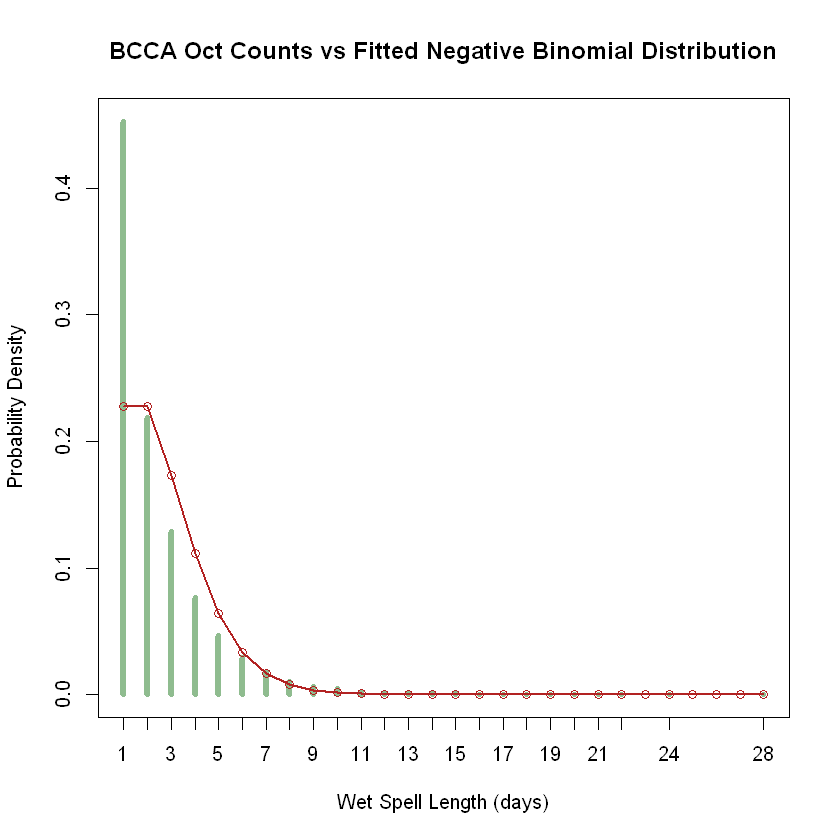

In [460]:
maxP <- max(dBCOct$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dOct_size, mu=BCfdNB_dOct_mu )
ttab <- table( dBCOct$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Oct Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

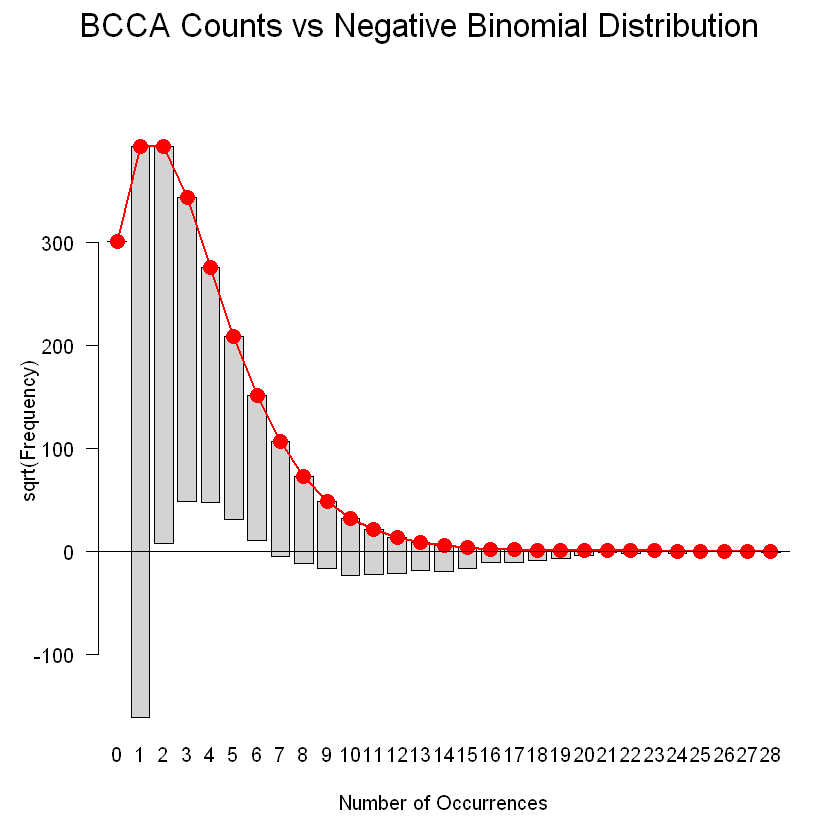

In [461]:
plot( BCgf_dOct, main="BCCA Counts vs Negative Binomial Distribution" )

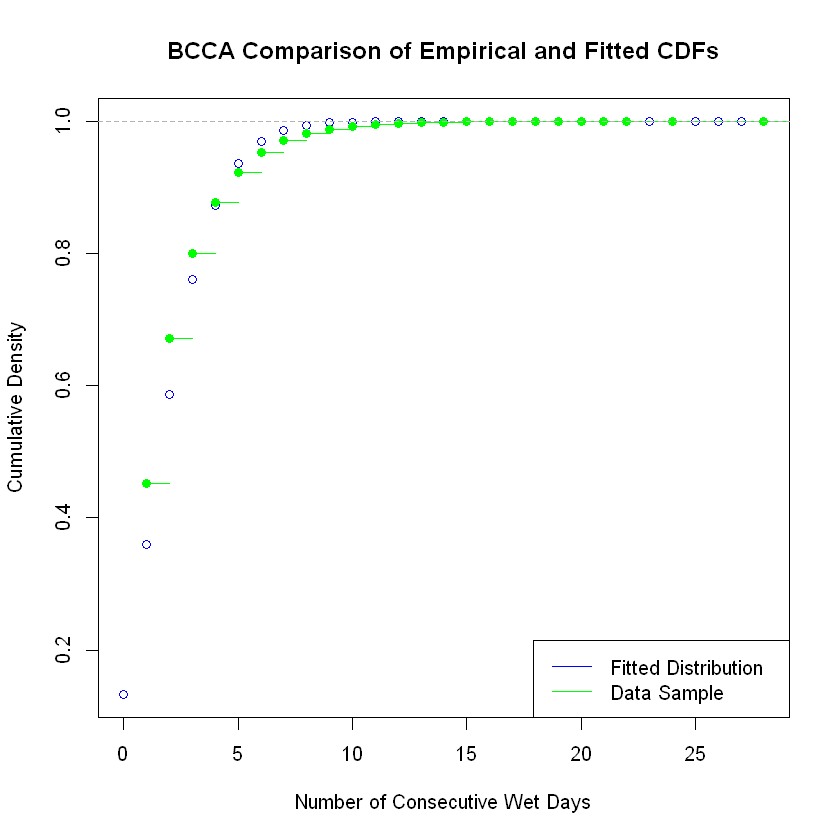

In [462]:
x <- seq(0,dBCOctMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dOct_mu, size=BCfdNB_dOct_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCOct$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

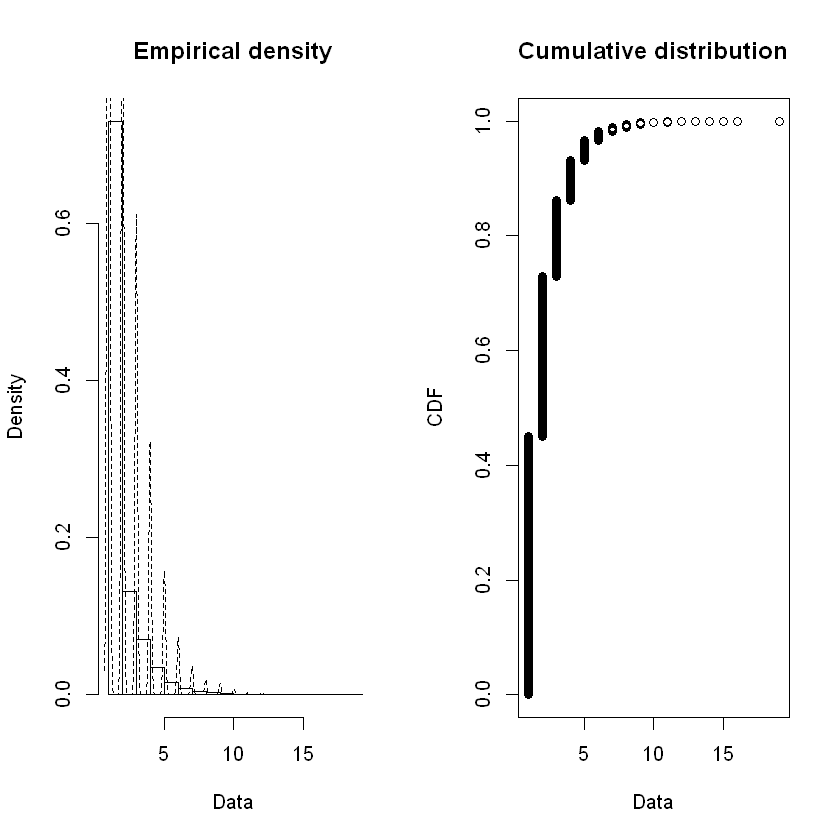

In [463]:
plotdist( dLONov$Wet_Count, histo=TRUE, demp=TRUE )

In [464]:
LOfd_NB_dNov <- fitdist( dLONov$Wet_Count, "nbinom" )
LOfd_GE_dNov <- fitdist( dLONov$Wet_Count, "geom" )

In [465]:
LOfdNB_dNov_size <- LOfd_NB_dNov$estimate[["size"]]
LOfdNB_dNov_mu <- LOfd_NB_dNov$estimate[["mu"]]
cat("LOCA Nov size: ", LOfdNB_dNov_size, "\n", "LOCA Nov mu: ", LOfdNB_dNov_mu, "\n")

LOCA Nov size:  163.7076 
 LOCA Nov mu:  2.098162 


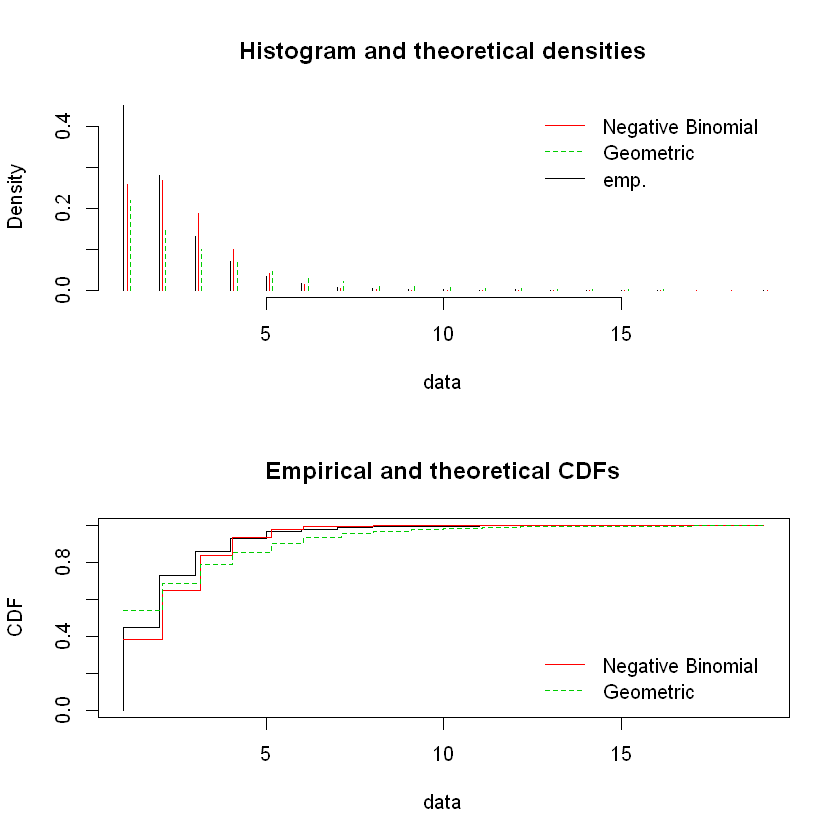

In [466]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dNov, LOfd_GE_dNov), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dNov, LOfd_GE_dNov), legendtext=plot.legend )

In [467]:
LOstatRes <- gofstat( list(LOfd_NB_dNov, LOfd_GE_dNov), fitnames=c("Negative Binomial", "Geometric") )

In [468]:
print( LOstatRes )

Chi-squared statistic:  167771.9 188219.3 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    451611           382736.07247     542597.269
<= 2    280074           269007.57797     148364.732
<= 3    132055           188029.13124     100473.180
<= 4     70659            99165.36158      68040.833
<= 5     34410            42090.31652      46077.520
<= 6     15617            14976.31757      31203.878
<= 7      7806             4594.60038      21131.389
<= 8      4178             1240.65224      14310.260
<= 9      2928              299.52738       9690.964
> 9       2883               81.44264      20330.976

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3333565   3905601
Bayesian Information Criterion           3333589   3905613


In [469]:
LOfdNB_dNov_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [470]:
LOfdNB_dNov_p = LOfdNB_dNov_size / (LOfdNB_dNov_size + LOfdNB_dNov_mu)
cat("LOCA prob: ", LOfdNB_dNov_p)

LOCA prob:  0.9873457

In [471]:
# add to our tracking dataframe
LOMonDistDF[11, ] <- list( 11, dLONovMean, dLONovBNr, LOfdNB_dNov_p, LOfdNB_dNov_mu, LOfdNB_dNov_size,
                          LOfdNB_dNov_pvalue )

In [472]:
LOgf_dNov <- goodfit( dLONov$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dNov_size, prob=LOfdNB_dNov_p) )

In [473]:
summary( LOgf_dNov )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          9518787.8 19        0
Likelihood Ratio  429866.3 16        0


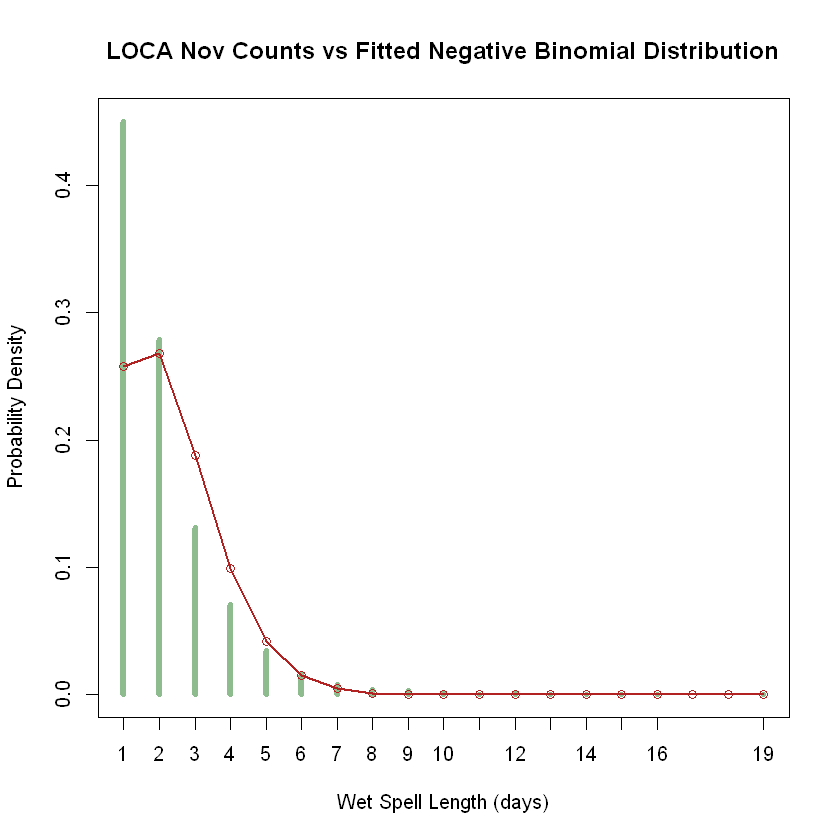

In [474]:
maxP <- max(dLONov$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dNov_size, mu=LOfdNB_dNov_mu )
ttab <- table( dLONov$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Nov Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

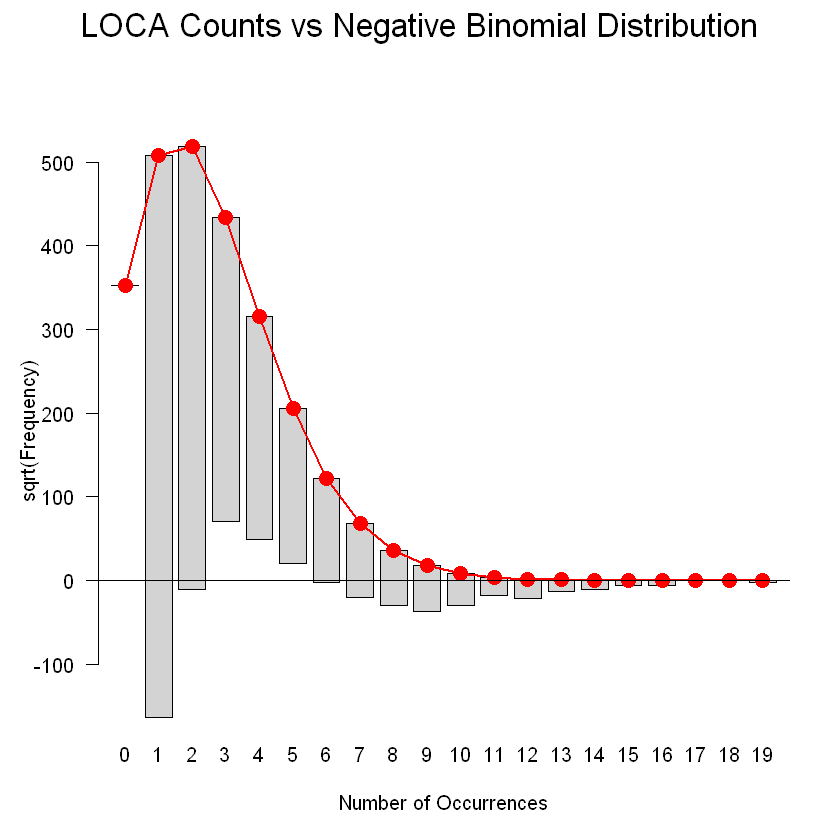

In [475]:
plot( LOgf_dNov, main="LOCA Counts vs Negative Binomial Distribution" )

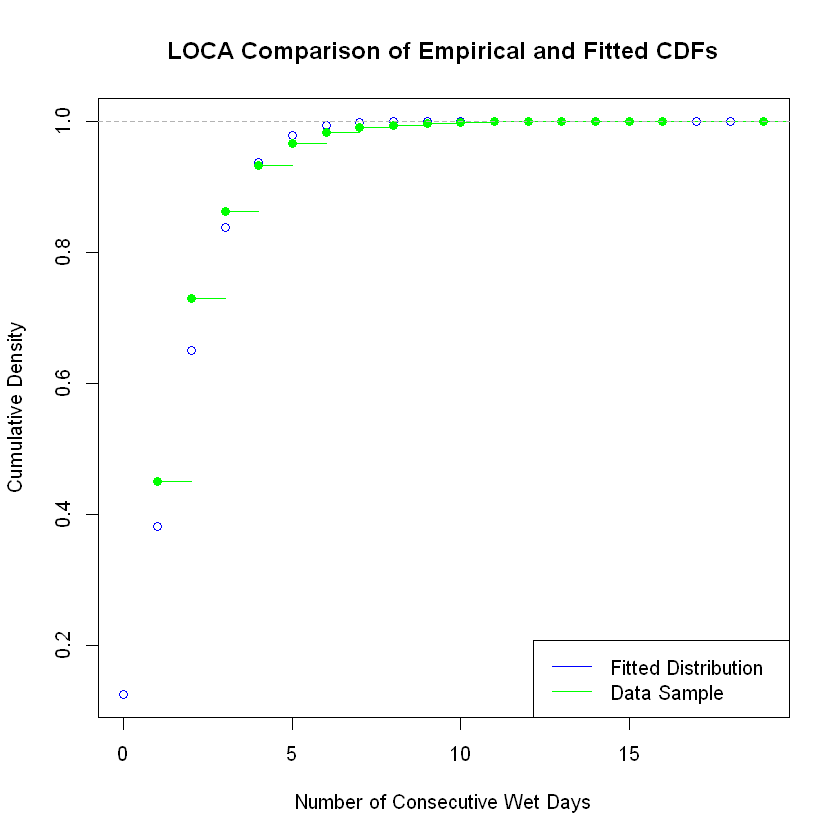

In [476]:
x <- seq(0,dLONovMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dNov_mu, size=LOfdNB_dNov_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLONov$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

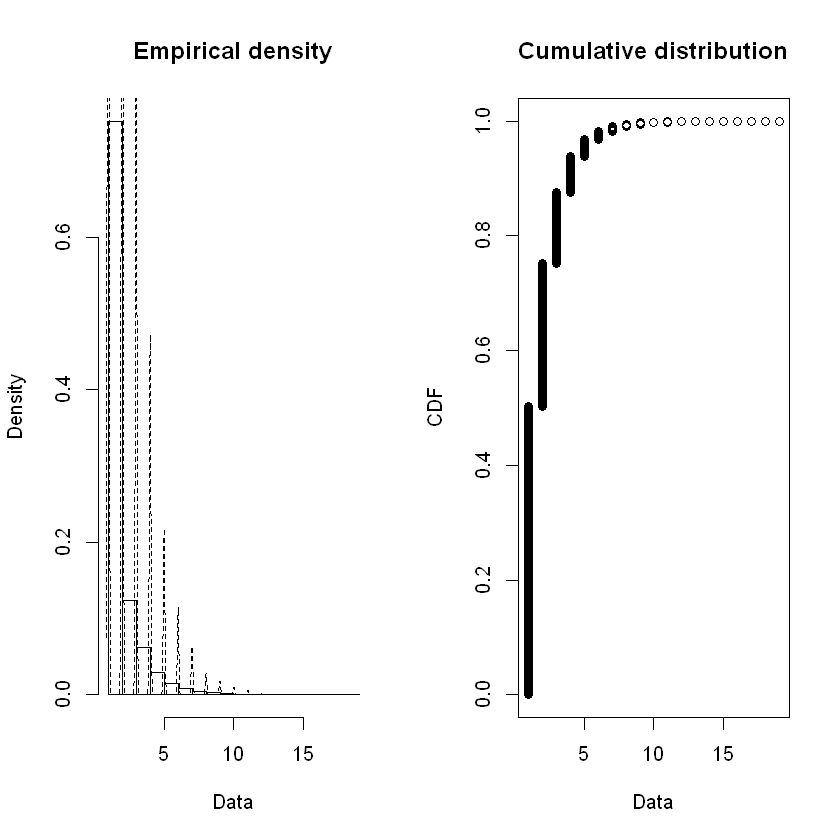

In [477]:
plotdist( dBCNov$Wet_Count, histo=TRUE, demp=TRUE )

In [478]:
BCfd_NB_dNov <- fitdist( dBCNov$Wet_Count, "nbinom" )
BCfd_GE_dNov <- fitdist( dBCNov$Wet_Count, "geom" )

In [479]:
summary( BCfd_NB_dNov )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
      estimate Std. Error
size 95.098242 6.46137603
mu    1.999235 0.00182588
Loglikelihood:  -1001473   AIC:  2002951   BIC:  2002973 
Correlation matrix:
            size          mu
size 1.000000000 0.000208075
mu   0.000208075 1.000000000


In [480]:
BCfdNB_dNov_size <- BCfd_NB_dNov$estimate[["size"]]
BCfdNB_dNov_mu <- BCfd_NB_dNov$estimate[["mu"]]
cat("BCCA Nov size: ", BCfdNB_dNov_size, "\n", "BCCA Nov mu: ", BCfdNB_dNov_mu, "\n")

BCCA Nov size:  95.09824 
 BCCA Nov mu:  1.999235 


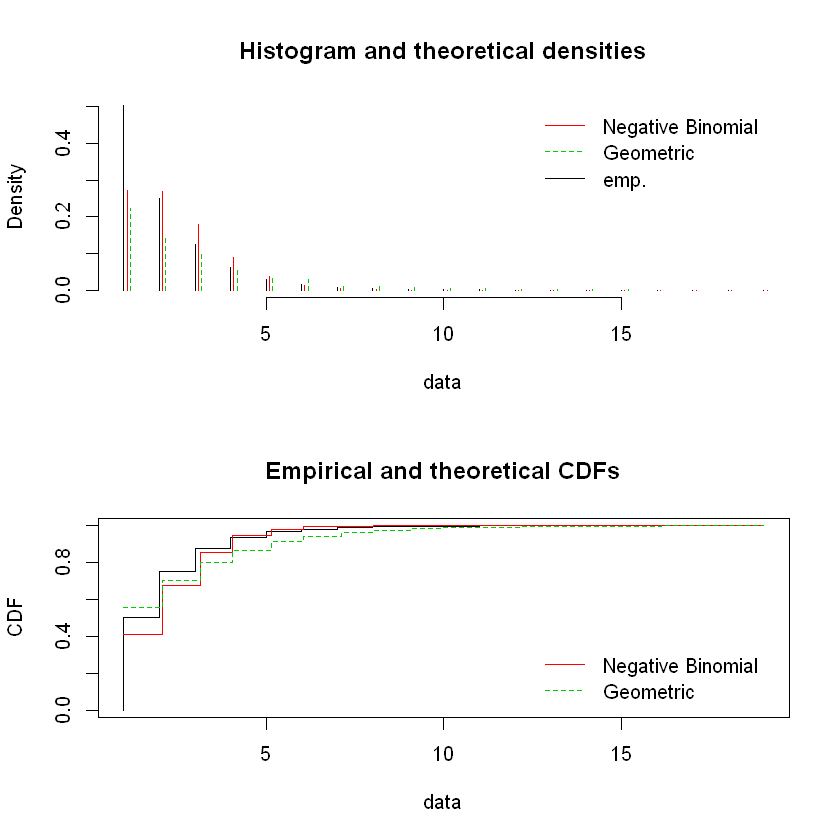

In [481]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dNov, BCfd_GE_dNov), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dNov, BCfd_GE_dNov), legendtext=plot.legend )

In [482]:
BCstatRes <- gofstat( list(BCfd_NB_dNov, BCfd_GE_dNov), fitnames=c("Negative Binomial", "Geometric") )

In [483]:
print(BCstatRes)

Chi-squared statistic:  184786.5 76084.2 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     307381           2.504092e+05     340160.524
<= 2     153338           1.639877e+05      90697.183
<= 3      76004           1.092842e+05      60459.669
<= 4      37922           5.518413e+04      40303.033
<= 5      17905           2.251988e+04      26866.413
<= 6       8951           7.735653e+03      17909.425
<= 7       5271           2.300374e+03      11938.606
<= 8       2245           6.044807e+02       7958.397
<= 10      2238           1.731357e+02       8841.615
> 10        951           7.326534e+00       7071.136

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2002951   2337817
Bayesian Information Criterion           2002973   2337828


In [484]:
BCfdNB_dNov_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [485]:
BCfdNB_dNov_p = BCfdNB_dNov_size / (BCfdNB_dNov_size + BCfdNB_dNov_mu)
cat("BCCA prob: ", BCfdNB_dNov_p)

BCCA prob:  0.97941

In [486]:
# add to our tracking dataframe
BCMonDistDF[11, ] <- list( 11, dBCNovMean, dBCNovBNr, BCfdNB_dNov_p, BCfdNB_dNov_mu, BCfdNB_dNov_size,
                          BCfdNB_dNov_pvalue )

In [487]:
BCgf_dNov <- goodfit( dBCNov$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dNov_size, prob=BCfdNB_dNov_p) )

In [488]:
summary( BCgf_dNov )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          26347917.5 19        0
Likelihood Ratio   306512.4 18        0


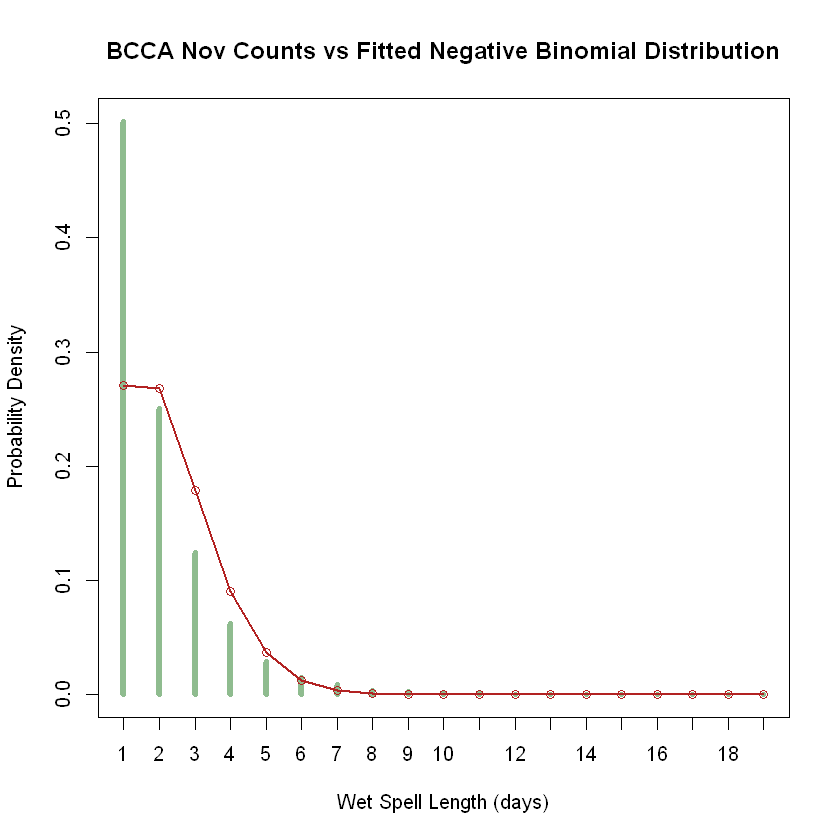

In [489]:
maxP <- max(dBCNov$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dNov_size, mu=BCfdNB_dNov_mu )
ttab <- table( dBCNov$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Nov Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

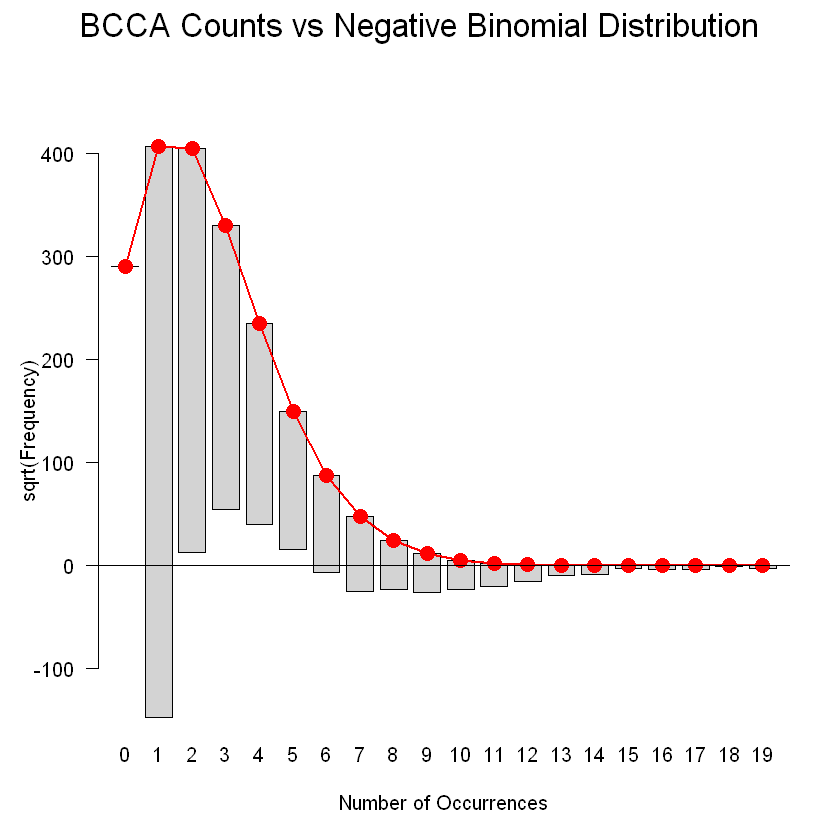

In [490]:
plot( BCgf_dNov, main="BCCA Counts vs Negative Binomial Distribution" )

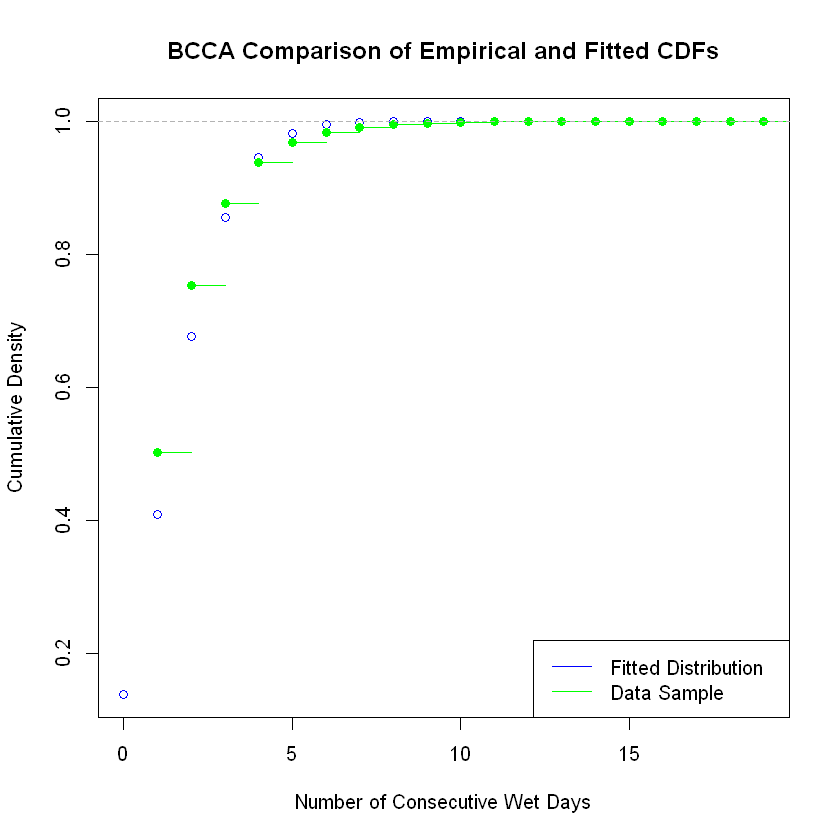

In [491]:
x <- seq(0,dBCNovMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dNov_mu, size=BCfdNB_dNov_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCNov$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

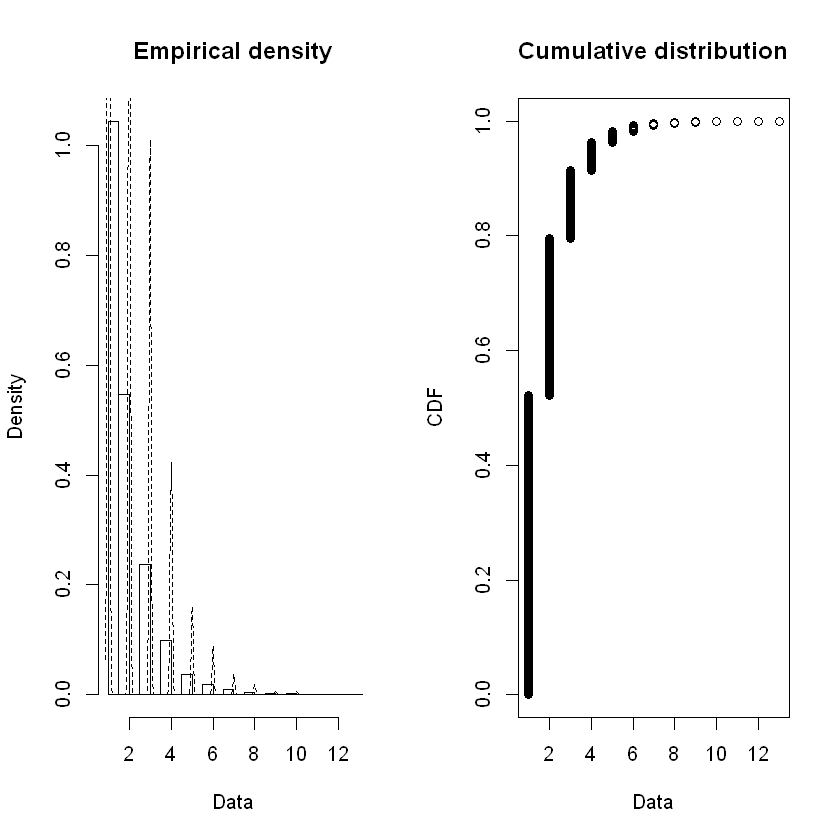

In [492]:
plotdist( dLODec$Wet_Count, histo=TRUE, demp=TRUE )

In [493]:
LOfd_NB_dDec <- fitdist( dLODec$Wet_Count, "nbinom" )
LOfd_GE_dDec <- fitdist( dLODec$Wet_Count, "geom" )

In [494]:
LOfdNB_dDec_size <- LOfd_NB_dDec$estimate[["size"]]
LOfdNB_dDec_mu <- LOfd_NB_dDec$estimate[["mu"]]
cat("LOCA Dec size: ", LOfdNB_dDec_size, "\n", "LOCA Dec mu: ", LOfdNB_dDec_mu, "\n")

LOCA Dec size:  4317364 
 LOCA Dec mu:  1.835912 


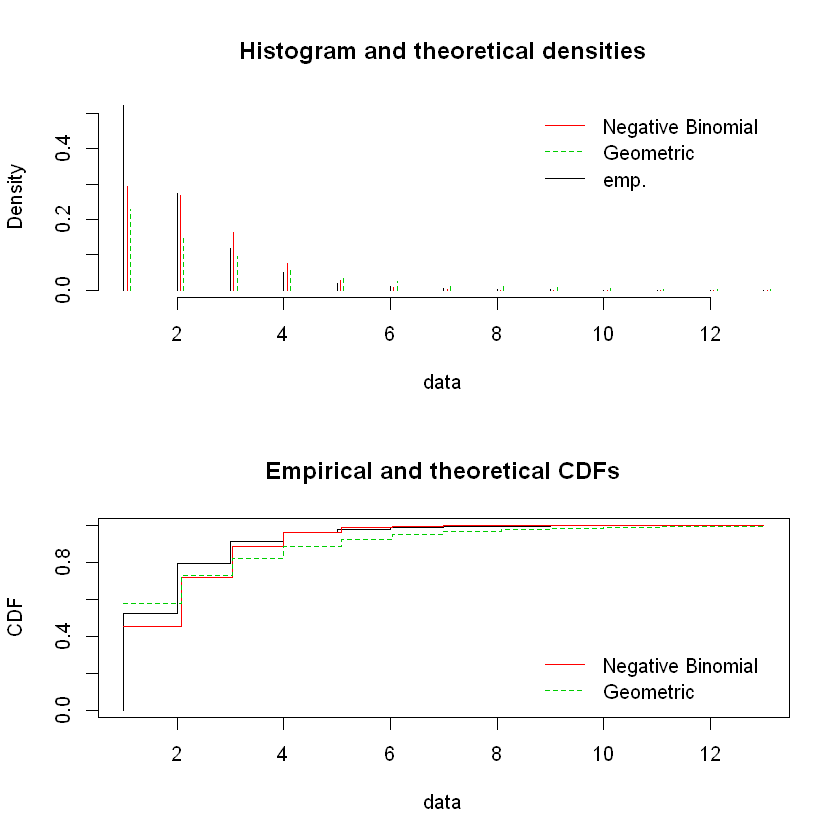

In [495]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dDec, LOfd_GE_dDec), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dDec, LOfd_GE_dDec), legendtext=plot.legend )

In [496]:
LOstatRes <- gofstat( list(LOfd_NB_dDec, LOfd_GE_dDec), fitnames=c("Negative Binomial", "Geometric") )

In [497]:
print( LOstatRes )

Chi-squared statistic:  68539.83 164113.3 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    486456           421268.53366      541143.03
<= 2    255008           250345.51900      137662.62
<= 3    110088           153204.11356       89117.37
<= 4     46267            70317.33364       57691.08
<= 5     17281            25819.29919       37346.94
<= 6      9039             7900.33233       24176.94
<= 7      4018             2072.04690       15651.20
<= 9      2598              572.51256       16691.01
> 9        766               21.30916       12040.82

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2820454   3429103
Bayesian Information Criterion           2820478   3429115


In [498]:
LOfdNB_dDec_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [499]:
LOfdNB_dDec_p = LOfdNB_dDec_size / (LOfdNB_dDec_size + LOfdNB_dDec_mu)
cat("LOCA prob: ", LOfdNB_dDec_p)

LOCA prob:  0.9999996

In [500]:
# add to our tracking dataframe
LOMonDistDF[12, ] <- list( 12, dLODecMean, dLODecBNr, LOfdNB_dDec_p, LOfdNB_dDec_mu, LOfdNB_dDec_size,
                           LOfdNB_dDec_pvalue )

In [501]:
LOgf_dDec <- goodfit( dLODec$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dDec_size, prob=LOfdNB_dDec_p) )

In [502]:
summary( LOgf_dDec )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          382072.7 13        0
Likelihood Ratio 468514.8 12        0


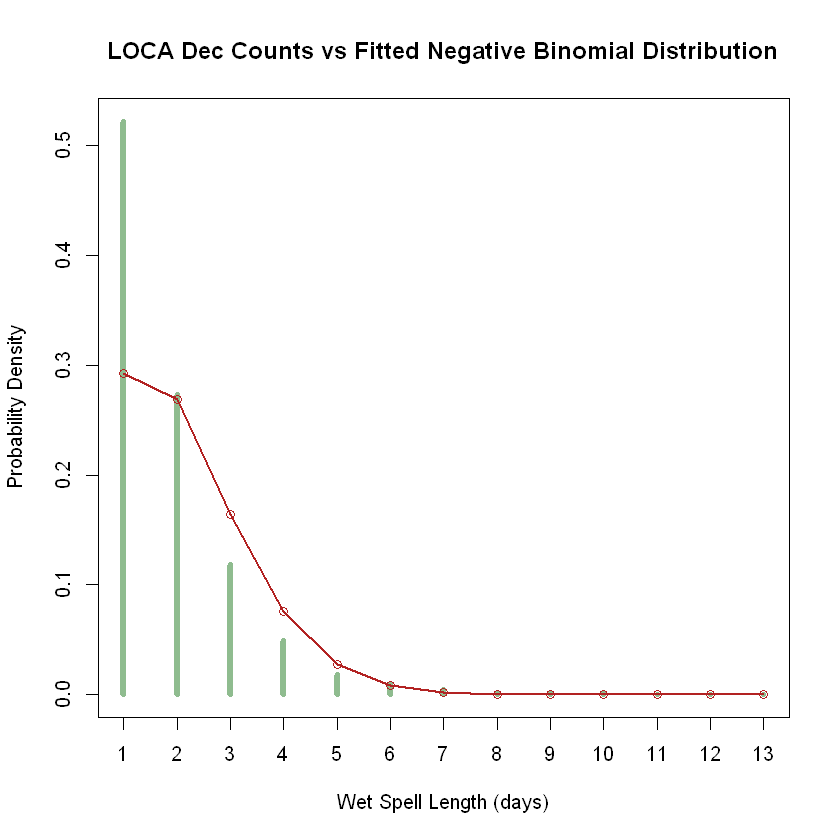

In [503]:
maxP <- max(dLODec$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dDec_size, mu=LOfdNB_dDec_mu )
ttab <- table( dLODec$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Dec Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

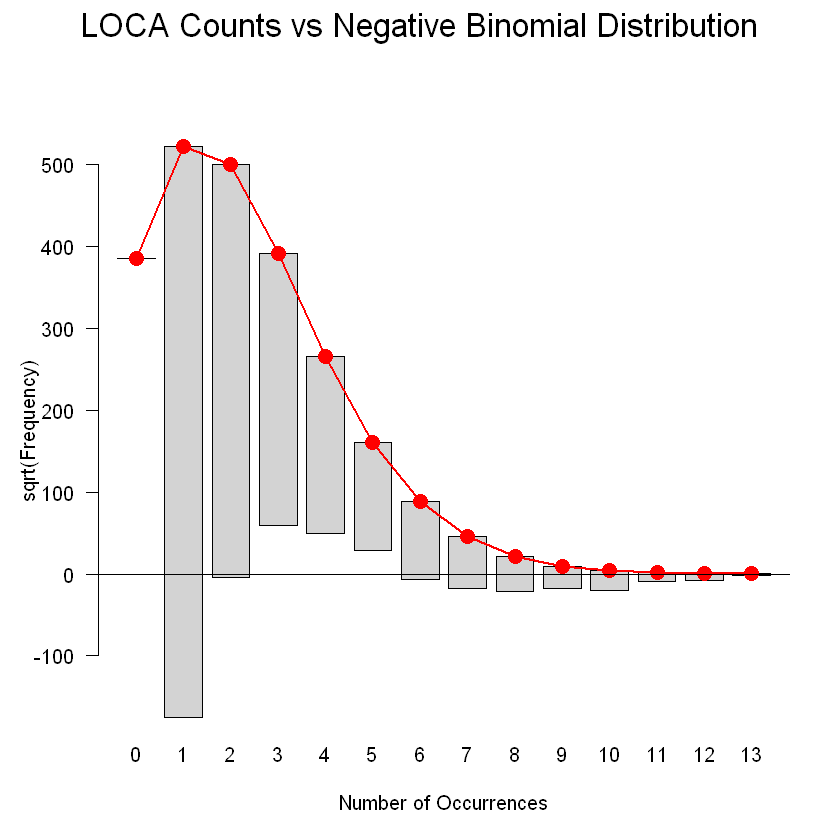

In [504]:
plot( LOgf_dDec, main="LOCA Counts vs Negative Binomial Distribution" )

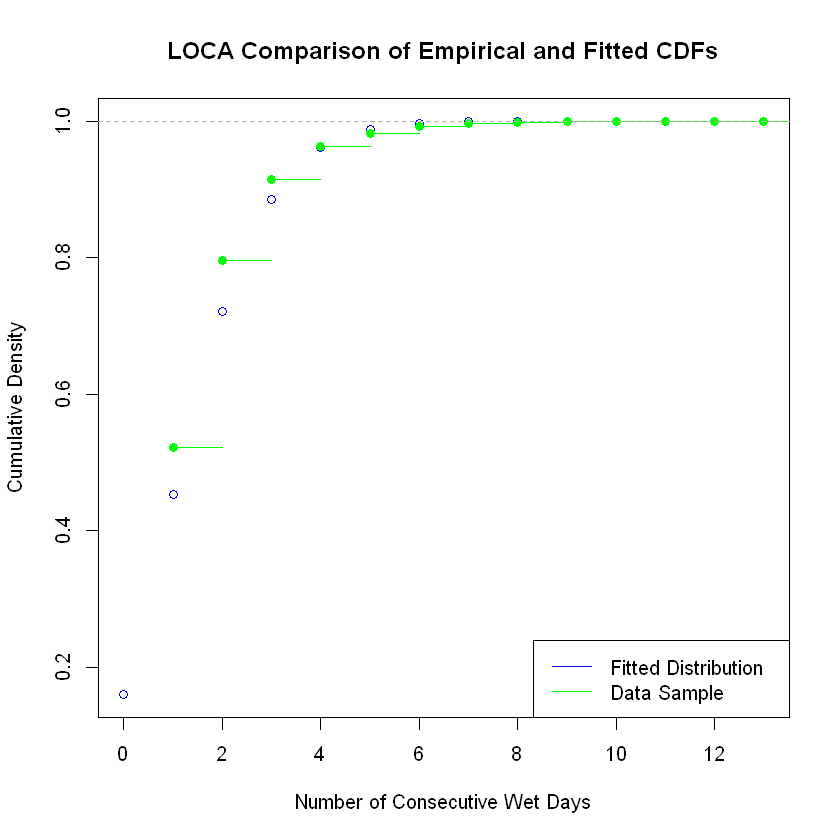

In [505]:
x <- seq(0,dLODecMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dDec_mu, size=LOfdNB_dDec_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLODec$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

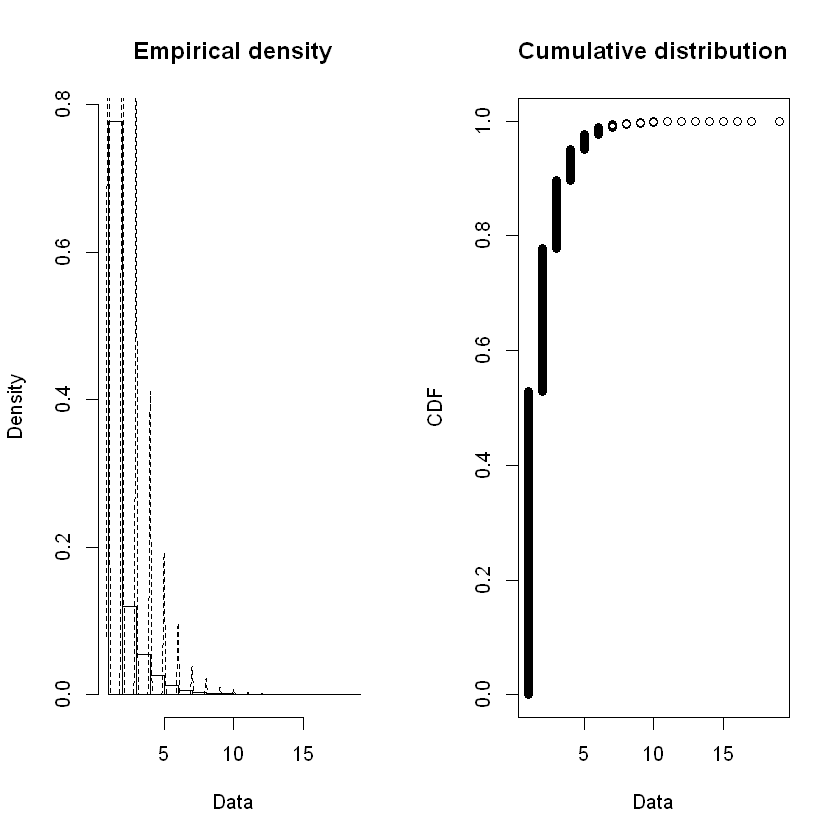

In [506]:
plotdist( dBCDec$Wet_Count, histo=TRUE, demp=TRUE )

In [507]:
BCfd_NB_dDec <- fitdist( dBCDec$Wet_Count, "nbinom" )
BCfd_GE_dDec <- fitdist( dBCDec$Wet_Count, "geom" )

In [508]:
summary( BCfd_NB_dDec )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 1.433677e+06 0.951221704
mu   1.893752e+00 0.001757284
Loglikelihood:  -962372.9   AIC:  1924750   BIC:  1924773 
Correlation matrix:
            size          mu
size 1.00000e+00 1.45947e-07
mu   1.45947e-07 1.00000e+00


In [509]:
BCfdNB_dDec_size <- BCfd_NB_dDec$estimate[["size"]]
BCfdNB_dDec_mu <- BCfd_NB_dDec$estimate[["mu"]]
cat("BCCA Dec size: ", BCfdNB_dDec_size, "\n", "BCCA Dec mu: ", BCfdNB_dDec_mu, "\n")

BCCA Dec size:  1433677 
 BCCA Dec mu:  1.893752 


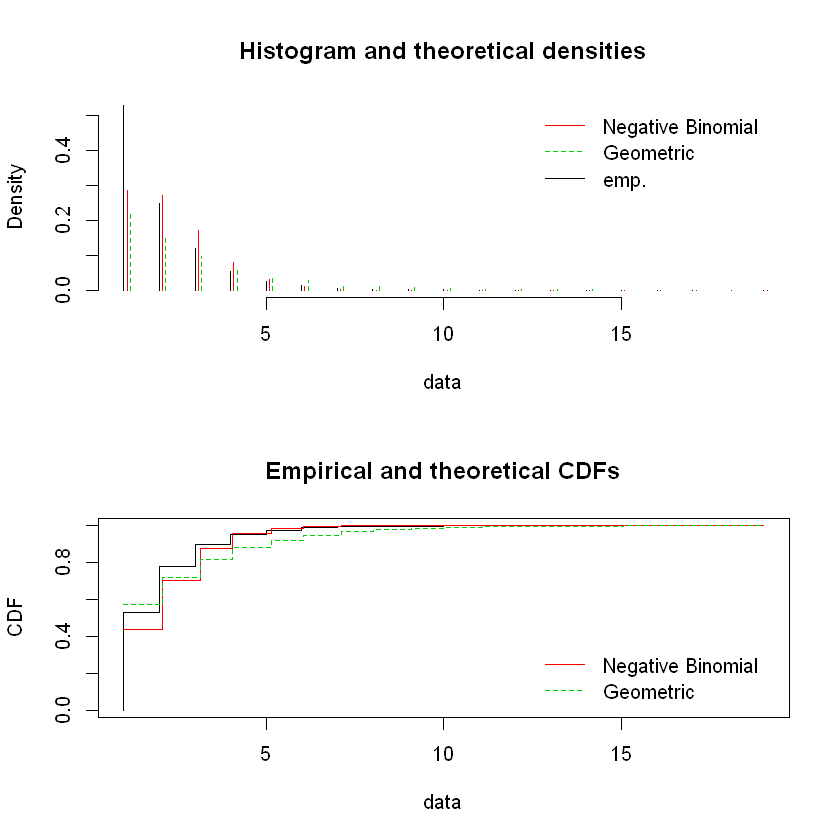

In [510]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dDec, BCfd_GE_dDec), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dDec, BCfd_GE_dDec), legendtext=plot.legend )

In [511]:
BCstatRes <- gofstat( list(BCfd_NB_dDec, BCfd_GE_dDec), fitnames=c("Negative Binomial", "Geometric") )

In [512]:
print(BCstatRes)

Chi-squared statistic:  68279.91 76587.13 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    323939           267066.68248     350568.334
<= 2    152815           165490.90794      90754.431
<= 3     73186           104466.25213      59393.884
<= 4     33012            49458.33089      38870.096
<= 5     15794            18732.38985      25438.383
<= 6      7622             5912.42951      16648.051
<= 7      3180             1599.52959      10895.252
<= 8      1767              378.64039       7130.355
> 8       1888               97.83723      13504.213

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           1924750   2287933
Bayesian Information Criterion           1924773   2287945


In [513]:
BCfdNB_dDec_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [514]:
BCfdNB_dDec_p = BCfdNB_dDec_size / (BCfdNB_dDec_size + BCfdNB_dDec_mu)
cat("BCCA prob: ", BCfdNB_dDec_p)

BCCA prob:  0.9999987

In [515]:
# add to our tracking dataframe
BCMonDistDF[12, ] <- list( 12, dBCDecMean, dBCDecBNr, BCfdNB_dDec_p, BCfdNB_dDec_mu, BCfdNB_dDec_size,
                           BCfdNB_dDec_pvalue )

In [516]:
BCgf_dDec <- goodfit( dBCDec$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dDec_size, prob=BCfdNB_dDec_p) )

In [517]:
summary( BCgf_dDec )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          27363343.6 19        0
Likelihood Ratio   318765.6 17        0


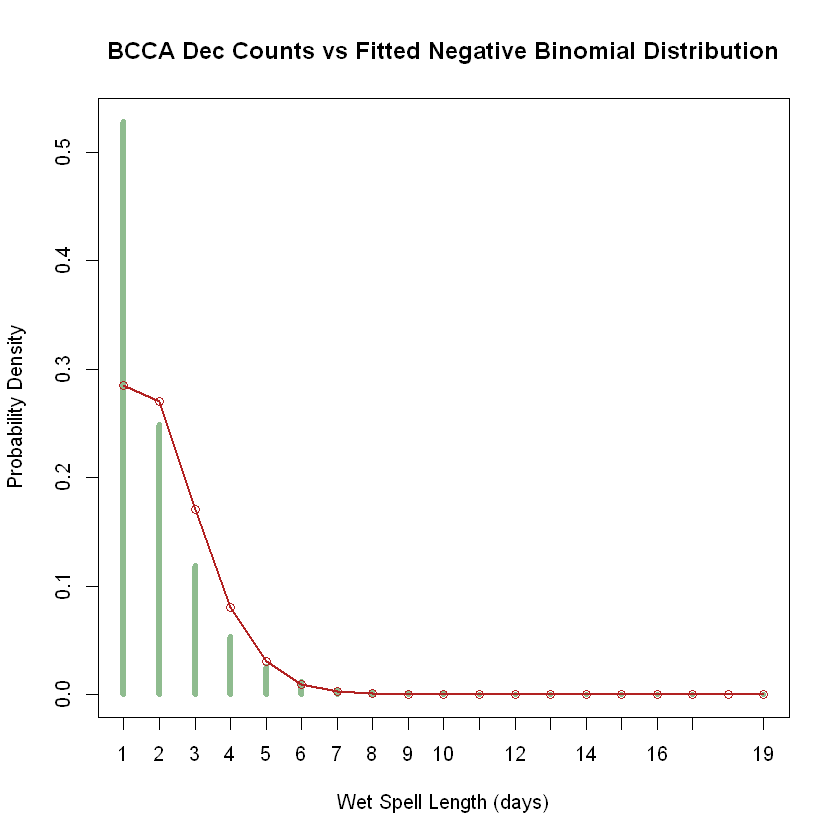

In [518]:
maxP <- max(dBCDec$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dDec_size, mu=BCfdNB_dDec_mu )
ttab <- table( dBCDec$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Dec Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

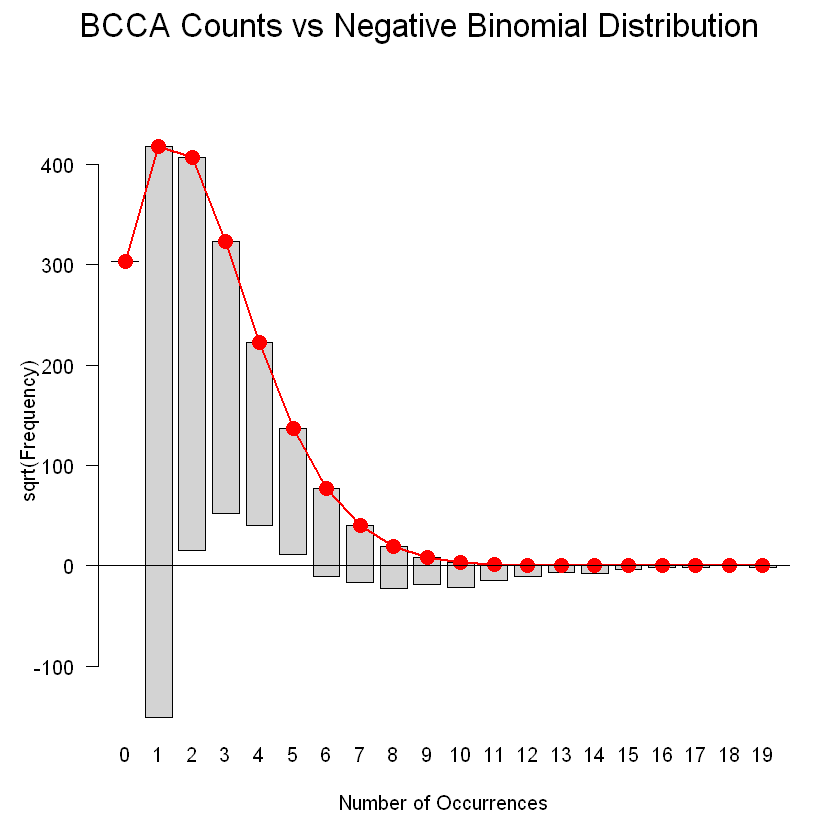

In [519]:
plot( BCgf_dDec, main="BCCA Counts vs Negative Binomial Distribution" )

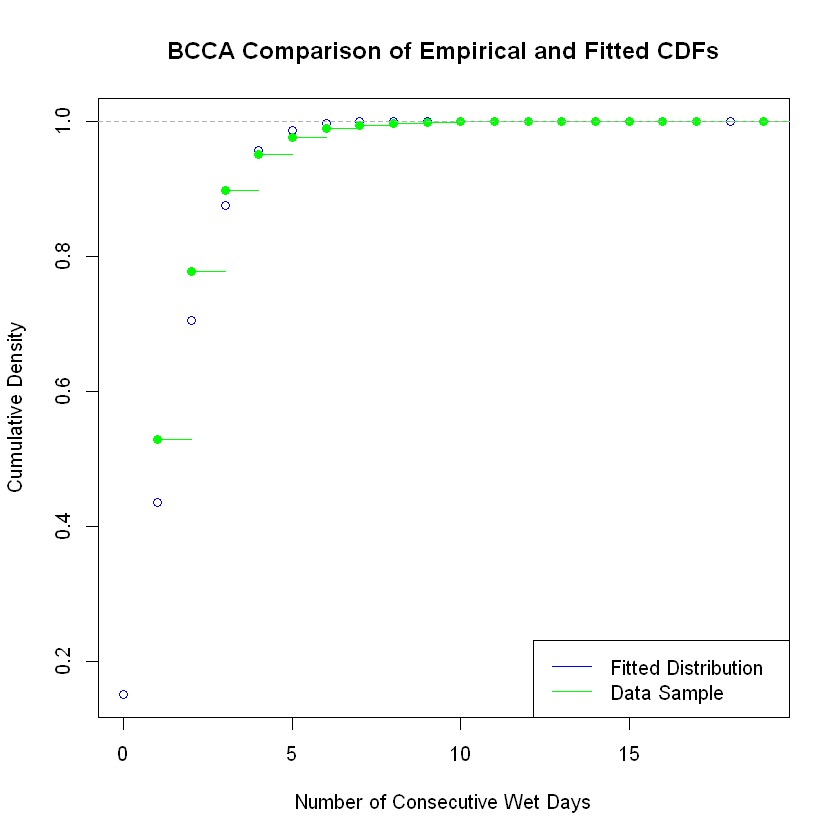

In [520]:
x <- seq(0,dBCDecMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dDec_mu, size=BCfdNB_dDec_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCDec$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Look at our summary DataFrame

In [521]:
print( LOMonDistDF, quote=FALSE, row.names=FALSE )

 month      smu     ssize     sprob      tmu        tsize pvalue
     1 1.786410  5.536440 0.9999952 1.786698 3.737196e+05      0
     2 1.919848  8.529719 0.9999977 1.919722 8.314260e+05      0
     3 1.863620  7.989548 0.9999996 1.863773 4.317364e+06      0
     4 2.253524  7.288129 0.8485327 2.253492 1.262425e+01      0
     5 2.614592  3.257674 0.6732915 2.614087 5.387195e+00      0
     6 2.937227  2.171283 0.5490994 2.936999 3.576630e+00      0
     7 2.617547  2.137236 0.5979795 2.617414 3.893235e+00      0
     8 2.601494  2.092992 0.5935839 2.601277 3.799249e+00      0
     9 2.987932  2.327151 0.5494846 2.987743 3.644089e+00      0
    10 2.469721  5.734523 0.7840313 2.469968 8.966726e+00      0
    11 2.097931 99.174102 0.9873457 2.098162 1.637076e+02      0
    12 1.835759  7.932482 0.9999996 1.835912 4.317364e+06      0


In [522]:
print( BCMonDistDF, quote=FALSE, row.names=FALSE )

 month      smu      ssize     sprob      tmu        tsize pvalue
     1 1.888902  14.765593 0.9999993 1.889014 2.551997e+06      0
     2 1.955868  27.747708 0.9999987 1.955756 1.490599e+06      0
     3 1.948666 149.880511 0.9932044 1.948666 2.848033e+02      0
     4 2.326018   2.746414 0.6948687 2.326256 5.297531e+00      0
     5 2.990414   1.632681 0.4808488 2.990405 2.769776e+00      0
     6 2.771674   1.541483 0.5010716 2.771383 2.783288e+00      0
     7 2.677950   1.491937 0.5123658 2.677473 2.813268e+00      0
     8 2.912639   1.297473 0.4556031 2.912552 2.437501e+00      0
     9 3.136706   1.642839 0.4568101 3.136591 2.637800e+00      0
    10 2.406169   3.641051 0.7117259 2.405865 5.939888e+00      0
    11 1.999492  55.036537 0.9794100 1.999235 9.509824e+01      0
    12 1.893905  21.068519 0.9999987 1.893752 1.433677e+06      0


### Output to a Spreadsheet

Output the stats and distribution fits to a spreadsheet

In [523]:
outputDF_xlsx <- createWorkbook()

In [524]:
LOsumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="LOCA_Summary_Stats")
BCsumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="BCCA_Summary_Stats")
LOmondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="LOCA_Dist_Properties")
BCmondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="BCCA_Dist_Properties")

In [525]:
addDataFrame( x=MonLOSumStatDF, sheet=LOsumstat_xlsx )
addDataFrame( x=MonBCSumStatDF, sheet=BCsumstat_xlsx )
addDataFrame( x=LOMonDistDF, sheet=LOmondist_xlsx )
addDataFrame( x=BCMonDistDF, sheet=BCmondist_xlsx )

In [526]:
saveWorkbook( outputDF_xlsx, file="CMIP5_Wet_RSummary_2071-2100.xlsx" )

## Check that No Grid Cell Outliers

Check that there are not any grid cell outliers. This part will take a long time so may need to split it out to a standalone R script. This also does not make sense so removed.

In [527]:
options(warn = oldw)